In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import re

import keras
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
train_file = "train.csv"
test_file = "test.csv"

train_df = pd.read_csv(train_file, index_col = 0, dtype={"Age": np.float64})
test_df = pd.read_csv(test_file, index_col = 0, dtype={"Age": np.float64})

train_df['train'] = True
test_df['train'] = False
test_df['Survived'] = None
df = pd.concat([train_df, test_df], sort=False)
del train_df
del test_df

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 12 columns):
Survived    891 non-null object
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
train       1309 non-null bool
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 124.0+ KB


In [4]:
#drop useless ticket column
df = df.drop(columns = 'Ticket')

# drop non_embarked people and the missing fare
df = df.dropna(how='all', subset = ['Embarked'])
df = df.dropna(how='all', subset = ['Fare'])

#fill age
df['Age'] = df['Age'].fillna(value = df['Age'].median())

#nb of training exemples
m = df.shape[0]

#find the Surname to det families
df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0].lower())
#find the name length
df["Name_len"] = df["Name"].apply(lambda x: len(x))

#add total nb of relatives on the boat
df['Family_size'] = df['SibSp'] + df['Parch'] + 1
df['Family_size'] = pd.cut(df['Family_size'], bins=[0,1,4,20], labels=[0,1,2])

#find the title
df['Title'] = df['Name'].apply(lambda x: re.search('([A-Za-z]+)\.', x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3,
                 "Master": 4, "Dr": 5, "Rev": 6,
                 "Major": 7, "Col": 7, "Mlle": 2,
                 "Mme": 3,"Don": 9,"Dona": 9,
                 "Lady": 10, "Countess": 10,
                 "Jonkheer": 10, "Sir": 9,
                 "Capt": 7, "Ms": 2}
df["Title"] = df.loc[:,'Title'].map(title_mapping)


#create an index for the cabin, after sorting since similar numbers should be close
tmp_df = df
df = df.sort_values(by = 'Cabin')
le1 = preprocessing.LabelEncoder()
le1.fit(df['Cabin'].values.astype(str))
df['Cabin'] = le1.transform(df['Cabin'].values.astype(str))
df = df.reset_index()
df = df.set_index('PassengerId')

#create an index for each family by comparing Surname and numbers giving relatives
le2 = preprocessing.LabelEncoder()
arrays = [df['SibSp'].values, df['Parch'].values, df['Surname'].values]
joint_criterias = [str(arrays[0][i]) + str(arrays[1][i]) + str(arrays[2][i]) for i in range(m)]
le2.fit(joint_criterias)
df['Family_ind'] = le2.transform(joint_criterias)

#index for the departing port, the sex and the surname while we use it
cols = ['Embarked', 'Sex', 'Surname']
encoders = []
for col in cols:    
    le = preprocessing.LabelEncoder()
    le.fit(df[col].values.astype(str))
    df[col] = le.transform(df[col].values.astype(str))
    encoders.append(le)

#add mean, min and max age of the family
df['Mean_age'] = df.groupby('Family_ind')['Age'].transform(lambda x: x.mean())
df['Min_age'] = df.groupby('Family_ind')['Age'].transform(lambda x: x.min())
df['Max_age'] = df.groupby('Family_ind')['Age'].transform(lambda x: x.max())

#name as well as family are no longer useful, since information is now contained elsewhere ??? essayons avec d'abord puis sans
df = df.drop(columns = ['Name', 'SibSp', 'Parch'])

#normalize the rest of the Data ?

In [5]:
print(df.tail(5))

            Survived  Pclass  Sex   Age     Fare  Cabin  Embarked  train  \
PassengerId                                                                
1304            None       3    0  28.0   7.7750    185         2  False   
1305            None       3    1  28.0   8.0500    185         2  False   
1307            None       3    1  38.5   7.2500    185         2  False   
1308            None       3    1  28.0   8.0500    185         2  False   
1309            None       3    1  28.0  22.3583    185         0  False   

             Surname  Name_len Family_size  Title  Family_ind  Mean_age  \
PassengerId                                                               
1304             338        30           0      2         265      28.0   
1305             757        18           0      1         607      28.0   
1307             703        28           0      1         562      38.5   
1308             831        19           0      1         666      29.5   
1309             

In [6]:
train_df = df.loc[lambda df:df['train'] == True].drop(columns = 'train')
test_df = df.loc[lambda df:df['train'] == False].drop(columns = 'train')

y = train_df['Survived'].astype(bool).values
X = train_df.drop(columns = 'Survived').values

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=700, verbose=1, max_depth=3)
model1.fit(X_tr, y_tr)
print(model1.score(X_tr, y_tr))
print(model1.score(X_val, y_val))

      Iter       Train Loss   Remaining Time 
         1           1.2948            1.28s
         2           1.2536            1.18s
         3           1.2161            1.16s
         4           1.1823            1.14s
         5           1.1514            1.12s
         6           1.1199            1.10s
         7           1.0916            1.07s
         8           1.0652            1.06s
         9           1.0414            1.04s
        10           1.0191            1.03s
        20           0.8723            0.91s
        30           0.7964            0.87s
        40           0.7387            0.84s
        50           0.7002            0.81s
        60           0.6711            0.79s
        70           0.6458            0.77s
        80           0.6248            0.75s
        90           0.6013            0.73s
       100           0.5863            0.71s
       200           0.4500            0.56s
       300           0.3479            0.44s
       40

Pclass = 0.06429435009248569
Sex = 0.014823119546031889
Age = 0.028460307654495164
Fare = 0.11333728060907731
Cabin = 0.06092347203117776
Embarked = 0.01618638901441531
Surname = 0.08239412426375581
Name_len = 0.05583264298255625
Family_size = 0.04758360153943169
Title = 0.3711660317584239
Family_ind = 0.07683219671933506
Mean_age = 0.02079108448607276
Min_age = 0.026811689870489555
Max_age = 0.02056370943225182


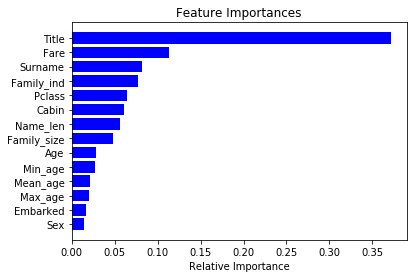

In [8]:
features = train_df.drop(columns = 'Survived').columns.values
importances = model1.feature_importances_
indices = np.argsort(importances)

for name, importance in zip(features, importances):
    print(name, "=", importance)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [9]:
def create_model(optimizer='Adam'):

    input_dim = X_tr.shape[1]

    l2 = regularizers.l2(0.01)

    model2 = Sequential()
    model2.add(Dense(32, activation = 'relu', kernel_initializer='glorot_normal', input_dim=input_dim, kernel_regularizer=l2))
    model2.add(Dense(64, activation = 'relu', kernel_initializer='glorot_normal', kernel_regularizer=l2))
    model2.add(Dense(128, activation = 'relu', kernel_initializer='glorot_normal', kernel_regularizer=l2))
    model2.add(Dense(164, activation = 'relu', kernel_initializer='glorot_normal', kernel_regularizer=l2))
    model2.add(Dense(16, activation = 'relu', kernel_initializer='glorot_normal'))
    model2.add(Dense(1, activation = 'sigmoid', kernel_initializer='glorot_normal'))

    model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model2

optimizer = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
histories = []
models = []
kf = KFold(10, random_state=42)
for train_ind, test_ind in kf.split(X):
    X_tr, X_test = X[train_ind], X[test_ind]
    y_tr, y_test = y[train_ind], y[test_ind]
    model = create_model()
    history = model.fit(X_tr, y_tr, batch_size=64, epochs=2500, validation_data=(X_val,y_val))
    models.append(model)
    histories.append(history)

Train on 800 samples, validate on 178 samples
Epoch 1/2500
800/800 [==============================] - 2s 2ms/step - loss: 8.2545 - acc: 0.5775 - val_loss: 7.0881 - val_acc: 0.6517
Epoch 2/2500
800/800 [==============================] - 0s 79us/step - loss: 6.2535 - acc: 0.5887 - val_loss: 4.7371 - val_acc: 0.6798
Epoch 3/2500
800/800 [==============================] - 0s 75us/step - loss: 4.5055 - acc: 0.5763 - val_loss: 3.1722 - val_acc: 0.6742
Epoch 4/2500
800/800 [==============================] - 0s 75us/step - loss: 2.9869 - acc: 0.6125 - val_loss: 2.7575 - val_acc: 0.5281
Epoch 5/2500
800/800 [==============================] - 0s 73us/step - loss: 2.6869 - acc: 0.6350 - val_loss: 2.5010 - val_acc: 0.6348
Epoch 6/2500
800/800 [==============================] - 0s 76us/step - loss: 2.4716 - acc: 0.6500 - val_loss: 2.3647 - val_acc: 0.6798
Epoch 7/2500
800/800 [==============================] - 0s 74us/step - loss: 2.3474 - acc: 0.6450 - val_loss: 2.3245 - val_acc: 0.6685
Epoch 8/25

Epoch 61/2500
800/800 [==============================] - 0s 74us/step - loss: 1.2956 - acc: 0.7150 - val_loss: 1.3051 - val_acc: 0.7135
Epoch 62/2500
800/800 [==============================] - 0s 75us/step - loss: 1.2924 - acc: 0.7125 - val_loss: 1.3366 - val_acc: 0.7191
Epoch 63/2500
800/800 [==============================] - 0s 75us/step - loss: 1.3014 - acc: 0.7112 - val_loss: 1.3087 - val_acc: 0.6910
Epoch 64/2500
800/800 [==============================] - 0s 74us/step - loss: 1.2530 - acc: 0.7375 - val_loss: 1.2434 - val_acc: 0.7472
Epoch 65/2500
800/800 [==============================] - 0s 75us/step - loss: 1.2972 - acc: 0.7013 - val_loss: 1.3431 - val_acc: 0.6404
Epoch 66/2500
800/800 [==============================] - 0s 74us/step - loss: 1.3114 - acc: 0.7063 - val_loss: 1.2137 - val_acc: 0.7472
Epoch 67/2500
800/800 [==============================] - 0s 73us/step - loss: 1.2432 - acc: 0.7325 - val_loss: 1.2329 - val_acc: 0.7360
Epoch 68/2500
800/800 [=========================

800/800 [==============================] - 0s 72us/step - loss: 1.0432 - acc: 0.7375 - val_loss: 0.9812 - val_acc: 0.7472
Epoch 122/2500
800/800 [==============================] - 0s 75us/step - loss: 1.0098 - acc: 0.7575 - val_loss: 0.9756 - val_acc: 0.7809
Epoch 123/2500
800/800 [==============================] - 0s 75us/step - loss: 1.0049 - acc: 0.7512 - val_loss: 0.9682 - val_acc: 0.7472
Epoch 124/2500
800/800 [==============================] - 0s 74us/step - loss: 1.0038 - acc: 0.7400 - val_loss: 0.9503 - val_acc: 0.7640
Epoch 125/2500
800/800 [==============================] - 0s 75us/step - loss: 0.9890 - acc: 0.7538 - val_loss: 0.9605 - val_acc: 0.7640
Epoch 126/2500
800/800 [==============================] - 0s 73us/step - loss: 0.9868 - acc: 0.7587 - val_loss: 0.9621 - val_acc: 0.7809
Epoch 127/2500
800/800 [==============================] - 0s 74us/step - loss: 0.9980 - acc: 0.7437 - val_loss: 0.9758 - val_acc: 0.7753
Epoch 128/2500
800/800 [==============================] 

Epoch 181/2500
800/800 [==============================] - 0s 75us/step - loss: 0.8708 - acc: 0.7575 - val_loss: 0.8236 - val_acc: 0.7865
Epoch 182/2500
800/800 [==============================] - 0s 74us/step - loss: 0.8667 - acc: 0.7512 - val_loss: 0.8309 - val_acc: 0.7640
Epoch 183/2500
800/800 [==============================] - 0s 75us/step - loss: 0.8561 - acc: 0.7488 - val_loss: 0.8141 - val_acc: 0.7978
Epoch 184/2500
800/800 [==============================] - 0s 73us/step - loss: 0.8565 - acc: 0.7538 - val_loss: 0.8252 - val_acc: 0.7921
Epoch 185/2500
800/800 [==============================] - 0s 72us/step - loss: 0.8513 - acc: 0.7437 - val_loss: 0.8320 - val_acc: 0.7472
Epoch 186/2500
800/800 [==============================] - 0s 73us/step - loss: 0.8763 - acc: 0.7350 - val_loss: 0.8138 - val_acc: 0.7809
Epoch 187/2500
800/800 [==============================] - 0s 74us/step - loss: 0.8494 - acc: 0.7462 - val_loss: 0.8309 - val_acc: 0.7753
Epoch 188/2500
800/800 [=================

Epoch 241/2500
800/800 [==============================] - 0s 75us/step - loss: 0.7613 - acc: 0.7638 - val_loss: 0.7285 - val_acc: 0.7865
Epoch 242/2500
800/800 [==============================] - 0s 74us/step - loss: 0.7752 - acc: 0.7525 - val_loss: 0.7441 - val_acc: 0.7528
Epoch 243/2500
800/800 [==============================] - 0s 73us/step - loss: 0.7525 - acc: 0.7737 - val_loss: 0.7239 - val_acc: 0.7753
Epoch 244/2500
800/800 [==============================] - 0s 76us/step - loss: 0.7760 - acc: 0.7625 - val_loss: 0.7517 - val_acc: 0.8090
Epoch 245/2500
800/800 [==============================] - 0s 76us/step - loss: 0.7801 - acc: 0.7600 - val_loss: 0.7493 - val_acc: 0.7865
Epoch 246/2500
800/800 [==============================] - 0s 73us/step - loss: 0.7508 - acc: 0.7762 - val_loss: 0.7227 - val_acc: 0.7921
Epoch 247/2500
800/800 [==============================] - 0s 74us/step - loss: 0.7664 - acc: 0.7688 - val_loss: 0.7192 - val_acc: 0.7809
Epoch 248/2500
800/800 [=================

Epoch 301/2500
800/800 [==============================] - 0s 72us/step - loss: 0.6781 - acc: 0.7737 - val_loss: 0.6648 - val_acc: 0.7921
Epoch 302/2500
800/800 [==============================] - 0s 76us/step - loss: 0.6995 - acc: 0.7500 - val_loss: 0.6868 - val_acc: 0.7584
Epoch 303/2500
800/800 [==============================] - 0s 74us/step - loss: 0.6917 - acc: 0.7712 - val_loss: 0.6868 - val_acc: 0.7978
Epoch 304/2500
800/800 [==============================] - 0s 74us/step - loss: 0.6889 - acc: 0.7700 - val_loss: 0.6568 - val_acc: 0.8146
Epoch 305/2500
800/800 [==============================] - 0s 74us/step - loss: 0.6776 - acc: 0.7750 - val_loss: 0.6773 - val_acc: 0.7697
Epoch 306/2500
800/800 [==============================] - 0s 75us/step - loss: 0.6734 - acc: 0.7875 - val_loss: 0.6519 - val_acc: 0.8034
Epoch 307/2500
800/800 [==============================] - 0s 73us/step - loss: 0.6725 - acc: 0.7812 - val_loss: 0.6729 - val_acc: 0.7584
Epoch 308/2500
800/800 [=================

Epoch 361/2500
800/800 [==============================] - 0s 73us/step - loss: 0.6495 - acc: 0.7700 - val_loss: 0.6249 - val_acc: 0.7753
Epoch 362/2500
800/800 [==============================] - 0s 75us/step - loss: 0.6339 - acc: 0.7750 - val_loss: 0.6427 - val_acc: 0.7697
Epoch 363/2500
800/800 [==============================] - 0s 74us/step - loss: 0.6305 - acc: 0.7650 - val_loss: 0.6362 - val_acc: 0.8090
Epoch 364/2500
800/800 [==============================] - 0s 73us/step - loss: 0.6431 - acc: 0.7737 - val_loss: 0.6398 - val_acc: 0.8202
Epoch 365/2500
800/800 [==============================] - 0s 74us/step - loss: 0.6517 - acc: 0.7775 - val_loss: 0.6495 - val_acc: 0.8034
Epoch 366/2500
800/800 [==============================] - 0s 74us/step - loss: 0.6349 - acc: 0.7888 - val_loss: 0.6279 - val_acc: 0.7978
Epoch 367/2500
800/800 [==============================] - 0s 74us/step - loss: 0.6458 - acc: 0.7750 - val_loss: 0.6254 - val_acc: 0.7978
Epoch 368/2500
800/800 [=================

Epoch 421/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5764 - acc: 0.8000 - val_loss: 0.5990 - val_acc: 0.8315
Epoch 422/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5772 - acc: 0.8025 - val_loss: 0.5953 - val_acc: 0.8146
Epoch 423/2500
800/800 [==============================] - 0s 83us/step - loss: 0.6176 - acc: 0.7750 - val_loss: 0.6673 - val_acc: 0.7809
Epoch 424/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5745 - acc: 0.7987 - val_loss: 0.6567 - val_acc: 0.7921
Epoch 425/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5821 - acc: 0.7900 - val_loss: 0.6399 - val_acc: 0.7921
Epoch 426/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5919 - acc: 0.7900 - val_loss: 0.5807 - val_acc: 0.7978
Epoch 427/2500
800/800 [==============================] - 0s 87us/step - loss: 0.5997 - acc: 0.7825 - val_loss: 0.6262 - val_acc: 0.7865
Epoch 428/2500
800/800 [=================

Epoch 481/2500
800/800 [==============================] - 0s 93us/step - loss: 0.5400 - acc: 0.8087 - val_loss: 0.6142 - val_acc: 0.7921
Epoch 482/2500
800/800 [==============================] - 0s 93us/step - loss: 0.5443 - acc: 0.8125 - val_loss: 0.6022 - val_acc: 0.7753
Epoch 483/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5623 - acc: 0.8000 - val_loss: 0.6628 - val_acc: 0.8202
Epoch 484/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5683 - acc: 0.8062 - val_loss: 0.5849 - val_acc: 0.7921
Epoch 485/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5755 - acc: 0.7925 - val_loss: 0.5689 - val_acc: 0.8090
Epoch 486/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5583 - acc: 0.8075 - val_loss: 0.5870 - val_acc: 0.8090
Epoch 487/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5582 - acc: 0.8000 - val_loss: 0.6261 - val_acc: 0.7921
Epoch 488/2500
800/800 [=================

Epoch 541/2500
800/800 [==============================] - 0s 93us/step - loss: 0.5191 - acc: 0.8125 - val_loss: 0.5539 - val_acc: 0.8258
Epoch 542/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5242 - acc: 0.8087 - val_loss: 0.6009 - val_acc: 0.8202
Epoch 543/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5327 - acc: 0.8013 - val_loss: 0.5711 - val_acc: 0.8202
Epoch 544/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5414 - acc: 0.8087 - val_loss: 0.5769 - val_acc: 0.8371
Epoch 545/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5111 - acc: 0.8250 - val_loss: 0.5590 - val_acc: 0.8539
Epoch 546/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5171 - acc: 0.8137 - val_loss: 0.5670 - val_acc: 0.8315
Epoch 547/2500
800/800 [==============================] - 0s 90us/step - loss: 0.5246 - acc: 0.8137 - val_loss: 0.5742 - val_acc: 0.8090
Epoch 548/2500
800/800 [=================

Epoch 601/2500
800/800 [==============================] - 0s 100us/step - loss: 0.4990 - acc: 0.8225 - val_loss: 0.5851 - val_acc: 0.8539
Epoch 602/2500
800/800 [==============================] - 0s 96us/step - loss: 0.4989 - acc: 0.8163 - val_loss: 0.6672 - val_acc: 0.8034
Epoch 603/2500
800/800 [==============================] - 0s 98us/step - loss: 0.5279 - acc: 0.8175 - val_loss: 0.6127 - val_acc: 0.7978
Epoch 604/2500
800/800 [==============================] - 0s 95us/step - loss: 0.5500 - acc: 0.7925 - val_loss: 0.5734 - val_acc: 0.8034
Epoch 605/2500
800/800 [==============================] - 0s 97us/step - loss: 0.5100 - acc: 0.8137 - val_loss: 0.5668 - val_acc: 0.8371
Epoch 606/2500
800/800 [==============================] - 0s 100us/step - loss: 0.5650 - acc: 0.7775 - val_loss: 0.5597 - val_acc: 0.8427
Epoch 607/2500
800/800 [==============================] - 0s 101us/step - loss: 0.5086 - acc: 0.8250 - val_loss: 0.5356 - val_acc: 0.8708
Epoch 608/2500
800/800 [==============

Epoch 661/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5598 - acc: 0.7925 - val_loss: 0.6116 - val_acc: 0.8146
Epoch 662/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5101 - acc: 0.8050 - val_loss: 0.6231 - val_acc: 0.8202
Epoch 663/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5383 - acc: 0.7987 - val_loss: 0.6226 - val_acc: 0.7978
Epoch 664/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5468 - acc: 0.7900 - val_loss: 0.5682 - val_acc: 0.8202
Epoch 665/2500
800/800 [==============================] - 0s 73us/step - loss: 0.5367 - acc: 0.8075 - val_loss: 0.5901 - val_acc: 0.8146
Epoch 666/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5012 - acc: 0.8163 - val_loss: 0.5871 - val_acc: 0.8258
Epoch 667/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4759 - acc: 0.8337 - val_loss: 0.5596 - val_acc: 0.8539
Epoch 668/2500
800/800 [=================

Epoch 721/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4704 - acc: 0.8300 - val_loss: 0.5947 - val_acc: 0.8258
Epoch 722/2500
800/800 [==============================] - 0s 72us/step - loss: 0.4723 - acc: 0.8387 - val_loss: 0.5721 - val_acc: 0.8315
Epoch 723/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4811 - acc: 0.8350 - val_loss: 0.6003 - val_acc: 0.8371
Epoch 724/2500
800/800 [==============================] - 0s 73us/step - loss: 0.4702 - acc: 0.8337 - val_loss: 0.5670 - val_acc: 0.8539
Epoch 725/2500
800/800 [==============================] - 0s 74us/step - loss: 0.5084 - acc: 0.8163 - val_loss: 0.5946 - val_acc: 0.8258
Epoch 726/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5032 - acc: 0.8150 - val_loss: 0.5719 - val_acc: 0.8596
Epoch 727/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4789 - acc: 0.8350 - val_loss: 0.5522 - val_acc: 0.8708
Epoch 728/2500
800/800 [=================

Epoch 781/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4792 - acc: 0.8225 - val_loss: 0.5763 - val_acc: 0.8483
Epoch 782/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4661 - acc: 0.8387 - val_loss: 0.5610 - val_acc: 0.8708
Epoch 783/2500
800/800 [==============================] - 0s 96us/step - loss: 0.4532 - acc: 0.8513 - val_loss: 0.5700 - val_acc: 0.8596
Epoch 784/2500
800/800 [==============================] - 0s 95us/step - loss: 0.4384 - acc: 0.8438 - val_loss: 0.5500 - val_acc: 0.8483
Epoch 785/2500
800/800 [==============================] - 0s 98us/step - loss: 0.4489 - acc: 0.8588 - val_loss: 0.5671 - val_acc: 0.8652
Epoch 786/2500
800/800 [==============================] - 0s 99us/step - loss: 0.4479 - acc: 0.8488 - val_loss: 0.5678 - val_acc: 0.8315
Epoch 787/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4898 - acc: 0.8225 - val_loss: 0.6011 - val_acc: 0.8539
Epoch 788/2500
800/800 [=================

Epoch 841/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4366 - acc: 0.8513 - val_loss: 0.5805 - val_acc: 0.8764
Epoch 842/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4490 - acc: 0.8412 - val_loss: 0.6036 - val_acc: 0.8315
Epoch 843/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4608 - acc: 0.8362 - val_loss: 0.5795 - val_acc: 0.8596
Epoch 844/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4516 - acc: 0.8400 - val_loss: 0.6080 - val_acc: 0.8483
Epoch 845/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4527 - acc: 0.8600 - val_loss: 0.6098 - val_acc: 0.8315
Epoch 846/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4453 - acc: 0.8475 - val_loss: 0.5785 - val_acc: 0.8708
Epoch 847/2500
800/800 [==============================] - 0s 92us/step - loss: 0.4183 - acc: 0.8588 - val_loss: 0.6003 - val_acc: 0.8596
Epoch 848/2500
800/800 [=================

Epoch 901/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4392 - acc: 0.8375 - val_loss: 0.6417 - val_acc: 0.8371
Epoch 902/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4419 - acc: 0.8488 - val_loss: 0.5675 - val_acc: 0.8652
Epoch 903/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4430 - acc: 0.8463 - val_loss: 0.6343 - val_acc: 0.8596
Epoch 904/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4652 - acc: 0.8400 - val_loss: 0.5741 - val_acc: 0.8483
Epoch 905/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4493 - acc: 0.8300 - val_loss: 0.6549 - val_acc: 0.8202
Epoch 906/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4984 - acc: 0.8212 - val_loss: 0.6240 - val_acc: 0.8596
Epoch 907/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4773 - acc: 0.8300 - val_loss: 0.5836 - val_acc: 0.8596
Epoch 908/2500
800/800 [=================

Epoch 961/2500
800/800 [==============================] - 0s 91us/step - loss: 0.4396 - acc: 0.8650 - val_loss: 0.5941 - val_acc: 0.8596
Epoch 962/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4260 - acc: 0.8513 - val_loss: 0.6538 - val_acc: 0.8652
Epoch 963/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4435 - acc: 0.8425 - val_loss: 0.6293 - val_acc: 0.8539
Epoch 964/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5011 - acc: 0.8313 - val_loss: 0.7186 - val_acc: 0.8315
Epoch 965/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4965 - acc: 0.8300 - val_loss: 0.6689 - val_acc: 0.8258
Epoch 966/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4578 - acc: 0.8450 - val_loss: 0.6040 - val_acc: 0.8483
Epoch 967/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4520 - acc: 0.8562 - val_loss: 0.6307 - val_acc: 0.8539
Epoch 968/2500
800/800 [=================

800/800 [==============================] - 0s 89us/step - loss: 0.4676 - acc: 0.8425 - val_loss: 0.6497 - val_acc: 0.8315
Epoch 1021/2500
800/800 [==============================] - 0s 87us/step - loss: 0.5037 - acc: 0.8200 - val_loss: 0.7040 - val_acc: 0.8483
Epoch 1022/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4976 - acc: 0.8263 - val_loss: 0.6260 - val_acc: 0.8652
Epoch 1023/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4574 - acc: 0.8488 - val_loss: 0.6150 - val_acc: 0.8596
Epoch 1024/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4039 - acc: 0.8762 - val_loss: 0.6142 - val_acc: 0.8708
Epoch 1025/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4044 - acc: 0.8687 - val_loss: 0.6147 - val_acc: 0.8708
Epoch 1026/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4202 - acc: 0.8575 - val_loss: 0.5944 - val_acc: 0.8652
Epoch 1027/2500
800/800 [=========================

800/800 [==============================] - 0s 88us/step - loss: 0.3945 - acc: 0.8663 - val_loss: 0.6183 - val_acc: 0.8764
Epoch 1080/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4000 - acc: 0.8650 - val_loss: 0.5951 - val_acc: 0.8596
Epoch 1081/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4715 - acc: 0.8412 - val_loss: 0.6503 - val_acc: 0.8539
Epoch 1082/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4533 - acc: 0.8575 - val_loss: 0.7075 - val_acc: 0.8258
Epoch 1083/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5079 - acc: 0.8200 - val_loss: 0.6044 - val_acc: 0.8427
Epoch 1084/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4512 - acc: 0.8475 - val_loss: 0.6344 - val_acc: 0.8483
Epoch 1085/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4377 - acc: 0.8475 - val_loss: 0.5915 - val_acc: 0.8708
Epoch 1086/2500
800/800 [=========================

800/800 [==============================] - 0s 93us/step - loss: 0.4271 - acc: 0.8475 - val_loss: 0.6243 - val_acc: 0.8652
Epoch 1139/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4251 - acc: 0.8625 - val_loss: 0.6051 - val_acc: 0.8652
Epoch 1140/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4412 - acc: 0.8500 - val_loss: 0.6471 - val_acc: 0.8371
Epoch 1141/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4335 - acc: 0.8525 - val_loss: 0.6613 - val_acc: 0.8539
Epoch 1142/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4279 - acc: 0.8687 - val_loss: 0.6135 - val_acc: 0.8596
Epoch 1143/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4011 - acc: 0.8750 - val_loss: 0.5919 - val_acc: 0.8820
Epoch 1144/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4055 - acc: 0.8700 - val_loss: 0.6086 - val_acc: 0.8652
Epoch 1145/2500
800/800 [=========================

800/800 [==============================] - 0s 90us/step - loss: 0.4196 - acc: 0.8562 - val_loss: 0.6160 - val_acc: 0.8596
Epoch 1198/2500
800/800 [==============================] - 0s 90us/step - loss: 0.4172 - acc: 0.8562 - val_loss: 0.6216 - val_acc: 0.8652
Epoch 1199/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4118 - acc: 0.8650 - val_loss: 0.6650 - val_acc: 0.8596
Epoch 1200/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3966 - acc: 0.8700 - val_loss: 0.6318 - val_acc: 0.8708
Epoch 1201/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3944 - acc: 0.8700 - val_loss: 0.5950 - val_acc: 0.8764
Epoch 1202/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3792 - acc: 0.8762 - val_loss: 0.5837 - val_acc: 0.8708
Epoch 1203/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3879 - acc: 0.8775 - val_loss: 0.6782 - val_acc: 0.8427
Epoch 1204/2500
800/800 [=========================

800/800 [==============================] - 0s 86us/step - loss: 0.4155 - acc: 0.8687 - val_loss: 0.6148 - val_acc: 0.8708
Epoch 1257/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4026 - acc: 0.8738 - val_loss: 0.6322 - val_acc: 0.8652
Epoch 1258/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3995 - acc: 0.8600 - val_loss: 0.6310 - val_acc: 0.8764
Epoch 1259/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4029 - acc: 0.8762 - val_loss: 0.6614 - val_acc: 0.8427
Epoch 1260/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4083 - acc: 0.8663 - val_loss: 0.6243 - val_acc: 0.8989
Epoch 1261/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3756 - acc: 0.8800 - val_loss: 0.6234 - val_acc: 0.8652
Epoch 1262/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3671 - acc: 0.8813 - val_loss: 0.6451 - val_acc: 0.8876
Epoch 1263/2500
800/800 [=========================

800/800 [==============================] - 0s 89us/step - loss: 0.3617 - acc: 0.8837 - val_loss: 0.6379 - val_acc: 0.8820
Epoch 1316/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3663 - acc: 0.8762 - val_loss: 0.6683 - val_acc: 0.8933
Epoch 1317/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3593 - acc: 0.8950 - val_loss: 0.6368 - val_acc: 0.8933
Epoch 1318/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3742 - acc: 0.8825 - val_loss: 0.6363 - val_acc: 0.8876
Epoch 1319/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4156 - acc: 0.8638 - val_loss: 0.6865 - val_acc: 0.8652
Epoch 1320/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4134 - acc: 0.8700 - val_loss: 0.5868 - val_acc: 0.8876
Epoch 1321/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4399 - acc: 0.8588 - val_loss: 0.6247 - val_acc: 0.8933
Epoch 1322/2500
800/800 [=========================

800/800 [==============================] - 0s 92us/step - loss: 0.3899 - acc: 0.8738 - val_loss: 0.7538 - val_acc: 0.8315
Epoch 1375/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3978 - acc: 0.8687 - val_loss: 0.6857 - val_acc: 0.8539
Epoch 1376/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3812 - acc: 0.8788 - val_loss: 0.6521 - val_acc: 0.8820
Epoch 1377/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3518 - acc: 0.8962 - val_loss: 0.6664 - val_acc: 0.8708
Epoch 1378/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3646 - acc: 0.8888 - val_loss: 0.6311 - val_acc: 0.8876
Epoch 1379/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4068 - acc: 0.8550 - val_loss: 0.6661 - val_acc: 0.8933
Epoch 1380/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4127 - acc: 0.8638 - val_loss: 0.6930 - val_acc: 0.8820
Epoch 1381/2500
800/800 [=========================

800/800 [==============================] - 0s 96us/step - loss: 0.3555 - acc: 0.8912 - val_loss: 0.5957 - val_acc: 0.8989
Epoch 1434/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3575 - acc: 0.8900 - val_loss: 0.6327 - val_acc: 0.8708
Epoch 1435/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3626 - acc: 0.8813 - val_loss: 0.6075 - val_acc: 0.8933
Epoch 1436/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3553 - acc: 0.8962 - val_loss: 0.6021 - val_acc: 0.9045
Epoch 1437/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3443 - acc: 0.8938 - val_loss: 0.6347 - val_acc: 0.8820
Epoch 1438/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3521 - acc: 0.9012 - val_loss: 0.6039 - val_acc: 0.9045
Epoch 1439/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3507 - acc: 0.8925 - val_loss: 0.6686 - val_acc: 0.8652
Epoch 1440/2500
800/800 [=========================

800/800 [==============================] - 0s 86us/step - loss: 0.3867 - acc: 0.8800 - val_loss: 0.6156 - val_acc: 0.8764
Epoch 1493/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3615 - acc: 0.8813 - val_loss: 0.5982 - val_acc: 0.8933
Epoch 1494/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3618 - acc: 0.8900 - val_loss: 0.5597 - val_acc: 0.8933
Epoch 1495/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3570 - acc: 0.8912 - val_loss: 0.6211 - val_acc: 0.8820
Epoch 1496/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3532 - acc: 0.8962 - val_loss: 0.5886 - val_acc: 0.8820
Epoch 1497/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3515 - acc: 0.8962 - val_loss: 0.6086 - val_acc: 0.8876
Epoch 1498/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3427 - acc: 0.8975 - val_loss: 0.5970 - val_acc: 0.9101
Epoch 1499/2500
800/800 [=========================

800/800 [==============================] - 0s 86us/step - loss: 0.3867 - acc: 0.8700 - val_loss: 0.6912 - val_acc: 0.8596
Epoch 1552/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3914 - acc: 0.8750 - val_loss: 0.5852 - val_acc: 0.8820
Epoch 1553/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3766 - acc: 0.8888 - val_loss: 0.6620 - val_acc: 0.8764
Epoch 1554/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3691 - acc: 0.8912 - val_loss: 0.6685 - val_acc: 0.8933
Epoch 1555/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3635 - acc: 0.8800 - val_loss: 0.5989 - val_acc: 0.9045
Epoch 1556/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3649 - acc: 0.8788 - val_loss: 0.6471 - val_acc: 0.8708
Epoch 1557/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3637 - acc: 0.8762 - val_loss: 0.6243 - val_acc: 0.8820
Epoch 1558/2500
800/800 [=========================

800/800 [==============================] - 0s 85us/step - loss: 0.3851 - acc: 0.8775 - val_loss: 0.6245 - val_acc: 0.8876
Epoch 1611/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3790 - acc: 0.8750 - val_loss: 0.6346 - val_acc: 0.8989
Epoch 1612/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3709 - acc: 0.8788 - val_loss: 0.6562 - val_acc: 0.8933
Epoch 1613/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4704 - acc: 0.8488 - val_loss: 0.7054 - val_acc: 0.8539
Epoch 1614/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4555 - acc: 0.8475 - val_loss: 0.7098 - val_acc: 0.8652
Epoch 1615/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3985 - acc: 0.8775 - val_loss: 0.6341 - val_acc: 0.8933
Epoch 1616/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3637 - acc: 0.8862 - val_loss: 0.6079 - val_acc: 0.8989
Epoch 1617/2500
800/800 [=========================

800/800 [==============================] - 0s 93us/step - loss: 0.3564 - acc: 0.8912 - val_loss: 0.6071 - val_acc: 0.8708
Epoch 1670/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3461 - acc: 0.8950 - val_loss: 0.6415 - val_acc: 0.8876
Epoch 1671/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3425 - acc: 0.8912 - val_loss: 0.5880 - val_acc: 0.8820
Epoch 1672/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3419 - acc: 0.8950 - val_loss: 0.6140 - val_acc: 0.8876
Epoch 1673/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3595 - acc: 0.8888 - val_loss: 0.5964 - val_acc: 0.8989
Epoch 1674/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3619 - acc: 0.8825 - val_loss: 0.6342 - val_acc: 0.8876
Epoch 1675/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3486 - acc: 0.8825 - val_loss: 0.6281 - val_acc: 0.8820
Epoch 1676/2500
800/800 [=========================

800/800 [==============================] - 0s 89us/step - loss: 0.3634 - acc: 0.8800 - val_loss: 0.5787 - val_acc: 0.8876
Epoch 1729/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3379 - acc: 0.9000 - val_loss: 0.6000 - val_acc: 0.9045
Epoch 1730/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3355 - acc: 0.9000 - val_loss: 0.5962 - val_acc: 0.8933
Epoch 1731/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3352 - acc: 0.9012 - val_loss: 0.5985 - val_acc: 0.9101
Epoch 1732/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3283 - acc: 0.9037 - val_loss: 0.6148 - val_acc: 0.8933
Epoch 1733/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3303 - acc: 0.9050 - val_loss: 0.5949 - val_acc: 0.9045
Epoch 1734/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3215 - acc: 0.9050 - val_loss: 0.6130 - val_acc: 0.8933
Epoch 1735/2500
800/800 [=========================

800/800 [==============================] - 0s 93us/step - loss: 0.3433 - acc: 0.8975 - val_loss: 0.6335 - val_acc: 0.8989
Epoch 1788/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3475 - acc: 0.9000 - val_loss: 0.6982 - val_acc: 0.8652
Epoch 1789/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3809 - acc: 0.8875 - val_loss: 0.7011 - val_acc: 0.8708
Epoch 1790/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3489 - acc: 0.8888 - val_loss: 0.6423 - val_acc: 0.9045
Epoch 1791/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3782 - acc: 0.8800 - val_loss: 0.6951 - val_acc: 0.8764
Epoch 1792/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3840 - acc: 0.8788 - val_loss: 0.6178 - val_acc: 0.8876
Epoch 1793/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3557 - acc: 0.8912 - val_loss: 0.6237 - val_acc: 0.8820
Epoch 1794/2500
800/800 [=========================

800/800 [==============================] - 0s 96us/step - loss: 0.3563 - acc: 0.8912 - val_loss: 0.6848 - val_acc: 0.8820
Epoch 1847/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3369 - acc: 0.9000 - val_loss: 0.6453 - val_acc: 0.8933
Epoch 1848/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3411 - acc: 0.8987 - val_loss: 0.6036 - val_acc: 0.8708
Epoch 1849/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4053 - acc: 0.8612 - val_loss: 0.7251 - val_acc: 0.8202
Epoch 1850/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4972 - acc: 0.8387 - val_loss: 0.7053 - val_acc: 0.8258
Epoch 1851/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4207 - acc: 0.8550 - val_loss: 0.6503 - val_acc: 0.8483
Epoch 1852/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4078 - acc: 0.8687 - val_loss: 0.6677 - val_acc: 0.8596
Epoch 1853/2500
800/800 [=========================

800/800 [==============================] - 0s 89us/step - loss: 0.3761 - acc: 0.8837 - val_loss: 0.6145 - val_acc: 0.8876
Epoch 1906/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3500 - acc: 0.8875 - val_loss: 0.5889 - val_acc: 0.8989
Epoch 1907/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3469 - acc: 0.8925 - val_loss: 0.5979 - val_acc: 0.8820
Epoch 1908/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3484 - acc: 0.8825 - val_loss: 0.6439 - val_acc: 0.8764
Epoch 1909/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3223 - acc: 0.9150 - val_loss: 0.6003 - val_acc: 0.9045
Epoch 1910/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3170 - acc: 0.9113 - val_loss: 0.6069 - val_acc: 0.8989
Epoch 1911/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3124 - acc: 0.9113 - val_loss: 0.5957 - val_acc: 0.8933
Epoch 1912/2500
800/800 [=========================

800/800 [==============================] - 0s 132us/step - loss: 0.3454 - acc: 0.9000 - val_loss: 0.6426 - val_acc: 0.8989
Epoch 1965/2500
800/800 [==============================] - 0s 110us/step - loss: 0.3305 - acc: 0.8987 - val_loss: 0.6076 - val_acc: 0.8933
Epoch 1966/2500
800/800 [==============================] - 0s 116us/step - loss: 0.3214 - acc: 0.9138 - val_loss: 0.6091 - val_acc: 0.8989
Epoch 1967/2500
800/800 [==============================] - 0s 100us/step - loss: 0.3139 - acc: 0.9062 - val_loss: 0.5828 - val_acc: 0.9045
Epoch 1968/2500
800/800 [==============================] - 0s 102us/step - loss: 0.3161 - acc: 0.9100 - val_loss: 0.6155 - val_acc: 0.8989
Epoch 1969/2500
800/800 [==============================] - 0s 107us/step - loss: 0.3351 - acc: 0.8962 - val_loss: 0.6241 - val_acc: 0.9045
Epoch 1970/2500
800/800 [==============================] - 0s 111us/step - loss: 0.3329 - acc: 0.9088 - val_loss: 0.6205 - val_acc: 0.8876
Epoch 1971/2500
800/800 [==================

800/800 [==============================] - 0s 104us/step - loss: 0.4826 - acc: 0.8325 - val_loss: 0.6742 - val_acc: 0.8539
Epoch 2024/2500
800/800 [==============================] - 0s 104us/step - loss: 0.4197 - acc: 0.8638 - val_loss: 0.6440 - val_acc: 0.8764
Epoch 2025/2500
800/800 [==============================] - 0s 104us/step - loss: 0.3770 - acc: 0.8888 - val_loss: 0.6260 - val_acc: 0.8933
Epoch 2026/2500
800/800 [==============================] - 0s 103us/step - loss: 0.3685 - acc: 0.8888 - val_loss: 0.6202 - val_acc: 0.8820
Epoch 2027/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3578 - acc: 0.8987 - val_loss: 0.6324 - val_acc: 0.8989
Epoch 2028/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3353 - acc: 0.9037 - val_loss: 0.6169 - val_acc: 0.8933
Epoch 2029/2500
800/800 [==============================] - 0s 99us/step - loss: 0.3258 - acc: 0.9075 - val_loss: 0.6526 - val_acc: 0.8820
Epoch 2030/2500
800/800 [=====================

800/800 [==============================] - 0s 88us/step - loss: 0.3259 - acc: 0.9050 - val_loss: 0.5988 - val_acc: 0.8933
Epoch 2083/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3139 - acc: 0.9125 - val_loss: 0.6544 - val_acc: 0.8933
Epoch 2084/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3061 - acc: 0.9113 - val_loss: 0.5923 - val_acc: 0.8989
Epoch 2085/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3034 - acc: 0.9200 - val_loss: 0.5852 - val_acc: 0.8876
Epoch 2086/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3058 - acc: 0.9150 - val_loss: 0.5816 - val_acc: 0.9101
Epoch 2087/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3093 - acc: 0.9150 - val_loss: 0.5856 - val_acc: 0.8933
Epoch 2088/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3378 - acc: 0.9000 - val_loss: 0.6636 - val_acc: 0.8427
Epoch 2089/2500
800/800 [=========================

800/800 [==============================] - 0s 110us/step - loss: 0.3219 - acc: 0.8987 - val_loss: 0.5955 - val_acc: 0.8933
Epoch 2142/2500
800/800 [==============================] - 0s 111us/step - loss: 0.3237 - acc: 0.8975 - val_loss: 0.5648 - val_acc: 0.9101
Epoch 2143/2500
800/800 [==============================] - 0s 114us/step - loss: 0.3084 - acc: 0.9175 - val_loss: 0.6059 - val_acc: 0.8708
Epoch 2144/2500
800/800 [==============================] - 0s 106us/step - loss: 0.3166 - acc: 0.9100 - val_loss: 0.5779 - val_acc: 0.9101
Epoch 2145/2500
800/800 [==============================] - 0s 103us/step - loss: 0.3326 - acc: 0.9175 - val_loss: 0.6435 - val_acc: 0.8708
Epoch 2146/2500
800/800 [==============================] - 0s 92us/step - loss: 0.4162 - acc: 0.8600 - val_loss: 0.6209 - val_acc: 0.8989
Epoch 2147/2500
800/800 [==============================] - 0s 93us/step - loss: 0.4087 - acc: 0.8775 - val_loss: 0.6417 - val_acc: 0.8764
Epoch 2148/2500
800/800 [====================

800/800 [==============================] - 0s 94us/step - loss: 0.3215 - acc: 0.9075 - val_loss: 0.5391 - val_acc: 0.9045
Epoch 2201/2500
800/800 [==============================] - 0s 94us/step - loss: 0.3250 - acc: 0.9125 - val_loss: 0.5681 - val_acc: 0.8820
Epoch 2202/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2956 - acc: 0.9225 - val_loss: 0.5524 - val_acc: 0.8989
Epoch 2203/2500
800/800 [==============================] - 0s 94us/step - loss: 0.3052 - acc: 0.9138 - val_loss: 0.5663 - val_acc: 0.8989
Epoch 2204/2500
800/800 [==============================] - 0s 106us/step - loss: 0.3195 - acc: 0.9088 - val_loss: 0.5697 - val_acc: 0.8989
Epoch 2205/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3273 - acc: 0.9088 - val_loss: 0.5518 - val_acc: 0.9101
Epoch 2206/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3216 - acc: 0.9037 - val_loss: 0.5935 - val_acc: 0.8933
Epoch 2207/2500
800/800 [========================

800/800 [==============================] - 0s 118us/step - loss: 0.3118 - acc: 0.9062 - val_loss: 0.5650 - val_acc: 0.8933
Epoch 2260/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3003 - acc: 0.9213 - val_loss: 0.5560 - val_acc: 0.9101
Epoch 2261/2500
800/800 [==============================] - 0s 87us/step - loss: 0.2889 - acc: 0.9250 - val_loss: 0.5678 - val_acc: 0.8989
Epoch 2262/2500
800/800 [==============================] - 0s 97us/step - loss: 0.2906 - acc: 0.9187 - val_loss: 0.5588 - val_acc: 0.9157
Epoch 2263/2500
800/800 [==============================] - 0s 93us/step - loss: 0.2901 - acc: 0.9237 - val_loss: 0.5557 - val_acc: 0.8989
Epoch 2264/2500
800/800 [==============================] - 0s 83us/step - loss: 0.2985 - acc: 0.9150 - val_loss: 0.5944 - val_acc: 0.9045
Epoch 2265/2500
800/800 [==============================] - 0s 96us/step - loss: 0.3189 - acc: 0.9037 - val_loss: 0.6039 - val_acc: 0.8989
Epoch 2266/2500
800/800 [========================

800/800 [==============================] - 0s 90us/step - loss: 0.3288 - acc: 0.9062 - val_loss: 0.5993 - val_acc: 0.8764
Epoch 2319/2500
800/800 [==============================] - 0s 90us/step - loss: 0.2942 - acc: 0.9200 - val_loss: 0.5718 - val_acc: 0.8876
Epoch 2320/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3338 - acc: 0.9062 - val_loss: 0.5959 - val_acc: 0.8933
Epoch 2321/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3364 - acc: 0.8950 - val_loss: 0.5906 - val_acc: 0.8820
Epoch 2322/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3205 - acc: 0.9062 - val_loss: 0.5722 - val_acc: 0.8989
Epoch 2323/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3131 - acc: 0.9200 - val_loss: 0.5590 - val_acc: 0.8989
Epoch 2324/2500
800/800 [==============================] - 0s 85us/step - loss: 0.2944 - acc: 0.9187 - val_loss: 0.5835 - val_acc: 0.9157
Epoch 2325/2500
800/800 [=========================

800/800 [==============================] - 0s 96us/step - loss: 0.2999 - acc: 0.9200 - val_loss: 0.5107 - val_acc: 0.8989
Epoch 2378/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3151 - acc: 0.9025 - val_loss: 0.5379 - val_acc: 0.8989
Epoch 2379/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3642 - acc: 0.8850 - val_loss: 0.6525 - val_acc: 0.8539
Epoch 2380/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4903 - acc: 0.8438 - val_loss: 0.6633 - val_acc: 0.8427
Epoch 2381/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5625 - acc: 0.8188 - val_loss: 0.7354 - val_acc: 0.8539
Epoch 2382/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4438 - acc: 0.8550 - val_loss: 0.6660 - val_acc: 0.8371
Epoch 2383/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4443 - acc: 0.8513 - val_loss: 0.6212 - val_acc: 0.8764
Epoch 2384/2500
800/800 [=========================

800/800 [==============================] - 0s 85us/step - loss: 0.3115 - acc: 0.9150 - val_loss: 0.5876 - val_acc: 0.8989
Epoch 2437/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3085 - acc: 0.9150 - val_loss: 0.5731 - val_acc: 0.9157
Epoch 2438/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3186 - acc: 0.9113 - val_loss: 0.5755 - val_acc: 0.8876
Epoch 2439/2500
800/800 [==============================] - 0s 87us/step - loss: 0.2941 - acc: 0.9150 - val_loss: 0.5400 - val_acc: 0.8820
Epoch 2440/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3098 - acc: 0.9100 - val_loss: 0.5859 - val_acc: 0.8876
Epoch 2441/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3773 - acc: 0.8837 - val_loss: 0.5784 - val_acc: 0.9101
Epoch 2442/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3556 - acc: 0.8888 - val_loss: 0.6175 - val_acc: 0.8708
Epoch 2443/2500
800/800 [=========================

800/800 [==============================] - 0s 92us/step - loss: 0.3259 - acc: 0.9088 - val_loss: 0.5824 - val_acc: 0.8820
Epoch 2496/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3797 - acc: 0.8875 - val_loss: 0.6782 - val_acc: 0.8708
Epoch 2497/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4119 - acc: 0.8738 - val_loss: 0.6718 - val_acc: 0.8933
Epoch 2498/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3870 - acc: 0.8975 - val_loss: 0.6677 - val_acc: 0.8708
Epoch 2499/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3940 - acc: 0.8837 - val_loss: 0.6878 - val_acc: 0.8764
Epoch 2500/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3349 - acc: 0.9113 - val_loss: 0.6278 - val_acc: 0.8708
Train on 800 samples, validate on 178 samples
Epoch 1/2500
800/800 [==============================] - 2s 2ms/step - loss: 4.4064 - acc: 0.5900 - val_loss: 3.3170 - val_acc: 0.6854
Epoch 2/

Epoch 55/2500
800/800 [==============================] - 0s 90us/step - loss: 1.1637 - acc: 0.7450 - val_loss: 1.1784 - val_acc: 0.7640
Epoch 56/2500
800/800 [==============================] - 0s 88us/step - loss: 1.1594 - acc: 0.7338 - val_loss: 1.1390 - val_acc: 0.7416
Epoch 57/2500
800/800 [==============================] - 0s 86us/step - loss: 1.1280 - acc: 0.7688 - val_loss: 1.1174 - val_acc: 0.7697
Epoch 58/2500
800/800 [==============================] - 0s 84us/step - loss: 1.1293 - acc: 0.7538 - val_loss: 1.1310 - val_acc: 0.7360
Epoch 59/2500
800/800 [==============================] - 0s 84us/step - loss: 1.1203 - acc: 0.7538 - val_loss: 1.1106 - val_acc: 0.7528
Epoch 60/2500
800/800 [==============================] - 0s 90us/step - loss: 1.1227 - acc: 0.7450 - val_loss: 1.1199 - val_acc: 0.7247
Epoch 61/2500
800/800 [==============================] - 0s 92us/step - loss: 1.1182 - acc: 0.7475 - val_loss: 1.0847 - val_acc: 0.7416
Epoch 62/2500
800/800 [=========================

800/800 [==============================] - 0s 88us/step - loss: 0.8850 - acc: 0.7413 - val_loss: 0.8504 - val_acc: 0.7584
Epoch 116/2500
800/800 [==============================] - 0s 86us/step - loss: 0.8674 - acc: 0.7587 - val_loss: 0.8560 - val_acc: 0.7753
Epoch 117/2500
800/800 [==============================] - 0s 84us/step - loss: 0.8474 - acc: 0.7800 - val_loss: 0.8405 - val_acc: 0.7584
Epoch 118/2500
800/800 [==============================] - 0s 89us/step - loss: 0.8446 - acc: 0.7688 - val_loss: 0.8457 - val_acc: 0.7584
Epoch 119/2500
800/800 [==============================] - 0s 89us/step - loss: 0.8410 - acc: 0.7688 - val_loss: 0.8489 - val_acc: 0.7584
Epoch 120/2500
800/800 [==============================] - 0s 93us/step - loss: 0.8532 - acc: 0.7475 - val_loss: 0.8638 - val_acc: 0.7472
Epoch 121/2500
800/800 [==============================] - 0s 84us/step - loss: 0.8600 - acc: 0.7525 - val_loss: 0.8557 - val_acc: 0.7472
Epoch 122/2500
800/800 [==============================] 

Epoch 175/2500
800/800 [==============================] - 0s 90us/step - loss: 0.7139 - acc: 0.7963 - val_loss: 0.7139 - val_acc: 0.7697
Epoch 176/2500
800/800 [==============================] - 0s 84us/step - loss: 0.7375 - acc: 0.7450 - val_loss: 0.7604 - val_acc: 0.7528
Epoch 177/2500
800/800 [==============================] - 0s 82us/step - loss: 0.7319 - acc: 0.7775 - val_loss: 0.7172 - val_acc: 0.7584
Epoch 178/2500
800/800 [==============================] - 0s 85us/step - loss: 0.7281 - acc: 0.7688 - val_loss: 0.7375 - val_acc: 0.7584
Epoch 179/2500
800/800 [==============================] - 0s 83us/step - loss: 0.7223 - acc: 0.7587 - val_loss: 0.7175 - val_acc: 0.7584
Epoch 180/2500
800/800 [==============================] - 0s 85us/step - loss: 0.7351 - acc: 0.7600 - val_loss: 0.7508 - val_acc: 0.7360
Epoch 181/2500
800/800 [==============================] - 0s 98us/step - loss: 0.7325 - acc: 0.7550 - val_loss: 0.6963 - val_acc: 0.7809
Epoch 182/2500
800/800 [=================

Epoch 235/2500
800/800 [==============================] - 0s 92us/step - loss: 0.6597 - acc: 0.7625 - val_loss: 0.6355 - val_acc: 0.7809
Epoch 236/2500
800/800 [==============================] - 0s 85us/step - loss: 0.6466 - acc: 0.7688 - val_loss: 0.6263 - val_acc: 0.7921
Epoch 237/2500
800/800 [==============================] - 0s 92us/step - loss: 0.6319 - acc: 0.7775 - val_loss: 0.6476 - val_acc: 0.7697
Epoch 238/2500
800/800 [==============================] - 0s 84us/step - loss: 0.6353 - acc: 0.7775 - val_loss: 0.6219 - val_acc: 0.7865
Epoch 239/2500
800/800 [==============================] - 0s 90us/step - loss: 0.6388 - acc: 0.7762 - val_loss: 0.6375 - val_acc: 0.7640
Epoch 240/2500
800/800 [==============================] - 0s 94us/step - loss: 0.6699 - acc: 0.7425 - val_loss: 0.6608 - val_acc: 0.7640
Epoch 241/2500
800/800 [==============================] - 0s 86us/step - loss: 0.6913 - acc: 0.7488 - val_loss: 0.6392 - val_acc: 0.7640
Epoch 242/2500
800/800 [=================

Epoch 295/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5937 - acc: 0.7787 - val_loss: 0.5680 - val_acc: 0.8034
Epoch 296/2500
800/800 [==============================] - 0s 90us/step - loss: 0.5913 - acc: 0.7787 - val_loss: 0.6005 - val_acc: 0.7753
Epoch 297/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5881 - acc: 0.7888 - val_loss: 0.5930 - val_acc: 0.7809
Epoch 298/2500
800/800 [==============================] - 0s 89us/step - loss: 0.5799 - acc: 0.7850 - val_loss: 0.5704 - val_acc: 0.8090
Epoch 299/2500
800/800 [==============================] - 0s 88us/step - loss: 0.6081 - acc: 0.7712 - val_loss: 0.5976 - val_acc: 0.7697
Epoch 300/2500
800/800 [==============================] - 0s 85us/step - loss: 0.6004 - acc: 0.7700 - val_loss: 0.5809 - val_acc: 0.7978
Epoch 301/2500
800/800 [==============================] - 0s 89us/step - loss: 0.5787 - acc: 0.7850 - val_loss: 0.5782 - val_acc: 0.7978
Epoch 302/2500
800/800 [=================

Epoch 355/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5624 - acc: 0.7913 - val_loss: 0.5633 - val_acc: 0.7697
Epoch 356/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5695 - acc: 0.7863 - val_loss: 0.5519 - val_acc: 0.7978
Epoch 357/2500
800/800 [==============================] - 0s 90us/step - loss: 0.5683 - acc: 0.7800 - val_loss: 0.5433 - val_acc: 0.8146
Epoch 358/2500
800/800 [==============================] - 0s 89us/step - loss: 0.5554 - acc: 0.7937 - val_loss: 0.5448 - val_acc: 0.7865
Epoch 359/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5491 - acc: 0.8050 - val_loss: 0.5388 - val_acc: 0.7978
Epoch 360/2500
800/800 [==============================] - 0s 103us/step - loss: 0.5406 - acc: 0.7900 - val_loss: 0.5731 - val_acc: 0.7640
Epoch 361/2500
800/800 [==============================] - 0s 107us/step - loss: 0.5528 - acc: 0.7888 - val_loss: 0.5255 - val_acc: 0.8090
Epoch 362/2500
800/800 [===============

Epoch 415/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5344 - acc: 0.8000 - val_loss: 0.5456 - val_acc: 0.7865
Epoch 416/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5594 - acc: 0.7800 - val_loss: 0.5666 - val_acc: 0.7528
Epoch 417/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5560 - acc: 0.7750 - val_loss: 0.5481 - val_acc: 0.7865
Epoch 418/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5527 - acc: 0.7812 - val_loss: 0.5169 - val_acc: 0.8090
Epoch 419/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5175 - acc: 0.8087 - val_loss: 0.5324 - val_acc: 0.8034
Epoch 420/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5375 - acc: 0.7900 - val_loss: 0.5028 - val_acc: 0.8258
Epoch 421/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5465 - acc: 0.7900 - val_loss: 0.5430 - val_acc: 0.7697
Epoch 422/2500
800/800 [=================

Epoch 475/2500
800/800 [==============================] - 0s 94us/step - loss: 0.5562 - acc: 0.7662 - val_loss: 0.5798 - val_acc: 0.7865
Epoch 476/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5389 - acc: 0.7850 - val_loss: 0.5204 - val_acc: 0.7921
Epoch 477/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5130 - acc: 0.8062 - val_loss: 0.6041 - val_acc: 0.7809
Epoch 478/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5593 - acc: 0.7725 - val_loss: 0.5200 - val_acc: 0.7865
Epoch 479/2500
800/800 [==============================] - 0s 87us/step - loss: 0.5313 - acc: 0.7888 - val_loss: 0.5037 - val_acc: 0.8146
Epoch 480/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5445 - acc: 0.7975 - val_loss: 0.6104 - val_acc: 0.7865
Epoch 481/2500
800/800 [==============================] - 0s 95us/step - loss: 0.5336 - acc: 0.7812 - val_loss: 0.5152 - val_acc: 0.7753
Epoch 482/2500
800/800 [=================

Epoch 535/2500
800/800 [==============================] - 0s 97us/step - loss: 0.4992 - acc: 0.8100 - val_loss: 0.5020 - val_acc: 0.8202
Epoch 536/2500
800/800 [==============================] - 0s 103us/step - loss: 0.4929 - acc: 0.8075 - val_loss: 0.4873 - val_acc: 0.8258
Epoch 537/2500
800/800 [==============================] - 0s 100us/step - loss: 0.5269 - acc: 0.7888 - val_loss: 0.4989 - val_acc: 0.7865
Epoch 538/2500
800/800 [==============================] - 0s 100us/step - loss: 0.5286 - acc: 0.7825 - val_loss: 0.5326 - val_acc: 0.7865
Epoch 539/2500
800/800 [==============================] - 0s 100us/step - loss: 0.5325 - acc: 0.7937 - val_loss: 0.5113 - val_acc: 0.8315
Epoch 540/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5034 - acc: 0.8113 - val_loss: 0.4772 - val_acc: 0.8371
Epoch 541/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4996 - acc: 0.8100 - val_loss: 0.6297 - val_acc: 0.8090
Epoch 542/2500
800/800 [=============

800/800 [==============================] - 0s 80us/step - loss: 0.4742 - acc: 0.8150 - val_loss: 0.5065 - val_acc: 0.8146
Epoch 595/2500
800/800 [==============================] - 0s 100us/step - loss: 0.4885 - acc: 0.8150 - val_loss: 0.4744 - val_acc: 0.8427
Epoch 596/2500
800/800 [==============================] - 0s 96us/step - loss: 0.5048 - acc: 0.8150 - val_loss: 0.4902 - val_acc: 0.7865
Epoch 597/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5143 - acc: 0.7987 - val_loss: 0.4625 - val_acc: 0.8202
Epoch 598/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4951 - acc: 0.8087 - val_loss: 0.4649 - val_acc: 0.8427
Epoch 599/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4745 - acc: 0.8188 - val_loss: 0.4738 - val_acc: 0.8427
Epoch 600/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4747 - acc: 0.8163 - val_loss: 0.4681 - val_acc: 0.8596
Epoch 601/2500
800/800 [==============================]

Epoch 654/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5314 - acc: 0.7913 - val_loss: 0.5311 - val_acc: 0.8539
Epoch 655/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5865 - acc: 0.7700 - val_loss: 0.5146 - val_acc: 0.7978
Epoch 656/2500
800/800 [==============================] - 0s 73us/step - loss: 0.5069 - acc: 0.8038 - val_loss: 0.5095 - val_acc: 0.7978
Epoch 657/2500
800/800 [==============================] - 0s 73us/step - loss: 0.4781 - acc: 0.8075 - val_loss: 0.4744 - val_acc: 0.8483
Epoch 658/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4652 - acc: 0.8237 - val_loss: 0.4856 - val_acc: 0.8146
Epoch 659/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4761 - acc: 0.8263 - val_loss: 0.5195 - val_acc: 0.8596
Epoch 660/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4883 - acc: 0.8038 - val_loss: 0.4813 - val_acc: 0.8427
Epoch 661/2500
800/800 [=================

Epoch 714/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4967 - acc: 0.8125 - val_loss: 0.5002 - val_acc: 0.8034
Epoch 715/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4616 - acc: 0.8325 - val_loss: 0.4676 - val_acc: 0.8652
Epoch 716/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4418 - acc: 0.8387 - val_loss: 0.5360 - val_acc: 0.8483
Epoch 717/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5377 - acc: 0.7925 - val_loss: 0.4779 - val_acc: 0.8427
Epoch 718/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5515 - acc: 0.7825 - val_loss: 0.4852 - val_acc: 0.8090
Epoch 719/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4801 - acc: 0.8200 - val_loss: 0.4546 - val_acc: 0.8427
Epoch 720/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4629 - acc: 0.8325 - val_loss: 0.4508 - val_acc: 0.8539
Epoch 721/2500
800/800 [=================

Epoch 774/2500
800/800 [==============================] - 0s 92us/step - loss: 0.4429 - acc: 0.8425 - val_loss: 0.4533 - val_acc: 0.8371
Epoch 775/2500
800/800 [==============================] - 0s 92us/step - loss: 0.4496 - acc: 0.8387 - val_loss: 0.4560 - val_acc: 0.8708
Epoch 776/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4391 - acc: 0.8425 - val_loss: 0.4814 - val_acc: 0.8539
Epoch 777/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4803 - acc: 0.8125 - val_loss: 0.4583 - val_acc: 0.8652
Epoch 778/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4451 - acc: 0.8375 - val_loss: 0.4660 - val_acc: 0.8539
Epoch 779/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4576 - acc: 0.8387 - val_loss: 0.4428 - val_acc: 0.8596
Epoch 780/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4386 - acc: 0.8475 - val_loss: 0.4864 - val_acc: 0.8146
Epoch 781/2500
800/800 [=================

Epoch 834/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4821 - acc: 0.8062 - val_loss: 0.6635 - val_acc: 0.7528
Epoch 835/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5121 - acc: 0.8025 - val_loss: 0.4614 - val_acc: 0.8371
Epoch 836/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4610 - acc: 0.8287 - val_loss: 0.4605 - val_acc: 0.8652
Epoch 837/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4348 - acc: 0.8362 - val_loss: 0.4690 - val_acc: 0.8652
Epoch 838/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4255 - acc: 0.8550 - val_loss: 0.5503 - val_acc: 0.7753
Epoch 839/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4711 - acc: 0.8212 - val_loss: 0.5624 - val_acc: 0.8371
Epoch 840/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5058 - acc: 0.7963 - val_loss: 0.4887 - val_acc: 0.8146
Epoch 841/2500
800/800 [=================

800/800 [==============================] - 0s 86us/step - loss: 0.4169 - acc: 0.8525 - val_loss: 0.4226 - val_acc: 0.8652
Epoch 894/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4277 - acc: 0.8475 - val_loss: 0.4873 - val_acc: 0.8371
Epoch 895/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4419 - acc: 0.8488 - val_loss: 0.4321 - val_acc: 0.8764
Epoch 896/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4161 - acc: 0.8562 - val_loss: 0.4456 - val_acc: 0.8539
Epoch 897/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4376 - acc: 0.8412 - val_loss: 0.4432 - val_acc: 0.8820
Epoch 898/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4121 - acc: 0.8538 - val_loss: 0.5351 - val_acc: 0.8539
Epoch 899/2500
800/800 [==============================] - 0s 95us/step - loss: 0.4369 - acc: 0.8300 - val_loss: 0.4297 - val_acc: 0.8596
Epoch 900/2500
800/800 [==============================] 

Epoch 953/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4373 - acc: 0.8525 - val_loss: 0.5210 - val_acc: 0.8483
Epoch 954/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4299 - acc: 0.8400 - val_loss: 0.4528 - val_acc: 0.8708
Epoch 955/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4284 - acc: 0.8412 - val_loss: 0.4748 - val_acc: 0.8652
Epoch 956/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4252 - acc: 0.8463 - val_loss: 0.4388 - val_acc: 0.8427
Epoch 957/2500
800/800 [==============================] - 0s 96us/step - loss: 0.4510 - acc: 0.8450 - val_loss: 0.4773 - val_acc: 0.8427
Epoch 958/2500
800/800 [==============================] - 0s 99us/step - loss: 0.4665 - acc: 0.8125 - val_loss: 0.4204 - val_acc: 0.8652
Epoch 959/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4109 - acc: 0.8513 - val_loss: 0.4261 - val_acc: 0.8708
Epoch 960/2500
800/800 [=================

Epoch 1013/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4193 - acc: 0.8550 - val_loss: 0.4443 - val_acc: 0.8708
Epoch 1014/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4022 - acc: 0.8538 - val_loss: 0.4359 - val_acc: 0.8764
Epoch 1015/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4041 - acc: 0.8663 - val_loss: 0.4305 - val_acc: 0.8764
Epoch 1016/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4132 - acc: 0.8575 - val_loss: 0.4180 - val_acc: 0.8652
Epoch 1017/2500
800/800 [==============================] - 0s 73us/step - loss: 0.3997 - acc: 0.8638 - val_loss: 0.4388 - val_acc: 0.8708
Epoch 1018/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4479 - acc: 0.8300 - val_loss: 0.4737 - val_acc: 0.8258
Epoch 1019/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4134 - acc: 0.8488 - val_loss: 0.4384 - val_acc: 0.8652
Epoch 1020/2500
800/800 [=========

800/800 [==============================] - 0s 74us/step - loss: 0.4271 - acc: 0.8513 - val_loss: 0.4320 - val_acc: 0.8539
Epoch 1073/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3955 - acc: 0.8562 - val_loss: 0.4626 - val_acc: 0.8652
Epoch 1074/2500
800/800 [==============================] - 0s 73us/step - loss: 0.4078 - acc: 0.8550 - val_loss: 0.4558 - val_acc: 0.8371
Epoch 1075/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3990 - acc: 0.8600 - val_loss: 0.4393 - val_acc: 0.8596
Epoch 1076/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4436 - acc: 0.8375 - val_loss: 0.4193 - val_acc: 0.8820
Epoch 1077/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4222 - acc: 0.8450 - val_loss: 0.4489 - val_acc: 0.8596
Epoch 1078/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3943 - acc: 0.8663 - val_loss: 0.4460 - val_acc: 0.8764
Epoch 1079/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.4003 - acc: 0.8625 - val_loss: 0.4446 - val_acc: 0.8539
Epoch 1132/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4338 - acc: 0.8488 - val_loss: 0.4762 - val_acc: 0.8596
Epoch 1133/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4149 - acc: 0.8488 - val_loss: 0.4491 - val_acc: 0.8652
Epoch 1134/2500
800/800 [==============================] - 0s 73us/step - loss: 0.4035 - acc: 0.8575 - val_loss: 0.4293 - val_acc: 0.8933
Epoch 1135/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3806 - acc: 0.8775 - val_loss: 0.4431 - val_acc: 0.8933
Epoch 1136/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3821 - acc: 0.8712 - val_loss: 0.4201 - val_acc: 0.8876
Epoch 1137/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3805 - acc: 0.8725 - val_loss: 0.4407 - val_acc: 0.8933
Epoch 1138/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3812 - acc: 0.8650 - val_loss: 0.4183 - val_acc: 0.8933
Epoch 1191/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3754 - acc: 0.8800 - val_loss: 0.4116 - val_acc: 0.8933
Epoch 1192/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3902 - acc: 0.8687 - val_loss: 0.4435 - val_acc: 0.8652
Epoch 1193/2500
800/800 [==============================] - 0s 73us/step - loss: 0.4143 - acc: 0.8588 - val_loss: 0.4546 - val_acc: 0.8596
Epoch 1194/2500
800/800 [==============================] - 0s 72us/step - loss: 0.4085 - acc: 0.8538 - val_loss: 0.6108 - val_acc: 0.7753
Epoch 1195/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4689 - acc: 0.8200 - val_loss: 0.4392 - val_acc: 0.8933
Epoch 1196/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4243 - acc: 0.8500 - val_loss: 0.4472 - val_acc: 0.8708
Epoch 1197/2500
800/800 [=========================

800/800 [==============================] - 0s 86us/step - loss: 0.3675 - acc: 0.8800 - val_loss: 0.4773 - val_acc: 0.8596
Epoch 1250/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3991 - acc: 0.8687 - val_loss: 0.4380 - val_acc: 0.8708
Epoch 1251/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4237 - acc: 0.8463 - val_loss: 0.4145 - val_acc: 0.8876
Epoch 1252/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3697 - acc: 0.8788 - val_loss: 0.4282 - val_acc: 0.9045
Epoch 1253/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3780 - acc: 0.8612 - val_loss: 0.4302 - val_acc: 0.8989
Epoch 1254/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3731 - acc: 0.8725 - val_loss: 0.4245 - val_acc: 0.8989
Epoch 1255/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3749 - acc: 0.8775 - val_loss: 0.4649 - val_acc: 0.8764
Epoch 1256/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3884 - acc: 0.8700 - val_loss: 0.4841 - val_acc: 0.8708
Epoch 1309/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4236 - acc: 0.8400 - val_loss: 0.4368 - val_acc: 0.9045
Epoch 1310/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4039 - acc: 0.8600 - val_loss: 0.5656 - val_acc: 0.8315
Epoch 1311/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4288 - acc: 0.8562 - val_loss: 0.5415 - val_acc: 0.8596
Epoch 1312/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4297 - acc: 0.8600 - val_loss: 0.4988 - val_acc: 0.8315
Epoch 1313/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4058 - acc: 0.8600 - val_loss: 0.4645 - val_acc: 0.8764
Epoch 1314/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4193 - acc: 0.8538 - val_loss: 0.5889 - val_acc: 0.7921
Epoch 1315/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3756 - acc: 0.8825 - val_loss: 0.4065 - val_acc: 0.8933
Epoch 1368/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3914 - acc: 0.8675 - val_loss: 0.5047 - val_acc: 0.8371
Epoch 1369/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4367 - acc: 0.8300 - val_loss: 0.4351 - val_acc: 0.8876
Epoch 1370/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3753 - acc: 0.8788 - val_loss: 0.4075 - val_acc: 0.8989
Epoch 1371/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3616 - acc: 0.8825 - val_loss: 0.4381 - val_acc: 0.8764
Epoch 1372/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3539 - acc: 0.8800 - val_loss: 0.4350 - val_acc: 0.8820
Epoch 1373/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3811 - acc: 0.8725 - val_loss: 0.4279 - val_acc: 0.8876
Epoch 1374/2500
800/800 [=========================

800/800 [==============================] - 0s 75us/step - loss: 0.3793 - acc: 0.8762 - val_loss: 0.4523 - val_acc: 0.8876
Epoch 1427/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4220 - acc: 0.8550 - val_loss: 0.5296 - val_acc: 0.8539
Epoch 1428/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4428 - acc: 0.8463 - val_loss: 0.4310 - val_acc: 0.8989
Epoch 1429/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3884 - acc: 0.8650 - val_loss: 0.4027 - val_acc: 0.9045
Epoch 1430/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3645 - acc: 0.8850 - val_loss: 0.4096 - val_acc: 0.8989
Epoch 1431/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3547 - acc: 0.8850 - val_loss: 0.4024 - val_acc: 0.8989
Epoch 1432/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3613 - acc: 0.8762 - val_loss: 0.4342 - val_acc: 0.9045
Epoch 1433/2500
800/800 [=========================

800/800 [==============================] - 0s 75us/step - loss: 0.3526 - acc: 0.8788 - val_loss: 0.4343 - val_acc: 0.8876
Epoch 1486/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3627 - acc: 0.8750 - val_loss: 0.4064 - val_acc: 0.8876
Epoch 1487/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3730 - acc: 0.8738 - val_loss: 0.4473 - val_acc: 0.8876
Epoch 1488/2500
800/800 [==============================] - 0s 73us/step - loss: 0.3957 - acc: 0.8638 - val_loss: 0.4421 - val_acc: 0.8989
Epoch 1489/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3896 - acc: 0.8687 - val_loss: 0.5058 - val_acc: 0.8539
Epoch 1490/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3498 - acc: 0.8912 - val_loss: 0.4074 - val_acc: 0.8933
Epoch 1491/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3397 - acc: 0.8938 - val_loss: 0.4115 - val_acc: 0.8989
Epoch 1492/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3592 - acc: 0.8862 - val_loss: 0.3764 - val_acc: 0.9101
Epoch 1545/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3621 - acc: 0.8788 - val_loss: 0.4644 - val_acc: 0.8876
Epoch 1546/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3760 - acc: 0.8813 - val_loss: 0.4354 - val_acc: 0.8708
Epoch 1547/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3815 - acc: 0.8700 - val_loss: 0.4545 - val_acc: 0.8708
Epoch 1548/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3709 - acc: 0.8712 - val_loss: 0.4095 - val_acc: 0.8764
Epoch 1549/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3732 - acc: 0.8725 - val_loss: 0.4228 - val_acc: 0.8989
Epoch 1550/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3541 - acc: 0.8900 - val_loss: 0.4237 - val_acc: 0.8933
Epoch 1551/2500
800/800 [=========================

800/800 [==============================] - 0s 74us/step - loss: 0.3730 - acc: 0.8712 - val_loss: 0.3697 - val_acc: 0.9101
Epoch 1604/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3665 - acc: 0.8738 - val_loss: 0.3951 - val_acc: 0.8933
Epoch 1605/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3899 - acc: 0.8663 - val_loss: 0.4458 - val_acc: 0.8652
Epoch 1606/2500
800/800 [==============================] - 0s 73us/step - loss: 0.3628 - acc: 0.8738 - val_loss: 0.4058 - val_acc: 0.9270
Epoch 1607/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3638 - acc: 0.8813 - val_loss: 0.3854 - val_acc: 0.9157
Epoch 1608/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3437 - acc: 0.8950 - val_loss: 0.3876 - val_acc: 0.9045
Epoch 1609/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3578 - acc: 0.8875 - val_loss: 0.4082 - val_acc: 0.8933
Epoch 1610/2500
800/800 [=========================

800/800 [==============================] - 0s 73us/step - loss: 0.4039 - acc: 0.8588 - val_loss: 0.4547 - val_acc: 0.8652
Epoch 1663/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3926 - acc: 0.8575 - val_loss: 0.4721 - val_acc: 0.8820
Epoch 1664/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3680 - acc: 0.8762 - val_loss: 0.4100 - val_acc: 0.8989
Epoch 1665/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3537 - acc: 0.8775 - val_loss: 0.4377 - val_acc: 0.8933
Epoch 1666/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3504 - acc: 0.8938 - val_loss: 0.4573 - val_acc: 0.8764
Epoch 1667/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3703 - acc: 0.8813 - val_loss: 0.4228 - val_acc: 0.9101
Epoch 1668/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3410 - acc: 0.8975 - val_loss: 0.4188 - val_acc: 0.9157
Epoch 1669/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.3316 - acc: 0.8987 - val_loss: 0.4044 - val_acc: 0.9045
Epoch 1722/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3667 - acc: 0.8738 - val_loss: 0.3958 - val_acc: 0.8989
Epoch 1723/2500
800/800 [==============================] - 0s 73us/step - loss: 0.3428 - acc: 0.8888 - val_loss: 0.4606 - val_acc: 0.8876
Epoch 1724/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3767 - acc: 0.8712 - val_loss: 0.4676 - val_acc: 0.8596
Epoch 1725/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3484 - acc: 0.8888 - val_loss: 0.3986 - val_acc: 0.8989
Epoch 1726/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3739 - acc: 0.8762 - val_loss: 0.4610 - val_acc: 0.8876
Epoch 1727/2500
800/800 [==============================] - 0s 72us/step - loss: 0.3953 - acc: 0.8625 - val_loss: 0.3988 - val_acc: 0.9045
Epoch 1728/2500
800/800 [=========================

800/800 [==============================] - 0s 75us/step - loss: 0.3308 - acc: 0.9000 - val_loss: 0.4212 - val_acc: 0.9101
Epoch 1781/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3334 - acc: 0.9037 - val_loss: 0.4670 - val_acc: 0.8764
Epoch 1782/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3634 - acc: 0.8950 - val_loss: 0.4322 - val_acc: 0.8876
Epoch 1783/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3486 - acc: 0.8900 - val_loss: 0.4342 - val_acc: 0.8989
Epoch 1784/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3340 - acc: 0.9037 - val_loss: 0.4458 - val_acc: 0.8933
Epoch 1785/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4164 - acc: 0.8488 - val_loss: 0.4441 - val_acc: 0.8596
Epoch 1786/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4391 - acc: 0.8475 - val_loss: 0.4296 - val_acc: 0.8764
Epoch 1787/2500
800/800 [=========================

800/800 [==============================] - 0s 82us/step - loss: 0.3641 - acc: 0.8738 - val_loss: 0.4337 - val_acc: 0.8764
Epoch 1840/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3538 - acc: 0.8925 - val_loss: 0.5353 - val_acc: 0.8820
Epoch 1841/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3753 - acc: 0.8750 - val_loss: 0.4161 - val_acc: 0.8820
Epoch 1842/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3680 - acc: 0.8825 - val_loss: 0.4963 - val_acc: 0.8820
Epoch 1843/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4055 - acc: 0.8750 - val_loss: 0.4375 - val_acc: 0.8820
Epoch 1844/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3870 - acc: 0.8712 - val_loss: 0.4244 - val_acc: 0.8876
Epoch 1845/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4269 - acc: 0.8600 - val_loss: 0.4276 - val_acc: 0.8876
Epoch 1846/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3391 - acc: 0.8987 - val_loss: 0.3986 - val_acc: 0.8876
Epoch 1899/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3407 - acc: 0.8900 - val_loss: 0.4076 - val_acc: 0.8876
Epoch 1900/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3607 - acc: 0.8862 - val_loss: 0.4011 - val_acc: 0.9045
Epoch 1901/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3191 - acc: 0.9113 - val_loss: 0.3862 - val_acc: 0.9045
Epoch 1902/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3152 - acc: 0.9163 - val_loss: 0.4037 - val_acc: 0.9045
Epoch 1903/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3158 - acc: 0.9025 - val_loss: 0.4340 - val_acc: 0.8876
Epoch 1904/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3856 - acc: 0.8663 - val_loss: 0.4429 - val_acc: 0.9045
Epoch 1905/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3353 - acc: 0.9088 - val_loss: 0.4328 - val_acc: 0.9045
Epoch 1958/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3283 - acc: 0.8987 - val_loss: 0.4108 - val_acc: 0.9213
Epoch 1959/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3225 - acc: 0.8975 - val_loss: 0.4199 - val_acc: 0.9101
Epoch 1960/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3564 - acc: 0.8912 - val_loss: 0.4090 - val_acc: 0.9213
Epoch 1961/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3401 - acc: 0.9000 - val_loss: 0.4139 - val_acc: 0.9101
Epoch 1962/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3417 - acc: 0.8837 - val_loss: 0.4170 - val_acc: 0.8989
Epoch 1963/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3197 - acc: 0.9100 - val_loss: 0.4139 - val_acc: 0.9101
Epoch 1964/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3362 - acc: 0.8862 - val_loss: 0.4183 - val_acc: 0.9213
Epoch 2017/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3364 - acc: 0.9000 - val_loss: 0.4282 - val_acc: 0.9045
Epoch 2018/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3569 - acc: 0.8850 - val_loss: 0.4949 - val_acc: 0.8708
Epoch 2019/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3429 - acc: 0.8888 - val_loss: 0.4995 - val_acc: 0.8876
Epoch 2020/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3487 - acc: 0.8925 - val_loss: 0.4456 - val_acc: 0.9045
Epoch 2021/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3540 - acc: 0.8912 - val_loss: 0.4384 - val_acc: 0.8933
Epoch 2022/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3507 - acc: 0.8900 - val_loss: 0.5562 - val_acc: 0.8596
Epoch 2023/2500
800/800 [=========================

800/800 [==============================] - 0s 75us/step - loss: 0.3152 - acc: 0.9100 - val_loss: 0.4679 - val_acc: 0.8876
Epoch 2076/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3038 - acc: 0.9225 - val_loss: 0.4040 - val_acc: 0.9157
Epoch 2077/2500
800/800 [==============================] - 0s 75us/step - loss: 0.2968 - acc: 0.9175 - val_loss: 0.4342 - val_acc: 0.9157
Epoch 2078/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3353 - acc: 0.8962 - val_loss: 0.5855 - val_acc: 0.8371
Epoch 2079/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4201 - acc: 0.8675 - val_loss: 0.4308 - val_acc: 0.9045
Epoch 2080/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3819 - acc: 0.8850 - val_loss: 0.5031 - val_acc: 0.8933
Epoch 2081/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3796 - acc: 0.8762 - val_loss: 0.4613 - val_acc: 0.8989
Epoch 2082/2500
800/800 [=========================

800/800 [==============================] - 0s 73us/step - loss: 0.3523 - acc: 0.8925 - val_loss: 0.4582 - val_acc: 0.9157
Epoch 2135/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3451 - acc: 0.8912 - val_loss: 0.3669 - val_acc: 0.9326
Epoch 2136/2500
800/800 [==============================] - 0s 72us/step - loss: 0.3318 - acc: 0.9037 - val_loss: 0.4220 - val_acc: 0.9045
Epoch 2137/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3193 - acc: 0.9025 - val_loss: 0.4443 - val_acc: 0.8876
Epoch 2138/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3410 - acc: 0.8975 - val_loss: 0.4449 - val_acc: 0.9157
Epoch 2139/2500
800/800 [==============================] - 0s 73us/step - loss: 0.3672 - acc: 0.8912 - val_loss: 0.4869 - val_acc: 0.9045
Epoch 2140/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3690 - acc: 0.8725 - val_loss: 0.4863 - val_acc: 0.8764
Epoch 2141/2500
800/800 [=========================

800/800 [==============================] - 0s 74us/step - loss: 0.3178 - acc: 0.9050 - val_loss: 0.4720 - val_acc: 0.9213
Epoch 2194/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3114 - acc: 0.9100 - val_loss: 0.4191 - val_acc: 0.9270
Epoch 2195/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3064 - acc: 0.9163 - val_loss: 0.5005 - val_acc: 0.8933
Epoch 2196/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4189 - acc: 0.8612 - val_loss: 0.5915 - val_acc: 0.8427
Epoch 2197/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4827 - acc: 0.8400 - val_loss: 0.5037 - val_acc: 0.8483
Epoch 2198/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4481 - acc: 0.8438 - val_loss: 0.5640 - val_acc: 0.8708
Epoch 2199/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3796 - acc: 0.8825 - val_loss: 0.4634 - val_acc: 0.8933
Epoch 2200/2500
800/800 [=========================

800/800 [==============================] - 0s 75us/step - loss: 0.3215 - acc: 0.9075 - val_loss: 0.4656 - val_acc: 0.9157
Epoch 2253/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3518 - acc: 0.8900 - val_loss: 0.4848 - val_acc: 0.9157
Epoch 2254/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3077 - acc: 0.9125 - val_loss: 0.5189 - val_acc: 0.9045
Epoch 2255/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3316 - acc: 0.9125 - val_loss: 0.4962 - val_acc: 0.8989
Epoch 2256/2500
800/800 [==============================] - 0s 97us/step - loss: 0.3748 - acc: 0.8875 - val_loss: 0.6279 - val_acc: 0.8427
Epoch 2257/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3630 - acc: 0.8875 - val_loss: 0.4410 - val_acc: 0.9213
Epoch 2258/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3462 - acc: 0.9025 - val_loss: 0.4353 - val_acc: 0.9270
Epoch 2259/2500
800/800 [=========================

800/800 [==============================] - 0s 75us/step - loss: 0.3163 - acc: 0.9100 - val_loss: 0.4933 - val_acc: 0.8933
Epoch 2312/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3656 - acc: 0.8850 - val_loss: 0.4411 - val_acc: 0.8764
Epoch 2313/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3262 - acc: 0.9113 - val_loss: 0.4631 - val_acc: 0.9157
Epoch 2314/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3225 - acc: 0.9113 - val_loss: 0.5250 - val_acc: 0.8933
Epoch 2315/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3604 - acc: 0.8875 - val_loss: 0.4284 - val_acc: 0.8876
Epoch 2316/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3429 - acc: 0.9012 - val_loss: 0.4950 - val_acc: 0.9101
Epoch 2317/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3499 - acc: 0.8950 - val_loss: 0.4557 - val_acc: 0.9157
Epoch 2318/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.3841 - acc: 0.8762 - val_loss: 0.5557 - val_acc: 0.8539
Epoch 2371/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4087 - acc: 0.8700 - val_loss: 0.4620 - val_acc: 0.8989
Epoch 2372/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3623 - acc: 0.8850 - val_loss: 0.3894 - val_acc: 0.9326
Epoch 2373/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3360 - acc: 0.9088 - val_loss: 0.4866 - val_acc: 0.9101
Epoch 2374/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3321 - acc: 0.9012 - val_loss: 0.4227 - val_acc: 0.9045
Epoch 2375/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3086 - acc: 0.9138 - val_loss: 0.4840 - val_acc: 0.8989
Epoch 2376/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3324 - acc: 0.9000 - val_loss: 0.3867 - val_acc: 0.9213
Epoch 2377/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3365 - acc: 0.9000 - val_loss: 0.4192 - val_acc: 0.9270
Epoch 2430/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3081 - acc: 0.9200 - val_loss: 0.4727 - val_acc: 0.9157
Epoch 2431/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3120 - acc: 0.9138 - val_loss: 0.4511 - val_acc: 0.9157
Epoch 2432/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3169 - acc: 0.9113 - val_loss: 0.4480 - val_acc: 0.9270
Epoch 2433/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2961 - acc: 0.9250 - val_loss: 0.3889 - val_acc: 0.9382
Epoch 2434/2500
800/800 [==============================] - 0s 76us/step - loss: 0.2960 - acc: 0.9237 - val_loss: 0.5181 - val_acc: 0.8820
Epoch 2435/2500
800/800 [==============================] - 0s 73us/step - loss: 0.2956 - acc: 0.9150 - val_loss: 0.4453 - val_acc: 0.9157
Epoch 2436/2500
800/800 [=========================

800/800 [==============================] - 0s 74us/step - loss: 0.3030 - acc: 0.9187 - val_loss: 0.4080 - val_acc: 0.9438
Epoch 2489/2500
800/800 [==============================] - 0s 75us/step - loss: 0.2788 - acc: 0.9288 - val_loss: 0.4877 - val_acc: 0.9045
Epoch 2490/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3192 - acc: 0.9113 - val_loss: 0.4240 - val_acc: 0.9101
Epoch 2491/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3212 - acc: 0.9025 - val_loss: 0.4913 - val_acc: 0.8989
Epoch 2492/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3480 - acc: 0.9000 - val_loss: 0.4038 - val_acc: 0.9270
Epoch 2493/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3406 - acc: 0.9025 - val_loss: 0.4156 - val_acc: 0.9326
Epoch 2494/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3487 - acc: 0.8962 - val_loss: 0.5007 - val_acc: 0.8989
Epoch 2495/2500
800/800 [=========================

Epoch 48/2500
800/800 [==============================] - 0s 77us/step - loss: 1.0433 - acc: 0.7112 - val_loss: 1.0376 - val_acc: 0.7079
Epoch 49/2500
800/800 [==============================] - 0s 77us/step - loss: 1.0426 - acc: 0.6962 - val_loss: 1.0086 - val_acc: 0.7191
Epoch 50/2500
800/800 [==============================] - 0s 76us/step - loss: 1.0345 - acc: 0.7037 - val_loss: 1.0061 - val_acc: 0.7135
Epoch 51/2500
800/800 [==============================] - 0s 76us/step - loss: 1.0250 - acc: 0.6962 - val_loss: 0.9937 - val_acc: 0.7303
Epoch 52/2500
800/800 [==============================] - 0s 76us/step - loss: 1.0253 - acc: 0.7063 - val_loss: 0.9850 - val_acc: 0.7135
Epoch 53/2500
800/800 [==============================] - 0s 78us/step - loss: 1.0263 - acc: 0.6900 - val_loss: 0.9982 - val_acc: 0.7303
Epoch 54/2500
800/800 [==============================] - 0s 77us/step - loss: 0.9965 - acc: 0.7037 - val_loss: 0.9905 - val_acc: 0.7191
Epoch 55/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.7775 - acc: 0.7125 - val_loss: 0.7978 - val_acc: 0.6854
Epoch 109/2500
800/800 [==============================] - 0s 80us/step - loss: 0.7768 - acc: 0.7188 - val_loss: 0.7528 - val_acc: 0.7360
Epoch 110/2500
800/800 [==============================] - 0s 77us/step - loss: 0.7621 - acc: 0.7188 - val_loss: 0.7466 - val_acc: 0.7416
Epoch 111/2500
800/800 [==============================] - 0s 77us/step - loss: 0.7505 - acc: 0.7338 - val_loss: 0.7403 - val_acc: 0.7303
Epoch 112/2500
800/800 [==============================] - 0s 76us/step - loss: 0.7431 - acc: 0.7475 - val_loss: 0.7970 - val_acc: 0.6910
Epoch 113/2500
800/800 [==============================] - 0s 74us/step - loss: 0.7723 - acc: 0.7050 - val_loss: 0.7466 - val_acc: 0.7360
Epoch 114/2500
800/800 [==============================] - 0s 75us/step - loss: 0.7444 - acc: 0.7325 - val_loss: 0.7330 - val_acc: 0.7247
Epoch 115/2500
800/800 [==============================] 

Epoch 168/2500
800/800 [==============================] - 0s 73us/step - loss: 0.6618 - acc: 0.7325 - val_loss: 0.6527 - val_acc: 0.7472
Epoch 169/2500
800/800 [==============================] - 0s 74us/step - loss: 0.6560 - acc: 0.7437 - val_loss: 0.6419 - val_acc: 0.7360
Epoch 170/2500
800/800 [==============================] - 0s 76us/step - loss: 0.6490 - acc: 0.7450 - val_loss: 0.6421 - val_acc: 0.7584
Epoch 171/2500
800/800 [==============================] - 0s 76us/step - loss: 0.6531 - acc: 0.7488 - val_loss: 0.6418 - val_acc: 0.7303
Epoch 172/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6482 - acc: 0.7462 - val_loss: 0.6461 - val_acc: 0.7247
Epoch 173/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6459 - acc: 0.7488 - val_loss: 0.6600 - val_acc: 0.7360
Epoch 174/2500
800/800 [==============================] - 0s 75us/step - loss: 0.6542 - acc: 0.7325 - val_loss: 0.6787 - val_acc: 0.7135
Epoch 175/2500
800/800 [=================

Epoch 228/2500
800/800 [==============================] - 0s 75us/step - loss: 0.6290 - acc: 0.7338 - val_loss: 0.5999 - val_acc: 0.7697
Epoch 229/2500
800/800 [==============================] - 0s 76us/step - loss: 0.6073 - acc: 0.7550 - val_loss: 0.6071 - val_acc: 0.7584
Epoch 230/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5991 - acc: 0.7462 - val_loss: 0.6463 - val_acc: 0.7247
Epoch 231/2500
800/800 [==============================] - 0s 75us/step - loss: 0.6121 - acc: 0.7462 - val_loss: 0.6570 - val_acc: 0.7079
Epoch 232/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6161 - acc: 0.7362 - val_loss: 0.5875 - val_acc: 0.7584
Epoch 233/2500
800/800 [==============================] - 0s 76us/step - loss: 0.6106 - acc: 0.7400 - val_loss: 0.5928 - val_acc: 0.7584
Epoch 234/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5955 - acc: 0.7550 - val_loss: 0.5876 - val_acc: 0.7472
Epoch 235/2500
800/800 [=================

Epoch 288/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5958 - acc: 0.7425 - val_loss: 0.5662 - val_acc: 0.7640
Epoch 289/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5903 - acc: 0.7512 - val_loss: 0.5586 - val_acc: 0.7697
Epoch 290/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5919 - acc: 0.7500 - val_loss: 0.6411 - val_acc: 0.7022
Epoch 291/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5982 - acc: 0.7512 - val_loss: 0.5872 - val_acc: 0.7640
Epoch 292/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5851 - acc: 0.7375 - val_loss: 0.6012 - val_acc: 0.7416
Epoch 293/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5778 - acc: 0.7638 - val_loss: 0.5674 - val_acc: 0.7640
Epoch 294/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5719 - acc: 0.7675 - val_loss: 0.5652 - val_acc: 0.7753
Epoch 295/2500
800/800 [=================

Epoch 348/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5620 - acc: 0.7638 - val_loss: 0.5560 - val_acc: 0.7697
Epoch 349/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5644 - acc: 0.7475 - val_loss: 0.5483 - val_acc: 0.7753
Epoch 350/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5579 - acc: 0.7650 - val_loss: 0.5563 - val_acc: 0.7640
Epoch 351/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5572 - acc: 0.7688 - val_loss: 0.5725 - val_acc: 0.7584
Epoch 352/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5782 - acc: 0.7638 - val_loss: 0.5635 - val_acc: 0.7640
Epoch 353/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5649 - acc: 0.7500 - val_loss: 0.5437 - val_acc: 0.7697
Epoch 354/2500
800/800 [==============================] - 0s 74us/step - loss: 0.5610 - acc: 0.7550 - val_loss: 0.5540 - val_acc: 0.7584
Epoch 355/2500
800/800 [=================

Epoch 408/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5715 - acc: 0.7563 - val_loss: 0.5598 - val_acc: 0.7640
Epoch 409/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5791 - acc: 0.7525 - val_loss: 0.5804 - val_acc: 0.7472
Epoch 410/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5686 - acc: 0.7700 - val_loss: 0.5418 - val_acc: 0.7584
Epoch 411/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5510 - acc: 0.7575 - val_loss: 0.5585 - val_acc: 0.7640
Epoch 412/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5452 - acc: 0.7688 - val_loss: 0.5458 - val_acc: 0.7809
Epoch 413/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5559 - acc: 0.7787 - val_loss: 0.5323 - val_acc: 0.7865
Epoch 414/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5437 - acc: 0.7725 - val_loss: 0.5681 - val_acc: 0.7528
Epoch 415/2500
800/800 [=================

Epoch 468/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5553 - acc: 0.7688 - val_loss: 0.5910 - val_acc: 0.7528
Epoch 469/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5598 - acc: 0.7538 - val_loss: 0.5254 - val_acc: 0.7697
Epoch 470/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5476 - acc: 0.7625 - val_loss: 0.5412 - val_acc: 0.7528
Epoch 471/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5598 - acc: 0.7688 - val_loss: 0.5500 - val_acc: 0.7528
Epoch 472/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5648 - acc: 0.7587 - val_loss: 0.5492 - val_acc: 0.7640
Epoch 473/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5582 - acc: 0.7388 - val_loss: 0.5438 - val_acc: 0.7809
Epoch 474/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5500 - acc: 0.7662 - val_loss: 0.5267 - val_acc: 0.7697
Epoch 475/2500
800/800 [=================

Epoch 528/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5329 - acc: 0.7675 - val_loss: 0.5451 - val_acc: 0.7753
Epoch 529/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5378 - acc: 0.7775 - val_loss: 0.5205 - val_acc: 0.7809
Epoch 530/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5468 - acc: 0.7625 - val_loss: 0.5166 - val_acc: 0.8034
Epoch 531/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5553 - acc: 0.7550 - val_loss: 0.5552 - val_acc: 0.7640
Epoch 532/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5628 - acc: 0.7512 - val_loss: 0.5747 - val_acc: 0.7416
Epoch 533/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5603 - acc: 0.7525 - val_loss: 0.5353 - val_acc: 0.7640
Epoch 534/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5477 - acc: 0.7563 - val_loss: 0.5306 - val_acc: 0.7640
Epoch 535/2500
800/800 [=================

Epoch 588/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5283 - acc: 0.7850 - val_loss: 0.5437 - val_acc: 0.7921
Epoch 589/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5230 - acc: 0.7725 - val_loss: 0.5131 - val_acc: 0.7809
Epoch 590/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5226 - acc: 0.7762 - val_loss: 0.5025 - val_acc: 0.7697
Epoch 591/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5270 - acc: 0.7688 - val_loss: 0.5297 - val_acc: 0.7753
Epoch 592/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5318 - acc: 0.7688 - val_loss: 0.5103 - val_acc: 0.7865
Epoch 593/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5236 - acc: 0.7850 - val_loss: 0.5054 - val_acc: 0.7921
Epoch 594/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5328 - acc: 0.7587 - val_loss: 0.5605 - val_acc: 0.7640
Epoch 595/2500
800/800 [=================

Epoch 648/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5465 - acc: 0.7650 - val_loss: 0.5121 - val_acc: 0.7697
Epoch 649/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5248 - acc: 0.7725 - val_loss: 0.5192 - val_acc: 0.7753
Epoch 650/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5270 - acc: 0.7850 - val_loss: 0.5212 - val_acc: 0.7921
Epoch 651/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5322 - acc: 0.7662 - val_loss: 0.5123 - val_acc: 0.7809
Epoch 652/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5204 - acc: 0.7825 - val_loss: 0.5138 - val_acc: 0.7697
Epoch 653/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5167 - acc: 0.7913 - val_loss: 0.5257 - val_acc: 0.7809
Epoch 654/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5084 - acc: 0.7963 - val_loss: 0.5084 - val_acc: 0.7753
Epoch 655/2500
800/800 [=================

Epoch 708/2500
800/800 [==============================] - 0s 99us/step - loss: 0.5480 - acc: 0.7587 - val_loss: 0.5100 - val_acc: 0.7753
Epoch 709/2500
800/800 [==============================] - 0s 98us/step - loss: 0.5195 - acc: 0.7787 - val_loss: 0.5233 - val_acc: 0.7697
Epoch 710/2500
800/800 [==============================] - 0s 97us/step - loss: 0.5148 - acc: 0.7825 - val_loss: 0.5715 - val_acc: 0.7697
Epoch 711/2500
800/800 [==============================] - 0s 96us/step - loss: 0.5270 - acc: 0.7812 - val_loss: 0.5252 - val_acc: 0.7809
Epoch 712/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5445 - acc: 0.7625 - val_loss: 0.5056 - val_acc: 0.7753
Epoch 713/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5276 - acc: 0.7675 - val_loss: 0.5178 - val_acc: 0.7640
Epoch 714/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5153 - acc: 0.7750 - val_loss: 0.5211 - val_acc: 0.7697
Epoch 715/2500
800/800 [=================

Epoch 768/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5189 - acc: 0.7775 - val_loss: 0.5072 - val_acc: 0.7697
Epoch 769/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5158 - acc: 0.7937 - val_loss: 0.5041 - val_acc: 0.7921
Epoch 770/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5182 - acc: 0.7825 - val_loss: 0.5019 - val_acc: 0.7865
Epoch 771/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5015 - acc: 0.7975 - val_loss: 0.4919 - val_acc: 0.8034
Epoch 772/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5129 - acc: 0.7787 - val_loss: 0.4935 - val_acc: 0.7978
Epoch 773/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5050 - acc: 0.7900 - val_loss: 0.4883 - val_acc: 0.7978
Epoch 774/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5052 - acc: 0.7963 - val_loss: 0.4923 - val_acc: 0.8034
Epoch 775/2500
800/800 [=================

Epoch 828/2500
800/800 [==============================] - 0s 93us/step - loss: 0.5014 - acc: 0.7812 - val_loss: 0.4913 - val_acc: 0.7809
Epoch 829/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5021 - acc: 0.7900 - val_loss: 0.5001 - val_acc: 0.7809
Epoch 830/2500
800/800 [==============================] - 0s 87us/step - loss: 0.5082 - acc: 0.7875 - val_loss: 0.4962 - val_acc: 0.7809
Epoch 831/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5056 - acc: 0.8000 - val_loss: 0.5215 - val_acc: 0.7584
Epoch 832/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5071 - acc: 0.7900 - val_loss: 0.4950 - val_acc: 0.7809
Epoch 833/2500
800/800 [==============================] - 0s 87us/step - loss: 0.5129 - acc: 0.7812 - val_loss: 0.4982 - val_acc: 0.7921
Epoch 834/2500
800/800 [==============================] - 0s 93us/step - loss: 0.5085 - acc: 0.7850 - val_loss: 0.5089 - val_acc: 0.7978
Epoch 835/2500
800/800 [=================

Epoch 888/2500
800/800 [==============================] - 0s 74us/step - loss: 0.5182 - acc: 0.7875 - val_loss: 0.4941 - val_acc: 0.8034
Epoch 889/2500
800/800 [==============================] - 0s 73us/step - loss: 0.5179 - acc: 0.7787 - val_loss: 0.4873 - val_acc: 0.8034
Epoch 890/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4917 - acc: 0.7987 - val_loss: 0.4798 - val_acc: 0.7865
Epoch 891/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5000 - acc: 0.7913 - val_loss: 0.4845 - val_acc: 0.7978
Epoch 892/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4927 - acc: 0.7937 - val_loss: 0.4823 - val_acc: 0.8090
Epoch 893/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4869 - acc: 0.8013 - val_loss: 0.5182 - val_acc: 0.7921
Epoch 894/2500
800/800 [==============================] - 0s 74us/step - loss: 0.5147 - acc: 0.7875 - val_loss: 0.4815 - val_acc: 0.8090
Epoch 895/2500
800/800 [=================

Epoch 948/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4851 - acc: 0.8038 - val_loss: 0.4700 - val_acc: 0.8146
Epoch 949/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4831 - acc: 0.8038 - val_loss: 0.4789 - val_acc: 0.8034
Epoch 950/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4914 - acc: 0.7937 - val_loss: 0.4756 - val_acc: 0.8090
Epoch 951/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4850 - acc: 0.8013 - val_loss: 0.4868 - val_acc: 0.7978
Epoch 952/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4973 - acc: 0.7888 - val_loss: 0.4876 - val_acc: 0.7809
Epoch 953/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4949 - acc: 0.7963 - val_loss: 0.4826 - val_acc: 0.8034
Epoch 954/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4931 - acc: 0.8013 - val_loss: 0.4817 - val_acc: 0.7921
Epoch 955/2500
800/800 [=================

Epoch 1008/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4883 - acc: 0.7987 - val_loss: 0.4935 - val_acc: 0.7865
Epoch 1009/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5217 - acc: 0.7712 - val_loss: 0.5137 - val_acc: 0.7809
Epoch 1010/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5442 - acc: 0.7575 - val_loss: 0.4874 - val_acc: 0.7978
Epoch 1011/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5415 - acc: 0.7688 - val_loss: 0.5165 - val_acc: 0.7640
Epoch 1012/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5088 - acc: 0.7825 - val_loss: 0.4965 - val_acc: 0.7809
Epoch 1013/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4995 - acc: 0.7875 - val_loss: 0.4792 - val_acc: 0.8034
Epoch 1014/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4871 - acc: 0.8087 - val_loss: 0.4878 - val_acc: 0.8090
Epoch 1015/2500
800/800 [=========

800/800 [==============================] - 0s 75us/step - loss: 0.4749 - acc: 0.8100 - val_loss: 0.4610 - val_acc: 0.8258
Epoch 1068/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4726 - acc: 0.8062 - val_loss: 0.4848 - val_acc: 0.7865
Epoch 1069/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4935 - acc: 0.8000 - val_loss: 0.4866 - val_acc: 0.7865
Epoch 1070/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4829 - acc: 0.8038 - val_loss: 0.4925 - val_acc: 0.7809
Epoch 1071/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4972 - acc: 0.8000 - val_loss: 0.4759 - val_acc: 0.8146
Epoch 1072/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5123 - acc: 0.7787 - val_loss: 0.4734 - val_acc: 0.7978
Epoch 1073/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4962 - acc: 0.7963 - val_loss: 0.4840 - val_acc: 0.8034
Epoch 1074/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.4855 - acc: 0.8075 - val_loss: 0.4502 - val_acc: 0.8146
Epoch 1127/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4736 - acc: 0.8087 - val_loss: 0.4609 - val_acc: 0.8202
Epoch 1128/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4729 - acc: 0.8163 - val_loss: 0.4671 - val_acc: 0.8146
Epoch 1129/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4738 - acc: 0.8025 - val_loss: 0.4611 - val_acc: 0.8202
Epoch 1130/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4710 - acc: 0.8137 - val_loss: 0.4772 - val_acc: 0.8202
Epoch 1131/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4736 - acc: 0.8113 - val_loss: 0.4532 - val_acc: 0.8202
Epoch 1132/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4677 - acc: 0.8137 - val_loss: 0.4543 - val_acc: 0.8146
Epoch 1133/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.4792 - acc: 0.8025 - val_loss: 0.4623 - val_acc: 0.8202
Epoch 1186/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4667 - acc: 0.8000 - val_loss: 0.4666 - val_acc: 0.8146
Epoch 1187/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4688 - acc: 0.8188 - val_loss: 0.4627 - val_acc: 0.8202
Epoch 1188/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4587 - acc: 0.8275 - val_loss: 0.4578 - val_acc: 0.8034
Epoch 1189/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4700 - acc: 0.8100 - val_loss: 0.4647 - val_acc: 0.8090
Epoch 1190/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4930 - acc: 0.7950 - val_loss: 0.5088 - val_acc: 0.8034
Epoch 1191/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4892 - acc: 0.7987 - val_loss: 0.4635 - val_acc: 0.8146
Epoch 1192/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.4543 - acc: 0.8163 - val_loss: 0.4567 - val_acc: 0.8202
Epoch 1245/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4668 - acc: 0.8150 - val_loss: 0.4547 - val_acc: 0.8202
Epoch 1246/2500
800/800 [==============================] - 0s 73us/step - loss: 0.4655 - acc: 0.8137 - val_loss: 0.4938 - val_acc: 0.7809
Epoch 1247/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4690 - acc: 0.8113 - val_loss: 0.4577 - val_acc: 0.8090
Epoch 1248/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4727 - acc: 0.8100 - val_loss: 0.4520 - val_acc: 0.8090
Epoch 1249/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4586 - acc: 0.8150 - val_loss: 0.4628 - val_acc: 0.8202
Epoch 1250/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4795 - acc: 0.7925 - val_loss: 0.4401 - val_acc: 0.8202
Epoch 1251/2500
800/800 [=========================

800/800 [==============================] - 0s 74us/step - loss: 0.4627 - acc: 0.8225 - val_loss: 0.4595 - val_acc: 0.8315
Epoch 1304/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4506 - acc: 0.8275 - val_loss: 0.4456 - val_acc: 0.8371
Epoch 1305/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4534 - acc: 0.8225 - val_loss: 0.4280 - val_acc: 0.8315
Epoch 1306/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4525 - acc: 0.8225 - val_loss: 0.4493 - val_acc: 0.8146
Epoch 1307/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4501 - acc: 0.8200 - val_loss: 0.4352 - val_acc: 0.8202
Epoch 1308/2500
800/800 [==============================] - 0s 73us/step - loss: 0.4462 - acc: 0.8287 - val_loss: 0.4520 - val_acc: 0.8258
Epoch 1309/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4538 - acc: 0.8237 - val_loss: 0.4550 - val_acc: 0.8146
Epoch 1310/2500
800/800 [=========================

800/800 [==============================] - 0s 74us/step - loss: 0.4571 - acc: 0.8212 - val_loss: 0.4518 - val_acc: 0.8034
Epoch 1363/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4535 - acc: 0.8325 - val_loss: 0.4269 - val_acc: 0.8539
Epoch 1364/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4443 - acc: 0.8263 - val_loss: 0.4530 - val_acc: 0.8090
Epoch 1365/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4623 - acc: 0.8150 - val_loss: 0.4282 - val_acc: 0.8483
Epoch 1366/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4563 - acc: 0.8150 - val_loss: 0.4345 - val_acc: 0.8315
Epoch 1367/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4670 - acc: 0.8125 - val_loss: 0.4359 - val_acc: 0.8371
Epoch 1368/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4607 - acc: 0.8150 - val_loss: 0.4460 - val_acc: 0.8258
Epoch 1369/2500
800/800 [=========================

800/800 [==============================] - 0s 83us/step - loss: 0.4991 - acc: 0.7888 - val_loss: 0.4657 - val_acc: 0.8090
Epoch 1422/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4725 - acc: 0.8075 - val_loss: 0.4667 - val_acc: 0.8146
Epoch 1423/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4608 - acc: 0.8200 - val_loss: 0.4272 - val_acc: 0.8315
Epoch 1424/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4399 - acc: 0.8237 - val_loss: 0.4280 - val_acc: 0.8427
Epoch 1425/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4614 - acc: 0.8287 - val_loss: 0.4713 - val_acc: 0.8146
Epoch 1426/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4418 - acc: 0.8287 - val_loss: 0.4169 - val_acc: 0.8596
Epoch 1427/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4525 - acc: 0.8275 - val_loss: 0.4268 - val_acc: 0.8371
Epoch 1428/2500
800/800 [=========================

800/800 [==============================] - 0s 75us/step - loss: 0.4429 - acc: 0.8225 - val_loss: 0.4171 - val_acc: 0.8483
Epoch 1481/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4391 - acc: 0.8350 - val_loss: 0.4227 - val_acc: 0.8427
Epoch 1482/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4241 - acc: 0.8362 - val_loss: 0.4156 - val_acc: 0.8427
Epoch 1483/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4407 - acc: 0.8313 - val_loss: 0.3976 - val_acc: 0.8483
Epoch 1484/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4555 - acc: 0.8137 - val_loss: 0.4612 - val_acc: 0.8090
Epoch 1485/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4265 - acc: 0.8425 - val_loss: 0.3995 - val_acc: 0.8483
Epoch 1486/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4193 - acc: 0.8438 - val_loss: 0.4214 - val_acc: 0.8427
Epoch 1487/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.4405 - acc: 0.8375 - val_loss: 0.4143 - val_acc: 0.8596
Epoch 1540/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4545 - acc: 0.8188 - val_loss: 0.3882 - val_acc: 0.8596
Epoch 1541/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4288 - acc: 0.8350 - val_loss: 0.4362 - val_acc: 0.8258
Epoch 1542/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4264 - acc: 0.8375 - val_loss: 0.4012 - val_acc: 0.8539
Epoch 1543/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4189 - acc: 0.8525 - val_loss: 0.3935 - val_acc: 0.8539
Epoch 1544/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4255 - acc: 0.8325 - val_loss: 0.4477 - val_acc: 0.8258
Epoch 1545/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4234 - acc: 0.8412 - val_loss: 0.4041 - val_acc: 0.8315
Epoch 1546/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.4216 - acc: 0.8525 - val_loss: 0.4281 - val_acc: 0.8315
Epoch 1599/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4446 - acc: 0.8325 - val_loss: 0.4135 - val_acc: 0.8202
Epoch 1600/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4412 - acc: 0.8313 - val_loss: 0.4562 - val_acc: 0.8090
Epoch 1601/2500
800/800 [==============================] - 0s 74us/step - loss: 0.4346 - acc: 0.8400 - val_loss: 0.4281 - val_acc: 0.8258
Epoch 1602/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4588 - acc: 0.8225 - val_loss: 0.4051 - val_acc: 0.8539
Epoch 1603/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4419 - acc: 0.8350 - val_loss: 0.4369 - val_acc: 0.8315
Epoch 1604/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4321 - acc: 0.8463 - val_loss: 0.4415 - val_acc: 0.8315
Epoch 1605/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.4165 - acc: 0.8438 - val_loss: 0.3967 - val_acc: 0.8764
Epoch 1658/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4097 - acc: 0.8425 - val_loss: 0.3719 - val_acc: 0.8764
Epoch 1659/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3980 - acc: 0.8562 - val_loss: 0.3786 - val_acc: 0.8708
Epoch 1660/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4268 - acc: 0.8375 - val_loss: 0.3767 - val_acc: 0.8708
Epoch 1661/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4089 - acc: 0.8513 - val_loss: 0.4403 - val_acc: 0.8258
Epoch 1662/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4198 - acc: 0.8438 - val_loss: 0.4304 - val_acc: 0.8146
Epoch 1663/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4140 - acc: 0.8387 - val_loss: 0.4085 - val_acc: 0.8539
Epoch 1664/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3859 - acc: 0.8700 - val_loss: 0.3729 - val_acc: 0.8708
Epoch 1717/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3989 - acc: 0.8575 - val_loss: 0.3963 - val_acc: 0.8708
Epoch 1718/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4184 - acc: 0.8362 - val_loss: 0.3703 - val_acc: 0.8708
Epoch 1719/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3981 - acc: 0.8525 - val_loss: 0.3654 - val_acc: 0.8596
Epoch 1720/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4015 - acc: 0.8612 - val_loss: 0.3793 - val_acc: 0.8652
Epoch 1721/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3987 - acc: 0.8612 - val_loss: 0.3864 - val_acc: 0.8596
Epoch 1722/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4055 - acc: 0.8412 - val_loss: 0.3888 - val_acc: 0.9045
Epoch 1723/2500
800/800 [=========================

800/800 [==============================] - 0s 75us/step - loss: 0.4213 - acc: 0.8275 - val_loss: 0.3639 - val_acc: 0.8764
Epoch 1776/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3916 - acc: 0.8600 - val_loss: 0.3662 - val_acc: 0.8933
Epoch 1777/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3998 - acc: 0.8638 - val_loss: 0.3855 - val_acc: 0.8483
Epoch 1778/2500
800/800 [==============================] - 0s 73us/step - loss: 0.4144 - acc: 0.8488 - val_loss: 0.3839 - val_acc: 0.8820
Epoch 1779/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4054 - acc: 0.8525 - val_loss: 0.3941 - val_acc: 0.8708
Epoch 1780/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4111 - acc: 0.8375 - val_loss: 0.3782 - val_acc: 0.8427
Epoch 1781/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4350 - acc: 0.8425 - val_loss: 0.3707 - val_acc: 0.8933
Epoch 1782/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.4097 - acc: 0.8450 - val_loss: 0.3971 - val_acc: 0.8596
Epoch 1835/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3916 - acc: 0.8663 - val_loss: 0.3600 - val_acc: 0.8764
Epoch 1836/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3853 - acc: 0.8638 - val_loss: 0.3697 - val_acc: 0.8596
Epoch 1837/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3947 - acc: 0.8538 - val_loss: 0.3702 - val_acc: 0.8596
Epoch 1838/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3811 - acc: 0.8612 - val_loss: 0.3729 - val_acc: 0.8652
Epoch 1839/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3786 - acc: 0.8650 - val_loss: 0.3657 - val_acc: 0.8876
Epoch 1840/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3921 - acc: 0.8575 - val_loss: 0.3696 - val_acc: 0.8708
Epoch 1841/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3749 - acc: 0.8687 - val_loss: 0.3471 - val_acc: 0.9045
Epoch 1894/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3670 - acc: 0.8762 - val_loss: 0.3565 - val_acc: 0.8764
Epoch 1895/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3718 - acc: 0.8725 - val_loss: 0.3395 - val_acc: 0.8989
Epoch 1896/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3710 - acc: 0.8725 - val_loss: 0.3465 - val_acc: 0.8876
Epoch 1897/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3743 - acc: 0.8588 - val_loss: 0.3453 - val_acc: 0.8820
Epoch 1898/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3838 - acc: 0.8687 - val_loss: 0.3466 - val_acc: 0.8876
Epoch 1899/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3738 - acc: 0.8788 - val_loss: 0.3751 - val_acc: 0.8539
Epoch 1900/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3961 - acc: 0.8550 - val_loss: 0.3718 - val_acc: 0.8596
Epoch 1953/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3971 - acc: 0.8638 - val_loss: 0.3420 - val_acc: 0.8933
Epoch 1954/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3830 - acc: 0.8588 - val_loss: 0.3950 - val_acc: 0.8596
Epoch 1955/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4352 - acc: 0.8475 - val_loss: 0.3983 - val_acc: 0.8427
Epoch 1956/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3800 - acc: 0.8687 - val_loss: 0.3823 - val_acc: 0.8708
Epoch 1957/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3790 - acc: 0.8650 - val_loss: 0.3406 - val_acc: 0.8989
Epoch 1958/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3669 - acc: 0.8650 - val_loss: 0.3367 - val_acc: 0.9045
Epoch 1959/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.4079 - acc: 0.8438 - val_loss: 0.3816 - val_acc: 0.8652
Epoch 2012/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3851 - acc: 0.8600 - val_loss: 0.3321 - val_acc: 0.8933
Epoch 2013/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4138 - acc: 0.8475 - val_loss: 0.4018 - val_acc: 0.8539
Epoch 2014/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4205 - acc: 0.8588 - val_loss: 0.4180 - val_acc: 0.8427
Epoch 2015/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4163 - acc: 0.8337 - val_loss: 0.4014 - val_acc: 0.8483
Epoch 2016/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4054 - acc: 0.8488 - val_loss: 0.3354 - val_acc: 0.8820
Epoch 2017/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3694 - acc: 0.8750 - val_loss: 0.3436 - val_acc: 0.8876
Epoch 2018/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3949 - acc: 0.8488 - val_loss: 0.3938 - val_acc: 0.8652
Epoch 2071/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3764 - acc: 0.8588 - val_loss: 0.3706 - val_acc: 0.8652
Epoch 2072/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3847 - acc: 0.8687 - val_loss: 0.3576 - val_acc: 0.8708
Epoch 2073/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3700 - acc: 0.8775 - val_loss: 0.3398 - val_acc: 0.8933
Epoch 2074/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3670 - acc: 0.8700 - val_loss: 0.3281 - val_acc: 0.8933
Epoch 2075/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3596 - acc: 0.8762 - val_loss: 0.3266 - val_acc: 0.8989
Epoch 2076/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3584 - acc: 0.8750 - val_loss: 0.3868 - val_acc: 0.8596
Epoch 2077/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3839 - acc: 0.8687 - val_loss: 0.3360 - val_acc: 0.8764
Epoch 2130/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3639 - acc: 0.8775 - val_loss: 0.3301 - val_acc: 0.9045
Epoch 2131/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3740 - acc: 0.8687 - val_loss: 0.3845 - val_acc: 0.8539
Epoch 2132/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4239 - acc: 0.8287 - val_loss: 0.3932 - val_acc: 0.8539
Epoch 2133/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4767 - acc: 0.8200 - val_loss: 0.4115 - val_acc: 0.8315
Epoch 2134/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4381 - acc: 0.8425 - val_loss: 0.3898 - val_acc: 0.8539
Epoch 2135/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3850 - acc: 0.8725 - val_loss: 0.3429 - val_acc: 0.8764
Epoch 2136/2500
800/800 [=========================

800/800 [==============================] - 0s 86us/step - loss: 0.3553 - acc: 0.8938 - val_loss: 0.3224 - val_acc: 0.8989
Epoch 2189/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3470 - acc: 0.8837 - val_loss: 0.3221 - val_acc: 0.8989
Epoch 2190/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3568 - acc: 0.8800 - val_loss: 0.3446 - val_acc: 0.8820
Epoch 2191/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3411 - acc: 0.8962 - val_loss: 0.3124 - val_acc: 0.9101
Epoch 2192/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3334 - acc: 0.8987 - val_loss: 0.3136 - val_acc: 0.8933
Epoch 2193/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3368 - acc: 0.8938 - val_loss: 0.3096 - val_acc: 0.8989
Epoch 2194/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3266 - acc: 0.8975 - val_loss: 0.3194 - val_acc: 0.8933
Epoch 2195/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3535 - acc: 0.8788 - val_loss: 0.3302 - val_acc: 0.9045
Epoch 2248/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3685 - acc: 0.8725 - val_loss: 0.3194 - val_acc: 0.9157
Epoch 2249/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3386 - acc: 0.8888 - val_loss: 0.3374 - val_acc: 0.9045
Epoch 2250/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3597 - acc: 0.8800 - val_loss: 0.3336 - val_acc: 0.8820
Epoch 2251/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3546 - acc: 0.8837 - val_loss: 0.3319 - val_acc: 0.8933
Epoch 2252/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3532 - acc: 0.8825 - val_loss: 0.3617 - val_acc: 0.8876
Epoch 2253/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3620 - acc: 0.8837 - val_loss: 0.3361 - val_acc: 0.8933
Epoch 2254/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3572 - acc: 0.8775 - val_loss: 0.3174 - val_acc: 0.9270
Epoch 2307/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3562 - acc: 0.8725 - val_loss: 0.3393 - val_acc: 0.8876
Epoch 2308/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3414 - acc: 0.8850 - val_loss: 0.3141 - val_acc: 0.9045
Epoch 2309/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3461 - acc: 0.8888 - val_loss: 0.3083 - val_acc: 0.9213
Epoch 2310/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3411 - acc: 0.8862 - val_loss: 0.3074 - val_acc: 0.9157
Epoch 2311/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3373 - acc: 0.8912 - val_loss: 0.3062 - val_acc: 0.8989
Epoch 2312/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3386 - acc: 0.8850 - val_loss: 0.3221 - val_acc: 0.8933
Epoch 2313/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3914 - acc: 0.8687 - val_loss: 0.3616 - val_acc: 0.8708
Epoch 2366/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3550 - acc: 0.8788 - val_loss: 0.3579 - val_acc: 0.8876
Epoch 2367/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3375 - acc: 0.8938 - val_loss: 0.3016 - val_acc: 0.9213
Epoch 2368/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3436 - acc: 0.8850 - val_loss: 0.3320 - val_acc: 0.8989
Epoch 2369/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3633 - acc: 0.8813 - val_loss: 0.3158 - val_acc: 0.9101
Epoch 2370/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3416 - acc: 0.8837 - val_loss: 0.3679 - val_acc: 0.8764
Epoch 2371/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3494 - acc: 0.8837 - val_loss: 0.3123 - val_acc: 0.9157
Epoch 2372/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3476 - acc: 0.8938 - val_loss: 0.3242 - val_acc: 0.8933
Epoch 2425/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3471 - acc: 0.8888 - val_loss: 0.3168 - val_acc: 0.9045
Epoch 2426/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3376 - acc: 0.8938 - val_loss: 0.3119 - val_acc: 0.9101
Epoch 2427/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3354 - acc: 0.8925 - val_loss: 0.3196 - val_acc: 0.9101
Epoch 2428/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3675 - acc: 0.8738 - val_loss: 0.3005 - val_acc: 0.9157
Epoch 2429/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3409 - acc: 0.8862 - val_loss: 0.3133 - val_acc: 0.9045
Epoch 2430/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3430 - acc: 0.8912 - val_loss: 0.3270 - val_acc: 0.8933
Epoch 2431/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3409 - acc: 0.8900 - val_loss: 0.3015 - val_acc: 0.9213
Epoch 2484/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3236 - acc: 0.8975 - val_loss: 0.3082 - val_acc: 0.8989
Epoch 2485/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3044 - acc: 0.9163 - val_loss: 0.3306 - val_acc: 0.9045
Epoch 2486/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3201 - acc: 0.8938 - val_loss: 0.3046 - val_acc: 0.9213
Epoch 2487/2500
800/800 [==============================] - 0s 74us/step - loss: 0.3175 - acc: 0.8987 - val_loss: 0.3110 - val_acc: 0.9101
Epoch 2488/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3204 - acc: 0.8925 - val_loss: 0.2988 - val_acc: 0.9045
Epoch 2489/2500
800/800 [==============================] - 0s 73us/step - loss: 0.3215 - acc: 0.8962 - val_loss: 0.3097 - val_acc: 0.9101
Epoch 2490/2500
800/800 [=========================

Epoch 43/2500
800/800 [==============================] - 0s 77us/step - loss: 1.3404 - acc: 0.6737 - val_loss: 1.3012 - val_acc: 0.7247
Epoch 44/2500
800/800 [==============================] - 0s 79us/step - loss: 1.3068 - acc: 0.6938 - val_loss: 1.2687 - val_acc: 0.7472
Epoch 45/2500
800/800 [==============================] - 0s 78us/step - loss: 1.3205 - acc: 0.6887 - val_loss: 1.2730 - val_acc: 0.7247
Epoch 46/2500
800/800 [==============================] - 0s 77us/step - loss: 1.2929 - acc: 0.7000 - val_loss: 1.2514 - val_acc: 0.7191
Epoch 47/2500
800/800 [==============================] - 0s 77us/step - loss: 1.2798 - acc: 0.7013 - val_loss: 1.2541 - val_acc: 0.7247
Epoch 48/2500
800/800 [==============================] - 0s 76us/step - loss: 1.2863 - acc: 0.6900 - val_loss: 1.2543 - val_acc: 0.7247
Epoch 49/2500
800/800 [==============================] - 0s 77us/step - loss: 1.2795 - acc: 0.6938 - val_loss: 1.2378 - val_acc: 0.7303
Epoch 50/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.9287 - acc: 0.7512 - val_loss: 0.8967 - val_acc: 0.7697
Epoch 104/2500
800/800 [==============================] - 0s 77us/step - loss: 0.9338 - acc: 0.7225 - val_loss: 0.8974 - val_acc: 0.7472
Epoch 105/2500
800/800 [==============================] - 0s 76us/step - loss: 0.9158 - acc: 0.7488 - val_loss: 0.9054 - val_acc: 0.7360
Epoch 106/2500
800/800 [==============================] - 0s 75us/step - loss: 0.9265 - acc: 0.7112 - val_loss: 0.8814 - val_acc: 0.7865
Epoch 107/2500
800/800 [==============================] - 0s 76us/step - loss: 0.9144 - acc: 0.7400 - val_loss: 0.8797 - val_acc: 0.7865
Epoch 108/2500
800/800 [==============================] - 0s 77us/step - loss: 0.9031 - acc: 0.7437 - val_loss: 0.9333 - val_acc: 0.7022
Epoch 109/2500
800/800 [==============================] - 0s 77us/step - loss: 0.9232 - acc: 0.7200 - val_loss: 0.8644 - val_acc: 0.7809
Epoch 110/2500
800/800 [==============================] 

Epoch 163/2500
800/800 [==============================] - 0s 76us/step - loss: 0.7608 - acc: 0.7437 - val_loss: 0.7212 - val_acc: 0.7640
Epoch 164/2500
800/800 [==============================] - 0s 76us/step - loss: 0.7602 - acc: 0.7450 - val_loss: 0.7209 - val_acc: 0.7697
Epoch 165/2500
800/800 [==============================] - 0s 77us/step - loss: 0.7708 - acc: 0.7462 - val_loss: 0.7769 - val_acc: 0.7135
Epoch 166/2500
800/800 [==============================] - 0s 77us/step - loss: 0.7605 - acc: 0.7488 - val_loss: 0.7659 - val_acc: 0.7303
Epoch 167/2500
800/800 [==============================] - 0s 76us/step - loss: 0.7663 - acc: 0.7338 - val_loss: 0.7171 - val_acc: 0.7640
Epoch 168/2500
800/800 [==============================] - 0s 77us/step - loss: 0.7672 - acc: 0.7338 - val_loss: 0.7221 - val_acc: 0.7584
Epoch 169/2500
800/800 [==============================] - 0s 77us/step - loss: 0.7594 - acc: 0.7288 - val_loss: 0.7123 - val_acc: 0.7697
Epoch 170/2500
800/800 [=================

Epoch 223/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6819 - acc: 0.7425 - val_loss: 0.6613 - val_acc: 0.7753
Epoch 224/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6712 - acc: 0.7587 - val_loss: 0.6364 - val_acc: 0.7865
Epoch 225/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6668 - acc: 0.7612 - val_loss: 0.6527 - val_acc: 0.7640
Epoch 226/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6884 - acc: 0.7338 - val_loss: 0.6757 - val_acc: 0.7528
Epoch 227/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6810 - acc: 0.7413 - val_loss: 0.6664 - val_acc: 0.7584
Epoch 228/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6808 - acc: 0.7388 - val_loss: 0.6336 - val_acc: 0.7753
Epoch 229/2500
800/800 [==============================] - 0s 75us/step - loss: 0.6663 - acc: 0.7488 - val_loss: 0.6470 - val_acc: 0.7753
Epoch 230/2500
800/800 [=================

Epoch 283/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6411 - acc: 0.7550 - val_loss: 0.5944 - val_acc: 0.8034
Epoch 284/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6254 - acc: 0.7525 - val_loss: 0.5975 - val_acc: 0.7753
Epoch 285/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6310 - acc: 0.7550 - val_loss: 0.6213 - val_acc: 0.7640
Epoch 286/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6185 - acc: 0.7638 - val_loss: 0.6204 - val_acc: 0.7921
Epoch 287/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6272 - acc: 0.7538 - val_loss: 0.5768 - val_acc: 0.7978
Epoch 288/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6164 - acc: 0.7725 - val_loss: 0.5807 - val_acc: 0.7921
Epoch 289/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6287 - acc: 0.7587 - val_loss: 0.6389 - val_acc: 0.7584
Epoch 290/2500
800/800 [=================

800/800 [==============================] - 0s 84us/step - loss: 0.5902 - acc: 0.7750 - val_loss: 0.5469 - val_acc: 0.8090
Epoch 343/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5858 - acc: 0.7750 - val_loss: 0.5602 - val_acc: 0.8034
Epoch 344/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5997 - acc: 0.7500 - val_loss: 0.5541 - val_acc: 0.8258
Epoch 345/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6011 - acc: 0.7600 - val_loss: 0.5568 - val_acc: 0.8034
Epoch 346/2500
800/800 [==============================] - 0s 76us/step - loss: 0.6018 - acc: 0.7638 - val_loss: 0.5541 - val_acc: 0.8146
Epoch 347/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6398 - acc: 0.7325 - val_loss: 0.6100 - val_acc: 0.7360
Epoch 348/2500
800/800 [==============================] - 0s 82us/step - loss: 0.6263 - acc: 0.7437 - val_loss: 0.5899 - val_acc: 0.7809
Epoch 349/2500
800/800 [==============================] 

Epoch 402/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6152 - acc: 0.7388 - val_loss: 0.5644 - val_acc: 0.7472
Epoch 403/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5982 - acc: 0.7437 - val_loss: 0.5620 - val_acc: 0.7921
Epoch 404/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5806 - acc: 0.7650 - val_loss: 0.5465 - val_acc: 0.8258
Epoch 405/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5808 - acc: 0.7688 - val_loss: 0.5540 - val_acc: 0.7809
Epoch 406/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6402 - acc: 0.7275 - val_loss: 0.5588 - val_acc: 0.7753
Epoch 407/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6082 - acc: 0.7413 - val_loss: 0.5797 - val_acc: 0.7809
Epoch 408/2500
800/800 [==============================] - 0s 76us/step - loss: 0.6011 - acc: 0.7612 - val_loss: 0.5625 - val_acc: 0.7809
Epoch 409/2500
800/800 [=================

Epoch 462/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5566 - acc: 0.7850 - val_loss: 0.5138 - val_acc: 0.8427
Epoch 463/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5587 - acc: 0.7775 - val_loss: 0.5110 - val_acc: 0.8371
Epoch 464/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5578 - acc: 0.7787 - val_loss: 0.5123 - val_acc: 0.8315
Epoch 465/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5611 - acc: 0.7725 - val_loss: 0.5174 - val_acc: 0.8090
Epoch 466/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5647 - acc: 0.7787 - val_loss: 0.5181 - val_acc: 0.8371
Epoch 467/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5867 - acc: 0.7638 - val_loss: 0.5524 - val_acc: 0.7697
Epoch 468/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5718 - acc: 0.7850 - val_loss: 0.5253 - val_acc: 0.8258
Epoch 469/2500
800/800 [=================

Epoch 522/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5443 - acc: 0.7800 - val_loss: 0.5064 - val_acc: 0.8090
Epoch 523/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5439 - acc: 0.7875 - val_loss: 0.5049 - val_acc: 0.8258
Epoch 524/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5459 - acc: 0.7825 - val_loss: 0.5119 - val_acc: 0.8202
Epoch 525/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5519 - acc: 0.7800 - val_loss: 0.4994 - val_acc: 0.8146
Epoch 526/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5448 - acc: 0.7850 - val_loss: 0.5100 - val_acc: 0.8258
Epoch 527/2500
800/800 [==============================] - 0s 89us/step - loss: 0.5441 - acc: 0.7825 - val_loss: 0.5068 - val_acc: 0.8090
Epoch 528/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5432 - acc: 0.7863 - val_loss: 0.5269 - val_acc: 0.7809
Epoch 529/2500
800/800 [=================

Epoch 582/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5391 - acc: 0.7825 - val_loss: 0.4992 - val_acc: 0.8146
Epoch 583/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5539 - acc: 0.7863 - val_loss: 0.5375 - val_acc: 0.7978
Epoch 584/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5331 - acc: 0.7963 - val_loss: 0.5141 - val_acc: 0.8034
Epoch 585/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5457 - acc: 0.7762 - val_loss: 0.5506 - val_acc: 0.7809
Epoch 586/2500
800/800 [==============================] - 0s 75us/step - loss: 0.5717 - acc: 0.7575 - val_loss: 0.5049 - val_acc: 0.7978
Epoch 587/2500
800/800 [==============================] - 0s 74us/step - loss: 0.5711 - acc: 0.7638 - val_loss: 0.5105 - val_acc: 0.8090
Epoch 588/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5462 - acc: 0.7825 - val_loss: 0.5096 - val_acc: 0.8202
Epoch 589/2500
800/800 [=================

Epoch 642/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5196 - acc: 0.8050 - val_loss: 0.5232 - val_acc: 0.8090
Epoch 643/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5251 - acc: 0.7925 - val_loss: 0.4611 - val_acc: 0.8427
Epoch 644/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5199 - acc: 0.7913 - val_loss: 0.4810 - val_acc: 0.8371
Epoch 645/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5183 - acc: 0.7937 - val_loss: 0.4858 - val_acc: 0.8427
Epoch 646/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5152 - acc: 0.8000 - val_loss: 0.4704 - val_acc: 0.8371
Epoch 647/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5146 - acc: 0.7950 - val_loss: 0.4604 - val_acc: 0.8315
Epoch 648/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5251 - acc: 0.7900 - val_loss: 0.4754 - val_acc: 0.8427
Epoch 649/2500
800/800 [=================

Epoch 702/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5102 - acc: 0.8125 - val_loss: 0.4775 - val_acc: 0.8427
Epoch 703/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5074 - acc: 0.8075 - val_loss: 0.4659 - val_acc: 0.8258
Epoch 704/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5233 - acc: 0.8013 - val_loss: 0.5058 - val_acc: 0.8202
Epoch 705/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5311 - acc: 0.7838 - val_loss: 0.4696 - val_acc: 0.8258
Epoch 706/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5150 - acc: 0.8000 - val_loss: 0.4537 - val_acc: 0.8371
Epoch 707/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5025 - acc: 0.7987 - val_loss: 0.4657 - val_acc: 0.8371
Epoch 708/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5092 - acc: 0.8013 - val_loss: 0.4714 - val_acc: 0.8539
Epoch 709/2500
800/800 [=================

Epoch 762/2500
800/800 [==============================] - 0s 90us/step - loss: 0.5101 - acc: 0.7987 - val_loss: 0.4427 - val_acc: 0.8315
Epoch 763/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5090 - acc: 0.8125 - val_loss: 0.5547 - val_acc: 0.7753
Epoch 764/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5618 - acc: 0.7737 - val_loss: 0.4777 - val_acc: 0.8427
Epoch 765/2500
800/800 [==============================] - 0s 96us/step - loss: 0.5093 - acc: 0.8025 - val_loss: 0.4427 - val_acc: 0.8483
Epoch 766/2500
800/800 [==============================] - 0s 95us/step - loss: 0.5042 - acc: 0.8062 - val_loss: 0.5362 - val_acc: 0.8146
Epoch 767/2500
800/800 [==============================] - 0s 90us/step - loss: 0.5305 - acc: 0.7987 - val_loss: 0.5080 - val_acc: 0.8202
Epoch 768/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5140 - acc: 0.8000 - val_loss: 0.4719 - val_acc: 0.8483
Epoch 769/2500
800/800 [=================

Epoch 822/2500
800/800 [==============================] - 0s 92us/step - loss: 0.4715 - acc: 0.8300 - val_loss: 0.4225 - val_acc: 0.8652
Epoch 823/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4775 - acc: 0.8212 - val_loss: 0.4221 - val_acc: 0.8539
Epoch 824/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4693 - acc: 0.8275 - val_loss: 0.4222 - val_acc: 0.8483
Epoch 825/2500
800/800 [==============================] - 0s 91us/step - loss: 0.4739 - acc: 0.8287 - val_loss: 0.4448 - val_acc: 0.8371
Epoch 826/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4806 - acc: 0.8188 - val_loss: 0.4441 - val_acc: 0.8483
Epoch 827/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4828 - acc: 0.8175 - val_loss: 0.4390 - val_acc: 0.8539
Epoch 828/2500
800/800 [==============================] - 0s 90us/step - loss: 0.4730 - acc: 0.8250 - val_loss: 0.4358 - val_acc: 0.8652
Epoch 829/2500
800/800 [=================

Epoch 882/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4856 - acc: 0.8188 - val_loss: 0.4249 - val_acc: 0.8596
Epoch 883/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4688 - acc: 0.8250 - val_loss: 0.4694 - val_acc: 0.8427
Epoch 884/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4762 - acc: 0.8350 - val_loss: 0.4234 - val_acc: 0.8483
Epoch 885/2500
800/800 [==============================] - 0s 95us/step - loss: 0.4639 - acc: 0.8375 - val_loss: 0.4136 - val_acc: 0.8539
Epoch 886/2500
800/800 [==============================] - 0s 94us/step - loss: 0.4535 - acc: 0.8350 - val_loss: 0.4136 - val_acc: 0.8652
Epoch 887/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4632 - acc: 0.8250 - val_loss: 0.4166 - val_acc: 0.8820
Epoch 888/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4461 - acc: 0.8500 - val_loss: 0.4201 - val_acc: 0.8427
Epoch 889/2500
800/800 [=================

Epoch 942/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4419 - acc: 0.8450 - val_loss: 0.4133 - val_acc: 0.8483
Epoch 943/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4509 - acc: 0.8463 - val_loss: 0.3891 - val_acc: 0.8652
Epoch 944/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4376 - acc: 0.8463 - val_loss: 0.3880 - val_acc: 0.8933
Epoch 945/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4403 - acc: 0.8513 - val_loss: 0.4068 - val_acc: 0.8708
Epoch 946/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4441 - acc: 0.8500 - val_loss: 0.3986 - val_acc: 0.8596
Epoch 947/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4401 - acc: 0.8513 - val_loss: 0.4620 - val_acc: 0.8596
Epoch 948/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4837 - acc: 0.8287 - val_loss: 0.4128 - val_acc: 0.8483
Epoch 949/2500
800/800 [=================

Epoch 1002/2500
800/800 [==============================] - 0s 90us/step - loss: 0.4349 - acc: 0.8500 - val_loss: 0.4017 - val_acc: 0.8989
Epoch 1003/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4171 - acc: 0.8712 - val_loss: 0.3882 - val_acc: 0.8820
Epoch 1004/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4386 - acc: 0.8400 - val_loss: 0.3999 - val_acc: 0.8933
Epoch 1005/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4304 - acc: 0.8612 - val_loss: 0.3653 - val_acc: 0.8933
Epoch 1006/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4440 - acc: 0.8488 - val_loss: 0.4156 - val_acc: 0.8539
Epoch 1007/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4578 - acc: 0.8387 - val_loss: 0.4163 - val_acc: 0.8652
Epoch 1008/2500
800/800 [==============================] - 0s 93us/step - loss: 0.4502 - acc: 0.8488 - val_loss: 0.4072 - val_acc: 0.8652
Epoch 1009/2500
800/800 [=========

800/800 [==============================] - 0s 85us/step - loss: 0.4635 - acc: 0.8300 - val_loss: 0.4080 - val_acc: 0.8764
Epoch 1062/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4642 - acc: 0.8412 - val_loss: 0.3866 - val_acc: 0.8933
Epoch 1063/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4242 - acc: 0.8663 - val_loss: 0.3955 - val_acc: 0.9101
Epoch 1064/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4413 - acc: 0.8650 - val_loss: 0.4092 - val_acc: 0.8596
Epoch 1065/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4461 - acc: 0.8475 - val_loss: 0.3496 - val_acc: 0.9101
Epoch 1066/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4038 - acc: 0.8687 - val_loss: 0.3453 - val_acc: 0.9213
Epoch 1067/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4011 - acc: 0.8800 - val_loss: 0.3493 - val_acc: 0.9382
Epoch 1068/2500
800/800 [=========================

800/800 [==============================] - 0s 90us/step - loss: 0.4173 - acc: 0.8638 - val_loss: 0.3721 - val_acc: 0.8933
Epoch 1121/2500
800/800 [==============================] - 0s 90us/step - loss: 0.4808 - acc: 0.8438 - val_loss: 0.3736 - val_acc: 0.8989
Epoch 1122/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4691 - acc: 0.8412 - val_loss: 0.3942 - val_acc: 0.8933
Epoch 1123/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4477 - acc: 0.8588 - val_loss: 0.3851 - val_acc: 0.8989
Epoch 1124/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4102 - acc: 0.8738 - val_loss: 0.3572 - val_acc: 0.9045
Epoch 1125/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4112 - acc: 0.8675 - val_loss: 0.3918 - val_acc: 0.9045
Epoch 1126/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4193 - acc: 0.8725 - val_loss: 0.3568 - val_acc: 0.8989
Epoch 1127/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3739 - acc: 0.8825 - val_loss: 0.3476 - val_acc: 0.9045
Epoch 1180/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3773 - acc: 0.8900 - val_loss: 0.3297 - val_acc: 0.9270
Epoch 1181/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3864 - acc: 0.8825 - val_loss: 0.3946 - val_acc: 0.8708
Epoch 1182/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4380 - acc: 0.8488 - val_loss: 0.3592 - val_acc: 0.8989
Epoch 1183/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4523 - acc: 0.8400 - val_loss: 0.4116 - val_acc: 0.8596
Epoch 1184/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4548 - acc: 0.8550 - val_loss: 0.3631 - val_acc: 0.8933
Epoch 1185/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4221 - acc: 0.8638 - val_loss: 0.3873 - val_acc: 0.8933
Epoch 1186/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3783 - acc: 0.8837 - val_loss: 0.3570 - val_acc: 0.9213
Epoch 1239/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3849 - acc: 0.8888 - val_loss: 0.3195 - val_acc: 0.9157
Epoch 1240/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3787 - acc: 0.8938 - val_loss: 0.3388 - val_acc: 0.9045
Epoch 1241/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3728 - acc: 0.8962 - val_loss: 0.3679 - val_acc: 0.8989
Epoch 1242/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3876 - acc: 0.8862 - val_loss: 0.3237 - val_acc: 0.9270
Epoch 1243/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3805 - acc: 0.8750 - val_loss: 0.3408 - val_acc: 0.9045
Epoch 1244/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3775 - acc: 0.8875 - val_loss: 0.3501 - val_acc: 0.9101
Epoch 1245/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3740 - acc: 0.8825 - val_loss: 0.3406 - val_acc: 0.9157
Epoch 1298/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3725 - acc: 0.8925 - val_loss: 0.3557 - val_acc: 0.9157
Epoch 1299/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4530 - acc: 0.8400 - val_loss: 0.4007 - val_acc: 0.8933
Epoch 1300/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4817 - acc: 0.8425 - val_loss: 0.4488 - val_acc: 0.8427
Epoch 1301/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5389 - acc: 0.8050 - val_loss: 0.3992 - val_acc: 0.8989
Epoch 1302/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4353 - acc: 0.8663 - val_loss: 0.3657 - val_acc: 0.8989
Epoch 1303/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4067 - acc: 0.8738 - val_loss: 0.3986 - val_acc: 0.8820
Epoch 1304/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3741 - acc: 0.8850 - val_loss: 0.3505 - val_acc: 0.9213
Epoch 1357/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3916 - acc: 0.8762 - val_loss: 0.3165 - val_acc: 0.9326
Epoch 1358/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3679 - acc: 0.9062 - val_loss: 0.3519 - val_acc: 0.9213
Epoch 1359/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3528 - acc: 0.8987 - val_loss: 0.3140 - val_acc: 0.9382
Epoch 1360/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3478 - acc: 0.9163 - val_loss: 0.3198 - val_acc: 0.9157
Epoch 1361/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3480 - acc: 0.8962 - val_loss: 0.3245 - val_acc: 0.9157
Epoch 1362/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3464 - acc: 0.9088 - val_loss: 0.3315 - val_acc: 0.9045
Epoch 1363/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3231 - acc: 0.9175 - val_loss: 0.3154 - val_acc: 0.9213
Epoch 1416/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3377 - acc: 0.9000 - val_loss: 0.3240 - val_acc: 0.9270
Epoch 1417/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3622 - acc: 0.8875 - val_loss: 0.3397 - val_acc: 0.9045
Epoch 1418/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3629 - acc: 0.8975 - val_loss: 0.3428 - val_acc: 0.8876
Epoch 1419/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3724 - acc: 0.8900 - val_loss: 0.3157 - val_acc: 0.9157
Epoch 1420/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3630 - acc: 0.8962 - val_loss: 0.3280 - val_acc: 0.9101
Epoch 1421/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3910 - acc: 0.8888 - val_loss: 0.3413 - val_acc: 0.9213
Epoch 1422/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3502 - acc: 0.9100 - val_loss: 0.3198 - val_acc: 0.9045
Epoch 1475/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3766 - acc: 0.8862 - val_loss: 0.3549 - val_acc: 0.9101
Epoch 1476/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3367 - acc: 0.9150 - val_loss: 0.3132 - val_acc: 0.9213
Epoch 1477/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3760 - acc: 0.8862 - val_loss: 0.3813 - val_acc: 0.8876
Epoch 1478/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4254 - acc: 0.8663 - val_loss: 0.3303 - val_acc: 0.9438
Epoch 1479/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3811 - acc: 0.8850 - val_loss: 0.3324 - val_acc: 0.9101
Epoch 1480/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3838 - acc: 0.8762 - val_loss: 0.3334 - val_acc: 0.9157
Epoch 1481/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3255 - acc: 0.9138 - val_loss: 0.3049 - val_acc: 0.9213
Epoch 1534/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3156 - acc: 0.9237 - val_loss: 0.3049 - val_acc: 0.9382
Epoch 1535/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3161 - acc: 0.9175 - val_loss: 0.2949 - val_acc: 0.9382
Epoch 1536/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3114 - acc: 0.9225 - val_loss: 0.3111 - val_acc: 0.9270
Epoch 1537/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3202 - acc: 0.9125 - val_loss: 0.3408 - val_acc: 0.9101
Epoch 1538/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3314 - acc: 0.9150 - val_loss: 0.3076 - val_acc: 0.9213
Epoch 1539/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3515 - acc: 0.8912 - val_loss: 0.3313 - val_acc: 0.9213
Epoch 1540/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3877 - acc: 0.8862 - val_loss: 0.3091 - val_acc: 0.9101
Epoch 1593/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3611 - acc: 0.8800 - val_loss: 0.3244 - val_acc: 0.9326
Epoch 1594/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3252 - acc: 0.9138 - val_loss: 0.3095 - val_acc: 0.9382
Epoch 1595/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3381 - acc: 0.9163 - val_loss: 0.2994 - val_acc: 0.9270
Epoch 1596/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3272 - acc: 0.9113 - val_loss: 0.2985 - val_acc: 0.9326
Epoch 1597/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3347 - acc: 0.9000 - val_loss: 0.3236 - val_acc: 0.9157
Epoch 1598/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3567 - acc: 0.8888 - val_loss: 0.2846 - val_acc: 0.9382
Epoch 1599/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3337 - acc: 0.9012 - val_loss: 0.3190 - val_acc: 0.9270
Epoch 1652/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3455 - acc: 0.9075 - val_loss: 0.3177 - val_acc: 0.9213
Epoch 1653/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3309 - acc: 0.9100 - val_loss: 0.3005 - val_acc: 0.9213
Epoch 1654/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3330 - acc: 0.9025 - val_loss: 0.3020 - val_acc: 0.9213
Epoch 1655/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3451 - acc: 0.9000 - val_loss: 0.2924 - val_acc: 0.9213
Epoch 1656/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4306 - acc: 0.8788 - val_loss: 0.5541 - val_acc: 0.8483
Epoch 1657/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4712 - acc: 0.8438 - val_loss: 0.3816 - val_acc: 0.8708
Epoch 1658/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3215 - acc: 0.9175 - val_loss: 0.2871 - val_acc: 0.9438
Epoch 1711/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3395 - acc: 0.9025 - val_loss: 0.3474 - val_acc: 0.8989
Epoch 1712/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3513 - acc: 0.9012 - val_loss: 0.3085 - val_acc: 0.9270
Epoch 1713/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3436 - acc: 0.9037 - val_loss: 0.2879 - val_acc: 0.9382
Epoch 1714/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3208 - acc: 0.9163 - val_loss: 0.3264 - val_acc: 0.9326
Epoch 1715/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3419 - acc: 0.9075 - val_loss: 0.3017 - val_acc: 0.9382
Epoch 1716/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3304 - acc: 0.9050 - val_loss: 0.3222 - val_acc: 0.9101
Epoch 1717/2500
800/800 [=========================

800/800 [==============================] - 0s 75us/step - loss: 0.3596 - acc: 0.8987 - val_loss: 0.2933 - val_acc: 0.9157
Epoch 1770/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3258 - acc: 0.9138 - val_loss: 0.2963 - val_acc: 0.9270
Epoch 1771/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3126 - acc: 0.9113 - val_loss: 0.3059 - val_acc: 0.9326
Epoch 1772/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3082 - acc: 0.9213 - val_loss: 0.2795 - val_acc: 0.9382
Epoch 1773/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3020 - acc: 0.9213 - val_loss: 0.2888 - val_acc: 0.9382
Epoch 1774/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2991 - acc: 0.9237 - val_loss: 0.2994 - val_acc: 0.9213
Epoch 1775/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3122 - acc: 0.9213 - val_loss: 0.2876 - val_acc: 0.9326
Epoch 1776/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3047 - acc: 0.9200 - val_loss: 0.3001 - val_acc: 0.9382
Epoch 1829/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3136 - acc: 0.9225 - val_loss: 0.3028 - val_acc: 0.9213
Epoch 1830/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3607 - acc: 0.8938 - val_loss: 0.3067 - val_acc: 0.9270
Epoch 1831/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3430 - acc: 0.9025 - val_loss: 0.3018 - val_acc: 0.9326
Epoch 1832/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3194 - acc: 0.9088 - val_loss: 0.3626 - val_acc: 0.9157
Epoch 1833/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3379 - acc: 0.9037 - val_loss: 0.3102 - val_acc: 0.9101
Epoch 1834/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3189 - acc: 0.9187 - val_loss: 0.2933 - val_acc: 0.9494
Epoch 1835/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3209 - acc: 0.9088 - val_loss: 0.3054 - val_acc: 0.9326
Epoch 1888/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3422 - acc: 0.9025 - val_loss: 0.3383 - val_acc: 0.9157
Epoch 1889/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3953 - acc: 0.8725 - val_loss: 0.3271 - val_acc: 0.9270
Epoch 1890/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3593 - acc: 0.8938 - val_loss: 0.3018 - val_acc: 0.9326
Epoch 1891/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3282 - acc: 0.9125 - val_loss: 0.2947 - val_acc: 0.9326
Epoch 1892/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3264 - acc: 0.9088 - val_loss: 0.2817 - val_acc: 0.9494
Epoch 1893/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2998 - acc: 0.9225 - val_loss: 0.2900 - val_acc: 0.9382
Epoch 1894/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3342 - acc: 0.9050 - val_loss: 0.3156 - val_acc: 0.9157
Epoch 1947/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3459 - acc: 0.8987 - val_loss: 0.3601 - val_acc: 0.9101
Epoch 1948/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3917 - acc: 0.8862 - val_loss: 0.3938 - val_acc: 0.8933
Epoch 1949/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3607 - acc: 0.8975 - val_loss: 0.3217 - val_acc: 0.9326
Epoch 1950/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3545 - acc: 0.8813 - val_loss: 0.3407 - val_acc: 0.8933
Epoch 1951/2500
800/800 [==============================] - 0s 105us/step - loss: 0.3592 - acc: 0.8950 - val_loss: 0.3098 - val_acc: 0.9270
Epoch 1952/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3668 - acc: 0.8925 - val_loss: 0.2984 - val_acc: 0.9494
Epoch 1953/2500
800/800 [========================

800/800 [==============================] - 0s 77us/step - loss: 0.3254 - acc: 0.9163 - val_loss: 0.2855 - val_acc: 0.9382
Epoch 2006/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3278 - acc: 0.9138 - val_loss: 0.2749 - val_acc: 0.9438
Epoch 2007/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3181 - acc: 0.9138 - val_loss: 0.2913 - val_acc: 0.9326
Epoch 2008/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3165 - acc: 0.9075 - val_loss: 0.2878 - val_acc: 0.9213
Epoch 2009/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3008 - acc: 0.9237 - val_loss: 0.2708 - val_acc: 0.9607
Epoch 2010/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3048 - acc: 0.9200 - val_loss: 0.3130 - val_acc: 0.9382
Epoch 2011/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3136 - acc: 0.9113 - val_loss: 0.2920 - val_acc: 0.9213
Epoch 2012/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3122 - acc: 0.9163 - val_loss: 0.3177 - val_acc: 0.9382
Epoch 2065/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3182 - acc: 0.9200 - val_loss: 0.2875 - val_acc: 0.9270
Epoch 2066/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3200 - acc: 0.9150 - val_loss: 0.2769 - val_acc: 0.9438
Epoch 2067/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3029 - acc: 0.9237 - val_loss: 0.2898 - val_acc: 0.9213
Epoch 2068/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3019 - acc: 0.9187 - val_loss: 0.2749 - val_acc: 0.9382
Epoch 2069/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2784 - acc: 0.9300 - val_loss: 0.2719 - val_acc: 0.9438
Epoch 2070/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2855 - acc: 0.9288 - val_loss: 0.2815 - val_acc: 0.9438
Epoch 2071/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3301 - acc: 0.9037 - val_loss: 0.2844 - val_acc: 0.9382
Epoch 2124/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3071 - acc: 0.9187 - val_loss: 0.2866 - val_acc: 0.9551
Epoch 2125/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3016 - acc: 0.9213 - val_loss: 0.2755 - val_acc: 0.9382
Epoch 2126/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3145 - acc: 0.9163 - val_loss: 0.2842 - val_acc: 0.9438
Epoch 2127/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3066 - acc: 0.9200 - val_loss: 0.2762 - val_acc: 0.9438
Epoch 2128/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2843 - acc: 0.9275 - val_loss: 0.2835 - val_acc: 0.9438
Epoch 2129/2500
800/800 [==============================] - 0s 76us/step - loss: 0.2802 - acc: 0.9387 - val_loss: 0.2753 - val_acc: 0.9438
Epoch 2130/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3040 - acc: 0.9275 - val_loss: 0.3140 - val_acc: 0.9101
Epoch 2183/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2926 - acc: 0.9288 - val_loss: 0.2629 - val_acc: 0.9494
Epoch 2184/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2982 - acc: 0.9237 - val_loss: 0.2746 - val_acc: 0.9494
Epoch 2185/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2975 - acc: 0.9200 - val_loss: 0.3054 - val_acc: 0.9326
Epoch 2186/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2892 - acc: 0.9237 - val_loss: 0.2776 - val_acc: 0.9213
Epoch 2187/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2790 - acc: 0.9325 - val_loss: 0.2882 - val_acc: 0.9382
Epoch 2188/2500
800/800 [==============================] - 0s 75us/step - loss: 0.2826 - acc: 0.9363 - val_loss: 0.2638 - val_acc: 0.9438
Epoch 2189/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3183 - acc: 0.9150 - val_loss: 0.2921 - val_acc: 0.9270
Epoch 2242/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2913 - acc: 0.9288 - val_loss: 0.2728 - val_acc: 0.9382
Epoch 2243/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2965 - acc: 0.9250 - val_loss: 0.2748 - val_acc: 0.9382
Epoch 2244/2500
800/800 [==============================] - 0s 76us/step - loss: 0.2921 - acc: 0.9288 - val_loss: 0.2800 - val_acc: 0.9382
Epoch 2245/2500
800/800 [==============================] - 0s 75us/step - loss: 0.2909 - acc: 0.9275 - val_loss: 0.2687 - val_acc: 0.9438
Epoch 2246/2500
800/800 [==============================] - 0s 76us/step - loss: 0.2893 - acc: 0.9263 - val_loss: 0.2725 - val_acc: 0.9438
Epoch 2247/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2812 - acc: 0.9462 - val_loss: 0.2898 - val_acc: 0.9270
Epoch 2248/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.3404 - acc: 0.9000 - val_loss: 0.2840 - val_acc: 0.9382
Epoch 2301/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3274 - acc: 0.9025 - val_loss: 0.2783 - val_acc: 0.9438
Epoch 2302/2500
800/800 [==============================] - 0s 75us/step - loss: 0.2972 - acc: 0.9237 - val_loss: 0.3025 - val_acc: 0.9326
Epoch 2303/2500
800/800 [==============================] - 0s 76us/step - loss: 0.2912 - acc: 0.9213 - val_loss: 0.2806 - val_acc: 0.9382
Epoch 2304/2500
800/800 [==============================] - 0s 75us/step - loss: 0.2849 - acc: 0.9312 - val_loss: 0.2902 - val_acc: 0.9438
Epoch 2305/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2836 - acc: 0.9387 - val_loss: 0.2573 - val_acc: 0.9663
Epoch 2306/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2817 - acc: 0.9363 - val_loss: 0.2679 - val_acc: 0.9551
Epoch 2307/2500
800/800 [=========================

800/800 [==============================] - 0s 76us/step - loss: 0.2646 - acc: 0.9387 - val_loss: 0.2819 - val_acc: 0.9551
Epoch 2360/2500
800/800 [==============================] - 0s 75us/step - loss: 0.2820 - acc: 0.9337 - val_loss: 0.2766 - val_acc: 0.9382
Epoch 2361/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2851 - acc: 0.9300 - val_loss: 0.2628 - val_acc: 0.9438
Epoch 2362/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2831 - acc: 0.9337 - val_loss: 0.2621 - val_acc: 0.9382
Epoch 2363/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2727 - acc: 0.9387 - val_loss: 0.2931 - val_acc: 0.9382
Epoch 2364/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3147 - acc: 0.9100 - val_loss: 0.3027 - val_acc: 0.9382
Epoch 2365/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2877 - acc: 0.9225 - val_loss: 0.2583 - val_acc: 0.9494
Epoch 2366/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.2837 - acc: 0.9312 - val_loss: 0.2567 - val_acc: 0.9494
Epoch 2419/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2759 - acc: 0.9275 - val_loss: 0.2640 - val_acc: 0.9494
Epoch 2420/2500
800/800 [==============================] - 0s 76us/step - loss: 0.2662 - acc: 0.9387 - val_loss: 0.2771 - val_acc: 0.9494
Epoch 2421/2500
800/800 [==============================] - 0s 75us/step - loss: 0.2873 - acc: 0.9263 - val_loss: 0.2594 - val_acc: 0.9551
Epoch 2422/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2789 - acc: 0.9337 - val_loss: 0.2794 - val_acc: 0.9382
Epoch 2423/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2710 - acc: 0.9350 - val_loss: 0.2663 - val_acc: 0.9494
Epoch 2424/2500
800/800 [==============================] - 0s 76us/step - loss: 0.2745 - acc: 0.9363 - val_loss: 0.2985 - val_acc: 0.9270
Epoch 2425/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3057 - acc: 0.9175 - val_loss: 0.2906 - val_acc: 0.9326
Epoch 2478/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2886 - acc: 0.9350 - val_loss: 0.2935 - val_acc: 0.9382
Epoch 2479/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3074 - acc: 0.9175 - val_loss: 0.3023 - val_acc: 0.9045
Epoch 2480/2500
800/800 [==============================] - 0s 75us/step - loss: 0.3199 - acc: 0.9113 - val_loss: 0.3162 - val_acc: 0.9101
Epoch 2481/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3047 - acc: 0.9200 - val_loss: 0.2797 - val_acc: 0.9494
Epoch 2482/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2959 - acc: 0.9263 - val_loss: 0.2917 - val_acc: 0.9494
Epoch 2483/2500
800/800 [==============================] - 0s 80us/step - loss: 0.2959 - acc: 0.9250 - val_loss: 0.2804 - val_acc: 0.9326
Epoch 2484/2500
800/800 [=========================

Epoch 37/2500
800/800 [==============================] - 0s 78us/step - loss: 1.5664 - acc: 0.7150 - val_loss: 1.5141 - val_acc: 0.7584
Epoch 38/2500
800/800 [==============================] - 0s 78us/step - loss: 1.5337 - acc: 0.7263 - val_loss: 1.4996 - val_acc: 0.7584
Epoch 39/2500
800/800 [==============================] - 0s 76us/step - loss: 1.5393 - acc: 0.7162 - val_loss: 1.5065 - val_acc: 0.7135
Epoch 40/2500
800/800 [==============================] - 0s 76us/step - loss: 1.5387 - acc: 0.6962 - val_loss: 1.4903 - val_acc: 0.7247
Epoch 41/2500
800/800 [==============================] - 0s 77us/step - loss: 1.5404 - acc: 0.6863 - val_loss: 1.4912 - val_acc: 0.7247
Epoch 42/2500
800/800 [==============================] - 0s 78us/step - loss: 1.5109 - acc: 0.7188 - val_loss: 1.4989 - val_acc: 0.7079
Epoch 43/2500
800/800 [==============================] - 0s 78us/step - loss: 1.5154 - acc: 0.6863 - val_loss: 1.4973 - val_acc: 0.7247
Epoch 44/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 1.1488 - acc: 0.7087 - val_loss: 1.0884 - val_acc: 0.7360
Epoch 98/2500
800/800 [==============================] - 0s 77us/step - loss: 1.1166 - acc: 0.7263 - val_loss: 1.0860 - val_acc: 0.7472
Epoch 99/2500
800/800 [==============================] - 0s 75us/step - loss: 1.1164 - acc: 0.7200 - val_loss: 1.0874 - val_acc: 0.7472
Epoch 100/2500
800/800 [==============================] - 0s 76us/step - loss: 1.1003 - acc: 0.7375 - val_loss: 1.1055 - val_acc: 0.7191
Epoch 101/2500
800/800 [==============================] - 0s 76us/step - loss: 1.1054 - acc: 0.7200 - val_loss: 1.0713 - val_acc: 0.7528
Epoch 102/2500
800/800 [==============================] - 0s 77us/step - loss: 1.0783 - acc: 0.7437 - val_loss: 1.0664 - val_acc: 0.7528
Epoch 103/2500
800/800 [==============================] - 0s 77us/step - loss: 1.0744 - acc: 0.7488 - val_loss: 1.0945 - val_acc: 0.7247
Epoch 104/2500
800/800 [==============================] - 

Epoch 157/2500
800/800 [==============================] - 0s 78us/step - loss: 0.8926 - acc: 0.7350 - val_loss: 0.8788 - val_acc: 0.7584
Epoch 158/2500
800/800 [==============================] - 0s 78us/step - loss: 0.8924 - acc: 0.7338 - val_loss: 0.8919 - val_acc: 0.7360
Epoch 159/2500
800/800 [==============================] - 0s 75us/step - loss: 0.9060 - acc: 0.7425 - val_loss: 0.8964 - val_acc: 0.7416
Epoch 160/2500
800/800 [==============================] - 0s 75us/step - loss: 0.9236 - acc: 0.7100 - val_loss: 0.9130 - val_acc: 0.7303
Epoch 161/2500
800/800 [==============================] - 0s 80us/step - loss: 0.9051 - acc: 0.7250 - val_loss: 0.9066 - val_acc: 0.7135
Epoch 162/2500
800/800 [==============================] - 0s 79us/step - loss: 0.8806 - acc: 0.7388 - val_loss: 0.8865 - val_acc: 0.7416
Epoch 163/2500
800/800 [==============================] - 0s 77us/step - loss: 0.8787 - acc: 0.7325 - val_loss: 0.8610 - val_acc: 0.7528
Epoch 164/2500
800/800 [=================

Epoch 217/2500
800/800 [==============================] - 0s 78us/step - loss: 0.8080 - acc: 0.7213 - val_loss: 0.7698 - val_acc: 0.7416
Epoch 218/2500
800/800 [==============================] - 0s 78us/step - loss: 0.7893 - acc: 0.7150 - val_loss: 0.7581 - val_acc: 0.7584
Epoch 219/2500
800/800 [==============================] - 0s 79us/step - loss: 0.7729 - acc: 0.7300 - val_loss: 0.7707 - val_acc: 0.7472
Epoch 220/2500
800/800 [==============================] - 0s 78us/step - loss: 0.7836 - acc: 0.7312 - val_loss: 0.7450 - val_acc: 0.7584
Epoch 221/2500
800/800 [==============================] - 0s 78us/step - loss: 0.7608 - acc: 0.7375 - val_loss: 0.7425 - val_acc: 0.7584
Epoch 222/2500
800/800 [==============================] - 0s 79us/step - loss: 0.7679 - acc: 0.7350 - val_loss: 0.7430 - val_acc: 0.7584
Epoch 223/2500
800/800 [==============================] - 0s 77us/step - loss: 0.7833 - acc: 0.7300 - val_loss: 0.7723 - val_acc: 0.7360
Epoch 224/2500
800/800 [=================

Epoch 277/2500
800/800 [==============================] - 0s 79us/step - loss: 0.7043 - acc: 0.7300 - val_loss: 0.6670 - val_acc: 0.7753
Epoch 278/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6830 - acc: 0.7587 - val_loss: 0.6638 - val_acc: 0.7640
Epoch 279/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6870 - acc: 0.7512 - val_loss: 0.6648 - val_acc: 0.7753
Epoch 280/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6938 - acc: 0.7400 - val_loss: 0.6756 - val_acc: 0.7697
Epoch 281/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6833 - acc: 0.7388 - val_loss: 0.6927 - val_acc: 0.7360
Epoch 282/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6987 - acc: 0.7213 - val_loss: 0.6847 - val_acc: 0.7472
Epoch 283/2500
800/800 [==============================] - 0s 78us/step - loss: 0.7167 - acc: 0.7188 - val_loss: 0.6694 - val_acc: 0.7584
Epoch 284/2500
800/800 [=================

Epoch 337/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6367 - acc: 0.7450 - val_loss: 0.6385 - val_acc: 0.7528
Epoch 338/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6366 - acc: 0.7612 - val_loss: 0.6083 - val_acc: 0.7697
Epoch 339/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6327 - acc: 0.7488 - val_loss: 0.6239 - val_acc: 0.7640
Epoch 340/2500
800/800 [==============================] - 0s 76us/step - loss: 0.6547 - acc: 0.7225 - val_loss: 0.6216 - val_acc: 0.7697
Epoch 341/2500
800/800 [==============================] - 0s 75us/step - loss: 0.6522 - acc: 0.7375 - val_loss: 0.6324 - val_acc: 0.7472
Epoch 342/2500
800/800 [==============================] - 0s 76us/step - loss: 0.6440 - acc: 0.7563 - val_loss: 0.6179 - val_acc: 0.7697
Epoch 343/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6395 - acc: 0.7425 - val_loss: 0.6111 - val_acc: 0.7753
Epoch 344/2500
800/800 [=================

Epoch 397/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6005 - acc: 0.7625 - val_loss: 0.5972 - val_acc: 0.7753
Epoch 398/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6063 - acc: 0.7575 - val_loss: 0.6027 - val_acc: 0.7472
Epoch 399/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5982 - acc: 0.7612 - val_loss: 0.6007 - val_acc: 0.7640
Epoch 400/2500
800/800 [==============================] - 0s 76us/step - loss: 0.6195 - acc: 0.7375 - val_loss: 0.6115 - val_acc: 0.7809
Epoch 401/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6112 - acc: 0.7600 - val_loss: 0.5853 - val_acc: 0.7921
Epoch 402/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5966 - acc: 0.7650 - val_loss: 0.6104 - val_acc: 0.7416
Epoch 403/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6110 - acc: 0.7413 - val_loss: 0.5954 - val_acc: 0.7809
Epoch 404/2500
800/800 [=================

Epoch 457/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6091 - acc: 0.7538 - val_loss: 0.6094 - val_acc: 0.7360
Epoch 458/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6007 - acc: 0.7500 - val_loss: 0.5807 - val_acc: 0.7697
Epoch 459/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5941 - acc: 0.7675 - val_loss: 0.5642 - val_acc: 0.7809
Epoch 460/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5812 - acc: 0.7587 - val_loss: 0.5943 - val_acc: 0.7584
Epoch 461/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5781 - acc: 0.7675 - val_loss: 0.5539 - val_acc: 0.7978
Epoch 462/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5749 - acc: 0.7625 - val_loss: 0.5532 - val_acc: 0.8146
Epoch 463/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5701 - acc: 0.7787 - val_loss: 0.5701 - val_acc: 0.7640
Epoch 464/2500
800/800 [=================

Epoch 517/2500
800/800 [==============================] - 0s 81us/step - loss: 0.6025 - acc: 0.7575 - val_loss: 0.5864 - val_acc: 0.7584
Epoch 518/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6013 - acc: 0.7525 - val_loss: 0.5592 - val_acc: 0.7640
Epoch 519/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5890 - acc: 0.7575 - val_loss: 0.5512 - val_acc: 0.7865
Epoch 520/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5612 - acc: 0.7712 - val_loss: 0.5388 - val_acc: 0.8258
Epoch 521/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5575 - acc: 0.7725 - val_loss: 0.5233 - val_acc: 0.8034
Epoch 522/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5527 - acc: 0.7800 - val_loss: 0.5287 - val_acc: 0.7978
Epoch 523/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5661 - acc: 0.7625 - val_loss: 0.5527 - val_acc: 0.7697
Epoch 524/2500
800/800 [=================

Epoch 577/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5792 - acc: 0.7575 - val_loss: 0.5249 - val_acc: 0.7865
Epoch 578/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5616 - acc: 0.7650 - val_loss: 0.5207 - val_acc: 0.7978
Epoch 579/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5585 - acc: 0.7762 - val_loss: 0.5193 - val_acc: 0.8258
Epoch 580/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5675 - acc: 0.7575 - val_loss: 0.5527 - val_acc: 0.7865
Epoch 581/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5539 - acc: 0.7775 - val_loss: 0.5254 - val_acc: 0.8315
Epoch 582/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5443 - acc: 0.7975 - val_loss: 0.5091 - val_acc: 0.8202
Epoch 583/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5607 - acc: 0.7700 - val_loss: 0.5289 - val_acc: 0.8090
Epoch 584/2500
800/800 [=================

Epoch 637/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5532 - acc: 0.7737 - val_loss: 0.5919 - val_acc: 0.7528
Epoch 638/2500
800/800 [==============================] - 0s 77us/step - loss: 0.6084 - acc: 0.7500 - val_loss: 0.5439 - val_acc: 0.7921
Epoch 639/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5704 - acc: 0.7662 - val_loss: 0.5158 - val_acc: 0.8146
Epoch 640/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5387 - acc: 0.8013 - val_loss: 0.5094 - val_acc: 0.7921
Epoch 641/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5363 - acc: 0.7762 - val_loss: 0.5110 - val_acc: 0.8090
Epoch 642/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5212 - acc: 0.7875 - val_loss: 0.5136 - val_acc: 0.8146
Epoch 643/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5394 - acc: 0.7800 - val_loss: 0.4986 - val_acc: 0.8146
Epoch 644/2500
800/800 [=================

Epoch 697/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5241 - acc: 0.7950 - val_loss: 0.5423 - val_acc: 0.8146
Epoch 698/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5347 - acc: 0.7838 - val_loss: 0.5346 - val_acc: 0.7753
Epoch 699/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5188 - acc: 0.8038 - val_loss: 0.4709 - val_acc: 0.8483
Epoch 700/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5224 - acc: 0.7863 - val_loss: 0.4771 - val_acc: 0.8202
Epoch 701/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5072 - acc: 0.7963 - val_loss: 0.4841 - val_acc: 0.8090
Epoch 702/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4970 - acc: 0.8212 - val_loss: 0.4760 - val_acc: 0.8315
Epoch 703/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4999 - acc: 0.8175 - val_loss: 0.4669 - val_acc: 0.8258
Epoch 704/2500
800/800 [=================

Epoch 757/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5064 - acc: 0.8137 - val_loss: 0.4672 - val_acc: 0.8427
Epoch 758/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4879 - acc: 0.8188 - val_loss: 0.4939 - val_acc: 0.8090
Epoch 759/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5005 - acc: 0.8038 - val_loss: 0.4541 - val_acc: 0.8371
Epoch 760/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4914 - acc: 0.8137 - val_loss: 0.4514 - val_acc: 0.8315
Epoch 761/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4890 - acc: 0.8150 - val_loss: 0.4979 - val_acc: 0.8090
Epoch 762/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5037 - acc: 0.7963 - val_loss: 0.4586 - val_acc: 0.8427
Epoch 763/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5174 - acc: 0.7913 - val_loss: 0.4519 - val_acc: 0.8483
Epoch 764/2500
800/800 [=================

Epoch 817/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5317 - acc: 0.7750 - val_loss: 0.4650 - val_acc: 0.8371
Epoch 818/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5186 - acc: 0.7975 - val_loss: 0.4810 - val_acc: 0.8146
Epoch 819/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5199 - acc: 0.7987 - val_loss: 0.4710 - val_acc: 0.8202
Epoch 820/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4973 - acc: 0.8125 - val_loss: 0.4531 - val_acc: 0.8371
Epoch 821/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5017 - acc: 0.8000 - val_loss: 0.4684 - val_acc: 0.8258
Epoch 822/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4952 - acc: 0.8125 - val_loss: 0.5033 - val_acc: 0.8090
Epoch 823/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4982 - acc: 0.8100 - val_loss: 0.5050 - val_acc: 0.8034
Epoch 824/2500
800/800 [=================

Epoch 877/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4777 - acc: 0.8225 - val_loss: 0.4591 - val_acc: 0.8315
Epoch 878/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4980 - acc: 0.8100 - val_loss: 0.4759 - val_acc: 0.8427
Epoch 879/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4960 - acc: 0.8100 - val_loss: 0.4856 - val_acc: 0.8090
Epoch 880/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4991 - acc: 0.8100 - val_loss: 0.4474 - val_acc: 0.8539
Epoch 881/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4848 - acc: 0.8200 - val_loss: 0.4276 - val_acc: 0.8708
Epoch 882/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4752 - acc: 0.8225 - val_loss: 0.5101 - val_acc: 0.8090
Epoch 883/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4905 - acc: 0.8137 - val_loss: 0.4107 - val_acc: 0.8652
Epoch 884/2500
800/800 [=================

Epoch 937/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4715 - acc: 0.8212 - val_loss: 0.4852 - val_acc: 0.7865
Epoch 938/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4956 - acc: 0.8025 - val_loss: 0.4548 - val_acc: 0.8427
Epoch 939/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4585 - acc: 0.8450 - val_loss: 0.4163 - val_acc: 0.8596
Epoch 940/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4650 - acc: 0.8300 - val_loss: 0.4054 - val_acc: 0.8596
Epoch 941/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4641 - acc: 0.8350 - val_loss: 0.4576 - val_acc: 0.8539
Epoch 942/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4749 - acc: 0.8287 - val_loss: 0.4426 - val_acc: 0.8539
Epoch 943/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4820 - acc: 0.8237 - val_loss: 0.4559 - val_acc: 0.8371
Epoch 944/2500
800/800 [=================

Epoch 997/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4601 - acc: 0.8300 - val_loss: 0.4383 - val_acc: 0.8427
Epoch 998/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4671 - acc: 0.8362 - val_loss: 0.4356 - val_acc: 0.8596
Epoch 999/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4636 - acc: 0.8250 - val_loss: 0.4181 - val_acc: 0.8539
Epoch 1000/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4486 - acc: 0.8412 - val_loss: 0.4548 - val_acc: 0.8596
Epoch 1001/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4709 - acc: 0.8113 - val_loss: 0.4372 - val_acc: 0.8652
Epoch 1002/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4699 - acc: 0.8438 - val_loss: 0.4112 - val_acc: 0.8596
Epoch 1003/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4592 - acc: 0.8337 - val_loss: 0.4772 - val_acc: 0.8315
Epoch 1004/2500
800/800 [============

800/800 [==============================] - 0s 79us/step - loss: 0.4366 - acc: 0.8463 - val_loss: 0.4102 - val_acc: 0.8933
Epoch 1057/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4381 - acc: 0.8412 - val_loss: 0.4087 - val_acc: 0.8764
Epoch 1058/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4494 - acc: 0.8325 - val_loss: 0.4014 - val_acc: 0.8989
Epoch 1059/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4660 - acc: 0.8237 - val_loss: 0.4668 - val_acc: 0.8371
Epoch 1060/2500
800/800 [==============================] - 0s 109us/step - loss: 0.4696 - acc: 0.8350 - val_loss: 0.4811 - val_acc: 0.8090
Epoch 1061/2500
800/800 [==============================] - 0s 92us/step - loss: 0.4593 - acc: 0.8337 - val_loss: 0.4191 - val_acc: 0.8708
Epoch 1062/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4600 - acc: 0.8275 - val_loss: 0.4473 - val_acc: 0.8652
Epoch 1063/2500
800/800 [========================

800/800 [==============================] - 0s 78us/step - loss: 0.4349 - acc: 0.8425 - val_loss: 0.4434 - val_acc: 0.8539
Epoch 1116/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4359 - acc: 0.8412 - val_loss: 0.3985 - val_acc: 0.8989
Epoch 1117/2500
800/800 [==============================] - 0s 75us/step - loss: 0.4152 - acc: 0.8600 - val_loss: 0.4007 - val_acc: 0.8989
Epoch 1118/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4132 - acc: 0.8600 - val_loss: 0.4002 - val_acc: 0.8764
Epoch 1119/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4586 - acc: 0.8425 - val_loss: 0.4355 - val_acc: 0.8596
Epoch 1120/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4728 - acc: 0.8313 - val_loss: 0.3879 - val_acc: 0.8989
Epoch 1121/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4321 - acc: 0.8500 - val_loss: 0.4285 - val_acc: 0.8371
Epoch 1122/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.4571 - acc: 0.8387 - val_loss: 0.4296 - val_acc: 0.8764
Epoch 1175/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4795 - acc: 0.8100 - val_loss: 0.4010 - val_acc: 0.8764
Epoch 1176/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4710 - acc: 0.8275 - val_loss: 0.4182 - val_acc: 0.8820
Epoch 1177/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4461 - acc: 0.8513 - val_loss: 0.4381 - val_acc: 0.8652
Epoch 1178/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4668 - acc: 0.8212 - val_loss: 0.4200 - val_acc: 0.9045
Epoch 1179/2500
800/800 [==============================] - 0s 96us/step - loss: 0.4666 - acc: 0.8325 - val_loss: 0.4164 - val_acc: 0.8652
Epoch 1180/2500
800/800 [==============================] - 0s 93us/step - loss: 0.4431 - acc: 0.8438 - val_loss: 0.4120 - val_acc: 0.8820
Epoch 1181/2500
800/800 [=========================

800/800 [==============================] - 0s 91us/step - loss: 0.4155 - acc: 0.8575 - val_loss: 0.4159 - val_acc: 0.8989
Epoch 1234/2500
800/800 [==============================] - 0s 90us/step - loss: 0.4453 - acc: 0.8412 - val_loss: 0.4471 - val_acc: 0.8539
Epoch 1235/2500
800/800 [==============================] - 0s 95us/step - loss: 0.4338 - acc: 0.8488 - val_loss: 0.4072 - val_acc: 0.9157
Epoch 1236/2500
800/800 [==============================] - 0s 90us/step - loss: 0.4372 - acc: 0.8425 - val_loss: 0.3978 - val_acc: 0.8989
Epoch 1237/2500
800/800 [==============================] - 0s 92us/step - loss: 0.4237 - acc: 0.8525 - val_loss: 0.3871 - val_acc: 0.9270
Epoch 1238/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4307 - acc: 0.8575 - val_loss: 0.4308 - val_acc: 0.8764
Epoch 1239/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4299 - acc: 0.8650 - val_loss: 0.3955 - val_acc: 0.8764
Epoch 1240/2500
800/800 [=========================

800/800 [==============================] - 0s 93us/step - loss: 0.4249 - acc: 0.8550 - val_loss: 0.5025 - val_acc: 0.8427
Epoch 1293/2500
800/800 [==============================] - 0s 90us/step - loss: 0.4307 - acc: 0.8500 - val_loss: 0.3947 - val_acc: 0.8876
Epoch 1294/2500
800/800 [==============================] - 0s 92us/step - loss: 0.4111 - acc: 0.8638 - val_loss: 0.4108 - val_acc: 0.8933
Epoch 1295/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4187 - acc: 0.8650 - val_loss: 0.4030 - val_acc: 0.8933
Epoch 1296/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4163 - acc: 0.8475 - val_loss: 0.4122 - val_acc: 0.9326
Epoch 1297/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4056 - acc: 0.8612 - val_loss: 0.3964 - val_acc: 0.9045
Epoch 1298/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3904 - acc: 0.8788 - val_loss: 0.3680 - val_acc: 0.9213
Epoch 1299/2500
800/800 [=========================

800/800 [==============================] - 0s 91us/step - loss: 0.4564 - acc: 0.8463 - val_loss: 0.3726 - val_acc: 0.8820
Epoch 1352/2500
800/800 [==============================] - 0s 90us/step - loss: 0.4475 - acc: 0.8488 - val_loss: 0.4119 - val_acc: 0.9101
Epoch 1353/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4060 - acc: 0.8675 - val_loss: 0.3942 - val_acc: 0.8933
Epoch 1354/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3925 - acc: 0.8762 - val_loss: 0.3744 - val_acc: 0.9270
Epoch 1355/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3849 - acc: 0.8800 - val_loss: 0.3977 - val_acc: 0.8820
Epoch 1356/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3974 - acc: 0.8562 - val_loss: 0.3597 - val_acc: 0.9270
Epoch 1357/2500
800/800 [==============================] - 0s 96us/step - loss: 0.3710 - acc: 0.8975 - val_loss: 0.3673 - val_acc: 0.9045
Epoch 1358/2500
800/800 [=========================

800/800 [==============================] - 0s 121us/step - loss: 0.4068 - acc: 0.8538 - val_loss: 0.3993 - val_acc: 0.8596
Epoch 1411/2500
800/800 [==============================] - 0s 104us/step - loss: 0.4126 - acc: 0.8638 - val_loss: 0.3649 - val_acc: 0.9270
Epoch 1412/2500
800/800 [==============================] - 0s 111us/step - loss: 0.4193 - acc: 0.8625 - val_loss: 0.3843 - val_acc: 0.8820
Epoch 1413/2500
800/800 [==============================] - 0s 111us/step - loss: 0.4095 - acc: 0.8675 - val_loss: 0.3827 - val_acc: 0.9045
Epoch 1414/2500
800/800 [==============================] - 0s 110us/step - loss: 0.3893 - acc: 0.8775 - val_loss: 0.4032 - val_acc: 0.8876
Epoch 1415/2500
800/800 [==============================] - 0s 113us/step - loss: 0.3906 - acc: 0.8738 - val_loss: 0.3781 - val_acc: 0.8989
Epoch 1416/2500
800/800 [==============================] - 0s 97us/step - loss: 0.3831 - acc: 0.8800 - val_loss: 0.4031 - val_acc: 0.9157
Epoch 1417/2500
800/800 [===================

800/800 [==============================] - 0s 110us/step - loss: 0.3684 - acc: 0.8875 - val_loss: 0.3867 - val_acc: 0.8933
Epoch 1470/2500
800/800 [==============================] - 0s 102us/step - loss: 0.3660 - acc: 0.8875 - val_loss: 0.3606 - val_acc: 0.9045
Epoch 1471/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3916 - acc: 0.8675 - val_loss: 0.3583 - val_acc: 0.9101
Epoch 1472/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3951 - acc: 0.8700 - val_loss: 0.3890 - val_acc: 0.8933
Epoch 1473/2500
800/800 [==============================] - 0s 105us/step - loss: 0.3999 - acc: 0.8663 - val_loss: 0.4058 - val_acc: 0.8652
Epoch 1474/2500
800/800 [==============================] - 0s 104us/step - loss: 0.3776 - acc: 0.8788 - val_loss: 0.3644 - val_acc: 0.8876
Epoch 1475/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3913 - acc: 0.8663 - val_loss: 0.4076 - val_acc: 0.8764
Epoch 1476/2500
800/800 [=====================

800/800 [==============================] - 0s 92us/step - loss: 0.4094 - acc: 0.8638 - val_loss: 0.3816 - val_acc: 0.8989
Epoch 1529/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3829 - acc: 0.8800 - val_loss: 0.3516 - val_acc: 0.9157
Epoch 1530/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3682 - acc: 0.8875 - val_loss: 0.3778 - val_acc: 0.9045
Epoch 1531/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3637 - acc: 0.8875 - val_loss: 0.3634 - val_acc: 0.8989
Epoch 1532/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3759 - acc: 0.8900 - val_loss: 0.3858 - val_acc: 0.9213
Epoch 1533/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3616 - acc: 0.8975 - val_loss: 0.3625 - val_acc: 0.9213
Epoch 1534/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3598 - acc: 0.8950 - val_loss: 0.3539 - val_acc: 0.9270
Epoch 1535/2500
800/800 [=========================

800/800 [==============================] - 0s 106us/step - loss: 0.3639 - acc: 0.8837 - val_loss: 0.3468 - val_acc: 0.9213
Epoch 1588/2500
800/800 [==============================] - 0s 101us/step - loss: 0.3547 - acc: 0.8950 - val_loss: 0.3653 - val_acc: 0.9213
Epoch 1589/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3778 - acc: 0.8825 - val_loss: 0.3436 - val_acc: 0.9270
Epoch 1590/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3779 - acc: 0.8850 - val_loss: 0.3651 - val_acc: 0.9045
Epoch 1591/2500
800/800 [==============================] - 0s 102us/step - loss: 0.3572 - acc: 0.9062 - val_loss: 0.3458 - val_acc: 0.9270
Epoch 1592/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3958 - acc: 0.8687 - val_loss: 0.3373 - val_acc: 0.9326
Epoch 1593/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3716 - acc: 0.8762 - val_loss: 0.3989 - val_acc: 0.8820
Epoch 1594/2500
800/800 [======================

800/800 [==============================] - 0s 112us/step - loss: 0.3633 - acc: 0.8788 - val_loss: 0.3522 - val_acc: 0.9213
Epoch 1647/2500
800/800 [==============================] - 0s 114us/step - loss: 0.3751 - acc: 0.8788 - val_loss: 0.3485 - val_acc: 0.9045
Epoch 1648/2500
800/800 [==============================] - 0s 108us/step - loss: 0.3680 - acc: 0.8875 - val_loss: 0.3718 - val_acc: 0.9213
Epoch 1649/2500
800/800 [==============================] - 0s 105us/step - loss: 0.3351 - acc: 0.9100 - val_loss: 0.3781 - val_acc: 0.9045
Epoch 1650/2500
800/800 [==============================] - 0s 111us/step - loss: 0.3612 - acc: 0.8925 - val_loss: 0.3575 - val_acc: 0.9157
Epoch 1651/2500
800/800 [==============================] - 0s 122us/step - loss: 0.4047 - acc: 0.8725 - val_loss: 0.3842 - val_acc: 0.8933
Epoch 1652/2500
800/800 [==============================] - 0s 112us/step - loss: 0.3767 - acc: 0.8837 - val_loss: 0.3683 - val_acc: 0.9045
Epoch 1653/2500
800/800 [==================

800/800 [==============================] - 0s 128us/step - loss: 0.3285 - acc: 0.8975 - val_loss: 0.3473 - val_acc: 0.9270
Epoch 1706/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3425 - acc: 0.8900 - val_loss: 0.3476 - val_acc: 0.9213
Epoch 1707/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3500 - acc: 0.8837 - val_loss: 0.4260 - val_acc: 0.8596
Epoch 1708/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3417 - acc: 0.9075 - val_loss: 0.3405 - val_acc: 0.9382
Epoch 1709/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3973 - acc: 0.8813 - val_loss: 0.4085 - val_acc: 0.8652
Epoch 1710/2500
800/800 [==============================] - 0s 89us/step - loss: 0.4180 - acc: 0.8638 - val_loss: 0.4108 - val_acc: 0.8933
Epoch 1711/2500
800/800 [==============================] - 0s 93us/step - loss: 0.3747 - acc: 0.8788 - val_loss: 0.3385 - val_acc: 0.9270
Epoch 1712/2500
800/800 [========================

800/800 [==============================] - 0s 96us/step - loss: 0.3274 - acc: 0.9175 - val_loss: 0.4098 - val_acc: 0.8820
Epoch 1765/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3832 - acc: 0.8712 - val_loss: 0.4642 - val_acc: 0.8764
Epoch 1766/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4109 - acc: 0.8588 - val_loss: 0.3706 - val_acc: 0.9101
Epoch 1767/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4262 - acc: 0.8550 - val_loss: 0.4556 - val_acc: 0.8596
Epoch 1768/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4254 - acc: 0.8562 - val_loss: 0.4200 - val_acc: 0.8876
Epoch 1769/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4050 - acc: 0.8663 - val_loss: 0.4070 - val_acc: 0.8933
Epoch 1770/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3948 - acc: 0.8675 - val_loss: 0.3788 - val_acc: 0.9213
Epoch 1771/2500
800/800 [=========================

800/800 [==============================] - 0s 93us/step - loss: 0.3641 - acc: 0.8850 - val_loss: 0.3702 - val_acc: 0.9213
Epoch 1824/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3301 - acc: 0.9088 - val_loss: 0.3914 - val_acc: 0.9101
Epoch 1825/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3501 - acc: 0.8975 - val_loss: 0.3883 - val_acc: 0.9157
Epoch 1826/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3376 - acc: 0.8912 - val_loss: 0.3904 - val_acc: 0.9045
Epoch 1827/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3143 - acc: 0.9175 - val_loss: 0.3667 - val_acc: 0.9270
Epoch 1828/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3288 - acc: 0.9125 - val_loss: 0.4049 - val_acc: 0.8989
Epoch 1829/2500
800/800 [==============================] - 0s 93us/step - loss: 0.3762 - acc: 0.8813 - val_loss: 0.4996 - val_acc: 0.8427
Epoch 1830/2500
800/800 [=========================

800/800 [==============================] - 0s 93us/step - loss: 0.3390 - acc: 0.9050 - val_loss: 0.3568 - val_acc: 0.9213
Epoch 1883/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3119 - acc: 0.9225 - val_loss: 0.3577 - val_acc: 0.9045
Epoch 1884/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3064 - acc: 0.9225 - val_loss: 0.3443 - val_acc: 0.9270
Epoch 1885/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3742 - acc: 0.8938 - val_loss: 0.3755 - val_acc: 0.8989
Epoch 1886/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3764 - acc: 0.8800 - val_loss: 0.3621 - val_acc: 0.9101
Epoch 1887/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3426 - acc: 0.9062 - val_loss: 0.3803 - val_acc: 0.8876
Epoch 1888/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3332 - acc: 0.9062 - val_loss: 0.3616 - val_acc: 0.9326
Epoch 1889/2500
800/800 [=========================

800/800 [==============================] - 0s 94us/step - loss: 0.3847 - acc: 0.8663 - val_loss: 0.4225 - val_acc: 0.8876
Epoch 1942/2500
800/800 [==============================] - 0s 95us/step - loss: 0.4107 - acc: 0.8600 - val_loss: 0.4253 - val_acc: 0.8933
Epoch 1943/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3338 - acc: 0.9075 - val_loss: 0.4316 - val_acc: 0.9045
Epoch 1944/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3260 - acc: 0.9062 - val_loss: 0.4178 - val_acc: 0.8933
Epoch 1945/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3510 - acc: 0.8925 - val_loss: 0.3689 - val_acc: 0.9382
Epoch 1946/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3288 - acc: 0.9113 - val_loss: 0.4143 - val_acc: 0.9270
Epoch 1947/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3532 - acc: 0.8813 - val_loss: 0.4115 - val_acc: 0.8820
Epoch 1948/2500
800/800 [=========================

800/800 [==============================] - 0s 89us/step - loss: 0.3414 - acc: 0.9062 - val_loss: 0.3933 - val_acc: 0.9157
Epoch 2001/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3522 - acc: 0.8950 - val_loss: 0.4591 - val_acc: 0.8596
Epoch 2002/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3544 - acc: 0.8837 - val_loss: 0.4030 - val_acc: 0.9101
Epoch 2003/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3870 - acc: 0.8837 - val_loss: 0.3812 - val_acc: 0.9101
Epoch 2004/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3389 - acc: 0.8975 - val_loss: 0.4404 - val_acc: 0.8708
Epoch 2005/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3557 - acc: 0.8950 - val_loss: 0.3911 - val_acc: 0.9270
Epoch 2006/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3336 - acc: 0.9025 - val_loss: 0.3890 - val_acc: 0.9213
Epoch 2007/2500
800/800 [=========================

800/800 [==============================] - 0s 107us/step - loss: 0.3337 - acc: 0.9075 - val_loss: 0.3912 - val_acc: 0.9101
Epoch 2060/2500
800/800 [==============================] - 0s 103us/step - loss: 0.3112 - acc: 0.9100 - val_loss: 0.4132 - val_acc: 0.8933
Epoch 2061/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3334 - acc: 0.9075 - val_loss: 0.4365 - val_acc: 0.8708
Epoch 2062/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3492 - acc: 0.8975 - val_loss: 0.4438 - val_acc: 0.8764
Epoch 2063/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3499 - acc: 0.8975 - val_loss: 0.4029 - val_acc: 0.9270
Epoch 2064/2500
800/800 [==============================] - 0s 92us/step - loss: 0.4155 - acc: 0.8725 - val_loss: 0.6912 - val_acc: 0.7697
Epoch 2065/2500
800/800 [==============================] - 0s 93us/step - loss: 0.4948 - acc: 0.8400 - val_loss: 0.4040 - val_acc: 0.9213
Epoch 2066/2500
800/800 [=======================

800/800 [==============================] - 0s 98us/step - loss: 0.3329 - acc: 0.9088 - val_loss: 0.3626 - val_acc: 0.9326
Epoch 2119/2500
800/800 [==============================] - 0s 101us/step - loss: 0.3516 - acc: 0.8912 - val_loss: 0.3947 - val_acc: 0.9157
Epoch 2120/2500
800/800 [==============================] - 0s 117us/step - loss: 0.3144 - acc: 0.9163 - val_loss: 0.4033 - val_acc: 0.9157
Epoch 2121/2500
800/800 [==============================] - 0s 112us/step - loss: 0.2987 - acc: 0.9263 - val_loss: 0.3755 - val_acc: 0.9270
Epoch 2122/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3114 - acc: 0.9213 - val_loss: 0.4511 - val_acc: 0.8708
Epoch 2123/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3481 - acc: 0.8912 - val_loss: 0.4052 - val_acc: 0.9045
Epoch 2124/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3157 - acc: 0.9113 - val_loss: 0.4909 - val_acc: 0.8371
Epoch 2125/2500
800/800 [======================

800/800 [==============================] - 0s 91us/step - loss: 0.3243 - acc: 0.9187 - val_loss: 0.3988 - val_acc: 0.9326
Epoch 2178/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3161 - acc: 0.9150 - val_loss: 0.3672 - val_acc: 0.9326
Epoch 2179/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3441 - acc: 0.8975 - val_loss: 0.4190 - val_acc: 0.9157
Epoch 2180/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3545 - acc: 0.8912 - val_loss: 0.3834 - val_acc: 0.9213
Epoch 2181/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3502 - acc: 0.8938 - val_loss: 0.4101 - val_acc: 0.8933
Epoch 2182/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3389 - acc: 0.9000 - val_loss: 0.4003 - val_acc: 0.9270
Epoch 2183/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3133 - acc: 0.9163 - val_loss: 0.3885 - val_acc: 0.9213
Epoch 2184/2500
800/800 [=========================

800/800 [==============================] - 0s 101us/step - loss: 0.3172 - acc: 0.9025 - val_loss: 0.3963 - val_acc: 0.9157
Epoch 2237/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3138 - acc: 0.9187 - val_loss: 0.4688 - val_acc: 0.9045
Epoch 2238/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3216 - acc: 0.9138 - val_loss: 0.3832 - val_acc: 0.9326
Epoch 2239/2500
800/800 [==============================] - 0s 85us/step - loss: 0.2988 - acc: 0.9288 - val_loss: 0.3800 - val_acc: 0.9326
Epoch 2240/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3074 - acc: 0.9163 - val_loss: 0.4241 - val_acc: 0.9101
Epoch 2241/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3203 - acc: 0.9075 - val_loss: 0.3849 - val_acc: 0.9213
Epoch 2242/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3195 - acc: 0.9163 - val_loss: 0.4538 - val_acc: 0.9045
Epoch 2243/2500
800/800 [========================

800/800 [==============================] - 0s 77us/step - loss: 0.3154 - acc: 0.9138 - val_loss: 0.4123 - val_acc: 0.9157
Epoch 2296/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3249 - acc: 0.9163 - val_loss: 0.3933 - val_acc: 0.9045
Epoch 2297/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3007 - acc: 0.9200 - val_loss: 0.4262 - val_acc: 0.9157
Epoch 2298/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3047 - acc: 0.9163 - val_loss: 0.4420 - val_acc: 0.9101
Epoch 2299/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3146 - acc: 0.9225 - val_loss: 0.4047 - val_acc: 0.9157
Epoch 2300/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3030 - acc: 0.9150 - val_loss: 0.4079 - val_acc: 0.9045
Epoch 2301/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3019 - acc: 0.9200 - val_loss: 0.4554 - val_acc: 0.9045
Epoch 2302/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3325 - acc: 0.9075 - val_loss: 0.4425 - val_acc: 0.8708
Epoch 2355/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3329 - acc: 0.8987 - val_loss: 0.4250 - val_acc: 0.8989
Epoch 2356/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2980 - acc: 0.9275 - val_loss: 0.3801 - val_acc: 0.9270
Epoch 2357/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3125 - acc: 0.9213 - val_loss: 0.4286 - val_acc: 0.8989
Epoch 2358/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3006 - acc: 0.9213 - val_loss: 0.4042 - val_acc: 0.9326
Epoch 2359/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3140 - acc: 0.9113 - val_loss: 0.4343 - val_acc: 0.9101
Epoch 2360/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3473 - acc: 0.8962 - val_loss: 0.4683 - val_acc: 0.8764
Epoch 2361/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.2819 - acc: 0.9337 - val_loss: 0.3568 - val_acc: 0.9326
Epoch 2414/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2733 - acc: 0.9387 - val_loss: 0.4090 - val_acc: 0.9045
Epoch 2415/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2950 - acc: 0.9187 - val_loss: 0.4444 - val_acc: 0.9101
Epoch 2416/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3334 - acc: 0.8962 - val_loss: 0.3895 - val_acc: 0.9157
Epoch 2417/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3330 - acc: 0.9037 - val_loss: 0.4322 - val_acc: 0.8989
Epoch 2418/2500
800/800 [==============================] - 0s 75us/step - loss: 0.2935 - acc: 0.9225 - val_loss: 0.3747 - val_acc: 0.9213
Epoch 2419/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3409 - acc: 0.9213 - val_loss: 0.4398 - val_acc: 0.8989
Epoch 2420/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.2981 - acc: 0.9325 - val_loss: 0.3810 - val_acc: 0.9270
Epoch 2473/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3366 - acc: 0.9012 - val_loss: 0.4401 - val_acc: 0.8989
Epoch 2474/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3667 - acc: 0.8975 - val_loss: 0.5554 - val_acc: 0.8820
Epoch 2475/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3706 - acc: 0.8962 - val_loss: 0.4623 - val_acc: 0.8764
Epoch 2476/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3663 - acc: 0.8938 - val_loss: 0.3893 - val_acc: 0.9101
Epoch 2477/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3233 - acc: 0.9100 - val_loss: 0.4308 - val_acc: 0.9045
Epoch 2478/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3141 - acc: 0.9187 - val_loss: 0.3591 - val_acc: 0.9101
Epoch 2479/2500
800/800 [=========================

800/800 [==============================] - 0s 94us/step - loss: 1.4908 - acc: 0.7213 - val_loss: 1.4616 - val_acc: 0.7360
Epoch 32/2500
800/800 [==============================] - 0s 93us/step - loss: 1.4897 - acc: 0.7275 - val_loss: 1.4192 - val_acc: 0.7921
Epoch 33/2500
800/800 [==============================] - 0s 90us/step - loss: 1.4611 - acc: 0.7200 - val_loss: 1.4550 - val_acc: 0.7472
Epoch 34/2500
800/800 [==============================] - 0s 86us/step - loss: 1.5004 - acc: 0.6775 - val_loss: 1.3977 - val_acc: 0.7472
Epoch 35/2500
800/800 [==============================] - 0s 90us/step - loss: 1.3970 - acc: 0.7413 - val_loss: 1.3559 - val_acc: 0.7753
Epoch 36/2500
800/800 [==============================] - 0s 92us/step - loss: 1.4024 - acc: 0.7275 - val_loss: 1.4543 - val_acc: 0.6742
Epoch 37/2500
800/800 [==============================] - 0s 91us/step - loss: 1.4419 - acc: 0.6987 - val_loss: 1.3391 - val_acc: 0.7809
Epoch 38/2500
800/800 [==============================] - 0s 89

800/800 [==============================] - 0s 97us/step - loss: 1.1207 - acc: 0.7462 - val_loss: 1.1004 - val_acc: 0.7360
Epoch 92/2500
800/800 [==============================] - 0s 87us/step - loss: 1.1236 - acc: 0.7388 - val_loss: 1.1303 - val_acc: 0.6966
Epoch 93/2500
800/800 [==============================] - 0s 85us/step - loss: 1.0971 - acc: 0.7500 - val_loss: 1.0641 - val_acc: 0.7528
Epoch 94/2500
800/800 [==============================] - 0s 86us/step - loss: 1.0904 - acc: 0.7525 - val_loss: 1.0613 - val_acc: 0.7640
Epoch 95/2500
800/800 [==============================] - 0s 89us/step - loss: 1.0726 - acc: 0.7650 - val_loss: 1.0670 - val_acc: 0.7416
Epoch 96/2500
800/800 [==============================] - 0s 86us/step - loss: 1.0892 - acc: 0.7413 - val_loss: 1.0553 - val_acc: 0.7640
Epoch 97/2500
800/800 [==============================] - 0s 86us/step - loss: 1.0857 - acc: 0.7462 - val_loss: 1.0715 - val_acc: 0.7416
Epoch 98/2500
800/800 [==============================] - 0s 88

Epoch 151/2500
800/800 [==============================] - 0s 93us/step - loss: 0.9370 - acc: 0.7538 - val_loss: 0.9074 - val_acc: 0.7753
Epoch 152/2500
800/800 [==============================] - 0s 91us/step - loss: 0.9334 - acc: 0.7525 - val_loss: 0.9717 - val_acc: 0.7416
Epoch 153/2500
800/800 [==============================] - 0s 89us/step - loss: 0.9457 - acc: 0.7612 - val_loss: 0.9157 - val_acc: 0.7753
Epoch 154/2500
800/800 [==============================] - 0s 90us/step - loss: 0.9300 - acc: 0.7512 - val_loss: 0.9350 - val_acc: 0.7697
Epoch 155/2500
800/800 [==============================] - 0s 94us/step - loss: 0.9244 - acc: 0.7650 - val_loss: 0.9027 - val_acc: 0.7584
Epoch 156/2500
800/800 [==============================] - 0s 90us/step - loss: 0.9274 - acc: 0.7625 - val_loss: 0.9189 - val_acc: 0.7697
Epoch 157/2500
800/800 [==============================] - 0s 92us/step - loss: 0.9200 - acc: 0.7550 - val_loss: 0.8867 - val_acc: 0.7640
Epoch 158/2500
800/800 [=================

Epoch 211/2500
800/800 [==============================] - 0s 93us/step - loss: 0.8335 - acc: 0.7538 - val_loss: 0.8102 - val_acc: 0.7584
Epoch 212/2500
800/800 [==============================] - 0s 92us/step - loss: 0.8418 - acc: 0.7612 - val_loss: 0.8491 - val_acc: 0.7472
Epoch 213/2500
800/800 [==============================] - 0s 85us/step - loss: 0.8394 - acc: 0.7587 - val_loss: 0.8922 - val_acc: 0.7022
Epoch 214/2500
800/800 [==============================] - 0s 89us/step - loss: 0.8430 - acc: 0.7375 - val_loss: 0.8163 - val_acc: 0.7921
Epoch 215/2500
800/800 [==============================] - 0s 90us/step - loss: 0.8190 - acc: 0.7700 - val_loss: 0.7925 - val_acc: 0.7753
Epoch 216/2500
800/800 [==============================] - 0s 93us/step - loss: 0.8526 - acc: 0.7538 - val_loss: 0.8699 - val_acc: 0.7022
Epoch 217/2500
800/800 [==============================] - 0s 91us/step - loss: 0.8543 - acc: 0.7538 - val_loss: 0.7933 - val_acc: 0.7697
Epoch 218/2500
800/800 [=================

Epoch 271/2500
800/800 [==============================] - 0s 94us/step - loss: 0.7421 - acc: 0.7638 - val_loss: 0.7191 - val_acc: 0.7697
Epoch 272/2500
800/800 [==============================] - 0s 88us/step - loss: 0.7504 - acc: 0.7550 - val_loss: 0.7371 - val_acc: 0.7697
Epoch 273/2500
800/800 [==============================] - 0s 88us/step - loss: 0.7450 - acc: 0.7500 - val_loss: 0.7648 - val_acc: 0.7865
Epoch 274/2500
800/800 [==============================] - 0s 86us/step - loss: 0.7649 - acc: 0.7550 - val_loss: 0.7303 - val_acc: 0.7865
Epoch 275/2500
800/800 [==============================] - 0s 86us/step - loss: 0.7458 - acc: 0.7612 - val_loss: 0.7192 - val_acc: 0.7697
Epoch 276/2500
800/800 [==============================] - 0s 87us/step - loss: 0.7408 - acc: 0.7787 - val_loss: 0.7034 - val_acc: 0.7865
Epoch 277/2500
800/800 [==============================] - 0s 87us/step - loss: 0.7467 - acc: 0.7475 - val_loss: 0.7195 - val_acc: 0.7472
Epoch 278/2500
800/800 [=================

Epoch 331/2500
800/800 [==============================] - 0s 90us/step - loss: 0.6891 - acc: 0.7787 - val_loss: 0.6408 - val_acc: 0.7865
Epoch 332/2500
800/800 [==============================] - 0s 85us/step - loss: 0.6856 - acc: 0.7638 - val_loss: 0.6843 - val_acc: 0.7921
Epoch 333/2500
800/800 [==============================] - 0s 90us/step - loss: 0.6813 - acc: 0.7750 - val_loss: 0.6581 - val_acc: 0.7865
Epoch 334/2500
800/800 [==============================] - 0s 91us/step - loss: 0.7161 - acc: 0.7662 - val_loss: 0.6663 - val_acc: 0.7921
Epoch 335/2500
800/800 [==============================] - 0s 87us/step - loss: 0.6855 - acc: 0.7775 - val_loss: 0.6715 - val_acc: 0.7697
Epoch 336/2500
800/800 [==============================] - 0s 87us/step - loss: 0.6721 - acc: 0.7850 - val_loss: 0.6694 - val_acc: 0.7697
Epoch 337/2500
800/800 [==============================] - 0s 84us/step - loss: 0.6779 - acc: 0.7575 - val_loss: 0.6592 - val_acc: 0.7865
Epoch 338/2500
800/800 [=================

Epoch 391/2500
800/800 [==============================] - 0s 89us/step - loss: 0.6750 - acc: 0.7550 - val_loss: 0.6482 - val_acc: 0.7921
Epoch 392/2500
800/800 [==============================] - 0s 94us/step - loss: 0.6584 - acc: 0.7725 - val_loss: 0.6811 - val_acc: 0.7753
Epoch 393/2500
800/800 [==============================] - 0s 92us/step - loss: 0.6374 - acc: 0.7838 - val_loss: 0.6188 - val_acc: 0.7865
Epoch 394/2500
800/800 [==============================] - 0s 91us/step - loss: 0.6529 - acc: 0.7737 - val_loss: 0.6177 - val_acc: 0.8090
Epoch 395/2500
800/800 [==============================] - 0s 91us/step - loss: 0.6545 - acc: 0.7787 - val_loss: 0.5974 - val_acc: 0.7978
Epoch 396/2500
800/800 [==============================] - 0s 92us/step - loss: 0.6550 - acc: 0.7775 - val_loss: 0.5923 - val_acc: 0.8034
Epoch 397/2500
800/800 [==============================] - 0s 91us/step - loss: 0.6207 - acc: 0.8000 - val_loss: 0.5975 - val_acc: 0.7978
Epoch 398/2500
800/800 [=================

Epoch 451/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5903 - acc: 0.8075 - val_loss: 0.5475 - val_acc: 0.8427
Epoch 452/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5992 - acc: 0.7925 - val_loss: 0.5851 - val_acc: 0.7978
Epoch 453/2500
800/800 [==============================] - 0s 89us/step - loss: 0.6058 - acc: 0.7825 - val_loss: 0.5478 - val_acc: 0.8258
Epoch 454/2500
800/800 [==============================] - 0s 89us/step - loss: 0.5775 - acc: 0.8100 - val_loss: 0.5357 - val_acc: 0.8315
Epoch 455/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5968 - acc: 0.8038 - val_loss: 0.5593 - val_acc: 0.8427
Epoch 456/2500
800/800 [==============================] - 0s 94us/step - loss: 0.6285 - acc: 0.7737 - val_loss: 0.5950 - val_acc: 0.8034
Epoch 457/2500
800/800 [==============================] - 0s 95us/step - loss: 0.6020 - acc: 0.7850 - val_loss: 0.5452 - val_acc: 0.8258
Epoch 458/2500
800/800 [=================

Epoch 511/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5593 - acc: 0.8100 - val_loss: 0.5439 - val_acc: 0.8202
Epoch 512/2500
800/800 [==============================] - 0s 90us/step - loss: 0.5589 - acc: 0.8100 - val_loss: 0.5239 - val_acc: 0.8258
Epoch 513/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5691 - acc: 0.7963 - val_loss: 0.5176 - val_acc: 0.8258
Epoch 514/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5439 - acc: 0.8150 - val_loss: 0.5340 - val_acc: 0.8315
Epoch 515/2500
800/800 [==============================] - 0s 90us/step - loss: 0.5688 - acc: 0.8025 - val_loss: 0.5213 - val_acc: 0.8483
Epoch 516/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5721 - acc: 0.7925 - val_loss: 0.5617 - val_acc: 0.8034
Epoch 517/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5931 - acc: 0.7838 - val_loss: 0.5214 - val_acc: 0.8371
Epoch 518/2500
800/800 [=================

Epoch 571/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5277 - acc: 0.8163 - val_loss: 0.4785 - val_acc: 0.8539
Epoch 572/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5397 - acc: 0.8250 - val_loss: 0.4841 - val_acc: 0.8596
Epoch 573/2500
800/800 [==============================] - 0s 87us/step - loss: 0.5368 - acc: 0.8163 - val_loss: 0.4915 - val_acc: 0.8371
Epoch 574/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5352 - acc: 0.8225 - val_loss: 0.4618 - val_acc: 0.8820
Epoch 575/2500
800/800 [==============================] - 0s 89us/step - loss: 0.5290 - acc: 0.8087 - val_loss: 0.4900 - val_acc: 0.8483
Epoch 576/2500
800/800 [==============================] - 0s 95us/step - loss: 0.5484 - acc: 0.8163 - val_loss: 0.4588 - val_acc: 0.8820
Epoch 577/2500
800/800 [==============================] - 0s 98us/step - loss: 0.5083 - acc: 0.8400 - val_loss: 0.4659 - val_acc: 0.8596
Epoch 578/2500
800/800 [=================

Epoch 631/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5095 - acc: 0.8337 - val_loss: 0.4844 - val_acc: 0.8427
Epoch 632/2500
800/800 [==============================] - 0s 90us/step - loss: 0.5073 - acc: 0.8300 - val_loss: 0.4266 - val_acc: 0.8933
Epoch 633/2500
800/800 [==============================] - 0s 90us/step - loss: 0.5307 - acc: 0.8225 - val_loss: 0.4316 - val_acc: 0.8820
Epoch 634/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5245 - acc: 0.8212 - val_loss: 0.4671 - val_acc: 0.8596
Epoch 635/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5203 - acc: 0.8237 - val_loss: 0.4603 - val_acc: 0.8596
Epoch 636/2500
800/800 [==============================] - 0s 92us/step - loss: 0.5078 - acc: 0.8337 - val_loss: 0.4319 - val_acc: 0.8596
Epoch 637/2500
800/800 [==============================] - 0s 91us/step - loss: 0.5221 - acc: 0.8200 - val_loss: 0.5375 - val_acc: 0.8202
Epoch 638/2500
800/800 [=================

Epoch 691/2500
800/800 [==============================] - 0s 93us/step - loss: 0.5416 - acc: 0.8038 - val_loss: 0.4263 - val_acc: 0.8933
Epoch 692/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5343 - acc: 0.8200 - val_loss: 0.4595 - val_acc: 0.8483
Epoch 693/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5048 - acc: 0.8300 - val_loss: 0.4308 - val_acc: 0.8820
Epoch 694/2500
800/800 [==============================] - 0s 87us/step - loss: 0.5068 - acc: 0.8275 - val_loss: 0.5003 - val_acc: 0.8427
Epoch 695/2500
800/800 [==============================] - 0s 86us/step - loss: 0.5122 - acc: 0.8200 - val_loss: 0.4050 - val_acc: 0.9045
Epoch 696/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4905 - acc: 0.8412 - val_loss: 0.4037 - val_acc: 0.8933
Epoch 697/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4894 - acc: 0.8337 - val_loss: 0.4260 - val_acc: 0.8652
Epoch 698/2500
800/800 [=================

Epoch 751/2500
800/800 [==============================] - 0s 90us/step - loss: 0.4746 - acc: 0.8387 - val_loss: 0.4089 - val_acc: 0.8989
Epoch 752/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4511 - acc: 0.8538 - val_loss: 0.3805 - val_acc: 0.8876
Epoch 753/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4512 - acc: 0.8600 - val_loss: 0.4057 - val_acc: 0.8876
Epoch 754/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4665 - acc: 0.8325 - val_loss: 0.4296 - val_acc: 0.8708
Epoch 755/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4692 - acc: 0.8525 - val_loss: 0.3966 - val_acc: 0.8764
Epoch 756/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5029 - acc: 0.8362 - val_loss: 0.4182 - val_acc: 0.8989
Epoch 757/2500
800/800 [==============================] - 0s 87us/step - loss: 0.5121 - acc: 0.8263 - val_loss: 0.4204 - val_acc: 0.8933
Epoch 758/2500
800/800 [=================

Epoch 811/2500
800/800 [==============================] - 0s 91us/step - loss: 0.4694 - acc: 0.8350 - val_loss: 0.3900 - val_acc: 0.8933
Epoch 812/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4628 - acc: 0.8538 - val_loss: 0.3884 - val_acc: 0.9157
Epoch 813/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4668 - acc: 0.8475 - val_loss: 0.3803 - val_acc: 0.9101
Epoch 814/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4470 - acc: 0.8525 - val_loss: 0.3655 - val_acc: 0.9157
Epoch 815/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4349 - acc: 0.8687 - val_loss: 0.3732 - val_acc: 0.9157
Epoch 816/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4346 - acc: 0.8625 - val_loss: 0.3703 - val_acc: 0.9045
Epoch 817/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4396 - acc: 0.8663 - val_loss: 0.3678 - val_acc: 0.9326
Epoch 818/2500
800/800 [=================

Epoch 871/2500
800/800 [==============================] - 0s 91us/step - loss: 0.4225 - acc: 0.8663 - val_loss: 0.3829 - val_acc: 0.8876
Epoch 872/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4263 - acc: 0.8612 - val_loss: 0.3477 - val_acc: 0.9382
Epoch 873/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4194 - acc: 0.8813 - val_loss: 0.3420 - val_acc: 0.9157
Epoch 874/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4299 - acc: 0.8638 - val_loss: 0.3856 - val_acc: 0.9157
Epoch 875/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4396 - acc: 0.8612 - val_loss: 0.3873 - val_acc: 0.8820
Epoch 876/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4729 - acc: 0.8463 - val_loss: 0.3690 - val_acc: 0.9045
Epoch 877/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4221 - acc: 0.8700 - val_loss: 0.3319 - val_acc: 0.9101
Epoch 878/2500
800/800 [=================

Epoch 931/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4388 - acc: 0.8588 - val_loss: 0.3749 - val_acc: 0.8933
Epoch 932/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4329 - acc: 0.8588 - val_loss: 0.3915 - val_acc: 0.9157
Epoch 933/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4431 - acc: 0.8500 - val_loss: 0.3415 - val_acc: 0.9101
Epoch 934/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4572 - acc: 0.8438 - val_loss: 0.4391 - val_acc: 0.8596
Epoch 935/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4508 - acc: 0.8513 - val_loss: 0.3453 - val_acc: 0.9101
Epoch 936/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4460 - acc: 0.8588 - val_loss: 0.4195 - val_acc: 0.8989
Epoch 937/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4301 - acc: 0.8638 - val_loss: 0.3539 - val_acc: 0.9045
Epoch 938/2500
800/800 [=================

Epoch 991/2500
800/800 [==============================] - 0s 89us/step - loss: 0.5192 - acc: 0.8237 - val_loss: 0.3940 - val_acc: 0.9157
Epoch 992/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4748 - acc: 0.8425 - val_loss: 0.3796 - val_acc: 0.9101
Epoch 993/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4584 - acc: 0.8450 - val_loss: 0.4024 - val_acc: 0.9045
Epoch 994/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4573 - acc: 0.8500 - val_loss: 0.3525 - val_acc: 0.9101
Epoch 995/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4461 - acc: 0.8425 - val_loss: 0.3651 - val_acc: 0.9101
Epoch 996/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4672 - acc: 0.8562 - val_loss: 0.3897 - val_acc: 0.9045
Epoch 997/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4769 - acc: 0.8425 - val_loss: 0.4045 - val_acc: 0.8820
Epoch 998/2500
800/800 [=================

800/800 [==============================] - 0s 89us/step - loss: 0.4240 - acc: 0.8575 - val_loss: 0.3695 - val_acc: 0.8989
Epoch 1051/2500
800/800 [==============================] - 0s 97us/step - loss: 0.4383 - acc: 0.8650 - val_loss: 0.3885 - val_acc: 0.8989
Epoch 1052/2500
800/800 [==============================] - 0s 94us/step - loss: 0.4101 - acc: 0.8675 - val_loss: 0.3556 - val_acc: 0.9045
Epoch 1053/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4260 - acc: 0.8612 - val_loss: 0.3586 - val_acc: 0.9045
Epoch 1054/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4354 - acc: 0.8538 - val_loss: 0.3340 - val_acc: 0.9157
Epoch 1055/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4123 - acc: 0.8788 - val_loss: 0.4291 - val_acc: 0.8820
Epoch 1056/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4355 - acc: 0.8600 - val_loss: 0.3121 - val_acc: 0.9213
Epoch 1057/2500
800/800 [=========================

800/800 [==============================] - 0s 91us/step - loss: 0.3884 - acc: 0.8862 - val_loss: 0.3497 - val_acc: 0.8989
Epoch 1110/2500
800/800 [==============================] - 0s 92us/step - loss: 0.4008 - acc: 0.8675 - val_loss: 0.3316 - val_acc: 0.9101
Epoch 1111/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4330 - acc: 0.8562 - val_loss: 0.3247 - val_acc: 0.9326
Epoch 1112/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4627 - acc: 0.8525 - val_loss: 0.3566 - val_acc: 0.9101
Epoch 1113/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4570 - acc: 0.8575 - val_loss: 0.3721 - val_acc: 0.9157
Epoch 1114/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4557 - acc: 0.8500 - val_loss: 0.4535 - val_acc: 0.8539
Epoch 1115/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4437 - acc: 0.8500 - val_loss: 0.3460 - val_acc: 0.8933
Epoch 1116/2500
800/800 [=========================

800/800 [==============================] - 0s 90us/step - loss: 0.3636 - acc: 0.8875 - val_loss: 0.2842 - val_acc: 0.9326
Epoch 1169/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3594 - acc: 0.8962 - val_loss: 0.3187 - val_acc: 0.9213
Epoch 1170/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3801 - acc: 0.8837 - val_loss: 0.3931 - val_acc: 0.8933
Epoch 1171/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3909 - acc: 0.8762 - val_loss: 0.3355 - val_acc: 0.9101
Epoch 1172/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3833 - acc: 0.8825 - val_loss: 0.3185 - val_acc: 0.9213
Epoch 1173/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3828 - acc: 0.8788 - val_loss: 0.3046 - val_acc: 0.9326
Epoch 1174/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3606 - acc: 0.8900 - val_loss: 0.3139 - val_acc: 0.9270
Epoch 1175/2500
800/800 [=========================

800/800 [==============================] - 0s 90us/step - loss: 0.3628 - acc: 0.8962 - val_loss: 0.2881 - val_acc: 0.9438
Epoch 1228/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3523 - acc: 0.8962 - val_loss: 0.2957 - val_acc: 0.9213
Epoch 1229/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3454 - acc: 0.9062 - val_loss: 0.2677 - val_acc: 0.9551
Epoch 1230/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3444 - acc: 0.8975 - val_loss: 0.3343 - val_acc: 0.9213
Epoch 1231/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3508 - acc: 0.9075 - val_loss: 0.2921 - val_acc: 0.9494
Epoch 1232/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3557 - acc: 0.8962 - val_loss: 0.3189 - val_acc: 0.9326
Epoch 1233/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3857 - acc: 0.8788 - val_loss: 0.2908 - val_acc: 0.9382
Epoch 1234/2500
800/800 [=========================

800/800 [==============================] - 0s 103us/step - loss: 0.3497 - acc: 0.8912 - val_loss: 0.2875 - val_acc: 0.9551
Epoch 1287/2500
800/800 [==============================] - 0s 114us/step - loss: 0.3408 - acc: 0.9012 - val_loss: 0.2770 - val_acc: 0.9326
Epoch 1288/2500
800/800 [==============================] - 0s 102us/step - loss: 0.3315 - acc: 0.9138 - val_loss: 0.2688 - val_acc: 0.9551
Epoch 1289/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3360 - acc: 0.9075 - val_loss: 0.3085 - val_acc: 0.9382
Epoch 1290/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3442 - acc: 0.9000 - val_loss: 0.2950 - val_acc: 0.9326
Epoch 1291/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3545 - acc: 0.8975 - val_loss: 0.3151 - val_acc: 0.9101
Epoch 1292/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3736 - acc: 0.8862 - val_loss: 0.2770 - val_acc: 0.9438
Epoch 1293/2500
800/800 [======================

800/800 [==============================] - 0s 94us/step - loss: 0.3526 - acc: 0.9037 - val_loss: 0.2887 - val_acc: 0.9213
Epoch 1346/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3558 - acc: 0.8825 - val_loss: 0.2822 - val_acc: 0.9382
Epoch 1347/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3471 - acc: 0.8962 - val_loss: 0.2922 - val_acc: 0.9270
Epoch 1348/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3555 - acc: 0.8912 - val_loss: 0.3547 - val_acc: 0.9326
Epoch 1349/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3714 - acc: 0.8938 - val_loss: 0.3040 - val_acc: 0.9157
Epoch 1350/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3911 - acc: 0.8837 - val_loss: 0.3100 - val_acc: 0.9157
Epoch 1351/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4181 - acc: 0.8687 - val_loss: 0.4763 - val_acc: 0.8483
Epoch 1352/2500
800/800 [=========================

800/800 [==============================] - 0s 92us/step - loss: 0.3776 - acc: 0.8850 - val_loss: 0.3798 - val_acc: 0.8933
Epoch 1405/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3758 - acc: 0.8862 - val_loss: 0.3000 - val_acc: 0.9326
Epoch 1406/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3513 - acc: 0.8925 - val_loss: 0.2949 - val_acc: 0.9382
Epoch 1407/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3475 - acc: 0.8950 - val_loss: 0.2694 - val_acc: 0.9494
Epoch 1408/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3335 - acc: 0.9100 - val_loss: 0.2938 - val_acc: 0.9326
Epoch 1409/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3259 - acc: 0.9075 - val_loss: 0.2688 - val_acc: 0.9326
Epoch 1410/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3282 - acc: 0.9062 - val_loss: 0.2740 - val_acc: 0.9382
Epoch 1411/2500
800/800 [=========================

800/800 [==============================] - 0s 91us/step - loss: 0.3420 - acc: 0.9000 - val_loss: 0.3016 - val_acc: 0.9494
Epoch 1464/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3501 - acc: 0.9037 - val_loss: 0.2703 - val_acc: 0.9494
Epoch 1465/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3538 - acc: 0.8938 - val_loss: 0.3222 - val_acc: 0.9213
Epoch 1466/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3260 - acc: 0.9037 - val_loss: 0.2621 - val_acc: 0.9494
Epoch 1467/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3204 - acc: 0.9062 - val_loss: 0.2700 - val_acc: 0.9326
Epoch 1468/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3311 - acc: 0.8950 - val_loss: 0.2658 - val_acc: 0.9382
Epoch 1469/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3440 - acc: 0.8975 - val_loss: 0.2700 - val_acc: 0.9438
Epoch 1470/2500
800/800 [=========================

800/800 [==============================] - 0s 87us/step - loss: 0.3354 - acc: 0.9075 - val_loss: 0.2922 - val_acc: 0.9270
Epoch 1523/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3529 - acc: 0.8938 - val_loss: 0.3429 - val_acc: 0.9157
Epoch 1524/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3773 - acc: 0.8950 - val_loss: 0.3141 - val_acc: 0.9045
Epoch 1525/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4295 - acc: 0.8738 - val_loss: 0.4415 - val_acc: 0.8483
Epoch 1526/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4948 - acc: 0.8412 - val_loss: 0.3575 - val_acc: 0.9045
Epoch 1527/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4361 - acc: 0.8725 - val_loss: 0.3330 - val_acc: 0.9101
Epoch 1528/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3653 - acc: 0.8938 - val_loss: 0.3027 - val_acc: 0.9382
Epoch 1529/2500
800/800 [=========================

800/800 [==============================] - 0s 92us/step - loss: 0.4659 - acc: 0.8463 - val_loss: 0.3100 - val_acc: 0.9326
Epoch 1582/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4261 - acc: 0.8612 - val_loss: 0.3767 - val_acc: 0.8876
Epoch 1583/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4264 - acc: 0.8525 - val_loss: 0.3093 - val_acc: 0.9438
Epoch 1584/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3835 - acc: 0.8800 - val_loss: 0.3912 - val_acc: 0.9101
Epoch 1585/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4092 - acc: 0.8700 - val_loss: 0.2955 - val_acc: 0.9213
Epoch 1586/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4242 - acc: 0.8675 - val_loss: 0.3230 - val_acc: 0.9213
Epoch 1587/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4417 - acc: 0.8663 - val_loss: 0.2960 - val_acc: 0.9438
Epoch 1588/2500
800/800 [=========================

800/800 [==============================] - 0s 90us/step - loss: 0.3274 - acc: 0.9163 - val_loss: 0.2864 - val_acc: 0.9438
Epoch 1641/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3323 - acc: 0.9062 - val_loss: 0.2750 - val_acc: 0.9382
Epoch 1642/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3283 - acc: 0.9062 - val_loss: 0.2521 - val_acc: 0.9551
Epoch 1643/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3045 - acc: 0.9225 - val_loss: 0.2537 - val_acc: 0.9438
Epoch 1644/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3110 - acc: 0.9138 - val_loss: 0.2805 - val_acc: 0.9438
Epoch 1645/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3184 - acc: 0.9037 - val_loss: 0.2766 - val_acc: 0.9438
Epoch 1646/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3112 - acc: 0.9163 - val_loss: 0.2573 - val_acc: 0.9607
Epoch 1647/2500
800/800 [=========================

800/800 [==============================] - 0s 96us/step - loss: 0.3246 - acc: 0.9150 - val_loss: 0.2863 - val_acc: 0.9382
Epoch 1700/2500
800/800 [==============================] - 0s 100us/step - loss: 0.3105 - acc: 0.9175 - val_loss: 0.2578 - val_acc: 0.9438
Epoch 1701/2500
800/800 [==============================] - 0s 98us/step - loss: 0.2975 - acc: 0.9250 - val_loss: 0.2536 - val_acc: 0.9494
Epoch 1702/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3065 - acc: 0.9163 - val_loss: 0.2778 - val_acc: 0.9382
Epoch 1703/2500
800/800 [==============================] - 0s 89us/step - loss: 0.3184 - acc: 0.9100 - val_loss: 0.2601 - val_acc: 0.9551
Epoch 1704/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3222 - acc: 0.9025 - val_loss: 0.2797 - val_acc: 0.9270
Epoch 1705/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3203 - acc: 0.9113 - val_loss: 0.2899 - val_acc: 0.9382
Epoch 1706/2500
800/800 [========================

800/800 [==============================] - 0s 89us/step - loss: 0.3058 - acc: 0.9213 - val_loss: 0.2735 - val_acc: 0.9494
Epoch 1759/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3020 - acc: 0.9312 - val_loss: 0.2596 - val_acc: 0.9663
Epoch 1760/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3239 - acc: 0.9163 - val_loss: 0.2456 - val_acc: 0.9607
Epoch 1761/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4938 - acc: 0.8400 - val_loss: 0.3554 - val_acc: 0.9101
Epoch 1762/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5548 - acc: 0.8275 - val_loss: 0.5116 - val_acc: 0.8483
Epoch 1763/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5331 - acc: 0.8225 - val_loss: 0.4024 - val_acc: 0.9101
Epoch 1764/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4677 - acc: 0.8513 - val_loss: 0.3388 - val_acc: 0.9213
Epoch 1765/2500
800/800 [=========================

800/800 [==============================] - 0s 98us/step - loss: 0.2855 - acc: 0.9300 - val_loss: 0.2549 - val_acc: 0.9494
Epoch 1818/2500
800/800 [==============================] - 0s 90us/step - loss: 0.2872 - acc: 0.9288 - val_loss: 0.2287 - val_acc: 0.9551
Epoch 1819/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3016 - acc: 0.9138 - val_loss: 0.2832 - val_acc: 0.9438
Epoch 1820/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3080 - acc: 0.9225 - val_loss: 0.2801 - val_acc: 0.9382
Epoch 1821/2500
800/800 [==============================] - 0s 91us/step - loss: 0.2976 - acc: 0.9213 - val_loss: 0.2661 - val_acc: 0.9494
Epoch 1822/2500
800/800 [==============================] - 0s 92us/step - loss: 0.2970 - acc: 0.9163 - val_loss: 0.2544 - val_acc: 0.9438
Epoch 1823/2500
800/800 [==============================] - 0s 91us/step - loss: 0.2974 - acc: 0.9113 - val_loss: 0.2380 - val_acc: 0.9551
Epoch 1824/2500
800/800 [=========================

800/800 [==============================] - 0s 91us/step - loss: 0.2813 - acc: 0.9325 - val_loss: 0.2519 - val_acc: 0.9438
Epoch 1877/2500
800/800 [==============================] - 0s 92us/step - loss: 0.2894 - acc: 0.9263 - val_loss: 0.2662 - val_acc: 0.9438
Epoch 1878/2500
800/800 [==============================] - 0s 91us/step - loss: 0.2948 - acc: 0.9237 - val_loss: 0.2517 - val_acc: 0.9551
Epoch 1879/2500
800/800 [==============================] - 0s 91us/step - loss: 0.2930 - acc: 0.9263 - val_loss: 0.2577 - val_acc: 0.9382
Epoch 1880/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2930 - acc: 0.9187 - val_loss: 0.2813 - val_acc: 0.9326
Epoch 1881/2500
800/800 [==============================] - 0s 91us/step - loss: 0.3291 - acc: 0.9075 - val_loss: 0.3008 - val_acc: 0.9213
Epoch 1882/2500
800/800 [==============================] - 0s 93us/step - loss: 0.3356 - acc: 0.9050 - val_loss: 0.2800 - val_acc: 0.9438
Epoch 1883/2500
800/800 [=========================

800/800 [==============================] - 0s 93us/step - loss: 0.3206 - acc: 0.9113 - val_loss: 0.2675 - val_acc: 0.9494
Epoch 1936/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3371 - acc: 0.9062 - val_loss: 0.2983 - val_acc: 0.9326
Epoch 1937/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3042 - acc: 0.9213 - val_loss: 0.2778 - val_acc: 0.9494
Epoch 1938/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3015 - acc: 0.9250 - val_loss: 0.2747 - val_acc: 0.9326
Epoch 1939/2500
800/800 [==============================] - 0s 84us/step - loss: 0.2912 - acc: 0.9237 - val_loss: 0.2453 - val_acc: 0.9607
Epoch 1940/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3134 - acc: 0.9125 - val_loss: 0.3060 - val_acc: 0.9270
Epoch 1941/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3832 - acc: 0.8962 - val_loss: 0.3093 - val_acc: 0.9213
Epoch 1942/2500
800/800 [=========================

800/800 [==============================] - 0s 91us/step - loss: 0.3201 - acc: 0.9187 - val_loss: 0.2681 - val_acc: 0.9438
Epoch 1995/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3387 - acc: 0.9125 - val_loss: 0.3069 - val_acc: 0.9157
Epoch 1996/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3127 - acc: 0.9263 - val_loss: 0.2472 - val_acc: 0.9607
Epoch 1997/2500
800/800 [==============================] - 0s 87us/step - loss: 0.2920 - acc: 0.9300 - val_loss: 0.2522 - val_acc: 0.9438
Epoch 1998/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2747 - acc: 0.9337 - val_loss: 0.2394 - val_acc: 0.9551
Epoch 1999/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2779 - acc: 0.9325 - val_loss: 0.2662 - val_acc: 0.9382
Epoch 2000/2500
800/800 [==============================] - 0s 90us/step - loss: 0.2807 - acc: 0.9363 - val_loss: 0.2407 - val_acc: 0.9663
Epoch 2001/2500
800/800 [=========================

800/800 [==============================] - 0s 95us/step - loss: 0.2635 - acc: 0.9363 - val_loss: 0.2266 - val_acc: 0.9607
Epoch 2054/2500
800/800 [==============================] - 0s 92us/step - loss: 0.2681 - acc: 0.9413 - val_loss: 0.2436 - val_acc: 0.9551
Epoch 2055/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2812 - acc: 0.9263 - val_loss: 0.2457 - val_acc: 0.9663
Epoch 2056/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3040 - acc: 0.9225 - val_loss: 0.2695 - val_acc: 0.9438
Epoch 2057/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3452 - acc: 0.9062 - val_loss: 0.2844 - val_acc: 0.9045
Epoch 2058/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4028 - acc: 0.8762 - val_loss: 0.3163 - val_acc: 0.9213
Epoch 2059/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4196 - acc: 0.8750 - val_loss: 0.3201 - val_acc: 0.9101
Epoch 2060/2500
800/800 [=========================

800/800 [==============================] - 0s 82us/step - loss: 0.2623 - acc: 0.9387 - val_loss: 0.2315 - val_acc: 0.9551
Epoch 2113/2500
800/800 [==============================] - 0s 90us/step - loss: 0.2760 - acc: 0.9288 - val_loss: 0.2493 - val_acc: 0.9438
Epoch 2114/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3364 - acc: 0.9037 - val_loss: 0.3309 - val_acc: 0.9157
Epoch 2115/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5877 - acc: 0.8450 - val_loss: 0.4670 - val_acc: 0.8596
Epoch 2116/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5302 - acc: 0.8287 - val_loss: 0.5554 - val_acc: 0.8202
Epoch 2117/2500
800/800 [==============================] - 0s 87us/step - loss: 0.5719 - acc: 0.8150 - val_loss: 0.3903 - val_acc: 0.8933
Epoch 2118/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4473 - acc: 0.8588 - val_loss: 0.3602 - val_acc: 0.9101
Epoch 2119/2500
800/800 [=========================

800/800 [==============================] - 0s 96us/step - loss: 0.3675 - acc: 0.8950 - val_loss: 0.2686 - val_acc: 0.9382
Epoch 2172/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3481 - acc: 0.8962 - val_loss: 0.3888 - val_acc: 0.8933
Epoch 2173/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3978 - acc: 0.8750 - val_loss: 0.3229 - val_acc: 0.9213
Epoch 2174/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3477 - acc: 0.9000 - val_loss: 0.2879 - val_acc: 0.9157
Epoch 2175/2500
800/800 [==============================] - 0s 87us/step - loss: 0.3236 - acc: 0.8987 - val_loss: 0.2849 - val_acc: 0.9157
Epoch 2176/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3091 - acc: 0.9187 - val_loss: 0.2601 - val_acc: 0.9326
Epoch 2177/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3351 - acc: 0.9025 - val_loss: 0.3192 - val_acc: 0.8933
Epoch 2178/2500
800/800 [=========================

800/800 [==============================] - 0s 92us/step - loss: 0.3866 - acc: 0.8813 - val_loss: 0.4257 - val_acc: 0.8315
Epoch 2231/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3975 - acc: 0.8825 - val_loss: 0.3078 - val_acc: 0.9101
Epoch 2232/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3817 - acc: 0.8938 - val_loss: 0.3601 - val_acc: 0.8933
Epoch 2233/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3511 - acc: 0.9113 - val_loss: 0.2492 - val_acc: 0.9607
Epoch 2234/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3039 - acc: 0.9125 - val_loss: 0.2655 - val_acc: 0.9494
Epoch 2235/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2999 - acc: 0.9225 - val_loss: 0.2825 - val_acc: 0.9382
Epoch 2236/2500
800/800 [==============================] - 0s 83us/step - loss: 0.2907 - acc: 0.9225 - val_loss: 0.2543 - val_acc: 0.9438
Epoch 2237/2500
800/800 [=========================

800/800 [==============================] - 0s 90us/step - loss: 0.2776 - acc: 0.9325 - val_loss: 0.2398 - val_acc: 0.9607
Epoch 2290/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2792 - acc: 0.9325 - val_loss: 0.2431 - val_acc: 0.9607
Epoch 2291/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2609 - acc: 0.9425 - val_loss: 0.2238 - val_acc: 0.9607
Epoch 2292/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2571 - acc: 0.9400 - val_loss: 0.2168 - val_acc: 0.9663
Epoch 2293/2500
800/800 [==============================] - 0s 83us/step - loss: 0.2647 - acc: 0.9413 - val_loss: 0.2171 - val_acc: 0.9663
Epoch 2294/2500
800/800 [==============================] - 0s 103us/step - loss: 0.2615 - acc: 0.9337 - val_loss: 0.2511 - val_acc: 0.9438
Epoch 2295/2500
800/800 [==============================] - 0s 104us/step - loss: 0.2824 - acc: 0.9250 - val_loss: 0.2666 - val_acc: 0.9270
Epoch 2296/2500
800/800 [=======================

800/800 [==============================] - 0s 85us/step - loss: 0.2980 - acc: 0.9237 - val_loss: 0.2444 - val_acc: 0.9438
Epoch 2349/2500
800/800 [==============================] - 0s 84us/step - loss: 0.2975 - acc: 0.9237 - val_loss: 0.2318 - val_acc: 0.9607
Epoch 2350/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2838 - acc: 0.9288 - val_loss: 0.3016 - val_acc: 0.9326
Epoch 2351/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2910 - acc: 0.9213 - val_loss: 0.2780 - val_acc: 0.9326
Epoch 2352/2500
800/800 [==============================] - 0s 88us/step - loss: 0.2836 - acc: 0.9288 - val_loss: 0.2801 - val_acc: 0.9213
Epoch 2353/2500
800/800 [==============================] - 0s 87us/step - loss: 0.2937 - acc: 0.9200 - val_loss: 0.3066 - val_acc: 0.8933
Epoch 2354/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3040 - acc: 0.9037 - val_loss: 0.2394 - val_acc: 0.9663
Epoch 2355/2500
800/800 [=========================

800/800 [==============================] - 0s 88us/step - loss: 0.2480 - acc: 0.9487 - val_loss: 0.2390 - val_acc: 0.9438
Epoch 2408/2500
800/800 [==============================] - 0s 85us/step - loss: 0.2672 - acc: 0.9337 - val_loss: 0.2662 - val_acc: 0.9494
Epoch 2409/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2661 - acc: 0.9450 - val_loss: 0.2265 - val_acc: 0.9663
Epoch 2410/2500
800/800 [==============================] - 0s 85us/step - loss: 0.2617 - acc: 0.9413 - val_loss: 0.2782 - val_acc: 0.9213
Epoch 2411/2500
800/800 [==============================] - 0s 87us/step - loss: 0.2704 - acc: 0.9400 - val_loss: 0.2521 - val_acc: 0.9438
Epoch 2412/2500
800/800 [==============================] - 0s 86us/step - loss: 0.2582 - acc: 0.9387 - val_loss: 0.2261 - val_acc: 0.9494
Epoch 2413/2500
800/800 [==============================] - 0s 87us/step - loss: 0.2472 - acc: 0.9487 - val_loss: 0.2322 - val_acc: 0.9663
Epoch 2414/2500
800/800 [=========================

800/800 [==============================] - 0s 89us/step - loss: 0.3427 - acc: 0.9062 - val_loss: 0.3652 - val_acc: 0.8989
Epoch 2467/2500
800/800 [==============================] - 0s 88us/step - loss: 0.3641 - acc: 0.9012 - val_loss: 0.2579 - val_acc: 0.9494
Epoch 2468/2500
800/800 [==============================] - 0s 88us/step - loss: 0.4098 - acc: 0.8750 - val_loss: 0.4336 - val_acc: 0.8764
Epoch 2469/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3742 - acc: 0.8950 - val_loss: 0.3981 - val_acc: 0.8539
Epoch 2470/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3410 - acc: 0.8912 - val_loss: 0.2743 - val_acc: 0.9326
Epoch 2471/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3142 - acc: 0.9187 - val_loss: 0.2592 - val_acc: 0.9382
Epoch 2472/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3016 - acc: 0.9175 - val_loss: 0.2569 - val_acc: 0.9438
Epoch 2473/2500
800/800 [=========================

800/800 [==============================] - 0s 102us/step - loss: 1.6547 - acc: 0.6812 - val_loss: 1.6485 - val_acc: 0.6404
Epoch 26/2500
800/800 [==============================] - 0s 97us/step - loss: 1.6699 - acc: 0.6438 - val_loss: 1.5553 - val_acc: 0.7247
Epoch 27/2500
800/800 [==============================] - 0s 90us/step - loss: 1.6197 - acc: 0.6875 - val_loss: 1.5160 - val_acc: 0.7528
Epoch 28/2500
800/800 [==============================] - 0s 94us/step - loss: 1.5550 - acc: 0.7162 - val_loss: 1.5261 - val_acc: 0.7528
Epoch 29/2500
800/800 [==============================] - 0s 96us/step - loss: 1.5497 - acc: 0.7037 - val_loss: 1.5244 - val_acc: 0.7247
Epoch 30/2500
800/800 [==============================] - 0s 87us/step - loss: 1.5499 - acc: 0.6913 - val_loss: 1.4952 - val_acc: 0.7472
Epoch 31/2500
800/800 [==============================] - 0s 93us/step - loss: 1.5229 - acc: 0.7137 - val_loss: 1.4728 - val_acc: 0.7472
Epoch 32/2500
800/800 [==============================] - 0s 8

800/800 [==============================] - 0s 97us/step - loss: 1.1469 - acc: 0.7375 - val_loss: 1.1139 - val_acc: 0.7640
Epoch 86/2500
800/800 [==============================] - 0s 90us/step - loss: 1.1461 - acc: 0.7325 - val_loss: 1.1179 - val_acc: 0.7640
Epoch 87/2500
800/800 [==============================] - 0s 85us/step - loss: 1.2106 - acc: 0.6938 - val_loss: 1.1022 - val_acc: 0.7697
Epoch 88/2500
800/800 [==============================] - 0s 86us/step - loss: 1.1485 - acc: 0.7362 - val_loss: 1.0946 - val_acc: 0.7809
Epoch 89/2500
800/800 [==============================] - 0s 92us/step - loss: 1.1324 - acc: 0.7300 - val_loss: 1.1126 - val_acc: 0.7697
Epoch 90/2500
800/800 [==============================] - 0s 94us/step - loss: 1.1409 - acc: 0.7300 - val_loss: 1.2367 - val_acc: 0.6067
Epoch 91/2500
800/800 [==============================] - 0s 91us/step - loss: 1.1299 - acc: 0.7400 - val_loss: 1.0782 - val_acc: 0.7809
Epoch 92/2500
800/800 [==============================] - 0s 87

Epoch 145/2500
800/800 [==============================] - 0s 99us/step - loss: 0.9554 - acc: 0.7475 - val_loss: 0.9334 - val_acc: 0.7753
Epoch 146/2500
800/800 [==============================] - 0s 94us/step - loss: 0.9505 - acc: 0.7512 - val_loss: 0.9651 - val_acc: 0.7472
Epoch 147/2500
800/800 [==============================] - 0s 95us/step - loss: 1.0195 - acc: 0.7087 - val_loss: 0.9278 - val_acc: 0.7528
Epoch 148/2500
800/800 [==============================] - 0s 94us/step - loss: 0.9845 - acc: 0.7025 - val_loss: 0.9553 - val_acc: 0.7360
Epoch 149/2500
800/800 [==============================] - 0s 94us/step - loss: 0.9647 - acc: 0.7288 - val_loss: 0.9381 - val_acc: 0.7640
Epoch 150/2500
800/800 [==============================] - 0s 95us/step - loss: 0.9502 - acc: 0.7437 - val_loss: 0.9850 - val_acc: 0.7247
Epoch 151/2500
800/800 [==============================] - 0s 95us/step - loss: 0.9352 - acc: 0.7600 - val_loss: 0.9074 - val_acc: 0.7865
Epoch 152/2500
800/800 [=================

Epoch 205/2500
800/800 [==============================] - 0s 97us/step - loss: 0.8338 - acc: 0.7462 - val_loss: 0.7972 - val_acc: 0.7809
Epoch 206/2500
800/800 [==============================] - 0s 89us/step - loss: 0.8277 - acc: 0.7538 - val_loss: 0.7975 - val_acc: 0.7865
Epoch 207/2500
800/800 [==============================] - 0s 89us/step - loss: 0.8237 - acc: 0.7587 - val_loss: 0.8034 - val_acc: 0.7921
Epoch 208/2500
800/800 [==============================] - 0s 87us/step - loss: 0.8150 - acc: 0.7712 - val_loss: 0.7968 - val_acc: 0.7809
Epoch 209/2500
800/800 [==============================] - 0s 88us/step - loss: 0.8218 - acc: 0.7587 - val_loss: 0.7892 - val_acc: 0.7865
Epoch 210/2500
800/800 [==============================] - 0s 89us/step - loss: 0.8224 - acc: 0.7525 - val_loss: 0.8531 - val_acc: 0.7416
Epoch 211/2500
800/800 [==============================] - 0s 88us/step - loss: 0.8247 - acc: 0.7638 - val_loss: 0.7787 - val_acc: 0.7809
Epoch 212/2500
800/800 [=================

Epoch 265/2500
800/800 [==============================] - 0s 95us/step - loss: 0.7342 - acc: 0.7662 - val_loss: 0.7294 - val_acc: 0.7921
Epoch 266/2500
800/800 [==============================] - 0s 91us/step - loss: 0.7310 - acc: 0.7688 - val_loss: 0.6957 - val_acc: 0.8258
Epoch 267/2500
800/800 [==============================] - 0s 91us/step - loss: 0.7295 - acc: 0.7688 - val_loss: 0.7014 - val_acc: 0.8146
Epoch 268/2500
800/800 [==============================] - 0s 90us/step - loss: 0.7243 - acc: 0.7662 - val_loss: 0.7308 - val_acc: 0.7865
Epoch 269/2500
800/800 [==============================] - 0s 85us/step - loss: 0.7500 - acc: 0.7462 - val_loss: 0.7046 - val_acc: 0.7865
Epoch 270/2500
800/800 [==============================] - 0s 89us/step - loss: 0.7523 - acc: 0.7350 - val_loss: 0.7496 - val_acc: 0.7753
Epoch 271/2500
800/800 [==============================] - 0s 92us/step - loss: 0.7405 - acc: 0.7638 - val_loss: 0.7616 - val_acc: 0.7416
Epoch 272/2500
800/800 [=================

Epoch 325/2500
800/800 [==============================] - 0s 102us/step - loss: 0.6562 - acc: 0.7850 - val_loss: 0.6519 - val_acc: 0.7921
Epoch 326/2500
800/800 [==============================] - 0s 101us/step - loss: 0.6696 - acc: 0.7700 - val_loss: 0.6430 - val_acc: 0.8090
Epoch 327/2500
800/800 [==============================] - 0s 93us/step - loss: 0.6827 - acc: 0.7538 - val_loss: 0.6410 - val_acc: 0.8034
Epoch 328/2500
800/800 [==============================] - 0s 92us/step - loss: 0.6707 - acc: 0.7700 - val_loss: 0.6821 - val_acc: 0.8146
Epoch 329/2500
800/800 [==============================] - 0s 99us/step - loss: 0.6586 - acc: 0.7838 - val_loss: 0.6537 - val_acc: 0.7865
Epoch 330/2500
800/800 [==============================] - 0s 97us/step - loss: 0.6707 - acc: 0.7625 - val_loss: 0.6341 - val_acc: 0.8034
Epoch 331/2500
800/800 [==============================] - 0s 93us/step - loss: 0.6675 - acc: 0.7737 - val_loss: 0.6335 - val_acc: 0.8034
Epoch 332/2500
800/800 [===============

Epoch 385/2500
800/800 [==============================] - 0s 88us/step - loss: 0.6024 - acc: 0.7825 - val_loss: 0.6043 - val_acc: 0.7809
Epoch 386/2500
800/800 [==============================] - 0s 90us/step - loss: 0.6477 - acc: 0.7800 - val_loss: 0.5951 - val_acc: 0.8258
Epoch 387/2500
800/800 [==============================] - 0s 86us/step - loss: 0.6148 - acc: 0.7913 - val_loss: 0.5945 - val_acc: 0.8146
Epoch 388/2500
800/800 [==============================] - 0s 89us/step - loss: 0.6025 - acc: 0.8013 - val_loss: 0.6112 - val_acc: 0.7978
Epoch 389/2500
800/800 [==============================] - 0s 91us/step - loss: 0.6493 - acc: 0.7712 - val_loss: 0.6072 - val_acc: 0.7978
Epoch 390/2500
800/800 [==============================] - 0s 89us/step - loss: 0.6332 - acc: 0.7650 - val_loss: 0.5805 - val_acc: 0.8427
Epoch 391/2500
800/800 [==============================] - 0s 89us/step - loss: 0.6194 - acc: 0.7800 - val_loss: 0.6111 - val_acc: 0.8090
Epoch 392/2500
800/800 [=================

Epoch 445/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5967 - acc: 0.7888 - val_loss: 0.5571 - val_acc: 0.8258
Epoch 446/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5722 - acc: 0.8038 - val_loss: 0.5568 - val_acc: 0.8258
Epoch 447/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5827 - acc: 0.7937 - val_loss: 0.5664 - val_acc: 0.8258
Epoch 448/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5800 - acc: 0.7888 - val_loss: 0.5463 - val_acc: 0.8258
Epoch 449/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5793 - acc: 0.7888 - val_loss: 0.5457 - val_acc: 0.8315
Epoch 450/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5853 - acc: 0.7913 - val_loss: 0.5964 - val_acc: 0.7865
Epoch 451/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5924 - acc: 0.7787 - val_loss: 0.5812 - val_acc: 0.8258
Epoch 452/2500
800/800 [=================

Epoch 505/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6102 - acc: 0.7662 - val_loss: 0.6416 - val_acc: 0.7697
Epoch 506/2500
800/800 [==============================] - 0s 79us/step - loss: 0.6153 - acc: 0.7750 - val_loss: 0.5947 - val_acc: 0.7978
Epoch 507/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5826 - acc: 0.7888 - val_loss: 0.5287 - val_acc: 0.8539
Epoch 508/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5586 - acc: 0.8025 - val_loss: 0.5254 - val_acc: 0.8315
Epoch 509/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5550 - acc: 0.8087 - val_loss: 0.5470 - val_acc: 0.8315
Epoch 510/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5568 - acc: 0.7937 - val_loss: 0.5090 - val_acc: 0.8483
Epoch 511/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5466 - acc: 0.7987 - val_loss: 0.5291 - val_acc: 0.8371
Epoch 512/2500
800/800 [=================

Epoch 565/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5636 - acc: 0.7925 - val_loss: 0.5233 - val_acc: 0.8202
Epoch 566/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5586 - acc: 0.7850 - val_loss: 0.5403 - val_acc: 0.8315
Epoch 567/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5174 - acc: 0.8113 - val_loss: 0.5303 - val_acc: 0.8652
Epoch 568/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5114 - acc: 0.8200 - val_loss: 0.4936 - val_acc: 0.8652
Epoch 569/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5134 - acc: 0.8100 - val_loss: 0.5061 - val_acc: 0.8483
Epoch 570/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5440 - acc: 0.8000 - val_loss: 0.5313 - val_acc: 0.8371
Epoch 571/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5514 - acc: 0.8013 - val_loss: 0.5188 - val_acc: 0.8146
Epoch 572/2500
800/800 [=================

800/800 [==============================] - 0s 78us/step - loss: 0.5000 - acc: 0.8287 - val_loss: 0.5143 - val_acc: 0.8371
Epoch 625/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5133 - acc: 0.8000 - val_loss: 0.4966 - val_acc: 0.8427
Epoch 626/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5158 - acc: 0.8087 - val_loss: 0.5000 - val_acc: 0.8427
Epoch 627/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4925 - acc: 0.8325 - val_loss: 0.5016 - val_acc: 0.8371
Epoch 628/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5349 - acc: 0.8025 - val_loss: 0.5359 - val_acc: 0.8427
Epoch 629/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5311 - acc: 0.7963 - val_loss: 0.5451 - val_acc: 0.8427
Epoch 630/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5200 - acc: 0.8163 - val_loss: 0.5009 - val_acc: 0.8539
Epoch 631/2500
800/800 [==============================] 

Epoch 684/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5212 - acc: 0.8113 - val_loss: 0.4791 - val_acc: 0.8539
Epoch 685/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5012 - acc: 0.8150 - val_loss: 0.5119 - val_acc: 0.8652
Epoch 686/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4854 - acc: 0.8287 - val_loss: 0.4600 - val_acc: 0.8820
Epoch 687/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4824 - acc: 0.8263 - val_loss: 0.4571 - val_acc: 0.8596
Epoch 688/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4746 - acc: 0.8350 - val_loss: 0.5247 - val_acc: 0.8371
Epoch 689/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4892 - acc: 0.8150 - val_loss: 0.4590 - val_acc: 0.8596
Epoch 690/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4843 - acc: 0.8375 - val_loss: 0.4902 - val_acc: 0.8596
Epoch 691/2500
800/800 [=================

Epoch 744/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4659 - acc: 0.8425 - val_loss: 0.4893 - val_acc: 0.8708
Epoch 745/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4974 - acc: 0.8225 - val_loss: 0.4510 - val_acc: 0.8708
Epoch 746/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4943 - acc: 0.8275 - val_loss: 0.4912 - val_acc: 0.8371
Epoch 747/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4818 - acc: 0.8175 - val_loss: 0.4613 - val_acc: 0.8596
Epoch 748/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4949 - acc: 0.8137 - val_loss: 0.4683 - val_acc: 0.8708
Epoch 749/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4738 - acc: 0.8313 - val_loss: 0.4598 - val_acc: 0.8596
Epoch 750/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4663 - acc: 0.8350 - val_loss: 0.4781 - val_acc: 0.8652
Epoch 751/2500
800/800 [=================

Epoch 804/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5250 - acc: 0.8137 - val_loss: 0.4885 - val_acc: 0.8708
Epoch 805/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4923 - acc: 0.8200 - val_loss: 0.4709 - val_acc: 0.8652
Epoch 806/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4698 - acc: 0.8350 - val_loss: 0.4544 - val_acc: 0.8876
Epoch 807/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5060 - acc: 0.8062 - val_loss: 0.4739 - val_acc: 0.8596
Epoch 808/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4972 - acc: 0.8225 - val_loss: 0.4978 - val_acc: 0.8483
Epoch 809/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4901 - acc: 0.8225 - val_loss: 0.4586 - val_acc: 0.8764
Epoch 810/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4820 - acc: 0.8300 - val_loss: 0.4358 - val_acc: 0.8876
Epoch 811/2500
800/800 [=================

Epoch 864/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4465 - acc: 0.8412 - val_loss: 0.4998 - val_acc: 0.8483
Epoch 865/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4898 - acc: 0.8163 - val_loss: 0.4641 - val_acc: 0.8539
Epoch 866/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4532 - acc: 0.8387 - val_loss: 0.4538 - val_acc: 0.8764
Epoch 867/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4521 - acc: 0.8375 - val_loss: 0.4480 - val_acc: 0.8708
Epoch 868/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4897 - acc: 0.8188 - val_loss: 0.5568 - val_acc: 0.7921
Epoch 869/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4637 - acc: 0.8263 - val_loss: 0.4736 - val_acc: 0.8652
Epoch 870/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4623 - acc: 0.8438 - val_loss: 0.4145 - val_acc: 0.8876
Epoch 871/2500
800/800 [=================

Epoch 924/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4469 - acc: 0.8463 - val_loss: 0.4187 - val_acc: 0.9045
Epoch 925/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4636 - acc: 0.8450 - val_loss: 0.4466 - val_acc: 0.8596
Epoch 926/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4513 - acc: 0.8425 - val_loss: 0.4369 - val_acc: 0.8820
Epoch 927/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4557 - acc: 0.8400 - val_loss: 0.4273 - val_acc: 0.8876
Epoch 928/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4365 - acc: 0.8575 - val_loss: 0.4366 - val_acc: 0.8708
Epoch 929/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4498 - acc: 0.8362 - val_loss: 0.4113 - val_acc: 0.8764
Epoch 930/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4240 - acc: 0.8513 - val_loss: 0.4679 - val_acc: 0.8483
Epoch 931/2500
800/800 [=================

Epoch 984/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4211 - acc: 0.8550 - val_loss: 0.4696 - val_acc: 0.8596
Epoch 985/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4322 - acc: 0.8525 - val_loss: 0.4398 - val_acc: 0.8820
Epoch 986/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4365 - acc: 0.8400 - val_loss: 0.4708 - val_acc: 0.8315
Epoch 987/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4396 - acc: 0.8525 - val_loss: 0.4231 - val_acc: 0.8876
Epoch 988/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5240 - acc: 0.8200 - val_loss: 0.4957 - val_acc: 0.8090
Epoch 989/2500
800/800 [==============================] - 0s 77us/step - loss: 0.5572 - acc: 0.7963 - val_loss: 0.6147 - val_acc: 0.8090
Epoch 990/2500
800/800 [==============================] - 0s 76us/step - loss: 0.5190 - acc: 0.8150 - val_loss: 0.4982 - val_acc: 0.8708
Epoch 991/2500
800/800 [=================

800/800 [==============================] - 0s 78us/step - loss: 0.4468 - acc: 0.8550 - val_loss: 0.4227 - val_acc: 0.8933
Epoch 1044/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4296 - acc: 0.8625 - val_loss: 0.5259 - val_acc: 0.8202
Epoch 1045/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4849 - acc: 0.8263 - val_loss: 0.4466 - val_acc: 0.8820
Epoch 1046/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4618 - acc: 0.8488 - val_loss: 0.4682 - val_acc: 0.8764
Epoch 1047/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4578 - acc: 0.8400 - val_loss: 0.4646 - val_acc: 0.8764
Epoch 1048/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4258 - acc: 0.8575 - val_loss: 0.4540 - val_acc: 0.8539
Epoch 1049/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4549 - acc: 0.8362 - val_loss: 0.4220 - val_acc: 0.8876
Epoch 1050/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.4443 - acc: 0.8612 - val_loss: 0.4346 - val_acc: 0.8876
Epoch 1103/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4256 - acc: 0.8463 - val_loss: 0.4489 - val_acc: 0.8989
Epoch 1104/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4098 - acc: 0.8625 - val_loss: 0.4351 - val_acc: 0.8764
Epoch 1105/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4235 - acc: 0.8575 - val_loss: 0.4206 - val_acc: 0.9101
Epoch 1106/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4409 - acc: 0.8412 - val_loss: 0.4724 - val_acc: 0.8933
Epoch 1107/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4912 - acc: 0.8250 - val_loss: 0.4598 - val_acc: 0.8708
Epoch 1108/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4950 - acc: 0.8212 - val_loss: 0.4890 - val_acc: 0.8652
Epoch 1109/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.4000 - acc: 0.8725 - val_loss: 0.4468 - val_acc: 0.8989
Epoch 1162/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4028 - acc: 0.8638 - val_loss: 0.4630 - val_acc: 0.9045
Epoch 1163/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4026 - acc: 0.8638 - val_loss: 0.4077 - val_acc: 0.8989
Epoch 1164/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3839 - acc: 0.8813 - val_loss: 0.4052 - val_acc: 0.8989
Epoch 1165/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3888 - acc: 0.8750 - val_loss: 0.4032 - val_acc: 0.9045
Epoch 1166/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4102 - acc: 0.8700 - val_loss: 0.4136 - val_acc: 0.8989
Epoch 1167/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4072 - acc: 0.8650 - val_loss: 0.4169 - val_acc: 0.8820
Epoch 1168/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.4450 - acc: 0.8425 - val_loss: 0.4455 - val_acc: 0.8708
Epoch 1221/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4876 - acc: 0.8313 - val_loss: 0.4980 - val_acc: 0.8652
Epoch 1222/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4406 - acc: 0.8488 - val_loss: 0.4425 - val_acc: 0.8876
Epoch 1223/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4086 - acc: 0.8750 - val_loss: 0.4283 - val_acc: 0.8989
Epoch 1224/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3898 - acc: 0.8700 - val_loss: 0.4300 - val_acc: 0.9045
Epoch 1225/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3836 - acc: 0.8725 - val_loss: 0.4609 - val_acc: 0.8933
Epoch 1226/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3833 - acc: 0.8750 - val_loss: 0.3953 - val_acc: 0.9157
Epoch 1227/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.3701 - acc: 0.8850 - val_loss: 0.4014 - val_acc: 0.9101
Epoch 1280/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3703 - acc: 0.8912 - val_loss: 0.4325 - val_acc: 0.8989
Epoch 1281/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3958 - acc: 0.8663 - val_loss: 0.4701 - val_acc: 0.8427
Epoch 1282/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3989 - acc: 0.8625 - val_loss: 0.4349 - val_acc: 0.8933
Epoch 1283/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3794 - acc: 0.8850 - val_loss: 0.4149 - val_acc: 0.9101
Epoch 1284/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3777 - acc: 0.8750 - val_loss: 0.4786 - val_acc: 0.8820
Epoch 1285/2500
800/800 [==============================] - 0s 76us/step - loss: 0.4017 - acc: 0.8612 - val_loss: 0.3930 - val_acc: 0.8876
Epoch 1286/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3766 - acc: 0.8862 - val_loss: 0.4079 - val_acc: 0.9045
Epoch 1339/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3580 - acc: 0.8912 - val_loss: 0.3581 - val_acc: 0.9157
Epoch 1340/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3528 - acc: 0.8862 - val_loss: 0.3839 - val_acc: 0.9101
Epoch 1341/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3703 - acc: 0.8800 - val_loss: 0.3764 - val_acc: 0.9045
Epoch 1342/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3706 - acc: 0.8788 - val_loss: 0.4121 - val_acc: 0.8876
Epoch 1343/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3801 - acc: 0.8725 - val_loss: 0.4501 - val_acc: 0.8876
Epoch 1344/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3751 - acc: 0.8862 - val_loss: 0.3998 - val_acc: 0.9045
Epoch 1345/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3881 - acc: 0.8775 - val_loss: 0.4354 - val_acc: 0.8989
Epoch 1398/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3591 - acc: 0.8987 - val_loss: 0.4022 - val_acc: 0.9101
Epoch 1399/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3521 - acc: 0.9037 - val_loss: 0.4155 - val_acc: 0.9045
Epoch 1400/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3600 - acc: 0.8862 - val_loss: 0.3902 - val_acc: 0.9157
Epoch 1401/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3597 - acc: 0.8962 - val_loss: 0.4150 - val_acc: 0.9045
Epoch 1402/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3575 - acc: 0.8950 - val_loss: 0.3830 - val_acc: 0.9270
Epoch 1403/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3441 - acc: 0.9187 - val_loss: 0.3841 - val_acc: 0.9213
Epoch 1404/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.3438 - acc: 0.9037 - val_loss: 0.4670 - val_acc: 0.8876
Epoch 1457/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3582 - acc: 0.8900 - val_loss: 0.4715 - val_acc: 0.8764
Epoch 1458/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4002 - acc: 0.8738 - val_loss: 0.4149 - val_acc: 0.9045
Epoch 1459/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3565 - acc: 0.8938 - val_loss: 0.4491 - val_acc: 0.8876
Epoch 1460/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3937 - acc: 0.8813 - val_loss: 0.3843 - val_acc: 0.8989
Epoch 1461/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3864 - acc: 0.8738 - val_loss: 0.3845 - val_acc: 0.9101
Epoch 1462/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3802 - acc: 0.8687 - val_loss: 0.4060 - val_acc: 0.9045
Epoch 1463/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3626 - acc: 0.8925 - val_loss: 0.3836 - val_acc: 0.9157
Epoch 1516/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3714 - acc: 0.8800 - val_loss: 0.4524 - val_acc: 0.9157
Epoch 1517/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3618 - acc: 0.8888 - val_loss: 0.3975 - val_acc: 0.9045
Epoch 1518/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3787 - acc: 0.8837 - val_loss: 0.4713 - val_acc: 0.8764
Epoch 1519/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4531 - acc: 0.8538 - val_loss: 0.5065 - val_acc: 0.8371
Epoch 1520/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4630 - acc: 0.8463 - val_loss: 0.4379 - val_acc: 0.8539
Epoch 1521/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4592 - acc: 0.8425 - val_loss: 0.4735 - val_acc: 0.8989
Epoch 1522/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.4713 - acc: 0.8450 - val_loss: 0.4290 - val_acc: 0.8764
Epoch 1575/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4000 - acc: 0.8725 - val_loss: 0.4224 - val_acc: 0.8820
Epoch 1576/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3628 - acc: 0.9012 - val_loss: 0.4055 - val_acc: 0.9213
Epoch 1577/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3711 - acc: 0.8938 - val_loss: 0.4942 - val_acc: 0.8820
Epoch 1578/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4020 - acc: 0.8712 - val_loss: 0.4057 - val_acc: 0.8876
Epoch 1579/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3614 - acc: 0.9000 - val_loss: 0.3891 - val_acc: 0.9213
Epoch 1580/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3561 - acc: 0.8975 - val_loss: 0.3973 - val_acc: 0.8933
Epoch 1581/2500
800/800 [=========================

800/800 [==============================] - 0s 82us/step - loss: 0.4227 - acc: 0.8650 - val_loss: 0.4019 - val_acc: 0.9213
Epoch 1634/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4019 - acc: 0.8800 - val_loss: 0.4536 - val_acc: 0.9157
Epoch 1635/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3576 - acc: 0.8912 - val_loss: 0.3983 - val_acc: 0.8989
Epoch 1636/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3439 - acc: 0.9050 - val_loss: 0.3645 - val_acc: 0.9045
Epoch 1637/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3387 - acc: 0.9088 - val_loss: 0.3654 - val_acc: 0.9157
Epoch 1638/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3270 - acc: 0.9163 - val_loss: 0.3796 - val_acc: 0.8933
Epoch 1639/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3089 - acc: 0.9150 - val_loss: 0.3612 - val_acc: 0.9213
Epoch 1640/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3470 - acc: 0.8975 - val_loss: 0.3879 - val_acc: 0.9045
Epoch 1693/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3674 - acc: 0.8850 - val_loss: 0.3863 - val_acc: 0.9101
Epoch 1694/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3429 - acc: 0.9113 - val_loss: 0.4420 - val_acc: 0.8989
Epoch 1695/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3693 - acc: 0.9025 - val_loss: 0.4534 - val_acc: 0.8820
Epoch 1696/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3889 - acc: 0.8762 - val_loss: 0.4745 - val_acc: 0.8876
Epoch 1697/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3856 - acc: 0.8788 - val_loss: 0.4546 - val_acc: 0.8933
Epoch 1698/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3588 - acc: 0.8825 - val_loss: 0.4421 - val_acc: 0.8652
Epoch 1699/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3078 - acc: 0.9200 - val_loss: 0.3985 - val_acc: 0.9101
Epoch 1752/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3187 - acc: 0.9100 - val_loss: 0.3667 - val_acc: 0.9101
Epoch 1753/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3209 - acc: 0.9187 - val_loss: 0.3909 - val_acc: 0.9157
Epoch 1754/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3123 - acc: 0.9237 - val_loss: 0.3765 - val_acc: 0.9438
Epoch 1755/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3123 - acc: 0.9263 - val_loss: 0.3935 - val_acc: 0.8989
Epoch 1756/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3315 - acc: 0.8987 - val_loss: 0.3561 - val_acc: 0.9270
Epoch 1757/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3467 - acc: 0.8950 - val_loss: 0.4012 - val_acc: 0.9101
Epoch 1758/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.3192 - acc: 0.9088 - val_loss: 0.3565 - val_acc: 0.9157
Epoch 1811/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3282 - acc: 0.9088 - val_loss: 0.3904 - val_acc: 0.9101
Epoch 1812/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3076 - acc: 0.9275 - val_loss: 0.3682 - val_acc: 0.9157
Epoch 1813/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3070 - acc: 0.9237 - val_loss: 0.3859 - val_acc: 0.9157
Epoch 1814/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3029 - acc: 0.9275 - val_loss: 0.3714 - val_acc: 0.9270
Epoch 1815/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3008 - acc: 0.9250 - val_loss: 0.3866 - val_acc: 0.9213
Epoch 1816/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3048 - acc: 0.9163 - val_loss: 0.4141 - val_acc: 0.9213
Epoch 1817/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.3611 - acc: 0.8975 - val_loss: 0.4252 - val_acc: 0.8989
Epoch 1870/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3437 - acc: 0.9000 - val_loss: 0.3939 - val_acc: 0.9213
Epoch 1871/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3329 - acc: 0.9012 - val_loss: 0.3767 - val_acc: 0.9213
Epoch 1872/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3188 - acc: 0.9100 - val_loss: 0.3846 - val_acc: 0.9101
Epoch 1873/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3271 - acc: 0.9100 - val_loss: 0.4040 - val_acc: 0.9270
Epoch 1874/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3329 - acc: 0.9000 - val_loss: 0.4277 - val_acc: 0.9157
Epoch 1875/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3275 - acc: 0.9250 - val_loss: 0.3812 - val_acc: 0.9157
Epoch 1876/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3178 - acc: 0.9175 - val_loss: 0.3608 - val_acc: 0.9213
Epoch 1929/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3002 - acc: 0.9225 - val_loss: 0.4196 - val_acc: 0.9045
Epoch 1930/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3124 - acc: 0.9100 - val_loss: 0.4027 - val_acc: 0.9270
Epoch 1931/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3101 - acc: 0.9163 - val_loss: 0.3683 - val_acc: 0.9101
Epoch 1932/2500
800/800 [==============================] - 0s 79us/step - loss: 0.2974 - acc: 0.9237 - val_loss: 0.3999 - val_acc: 0.8933
Epoch 1933/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3098 - acc: 0.9187 - val_loss: 0.3656 - val_acc: 0.9157
Epoch 1934/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3187 - acc: 0.9050 - val_loss: 0.4258 - val_acc: 0.9213
Epoch 1935/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3256 - acc: 0.9088 - val_loss: 0.3860 - val_acc: 0.9157
Epoch 1988/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3374 - acc: 0.9075 - val_loss: 0.4141 - val_acc: 0.8876
Epoch 1989/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4030 - acc: 0.8612 - val_loss: 0.4436 - val_acc: 0.8933
Epoch 1990/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3621 - acc: 0.8912 - val_loss: 0.3597 - val_acc: 0.9270
Epoch 1991/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3232 - acc: 0.9012 - val_loss: 0.3762 - val_acc: 0.9101
Epoch 1992/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3194 - acc: 0.9100 - val_loss: 0.3618 - val_acc: 0.9157
Epoch 1993/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3454 - acc: 0.8950 - val_loss: 0.3894 - val_acc: 0.9157
Epoch 1994/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3059 - acc: 0.9175 - val_loss: 0.4252 - val_acc: 0.9157
Epoch 2047/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3179 - acc: 0.9125 - val_loss: 0.4656 - val_acc: 0.8876
Epoch 2048/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3176 - acc: 0.9163 - val_loss: 0.4164 - val_acc: 0.9213
Epoch 2049/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3036 - acc: 0.9275 - val_loss: 0.3586 - val_acc: 0.9382
Epoch 2050/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2930 - acc: 0.9325 - val_loss: 0.3924 - val_acc: 0.9101
Epoch 2051/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3063 - acc: 0.9225 - val_loss: 0.3815 - val_acc: 0.9101
Epoch 2052/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3050 - acc: 0.9175 - val_loss: 0.4023 - val_acc: 0.9213
Epoch 2053/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.2996 - acc: 0.9225 - val_loss: 0.4249 - val_acc: 0.9101
Epoch 2106/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3168 - acc: 0.9163 - val_loss: 0.4280 - val_acc: 0.9101
Epoch 2107/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3015 - acc: 0.9187 - val_loss: 0.3731 - val_acc: 0.9213
Epoch 2108/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2880 - acc: 0.9288 - val_loss: 0.3978 - val_acc: 0.9157
Epoch 2109/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3034 - acc: 0.9237 - val_loss: 0.3946 - val_acc: 0.9101
Epoch 2110/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3101 - acc: 0.9113 - val_loss: 0.3771 - val_acc: 0.9326
Epoch 2111/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3557 - acc: 0.8962 - val_loss: 0.4460 - val_acc: 0.8876
Epoch 2112/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3793 - acc: 0.8788 - val_loss: 0.3740 - val_acc: 0.9213
Epoch 2165/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3509 - acc: 0.8938 - val_loss: 0.3965 - val_acc: 0.9157
Epoch 2166/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3191 - acc: 0.9175 - val_loss: 0.3840 - val_acc: 0.9101
Epoch 2167/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3157 - acc: 0.9200 - val_loss: 0.3818 - val_acc: 0.9270
Epoch 2168/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3101 - acc: 0.9225 - val_loss: 0.3822 - val_acc: 0.9326
Epoch 2169/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3020 - acc: 0.9325 - val_loss: 0.3517 - val_acc: 0.9326
Epoch 2170/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2901 - acc: 0.9312 - val_loss: 0.3696 - val_acc: 0.9270
Epoch 2171/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.2875 - acc: 0.9325 - val_loss: 0.3814 - val_acc: 0.9101
Epoch 2224/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2842 - acc: 0.9288 - val_loss: 0.3610 - val_acc: 0.9270
Epoch 2225/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2921 - acc: 0.9263 - val_loss: 0.3691 - val_acc: 0.9270
Epoch 2226/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2901 - acc: 0.9350 - val_loss: 0.3599 - val_acc: 0.9270
Epoch 2227/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2947 - acc: 0.9187 - val_loss: 0.3630 - val_acc: 0.9101
Epoch 2228/2500
800/800 [==============================] - 0s 76us/step - loss: 0.3131 - acc: 0.9163 - val_loss: 0.3537 - val_acc: 0.9382
Epoch 2229/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3473 - acc: 0.8875 - val_loss: 0.3867 - val_acc: 0.8876
Epoch 2230/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3588 - acc: 0.8987 - val_loss: 0.4036 - val_acc: 0.8876
Epoch 2283/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3655 - acc: 0.8813 - val_loss: 0.3971 - val_acc: 0.8989
Epoch 2284/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2998 - acc: 0.9250 - val_loss: 0.3674 - val_acc: 0.9382
Epoch 2285/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3052 - acc: 0.9175 - val_loss: 0.3768 - val_acc: 0.9326
Epoch 2286/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3164 - acc: 0.9113 - val_loss: 0.3448 - val_acc: 0.9326
Epoch 2287/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3064 - acc: 0.9237 - val_loss: 0.3630 - val_acc: 0.9213
Epoch 2288/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3072 - acc: 0.9175 - val_loss: 0.3599 - val_acc: 0.9213
Epoch 2289/2500
800/800 [=========================

800/800 [==============================] - 0s 82us/step - loss: 0.3159 - acc: 0.9138 - val_loss: 0.4552 - val_acc: 0.8933
Epoch 2342/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3660 - acc: 0.8850 - val_loss: 0.3822 - val_acc: 0.9213
Epoch 2343/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3380 - acc: 0.9025 - val_loss: 0.3868 - val_acc: 0.9157
Epoch 2344/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3333 - acc: 0.9025 - val_loss: 0.4099 - val_acc: 0.9157
Epoch 2345/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3803 - acc: 0.8888 - val_loss: 0.3994 - val_acc: 0.9326
Epoch 2346/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3238 - acc: 0.9075 - val_loss: 0.3951 - val_acc: 0.9213
Epoch 2347/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3097 - acc: 0.9163 - val_loss: 0.3819 - val_acc: 0.9213
Epoch 2348/2500
800/800 [=========================

800/800 [==============================] - 0s 77us/step - loss: 0.3130 - acc: 0.9187 - val_loss: 0.3473 - val_acc: 0.9157
Epoch 2401/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2895 - acc: 0.9312 - val_loss: 0.3406 - val_acc: 0.9213
Epoch 2402/2500
800/800 [==============================] - 0s 79us/step - loss: 0.2957 - acc: 0.9363 - val_loss: 0.3607 - val_acc: 0.9438
Epoch 2403/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2880 - acc: 0.9337 - val_loss: 0.3998 - val_acc: 0.9270
Epoch 2404/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2878 - acc: 0.9275 - val_loss: 0.3800 - val_acc: 0.8933
Epoch 2405/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2796 - acc: 0.9387 - val_loss: 0.3568 - val_acc: 0.9326
Epoch 2406/2500
800/800 [==============================] - 0s 79us/step - loss: 0.2758 - acc: 0.9363 - val_loss: 0.3715 - val_acc: 0.9270
Epoch 2407/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3088 - acc: 0.9150 - val_loss: 0.4146 - val_acc: 0.8820
Epoch 2460/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3028 - acc: 0.9237 - val_loss: 0.4065 - val_acc: 0.9101
Epoch 2461/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3021 - acc: 0.9225 - val_loss: 0.4109 - val_acc: 0.8989
Epoch 2462/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3042 - acc: 0.9225 - val_loss: 0.4031 - val_acc: 0.9101
Epoch 2463/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3065 - acc: 0.9288 - val_loss: 0.3587 - val_acc: 0.9157
Epoch 2464/2500
800/800 [==============================] - 0s 77us/step - loss: 0.2916 - acc: 0.9250 - val_loss: 0.3462 - val_acc: 0.9382
Epoch 2465/2500
800/800 [==============================] - 0s 78us/step - loss: 0.2798 - acc: 0.9288 - val_loss: 0.3303 - val_acc: 0.9382
Epoch 2466/2500
800/800 [=========================

800/800 [==============================] - ETA: 0s - loss: 1.4904 - acc: 0.684 - 0s 84us/step - loss: 1.4921 - acc: 0.6887 - val_loss: 1.4518 - val_acc: 0.7135
Epoch 19/2500
800/800 [==============================] - 0s 83us/step - loss: 1.4983 - acc: 0.6737 - val_loss: 1.4409 - val_acc: 0.7022
Epoch 20/2500
800/800 [==============================] - 0s 83us/step - loss: 1.4612 - acc: 0.6825 - val_loss: 1.4370 - val_acc: 0.6854
Epoch 21/2500
800/800 [==============================] - 0s 79us/step - loss: 1.4423 - acc: 0.6763 - val_loss: 1.3741 - val_acc: 0.7247
Epoch 22/2500
800/800 [==============================] - 0s 83us/step - loss: 1.4042 - acc: 0.6863 - val_loss: 1.3969 - val_acc: 0.7022
Epoch 23/2500
800/800 [==============================] - 0s 81us/step - loss: 1.4397 - acc: 0.6650 - val_loss: 1.3531 - val_acc: 0.7303
Epoch 24/2500
800/800 [==============================] - 0s 84us/step - loss: 1.3861 - acc: 0.6850 - val_loss: 1.3698 - val_acc: 0.7022
Epoch 25/2500
800/800 [=

800/800 [==============================] - 0s 80us/step - loss: 0.9788 - acc: 0.7112 - val_loss: 0.9455 - val_acc: 0.7472
Epoch 79/2500
800/800 [==============================] - 0s 85us/step - loss: 0.9593 - acc: 0.7413 - val_loss: 0.9412 - val_acc: 0.7472
Epoch 80/2500
800/800 [==============================] - 0s 85us/step - loss: 0.9987 - acc: 0.7087 - val_loss: 0.9600 - val_acc: 0.7528
Epoch 81/2500
800/800 [==============================] - 0s 81us/step - loss: 0.9677 - acc: 0.7112 - val_loss: 0.9677 - val_acc: 0.7247
Epoch 82/2500
800/800 [==============================] - 0s 78us/step - loss: 0.9650 - acc: 0.7162 - val_loss: 0.9267 - val_acc: 0.7472
Epoch 83/2500
800/800 [==============================] - 0s 79us/step - loss: 0.9503 - acc: 0.7338 - val_loss: 0.9585 - val_acc: 0.7247
Epoch 84/2500
800/800 [==============================] - 0s 77us/step - loss: 0.9819 - acc: 0.7037 - val_loss: 0.9853 - val_acc: 0.6910
Epoch 85/2500
800/800 [==============================] - 0s 78

Epoch 138/2500
800/800 [==============================] - 0s 84us/step - loss: 0.8089 - acc: 0.7350 - val_loss: 0.7969 - val_acc: 0.7416
Epoch 139/2500
800/800 [==============================] - 0s 83us/step - loss: 0.8061 - acc: 0.7225 - val_loss: 0.8033 - val_acc: 0.7360
Epoch 140/2500
800/800 [==============================] - 0s 83us/step - loss: 0.8071 - acc: 0.7250 - val_loss: 0.7824 - val_acc: 0.7528
Epoch 141/2500
800/800 [==============================] - 0s 84us/step - loss: 0.7998 - acc: 0.7388 - val_loss: 0.7811 - val_acc: 0.7528
Epoch 142/2500
800/800 [==============================] - 0s 85us/step - loss: 0.7838 - acc: 0.7563 - val_loss: 0.7705 - val_acc: 0.7416
Epoch 143/2500
800/800 [==============================] - 0s 80us/step - loss: 0.7871 - acc: 0.7350 - val_loss: 0.7694 - val_acc: 0.7528
Epoch 144/2500
800/800 [==============================] - 0s 79us/step - loss: 0.7786 - acc: 0.7462 - val_loss: 0.7696 - val_acc: 0.7472
Epoch 145/2500
800/800 [=================

800/800 [==============================] - 0s 95us/step - loss: 0.7139 - acc: 0.7525 - val_loss: 0.6935 - val_acc: 0.7472
Epoch 198/2500
800/800 [==============================] - 0s 78us/step - loss: 0.7102 - acc: 0.7563 - val_loss: 0.7021 - val_acc: 0.7472
Epoch 199/2500
800/800 [==============================] - 0s 82us/step - loss: 0.7077 - acc: 0.7512 - val_loss: 0.7020 - val_acc: 0.7416
Epoch 200/2500
800/800 [==============================] - 0s 80us/step - loss: 0.7165 - acc: 0.7288 - val_loss: 0.7012 - val_acc: 0.7472
Epoch 201/2500
800/800 [==============================] - 0s 82us/step - loss: 0.7174 - acc: 0.7338 - val_loss: 0.6891 - val_acc: 0.7528
Epoch 202/2500
800/800 [==============================] - 0s 83us/step - loss: 0.7021 - acc: 0.7450 - val_loss: 0.6858 - val_acc: 0.7528
Epoch 203/2500
800/800 [==============================] - 0s 83us/step - loss: 0.7190 - acc: 0.7225 - val_loss: 0.7020 - val_acc: 0.7528
Epoch 204/2500
800/800 [==============================] 

Epoch 257/2500
800/800 [==============================] - 0s 79us/step - loss: 0.6600 - acc: 0.7375 - val_loss: 0.6383 - val_acc: 0.7640
Epoch 258/2500
800/800 [==============================] - 0s 83us/step - loss: 0.6652 - acc: 0.7312 - val_loss: 0.6470 - val_acc: 0.7416
Epoch 259/2500
800/800 [==============================] - 0s 80us/step - loss: 0.6696 - acc: 0.7150 - val_loss: 0.6478 - val_acc: 0.7303
Epoch 260/2500
800/800 [==============================] - 0s 80us/step - loss: 0.6550 - acc: 0.7388 - val_loss: 0.6540 - val_acc: 0.7472
Epoch 261/2500
800/800 [==============================] - 0s 79us/step - loss: 0.6726 - acc: 0.7213 - val_loss: 0.6508 - val_acc: 0.7584
Epoch 262/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6551 - acc: 0.7413 - val_loss: 0.6757 - val_acc: 0.7528
Epoch 263/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6663 - acc: 0.7312 - val_loss: 0.6441 - val_acc: 0.7697
Epoch 264/2500
800/800 [=================

800/800 [==============================] - 0s 79us/step - loss: 0.6267 - acc: 0.7425 - val_loss: 0.6090 - val_acc: 0.7472
Epoch 317/2500
800/800 [==============================] - 0s 83us/step - loss: 0.6139 - acc: 0.7512 - val_loss: 0.6071 - val_acc: 0.7528
Epoch 318/2500
800/800 [==============================] - 0s 83us/step - loss: 0.6258 - acc: 0.7312 - val_loss: 0.6657 - val_acc: 0.7303
Epoch 319/2500
800/800 [==============================] - 0s 81us/step - loss: 0.6276 - acc: 0.7475 - val_loss: 0.6150 - val_acc: 0.7753
Epoch 320/2500
800/800 [==============================] - 0s 84us/step - loss: 0.6284 - acc: 0.7275 - val_loss: 0.6274 - val_acc: 0.7360
Epoch 321/2500
800/800 [==============================] - 0s 85us/step - loss: 0.6447 - acc: 0.7300 - val_loss: 0.6080 - val_acc: 0.7528
Epoch 322/2500
800/800 [==============================] - 0s 80us/step - loss: 0.6149 - acc: 0.7500 - val_loss: 0.6105 - val_acc: 0.7472
Epoch 323/2500
800/800 [==============================] 

Epoch 376/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5959 - acc: 0.7512 - val_loss: 0.5773 - val_acc: 0.7921
Epoch 377/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5937 - acc: 0.7600 - val_loss: 0.5787 - val_acc: 0.7921
Epoch 378/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5948 - acc: 0.7662 - val_loss: 0.5680 - val_acc: 0.7921
Epoch 379/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5874 - acc: 0.7525 - val_loss: 0.5835 - val_acc: 0.7921
Epoch 380/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5907 - acc: 0.7587 - val_loss: 0.5927 - val_acc: 0.7584
Epoch 381/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5928 - acc: 0.7612 - val_loss: 0.6788 - val_acc: 0.7472
Epoch 382/2500
800/800 [==============================] - 0s 78us/step - loss: 0.6137 - acc: 0.7338 - val_loss: 0.6019 - val_acc: 0.7584
Epoch 383/2500
800/800 [=================

Epoch 436/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5665 - acc: 0.7675 - val_loss: 0.5548 - val_acc: 0.7753
Epoch 437/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5659 - acc: 0.7700 - val_loss: 0.5516 - val_acc: 0.8034
Epoch 438/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5683 - acc: 0.7625 - val_loss: 0.5482 - val_acc: 0.8146
Epoch 439/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5654 - acc: 0.7675 - val_loss: 0.5399 - val_acc: 0.8090
Epoch 440/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5632 - acc: 0.7662 - val_loss: 0.5522 - val_acc: 0.8090
Epoch 441/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5693 - acc: 0.7563 - val_loss: 0.5514 - val_acc: 0.7809
Epoch 442/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5668 - acc: 0.7625 - val_loss: 0.5770 - val_acc: 0.7978
Epoch 443/2500
800/800 [=================

Epoch 496/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5740 - acc: 0.7500 - val_loss: 0.5307 - val_acc: 0.8034
Epoch 497/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5563 - acc: 0.7688 - val_loss: 0.5447 - val_acc: 0.7865
Epoch 498/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5483 - acc: 0.7762 - val_loss: 0.5261 - val_acc: 0.8146
Epoch 499/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5535 - acc: 0.7775 - val_loss: 0.5437 - val_acc: 0.7753
Epoch 500/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5781 - acc: 0.7488 - val_loss: 0.5483 - val_acc: 0.7865
Epoch 501/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5616 - acc: 0.7688 - val_loss: 0.5268 - val_acc: 0.8090
Epoch 502/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5636 - acc: 0.7638 - val_loss: 0.5282 - val_acc: 0.7978
Epoch 503/2500
800/800 [=================

Epoch 556/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5605 - acc: 0.7662 - val_loss: 0.5321 - val_acc: 0.7753
Epoch 557/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5379 - acc: 0.7825 - val_loss: 0.5035 - val_acc: 0.8146
Epoch 558/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5286 - acc: 0.7875 - val_loss: 0.4978 - val_acc: 0.8202
Epoch 559/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5244 - acc: 0.7838 - val_loss: 0.5050 - val_acc: 0.8034
Epoch 560/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5404 - acc: 0.7812 - val_loss: 0.5131 - val_acc: 0.8202
Epoch 561/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5356 - acc: 0.7850 - val_loss: 0.5195 - val_acc: 0.8034
Epoch 562/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5472 - acc: 0.7762 - val_loss: 0.5044 - val_acc: 0.8090
Epoch 563/2500
800/800 [=================

Epoch 616/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5275 - acc: 0.7950 - val_loss: 0.4894 - val_acc: 0.8315
Epoch 617/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5287 - acc: 0.7850 - val_loss: 0.5350 - val_acc: 0.7697
Epoch 618/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5345 - acc: 0.7787 - val_loss: 0.5345 - val_acc: 0.7809
Epoch 619/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5532 - acc: 0.7600 - val_loss: 0.5250 - val_acc: 0.7921
Epoch 620/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5530 - acc: 0.7762 - val_loss: 0.4999 - val_acc: 0.8146
Epoch 621/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5583 - acc: 0.7612 - val_loss: 0.5154 - val_acc: 0.8090
Epoch 622/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5356 - acc: 0.7850 - val_loss: 0.5002 - val_acc: 0.8202
Epoch 623/2500
800/800 [=================

Epoch 676/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5269 - acc: 0.7925 - val_loss: 0.4790 - val_acc: 0.8371
Epoch 677/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5133 - acc: 0.8013 - val_loss: 0.5114 - val_acc: 0.8090
Epoch 678/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5191 - acc: 0.8025 - val_loss: 0.4891 - val_acc: 0.8090
Epoch 679/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5127 - acc: 0.7913 - val_loss: 0.5076 - val_acc: 0.8090
Epoch 680/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5125 - acc: 0.8000 - val_loss: 0.4669 - val_acc: 0.8539
Epoch 681/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4942 - acc: 0.8125 - val_loss: 0.4780 - val_acc: 0.8483
Epoch 682/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4932 - acc: 0.8113 - val_loss: 0.4696 - val_acc: 0.8315
Epoch 683/2500
800/800 [=================

Epoch 736/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5055 - acc: 0.8062 - val_loss: 0.4724 - val_acc: 0.8427
Epoch 737/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4863 - acc: 0.8188 - val_loss: 0.4592 - val_acc: 0.8371
Epoch 738/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4889 - acc: 0.8200 - val_loss: 0.4719 - val_acc: 0.8371
Epoch 739/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4968 - acc: 0.8025 - val_loss: 0.4654 - val_acc: 0.8371
Epoch 740/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4844 - acc: 0.8150 - val_loss: 0.5105 - val_acc: 0.8315
Epoch 741/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4990 - acc: 0.7987 - val_loss: 0.4804 - val_acc: 0.8202
Epoch 742/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4856 - acc: 0.8200 - val_loss: 0.4597 - val_acc: 0.8371
Epoch 743/2500
800/800 [=================

Epoch 796/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5014 - acc: 0.8062 - val_loss: 0.4649 - val_acc: 0.8202
Epoch 797/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4881 - acc: 0.8188 - val_loss: 0.4490 - val_acc: 0.8315
Epoch 798/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4982 - acc: 0.8062 - val_loss: 0.4619 - val_acc: 0.8202
Epoch 799/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4898 - acc: 0.8075 - val_loss: 0.4509 - val_acc: 0.8371
Epoch 800/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4999 - acc: 0.8137 - val_loss: 0.4542 - val_acc: 0.8483
Epoch 801/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4971 - acc: 0.8050 - val_loss: 0.4847 - val_acc: 0.8202
Epoch 802/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5039 - acc: 0.8075 - val_loss: 0.4768 - val_acc: 0.8146
Epoch 803/2500
800/800 [=================

Epoch 856/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4819 - acc: 0.8075 - val_loss: 0.5388 - val_acc: 0.7921
Epoch 857/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4999 - acc: 0.8050 - val_loss: 0.4511 - val_acc: 0.8483
Epoch 858/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5141 - acc: 0.8000 - val_loss: 0.4560 - val_acc: 0.8596
Epoch 859/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4776 - acc: 0.8175 - val_loss: 0.4759 - val_acc: 0.8258
Epoch 860/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4983 - acc: 0.8000 - val_loss: 0.4468 - val_acc: 0.8371
Epoch 861/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4707 - acc: 0.8275 - val_loss: 0.4317 - val_acc: 0.8596
Epoch 862/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4650 - acc: 0.8313 - val_loss: 0.4336 - val_acc: 0.8483
Epoch 863/2500
800/800 [=================

800/800 [==============================] - 0s 84us/step - loss: 0.4628 - acc: 0.8325 - val_loss: 0.4383 - val_acc: 0.8539
Epoch 916/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4747 - acc: 0.8237 - val_loss: 0.4417 - val_acc: 0.8596
Epoch 917/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4523 - acc: 0.8387 - val_loss: 0.4322 - val_acc: 0.8427
Epoch 918/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4624 - acc: 0.8337 - val_loss: 0.4517 - val_acc: 0.8371
Epoch 919/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4771 - acc: 0.8225 - val_loss: 0.4419 - val_acc: 0.8596
Epoch 920/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4507 - acc: 0.8412 - val_loss: 0.4296 - val_acc: 0.8652
Epoch 921/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4522 - acc: 0.8337 - val_loss: 0.4222 - val_acc: 0.8539
Epoch 922/2500
800/800 [==============================] 

Epoch 975/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4872 - acc: 0.8137 - val_loss: 0.4599 - val_acc: 0.8371
Epoch 976/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4978 - acc: 0.8075 - val_loss: 0.4605 - val_acc: 0.8427
Epoch 977/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4799 - acc: 0.8237 - val_loss: 0.4424 - val_acc: 0.8596
Epoch 978/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4715 - acc: 0.8275 - val_loss: 0.4710 - val_acc: 0.8202
Epoch 979/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4750 - acc: 0.8250 - val_loss: 0.4402 - val_acc: 0.8596
Epoch 980/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4846 - acc: 0.8237 - val_loss: 0.4627 - val_acc: 0.8371
Epoch 981/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4941 - acc: 0.8113 - val_loss: 0.4414 - val_acc: 0.8258
Epoch 982/2500
800/800 [=================

800/800 [==============================] - 0s 79us/step - loss: 0.4846 - acc: 0.8113 - val_loss: 0.4546 - val_acc: 0.8371
Epoch 1035/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4670 - acc: 0.8287 - val_loss: 0.4402 - val_acc: 0.8652
Epoch 1036/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4771 - acc: 0.8225 - val_loss: 0.4411 - val_acc: 0.8652
Epoch 1037/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4451 - acc: 0.8350 - val_loss: 0.4438 - val_acc: 0.8596
Epoch 1038/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4440 - acc: 0.8387 - val_loss: 0.4141 - val_acc: 0.8539
Epoch 1039/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4487 - acc: 0.8300 - val_loss: 0.4163 - val_acc: 0.8596
Epoch 1040/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4409 - acc: 0.8387 - val_loss: 0.4327 - val_acc: 0.8539
Epoch 1041/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.4321 - acc: 0.8375 - val_loss: 0.4085 - val_acc: 0.8708
Epoch 1094/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4399 - acc: 0.8412 - val_loss: 0.4193 - val_acc: 0.8652
Epoch 1095/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4559 - acc: 0.8300 - val_loss: 0.4287 - val_acc: 0.8483
Epoch 1096/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4979 - acc: 0.8163 - val_loss: 0.4110 - val_acc: 0.8596
Epoch 1097/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4857 - acc: 0.8225 - val_loss: 0.4761 - val_acc: 0.8034
Epoch 1098/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4685 - acc: 0.8263 - val_loss: 0.4229 - val_acc: 0.8539
Epoch 1099/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4643 - acc: 0.8263 - val_loss: 0.4660 - val_acc: 0.8371
Epoch 1100/2500
800/800 [=========================

800/800 [==============================] - 0s 83us/step - loss: 0.4353 - acc: 0.8438 - val_loss: 0.3852 - val_acc: 0.8764
Epoch 1153/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4161 - acc: 0.8488 - val_loss: 0.3949 - val_acc: 0.8539
Epoch 1154/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4411 - acc: 0.8375 - val_loss: 0.4170 - val_acc: 0.8539
Epoch 1155/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4679 - acc: 0.8275 - val_loss: 0.4113 - val_acc: 0.8596
Epoch 1156/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4609 - acc: 0.8263 - val_loss: 0.4086 - val_acc: 0.8708
Epoch 1157/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4434 - acc: 0.8425 - val_loss: 0.3903 - val_acc: 0.8596
Epoch 1158/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4291 - acc: 0.8475 - val_loss: 0.4178 - val_acc: 0.8596
Epoch 1159/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.4151 - acc: 0.8538 - val_loss: 0.4134 - val_acc: 0.8764
Epoch 1212/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4472 - acc: 0.8425 - val_loss: 0.4027 - val_acc: 0.8708
Epoch 1213/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4189 - acc: 0.8588 - val_loss: 0.3792 - val_acc: 0.8764
Epoch 1214/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4061 - acc: 0.8525 - val_loss: 0.3900 - val_acc: 0.8708
Epoch 1215/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4390 - acc: 0.8362 - val_loss: 0.4173 - val_acc: 0.8596
Epoch 1216/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4398 - acc: 0.8375 - val_loss: 0.4652 - val_acc: 0.8596
Epoch 1217/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4491 - acc: 0.8325 - val_loss: 0.4010 - val_acc: 0.8652
Epoch 1218/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.4101 - acc: 0.8538 - val_loss: 0.4443 - val_acc: 0.8483
Epoch 1271/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4330 - acc: 0.8400 - val_loss: 0.3812 - val_acc: 0.9045
Epoch 1272/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4073 - acc: 0.8650 - val_loss: 0.3729 - val_acc: 0.8820
Epoch 1273/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4046 - acc: 0.8513 - val_loss: 0.3998 - val_acc: 0.8876
Epoch 1274/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4529 - acc: 0.8325 - val_loss: 0.3932 - val_acc: 0.8933
Epoch 1275/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4462 - acc: 0.8425 - val_loss: 0.3907 - val_acc: 0.9045
Epoch 1276/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4021 - acc: 0.8712 - val_loss: 0.3628 - val_acc: 0.9045
Epoch 1277/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.4022 - acc: 0.8588 - val_loss: 0.4465 - val_acc: 0.8427
Epoch 1330/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4484 - acc: 0.8287 - val_loss: 0.4795 - val_acc: 0.8202
Epoch 1331/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4857 - acc: 0.8212 - val_loss: 0.4996 - val_acc: 0.8034
Epoch 1332/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4667 - acc: 0.8375 - val_loss: 0.3994 - val_acc: 0.8820
Epoch 1333/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4074 - acc: 0.8638 - val_loss: 0.3721 - val_acc: 0.8708
Epoch 1334/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4090 - acc: 0.8562 - val_loss: 0.4169 - val_acc: 0.8652
Epoch 1335/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4085 - acc: 0.8550 - val_loss: 0.3637 - val_acc: 0.9101
Epoch 1336/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.4524 - acc: 0.8362 - val_loss: 0.3915 - val_acc: 0.8764
Epoch 1389/2500
800/800 [==============================] - ETA: 0s - loss: 0.4361 - acc: 0.843 - 0s 85us/step - loss: 0.4342 - acc: 0.8438 - val_loss: 0.4114 - val_acc: 0.8876
Epoch 1390/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4148 - acc: 0.8550 - val_loss: 0.3684 - val_acc: 0.9045
Epoch 1391/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4099 - acc: 0.8638 - val_loss: 0.3692 - val_acc: 0.8876
Epoch 1392/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3977 - acc: 0.8663 - val_loss: 0.3958 - val_acc: 0.8820
Epoch 1393/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4044 - acc: 0.8687 - val_loss: 0.3560 - val_acc: 0.8989
Epoch 1394/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4064 - acc: 0.8650 - val_loss: 0.3728 - val_acc: 0.9045
Epoch 1395/2

800/800 [==============================] - 0s 78us/step - loss: 0.4038 - acc: 0.8575 - val_loss: 0.3617 - val_acc: 0.9045
Epoch 1448/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4510 - acc: 0.8438 - val_loss: 0.4129 - val_acc: 0.8764
Epoch 1449/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4045 - acc: 0.8638 - val_loss: 0.3662 - val_acc: 0.8820
Epoch 1450/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4223 - acc: 0.8500 - val_loss: 0.4146 - val_acc: 0.8652
Epoch 1451/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4229 - acc: 0.8550 - val_loss: 0.3754 - val_acc: 0.8876
Epoch 1452/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4239 - acc: 0.8513 - val_loss: 0.4883 - val_acc: 0.8483
Epoch 1453/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4221 - acc: 0.8538 - val_loss: 0.4822 - val_acc: 0.8034
Epoch 1454/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3733 - acc: 0.8775 - val_loss: 0.3568 - val_acc: 0.8820
Epoch 1507/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3989 - acc: 0.8550 - val_loss: 0.3520 - val_acc: 0.9101
Epoch 1508/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3894 - acc: 0.8700 - val_loss: 0.3581 - val_acc: 0.9045
Epoch 1509/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3967 - acc: 0.8650 - val_loss: 0.3721 - val_acc: 0.8764
Epoch 1510/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3938 - acc: 0.8525 - val_loss: 0.3497 - val_acc: 0.9045
Epoch 1511/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3840 - acc: 0.8725 - val_loss: 0.3451 - val_acc: 0.9157
Epoch 1512/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3861 - acc: 0.8725 - val_loss: 0.3583 - val_acc: 0.8989
Epoch 1513/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3727 - acc: 0.8813 - val_loss: 0.3456 - val_acc: 0.9101
Epoch 1566/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3827 - acc: 0.8675 - val_loss: 0.3451 - val_acc: 0.9157
Epoch 1567/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3627 - acc: 0.8813 - val_loss: 0.3624 - val_acc: 0.9101
Epoch 1568/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3819 - acc: 0.8775 - val_loss: 0.4011 - val_acc: 0.8876
Epoch 1569/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4532 - acc: 0.8375 - val_loss: 0.3867 - val_acc: 0.8989
Epoch 1570/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4074 - acc: 0.8575 - val_loss: 0.3812 - val_acc: 0.8876
Epoch 1571/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4032 - acc: 0.8612 - val_loss: 0.3825 - val_acc: 0.8708
Epoch 1572/2500
800/800 [=========================

800/800 [==============================] - 0s 83us/step - loss: 0.3747 - acc: 0.8775 - val_loss: 0.3624 - val_acc: 0.8876
Epoch 1625/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3621 - acc: 0.8825 - val_loss: 0.3295 - val_acc: 0.9045
Epoch 1626/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3655 - acc: 0.8837 - val_loss: 0.3281 - val_acc: 0.9326
Epoch 1627/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3759 - acc: 0.8775 - val_loss: 0.3744 - val_acc: 0.8933
Epoch 1628/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3758 - acc: 0.8775 - val_loss: 0.3349 - val_acc: 0.9045
Epoch 1629/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3541 - acc: 0.8888 - val_loss: 0.3684 - val_acc: 0.8989
Epoch 1630/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3682 - acc: 0.8888 - val_loss: 0.3667 - val_acc: 0.9157
Epoch 1631/2500
800/800 [=========================

800/800 [==============================] - 0s 80us/step - loss: 0.3550 - acc: 0.8813 - val_loss: 0.3524 - val_acc: 0.8876
Epoch 1684/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3765 - acc: 0.8837 - val_loss: 0.3441 - val_acc: 0.9101
Epoch 1685/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3604 - acc: 0.8888 - val_loss: 0.3346 - val_acc: 0.9045
Epoch 1686/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3474 - acc: 0.8875 - val_loss: 0.3213 - val_acc: 0.9157
Epoch 1687/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3411 - acc: 0.9012 - val_loss: 0.3168 - val_acc: 0.9213
Epoch 1688/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3566 - acc: 0.8775 - val_loss: 0.3228 - val_acc: 0.9157
Epoch 1689/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3567 - acc: 0.8825 - val_loss: 0.3875 - val_acc: 0.8820
Epoch 1690/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.3271 - acc: 0.9000 - val_loss: 0.3431 - val_acc: 0.9157
Epoch 1743/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3451 - acc: 0.8925 - val_loss: 0.3122 - val_acc: 0.9270
Epoch 1744/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3535 - acc: 0.8888 - val_loss: 0.3734 - val_acc: 0.8876
Epoch 1745/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3894 - acc: 0.8612 - val_loss: 0.4055 - val_acc: 0.8764
Epoch 1746/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4484 - acc: 0.8463 - val_loss: 0.3343 - val_acc: 0.9157
Epoch 1747/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3843 - acc: 0.8850 - val_loss: 0.3736 - val_acc: 0.8933
Epoch 1748/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3630 - acc: 0.8862 - val_loss: 0.3152 - val_acc: 0.9270
Epoch 1749/2500
800/800 [=========================

800/800 [==============================] - 0s 80us/step - loss: 0.3407 - acc: 0.8925 - val_loss: 0.3067 - val_acc: 0.9326
Epoch 1802/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3231 - acc: 0.9062 - val_loss: 0.3145 - val_acc: 0.9326
Epoch 1803/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3633 - acc: 0.8925 - val_loss: 0.3528 - val_acc: 0.8989
Epoch 1804/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3666 - acc: 0.8825 - val_loss: 0.3155 - val_acc: 0.9213
Epoch 1805/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3508 - acc: 0.8900 - val_loss: 0.3201 - val_acc: 0.9101
Epoch 1806/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3474 - acc: 0.8950 - val_loss: 0.3840 - val_acc: 0.8820
Epoch 1807/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3936 - acc: 0.8675 - val_loss: 0.3286 - val_acc: 0.9157
Epoch 1808/2500
800/800 [=========================

800/800 [==============================] - 0s 83us/step - loss: 0.3706 - acc: 0.8738 - val_loss: 0.3296 - val_acc: 0.9101
Epoch 1861/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3471 - acc: 0.8900 - val_loss: 0.3256 - val_acc: 0.9213
Epoch 1862/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3497 - acc: 0.8900 - val_loss: 0.2984 - val_acc: 0.9438
Epoch 1863/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3426 - acc: 0.8825 - val_loss: 0.3083 - val_acc: 0.9326
Epoch 1864/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3381 - acc: 0.8938 - val_loss: 0.3427 - val_acc: 0.8933
Epoch 1865/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3653 - acc: 0.8813 - val_loss: 0.3017 - val_acc: 0.9326
Epoch 1866/2500
800/800 [==============================] - 0s 77us/step - loss: 0.3496 - acc: 0.8962 - val_loss: 0.3520 - val_acc: 0.8933
Epoch 1867/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.3437 - acc: 0.8912 - val_loss: 0.3278 - val_acc: 0.9213
Epoch 1920/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3595 - acc: 0.8875 - val_loss: 0.3451 - val_acc: 0.8933
Epoch 1921/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3588 - acc: 0.8813 - val_loss: 0.3063 - val_acc: 0.9326
Epoch 1922/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3866 - acc: 0.8850 - val_loss: 0.3334 - val_acc: 0.9213
Epoch 1923/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3995 - acc: 0.8650 - val_loss: 0.3369 - val_acc: 0.9101
Epoch 1924/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3563 - acc: 0.8837 - val_loss: 0.3143 - val_acc: 0.9326
Epoch 1925/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3926 - acc: 0.8700 - val_loss: 0.3253 - val_acc: 0.9101
Epoch 1926/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.3313 - acc: 0.8962 - val_loss: 0.3034 - val_acc: 0.9270
Epoch 1979/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3205 - acc: 0.9000 - val_loss: 0.3134 - val_acc: 0.9157
Epoch 1980/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3123 - acc: 0.9150 - val_loss: 0.2996 - val_acc: 0.9326
Epoch 1981/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3033 - acc: 0.9237 - val_loss: 0.3174 - val_acc: 0.9213
Epoch 1982/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3165 - acc: 0.9037 - val_loss: 0.3157 - val_acc: 0.9270
Epoch 1983/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3144 - acc: 0.9062 - val_loss: 0.3258 - val_acc: 0.9213
Epoch 1984/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3780 - acc: 0.8800 - val_loss: 0.3076 - val_acc: 0.9270
Epoch 1985/2500
800/800 [=========================

800/800 [==============================] - 0s 83us/step - loss: 0.3578 - acc: 0.8912 - val_loss: 0.3582 - val_acc: 0.8989
Epoch 2038/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3540 - acc: 0.8850 - val_loss: 0.3869 - val_acc: 0.9270
Epoch 2039/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3489 - acc: 0.8950 - val_loss: 0.3718 - val_acc: 0.8989
Epoch 2040/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3384 - acc: 0.8900 - val_loss: 0.3515 - val_acc: 0.8933
Epoch 2041/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3336 - acc: 0.8950 - val_loss: 0.3211 - val_acc: 0.9157
Epoch 2042/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3249 - acc: 0.9100 - val_loss: 0.3045 - val_acc: 0.9045
Epoch 2043/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3627 - acc: 0.8825 - val_loss: 0.3121 - val_acc: 0.9213
Epoch 2044/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.5022 - acc: 0.8125 - val_loss: 0.4187 - val_acc: 0.8596
Epoch 2097/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4752 - acc: 0.8375 - val_loss: 0.4161 - val_acc: 0.8876
Epoch 2098/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4475 - acc: 0.8500 - val_loss: 0.3957 - val_acc: 0.8876
Epoch 2099/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4065 - acc: 0.8700 - val_loss: 0.3553 - val_acc: 0.8933
Epoch 2100/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3749 - acc: 0.8800 - val_loss: 0.3519 - val_acc: 0.9157
Epoch 2101/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3641 - acc: 0.8862 - val_loss: 0.3269 - val_acc: 0.9213
Epoch 2102/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3472 - acc: 0.9050 - val_loss: 0.3245 - val_acc: 0.9101
Epoch 2103/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.3299 - acc: 0.8975 - val_loss: 0.2970 - val_acc: 0.9438
Epoch 2156/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3294 - acc: 0.9025 - val_loss: 0.3034 - val_acc: 0.9326
Epoch 2157/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3245 - acc: 0.8975 - val_loss: 0.3243 - val_acc: 0.8933
Epoch 2158/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3206 - acc: 0.9050 - val_loss: 0.3600 - val_acc: 0.9157
Epoch 2159/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3203 - acc: 0.8987 - val_loss: 0.3026 - val_acc: 0.9382
Epoch 2160/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3281 - acc: 0.8987 - val_loss: 0.3271 - val_acc: 0.9045
Epoch 2161/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3161 - acc: 0.9113 - val_loss: 0.3106 - val_acc: 0.9213
Epoch 2162/2500
800/800 [=========================

800/800 [==============================] - 0s 82us/step - loss: 0.3759 - acc: 0.8825 - val_loss: 0.3689 - val_acc: 0.8933
Epoch 2215/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4109 - acc: 0.8550 - val_loss: 0.4375 - val_acc: 0.8820
Epoch 2216/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4597 - acc: 0.8400 - val_loss: 0.5783 - val_acc: 0.8090
Epoch 2217/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5237 - acc: 0.8113 - val_loss: 0.3944 - val_acc: 0.9045
Epoch 2218/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4159 - acc: 0.8625 - val_loss: 0.4055 - val_acc: 0.8876
Epoch 2219/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4269 - acc: 0.8475 - val_loss: 0.3646 - val_acc: 0.8876
Epoch 2220/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4323 - acc: 0.8475 - val_loss: 0.4280 - val_acc: 0.8596
Epoch 2221/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.3491 - acc: 0.8950 - val_loss: 0.3293 - val_acc: 0.9270
Epoch 2274/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3397 - acc: 0.8938 - val_loss: 0.3140 - val_acc: 0.9270
Epoch 2275/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3429 - acc: 0.8987 - val_loss: 0.3765 - val_acc: 0.9213
Epoch 2276/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3522 - acc: 0.9012 - val_loss: 0.3382 - val_acc: 0.9157
Epoch 2277/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3551 - acc: 0.8888 - val_loss: 0.3226 - val_acc: 0.9157
Epoch 2278/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3388 - acc: 0.8987 - val_loss: 0.3300 - val_acc: 0.9213
Epoch 2279/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3304 - acc: 0.8987 - val_loss: 0.3246 - val_acc: 0.9270
Epoch 2280/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.4500 - acc: 0.8513 - val_loss: 0.3767 - val_acc: 0.8933
Epoch 2333/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3987 - acc: 0.8762 - val_loss: 0.4116 - val_acc: 0.8764
Epoch 2334/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4050 - acc: 0.8762 - val_loss: 0.3741 - val_acc: 0.8876
Epoch 2335/2500
800/800 [==============================] - 0s 77us/step - loss: 0.4015 - acc: 0.8800 - val_loss: 0.3314 - val_acc: 0.9326
Epoch 2336/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3687 - acc: 0.8825 - val_loss: 0.3533 - val_acc: 0.9213
Epoch 2337/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3721 - acc: 0.8912 - val_loss: 0.3427 - val_acc: 0.9045
Epoch 2338/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3516 - acc: 0.8975 - val_loss: 0.3355 - val_acc: 0.9270
Epoch 2339/2500
800/800 [=========================

800/800 [==============================] - 0s 80us/step - loss: 0.3201 - acc: 0.9062 - val_loss: 0.3276 - val_acc: 0.9157
Epoch 2392/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3290 - acc: 0.9025 - val_loss: 0.3212 - val_acc: 0.9326
Epoch 2393/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3414 - acc: 0.8875 - val_loss: 0.3689 - val_acc: 0.8989
Epoch 2394/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3668 - acc: 0.8800 - val_loss: 0.3296 - val_acc: 0.9157
Epoch 2395/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3370 - acc: 0.8950 - val_loss: 0.3378 - val_acc: 0.9157
Epoch 2396/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3372 - acc: 0.8925 - val_loss: 0.3270 - val_acc: 0.9270
Epoch 2397/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3336 - acc: 0.9037 - val_loss: 0.3292 - val_acc: 0.9213
Epoch 2398/2500
800/800 [=========================

800/800 [==============================] - 0s 85us/step - loss: 0.3391 - acc: 0.9025 - val_loss: 0.3405 - val_acc: 0.9045
Epoch 2451/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3327 - acc: 0.9088 - val_loss: 0.3339 - val_acc: 0.9157
Epoch 2452/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3366 - acc: 0.8912 - val_loss: 0.3468 - val_acc: 0.8989
Epoch 2453/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3374 - acc: 0.9037 - val_loss: 0.3579 - val_acc: 0.8989
Epoch 2454/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3257 - acc: 0.9012 - val_loss: 0.3032 - val_acc: 0.9382
Epoch 2455/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3319 - acc: 0.9138 - val_loss: 0.3433 - val_acc: 0.9045
Epoch 2456/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3279 - acc: 0.9025 - val_loss: 0.3235 - val_acc: 0.9157
Epoch 2457/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 2.0953 - acc: 0.6375 - val_loss: 2.0019 - val_acc: 0.7022
Epoch 10/2500
800/800 [==============================] - 0s 83us/step - loss: 1.9924 - acc: 0.6737 - val_loss: 1.9298 - val_acc: 0.6966
Epoch 11/2500
800/800 [==============================] - 0s 84us/step - loss: 1.9519 - acc: 0.6562 - val_loss: 1.8758 - val_acc: 0.6854
Epoch 12/2500
800/800 [==============================] - 0s 84us/step - loss: 1.8878 - acc: 0.6625 - val_loss: 1.8141 - val_acc: 0.7303
Epoch 13/2500
800/800 [==============================] - 0s 79us/step - loss: 1.8249 - acc: 0.6788 - val_loss: 1.7755 - val_acc: 0.7135
Epoch 14/2500
800/800 [==============================] - 0s 80us/step - loss: 1.7983 - acc: 0.6775 - val_loss: 1.7443 - val_acc: 0.7247
Epoch 15/2500
800/800 [==============================] - 0s 83us/step - loss: 1.7861 - acc: 0.6588 - val_loss: 1.7485 - val_acc: 0.7191
Epoch 16/2500
800/800 [==============================] - 0s 83

800/800 [==============================] - 0s 80us/step - loss: 1.0856 - acc: 0.6913 - val_loss: 1.0500 - val_acc: 0.7247
Epoch 70/2500
800/800 [==============================] - 0s 83us/step - loss: 1.0803 - acc: 0.6812 - val_loss: 1.0426 - val_acc: 0.7303
Epoch 71/2500
800/800 [==============================] - 0s 79us/step - loss: 1.0704 - acc: 0.7013 - val_loss: 1.0415 - val_acc: 0.7191
Epoch 72/2500
800/800 [==============================] - 0s 84us/step - loss: 1.0640 - acc: 0.6950 - val_loss: 1.0565 - val_acc: 0.6966
Epoch 73/2500
800/800 [==============================] - 0s 84us/step - loss: 1.0675 - acc: 0.6775 - val_loss: 1.0295 - val_acc: 0.7135
Epoch 74/2500
800/800 [==============================] - 0s 84us/step - loss: 1.0678 - acc: 0.6800 - val_loss: 1.0404 - val_acc: 0.7079
Epoch 75/2500
800/800 [==============================] - 0s 84us/step - loss: 1.0885 - acc: 0.6525 - val_loss: 1.0243 - val_acc: 0.7191
Epoch 76/2500
800/800 [==============================] - 0s 84

800/800 [==============================] - 0s 84us/step - loss: 0.8584 - acc: 0.7037 - val_loss: 0.8882 - val_acc: 0.6685
Epoch 130/2500
800/800 [==============================] - 0s 80us/step - loss: 0.8669 - acc: 0.6962 - val_loss: 0.8575 - val_acc: 0.6966
Epoch 131/2500
800/800 [==============================] - 0s 85us/step - loss: 0.8598 - acc: 0.6887 - val_loss: 0.8411 - val_acc: 0.7022
Epoch 132/2500
800/800 [==============================] - 0s 85us/step - loss: 0.8416 - acc: 0.7087 - val_loss: 0.8277 - val_acc: 0.7247
Epoch 133/2500
800/800 [==============================] - 0s 83us/step - loss: 0.8536 - acc: 0.6913 - val_loss: 0.8671 - val_acc: 0.6854
Epoch 134/2500
800/800 [==============================] - 0s 81us/step - loss: 0.8518 - acc: 0.6938 - val_loss: 0.8166 - val_acc: 0.7135
Epoch 135/2500
800/800 [==============================] - 0s 82us/step - loss: 0.8459 - acc: 0.6913 - val_loss: 0.8105 - val_acc: 0.7135
Epoch 136/2500
800/800 [==============================] 

Epoch 189/2500
800/800 [==============================] - 0s 92us/step - loss: 0.7317 - acc: 0.7137 - val_loss: 0.6789 - val_acc: 0.7528
Epoch 190/2500
800/800 [==============================] - 0s 80us/step - loss: 0.7210 - acc: 0.7225 - val_loss: 0.6878 - val_acc: 0.7416
Epoch 191/2500
800/800 [==============================] - 0s 78us/step - loss: 0.7192 - acc: 0.7213 - val_loss: 0.6909 - val_acc: 0.7360
Epoch 192/2500
800/800 [==============================] - 0s 79us/step - loss: 0.7184 - acc: 0.7150 - val_loss: 0.6813 - val_acc: 0.7360
Epoch 193/2500
800/800 [==============================] - 0s 81us/step - loss: 0.7140 - acc: 0.7225 - val_loss: 0.6861 - val_acc: 0.7360
Epoch 194/2500
800/800 [==============================] - 0s 83us/step - loss: 0.7074 - acc: 0.7238 - val_loss: 0.6792 - val_acc: 0.7697
Epoch 195/2500
800/800 [==============================] - 0s 85us/step - loss: 0.7099 - acc: 0.7350 - val_loss: 0.7079 - val_acc: 0.7416
Epoch 196/2500
800/800 [=================

800/800 [==============================] - 0s 86us/step - loss: 0.6660 - acc: 0.7175 - val_loss: 0.7645 - val_acc: 0.6348
Epoch 249/2500
800/800 [==============================] - 0s 83us/step - loss: 0.6933 - acc: 0.7125 - val_loss: 0.6600 - val_acc: 0.7247
Epoch 250/2500
800/800 [==============================] - 0s 85us/step - loss: 0.6666 - acc: 0.7325 - val_loss: 0.6205 - val_acc: 0.7640
Epoch 251/2500
800/800 [==============================] - 0s 84us/step - loss: 0.6553 - acc: 0.7263 - val_loss: 0.6151 - val_acc: 0.7528
Epoch 252/2500
800/800 [==============================] - 0s 80us/step - loss: 0.6541 - acc: 0.7288 - val_loss: 0.6186 - val_acc: 0.7472
Epoch 253/2500
800/800 [==============================] - 0s 83us/step - loss: 0.6508 - acc: 0.7188 - val_loss: 0.6165 - val_acc: 0.7360
Epoch 254/2500
800/800 [==============================] - 0s 84us/step - loss: 0.6488 - acc: 0.7275 - val_loss: 0.6246 - val_acc: 0.7472
Epoch 255/2500
800/800 [==============================] 

Epoch 308/2500
800/800 [==============================] - 0s 83us/step - loss: 0.6353 - acc: 0.7312 - val_loss: 0.5803 - val_acc: 0.7584
Epoch 309/2500
800/800 [==============================] - 0s 83us/step - loss: 0.6348 - acc: 0.7162 - val_loss: 0.5799 - val_acc: 0.7753
Epoch 310/2500
800/800 [==============================] - 0s 84us/step - loss: 0.6229 - acc: 0.7225 - val_loss: 0.5848 - val_acc: 0.7416
Epoch 311/2500
800/800 [==============================] - 0s 84us/step - loss: 0.6172 - acc: 0.7450 - val_loss: 0.5820 - val_acc: 0.7753
Epoch 312/2500
800/800 [==============================] - 0s 80us/step - loss: 0.6139 - acc: 0.7462 - val_loss: 0.5830 - val_acc: 0.7584
Epoch 313/2500
800/800 [==============================] - 0s 86us/step - loss: 0.6222 - acc: 0.7375 - val_loss: 0.5801 - val_acc: 0.7809
Epoch 314/2500
800/800 [==============================] - 0s 79us/step - loss: 0.6144 - acc: 0.7362 - val_loss: 0.5721 - val_acc: 0.7809
Epoch 315/2500
800/800 [=================

Epoch 368/2500
800/800 [==============================] - 0s 107us/step - loss: 0.5921 - acc: 0.7388 - val_loss: 0.5477 - val_acc: 0.7865
Epoch 369/2500
800/800 [==============================] - 0s 110us/step - loss: 0.6017 - acc: 0.7250 - val_loss: 0.5486 - val_acc: 0.7921
Epoch 370/2500
800/800 [==============================] - 0s 106us/step - loss: 0.6116 - acc: 0.7250 - val_loss: 0.5496 - val_acc: 0.7809
Epoch 371/2500
800/800 [==============================] - 0s 106us/step - loss: 0.6169 - acc: 0.7362 - val_loss: 0.5652 - val_acc: 0.7584
Epoch 372/2500
800/800 [==============================] - 0s 98us/step - loss: 0.6005 - acc: 0.7275 - val_loss: 0.5644 - val_acc: 0.7528
Epoch 373/2500
800/800 [==============================] - 0s 101us/step - loss: 0.5855 - acc: 0.7500 - val_loss: 0.5957 - val_acc: 0.7247
Epoch 374/2500
800/800 [==============================] - 0s 98us/step - loss: 0.6022 - acc: 0.7275 - val_loss: 0.6393 - val_acc: 0.6798
Epoch 375/2500
800/800 [============

800/800 [==============================] - 0s 80us/step - loss: 0.5749 - acc: 0.7500 - val_loss: 0.5437 - val_acc: 0.7809
Epoch 428/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5819 - acc: 0.7437 - val_loss: 0.5459 - val_acc: 0.7697
Epoch 429/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5845 - acc: 0.7437 - val_loss: 0.5545 - val_acc: 0.7697
Epoch 430/2500
800/800 [==============================] - 0s 97us/step - loss: 0.5813 - acc: 0.7300 - val_loss: 0.5485 - val_acc: 0.7697
Epoch 431/2500
800/800 [==============================] - 0s 105us/step - loss: 0.5732 - acc: 0.7563 - val_loss: 0.5923 - val_acc: 0.7135
Epoch 432/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5730 - acc: 0.7563 - val_loss: 0.5495 - val_acc: 0.7584
Epoch 433/2500
800/800 [==============================] - 0s 101us/step - loss: 0.5787 - acc: 0.7575 - val_loss: 0.6001 - val_acc: 0.7303
Epoch 434/2500
800/800 [==============================

800/800 [==============================] - 0s 79us/step - loss: 0.5826 - acc: 0.7413 - val_loss: 0.5431 - val_acc: 0.7753
Epoch 487/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5721 - acc: 0.7388 - val_loss: 0.5445 - val_acc: 0.7584
Epoch 488/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5586 - acc: 0.7688 - val_loss: 0.5204 - val_acc: 0.7978
Epoch 489/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5763 - acc: 0.7512 - val_loss: 0.5477 - val_acc: 0.7528
Epoch 490/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5620 - acc: 0.7437 - val_loss: 0.5982 - val_acc: 0.7079
Epoch 491/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5920 - acc: 0.7275 - val_loss: 0.5478 - val_acc: 0.7697
Epoch 492/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5633 - acc: 0.7488 - val_loss: 0.5432 - val_acc: 0.7528
Epoch 493/2500
800/800 [==============================] 

Epoch 546/2500
800/800 [==============================] - 0s 106us/step - loss: 0.5660 - acc: 0.7450 - val_loss: 0.5185 - val_acc: 0.7978
Epoch 547/2500
800/800 [==============================] - 0s 115us/step - loss: 0.5567 - acc: 0.7413 - val_loss: 0.5238 - val_acc: 0.7921
Epoch 548/2500
800/800 [==============================] - 0s 149us/step - loss: 0.5566 - acc: 0.7550 - val_loss: 0.5504 - val_acc: 0.7247
Epoch 549/2500
800/800 [==============================] - 0s 101us/step - loss: 0.5821 - acc: 0.7413 - val_loss: 0.5957 - val_acc: 0.7303
Epoch 550/2500
800/800 [==============================] - 0s 94us/step - loss: 0.5834 - acc: 0.7525 - val_loss: 0.5372 - val_acc: 0.7528
Epoch 551/2500
800/800 [==============================] - 0s 97us/step - loss: 0.5623 - acc: 0.7450 - val_loss: 0.5317 - val_acc: 0.7809
Epoch 552/2500
800/800 [==============================] - 0s 115us/step - loss: 0.5562 - acc: 0.7475 - val_loss: 0.5670 - val_acc: 0.7247
Epoch 553/2500
800/800 [============

Epoch 606/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5417 - acc: 0.7625 - val_loss: 0.4992 - val_acc: 0.8034
Epoch 607/2500
800/800 [==============================] - 0s 88us/step - loss: 0.5670 - acc: 0.7488 - val_loss: 0.5346 - val_acc: 0.7753
Epoch 608/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5362 - acc: 0.7725 - val_loss: 0.5644 - val_acc: 0.7528
Epoch 609/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5447 - acc: 0.7625 - val_loss: 0.5175 - val_acc: 0.7865
Epoch 610/2500
800/800 [==============================] - 0s 87us/step - loss: 0.5552 - acc: 0.7475 - val_loss: 0.5179 - val_acc: 0.7809
Epoch 611/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5693 - acc: 0.7362 - val_loss: 0.5729 - val_acc: 0.7416
Epoch 612/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5590 - acc: 0.7362 - val_loss: 0.5247 - val_acc: 0.7809
Epoch 613/2500
800/800 [=================

800/800 [==============================] - 0s 99us/step - loss: 0.5436 - acc: 0.7725 - val_loss: 0.5067 - val_acc: 0.7921
Epoch 666/2500
800/800 [==============================] - 0s 97us/step - loss: 0.5608 - acc: 0.7575 - val_loss: 0.5080 - val_acc: 0.7978
Epoch 667/2500
800/800 [==============================] - 0s 99us/step - loss: 0.5489 - acc: 0.7475 - val_loss: 0.5104 - val_acc: 0.7978
Epoch 668/2500
800/800 [==============================] - 0s 98us/step - loss: 0.5537 - acc: 0.7550 - val_loss: 0.5086 - val_acc: 0.7921
Epoch 669/2500
800/800 [==============================] - 0s 98us/step - loss: 0.5537 - acc: 0.7600 - val_loss: 0.5334 - val_acc: 0.7753
Epoch 670/2500
800/800 [==============================] - 0s 97us/step - loss: 0.5570 - acc: 0.7512 - val_loss: 0.5047 - val_acc: 0.8034
Epoch 671/2500
800/800 [==============================] - 0s 99us/step - loss: 0.5460 - acc: 0.7575 - val_loss: 0.5137 - val_acc: 0.8034
Epoch 672/2500
800/800 [==============================] 

Epoch 725/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5289 - acc: 0.7700 - val_loss: 0.4957 - val_acc: 0.8034
Epoch 726/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5578 - acc: 0.7525 - val_loss: 0.4908 - val_acc: 0.8034
Epoch 727/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5666 - acc: 0.7462 - val_loss: 0.5101 - val_acc: 0.7921
Epoch 728/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5552 - acc: 0.7563 - val_loss: 0.5147 - val_acc: 0.7809
Epoch 729/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5438 - acc: 0.7525 - val_loss: 0.5105 - val_acc: 0.7865
Epoch 730/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5328 - acc: 0.7625 - val_loss: 0.4915 - val_acc: 0.8202
Epoch 731/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5309 - acc: 0.7712 - val_loss: 0.5025 - val_acc: 0.7978
Epoch 732/2500
800/800 [=================

Epoch 785/2500
800/800 [==============================] - 0s 81us/step - loss: 0.5133 - acc: 0.7812 - val_loss: 0.4826 - val_acc: 0.8146
Epoch 786/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5152 - acc: 0.7638 - val_loss: 0.5271 - val_acc: 0.7921
Epoch 787/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5218 - acc: 0.7762 - val_loss: 0.4846 - val_acc: 0.8202
Epoch 788/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5335 - acc: 0.7825 - val_loss: 0.5235 - val_acc: 0.8090
Epoch 789/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5354 - acc: 0.7662 - val_loss: 0.6024 - val_acc: 0.7135
Epoch 790/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5463 - acc: 0.7538 - val_loss: 0.4858 - val_acc: 0.8146
Epoch 791/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5212 - acc: 0.7800 - val_loss: 0.4801 - val_acc: 0.8258
Epoch 792/2500
800/800 [=================

Epoch 845/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5212 - acc: 0.7850 - val_loss: 0.5010 - val_acc: 0.8258
Epoch 846/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5228 - acc: 0.7925 - val_loss: 0.4873 - val_acc: 0.8258
Epoch 847/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5087 - acc: 0.7787 - val_loss: 0.4727 - val_acc: 0.8202
Epoch 848/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5137 - acc: 0.7800 - val_loss: 0.4950 - val_acc: 0.8090
Epoch 849/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5197 - acc: 0.7712 - val_loss: 0.4840 - val_acc: 0.8146
Epoch 850/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5164 - acc: 0.7800 - val_loss: 0.4862 - val_acc: 0.8371
Epoch 851/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5363 - acc: 0.7675 - val_loss: 0.4876 - val_acc: 0.8371
Epoch 852/2500
800/800 [=================

Epoch 905/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5000 - acc: 0.7913 - val_loss: 0.4761 - val_acc: 0.8427
Epoch 906/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5015 - acc: 0.7888 - val_loss: 0.5226 - val_acc: 0.8034
Epoch 907/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5052 - acc: 0.7925 - val_loss: 0.4716 - val_acc: 0.8202
Epoch 908/2500
800/800 [==============================] - 0s 78us/step - loss: 0.5000 - acc: 0.7963 - val_loss: 0.4626 - val_acc: 0.8315
Epoch 909/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5056 - acc: 0.7875 - val_loss: 0.4711 - val_acc: 0.8427
Epoch 910/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4985 - acc: 0.7913 - val_loss: 0.5088 - val_acc: 0.8146
Epoch 911/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5086 - acc: 0.7900 - val_loss: 0.4651 - val_acc: 0.8371
Epoch 912/2500
800/800 [=================

Epoch 965/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4938 - acc: 0.8025 - val_loss: 0.4640 - val_acc: 0.8483
Epoch 966/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4971 - acc: 0.8038 - val_loss: 0.4695 - val_acc: 0.8371
Epoch 967/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5089 - acc: 0.7800 - val_loss: 0.4734 - val_acc: 0.8427
Epoch 968/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5110 - acc: 0.7900 - val_loss: 0.4756 - val_acc: 0.8315
Epoch 969/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5077 - acc: 0.7875 - val_loss: 0.4649 - val_acc: 0.8258
Epoch 970/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5031 - acc: 0.7950 - val_loss: 0.4891 - val_acc: 0.8427
Epoch 971/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5087 - acc: 0.7875 - val_loss: 0.4708 - val_acc: 0.8483
Epoch 972/2500
800/800 [=================

800/800 [==============================] - 0s 84us/step - loss: 0.5058 - acc: 0.7913 - val_loss: 0.4870 - val_acc: 0.8371
Epoch 1025/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4768 - acc: 0.8212 - val_loss: 0.4847 - val_acc: 0.8371
Epoch 1026/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4862 - acc: 0.8000 - val_loss: 0.4518 - val_acc: 0.8483
Epoch 1027/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4695 - acc: 0.8175 - val_loss: 0.4534 - val_acc: 0.8427
Epoch 1028/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4761 - acc: 0.8175 - val_loss: 0.4634 - val_acc: 0.8539
Epoch 1029/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5105 - acc: 0.7875 - val_loss: 0.4586 - val_acc: 0.8371
Epoch 1030/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5212 - acc: 0.7875 - val_loss: 0.4837 - val_acc: 0.8539
Epoch 1031/2500
800/800 [=========================

800/800 [==============================] - 0s 81us/step - loss: 0.5161 - acc: 0.7913 - val_loss: 0.4944 - val_acc: 0.8090
Epoch 1084/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4918 - acc: 0.7987 - val_loss: 0.5087 - val_acc: 0.8146
Epoch 1085/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5033 - acc: 0.7900 - val_loss: 0.4432 - val_acc: 0.8483
Epoch 1086/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4777 - acc: 0.8025 - val_loss: 0.4561 - val_acc: 0.8539
Epoch 1087/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4693 - acc: 0.8225 - val_loss: 0.4497 - val_acc: 0.8371
Epoch 1088/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4770 - acc: 0.8000 - val_loss: 0.4563 - val_acc: 0.8539
Epoch 1089/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4689 - acc: 0.8188 - val_loss: 0.4554 - val_acc: 0.8539
Epoch 1090/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.5035 - acc: 0.8062 - val_loss: 0.4940 - val_acc: 0.7978
Epoch 1143/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5023 - acc: 0.7925 - val_loss: 0.4767 - val_acc: 0.8315
Epoch 1144/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5186 - acc: 0.7812 - val_loss: 0.4772 - val_acc: 0.8539
Epoch 1145/2500
800/800 [==============================] - 0s 83us/step - loss: 0.5327 - acc: 0.7937 - val_loss: 0.4565 - val_acc: 0.8483
Epoch 1146/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4809 - acc: 0.8150 - val_loss: 0.4353 - val_acc: 0.8596
Epoch 1147/2500
800/800 [==============================] - 0s 82us/step - loss: 0.5043 - acc: 0.7950 - val_loss: 0.4342 - val_acc: 0.8427
Epoch 1148/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4653 - acc: 0.8237 - val_loss: 0.4334 - val_acc: 0.8427
Epoch 1149/2500
800/800 [=========================

800/800 [==============================] - 0s 83us/step - loss: 0.5026 - acc: 0.7987 - val_loss: 0.4367 - val_acc: 0.8371
Epoch 1202/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4775 - acc: 0.8150 - val_loss: 0.4527 - val_acc: 0.8202
Epoch 1203/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4891 - acc: 0.8100 - val_loss: 0.4392 - val_acc: 0.8483
Epoch 1204/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4697 - acc: 0.8175 - val_loss: 0.4343 - val_acc: 0.8652
Epoch 1205/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4760 - acc: 0.8137 - val_loss: 0.4453 - val_acc: 0.8202
Epoch 1206/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4786 - acc: 0.8125 - val_loss: 0.4461 - val_acc: 0.8315
Epoch 1207/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4727 - acc: 0.8150 - val_loss: 0.4415 - val_acc: 0.8539
Epoch 1208/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.4691 - acc: 0.8275 - val_loss: 0.4100 - val_acc: 0.8427
Epoch 1261/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4658 - acc: 0.8212 - val_loss: 0.4266 - val_acc: 0.8539
Epoch 1262/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4638 - acc: 0.8263 - val_loss: 0.4077 - val_acc: 0.8708
Epoch 1263/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4619 - acc: 0.8300 - val_loss: 0.4475 - val_acc: 0.8596
Epoch 1264/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4466 - acc: 0.8325 - val_loss: 0.4551 - val_acc: 0.8202
Epoch 1265/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4686 - acc: 0.8212 - val_loss: 0.4949 - val_acc: 0.8258
Epoch 1266/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4847 - acc: 0.8025 - val_loss: 0.6117 - val_acc: 0.7753
Epoch 1267/2500
800/800 [=========================

800/800 [==============================] - 0s 83us/step - loss: 0.4553 - acc: 0.8325 - val_loss: 0.4172 - val_acc: 0.8820
Epoch 1320/2500
800/800 [==============================] - 0s 79us/step - loss: 0.5175 - acc: 0.7888 - val_loss: 0.4295 - val_acc: 0.8539
Epoch 1321/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4855 - acc: 0.8137 - val_loss: 0.4680 - val_acc: 0.8315
Epoch 1322/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4880 - acc: 0.8237 - val_loss: 0.4885 - val_acc: 0.8483
Epoch 1323/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4886 - acc: 0.8188 - val_loss: 0.5024 - val_acc: 0.7978
Epoch 1324/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4916 - acc: 0.8150 - val_loss: 0.4346 - val_acc: 0.8427
Epoch 1325/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4553 - acc: 0.8350 - val_loss: 0.4388 - val_acc: 0.8708
Epoch 1326/2500
800/800 [=========================

800/800 [==============================] - 0s 83us/step - loss: 0.5836 - acc: 0.7525 - val_loss: 0.5225 - val_acc: 0.7978
Epoch 1379/2500
800/800 [==============================] - 0s 80us/step - loss: 0.5553 - acc: 0.7737 - val_loss: 0.4551 - val_acc: 0.8146
Epoch 1380/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4767 - acc: 0.8263 - val_loss: 0.4393 - val_acc: 0.8596
Epoch 1381/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4639 - acc: 0.8263 - val_loss: 0.4228 - val_acc: 0.8876
Epoch 1382/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4515 - acc: 0.8225 - val_loss: 0.4164 - val_acc: 0.8764
Epoch 1383/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4255 - acc: 0.8513 - val_loss: 0.4077 - val_acc: 0.8764
Epoch 1384/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4284 - acc: 0.8438 - val_loss: 0.3992 - val_acc: 0.8933
Epoch 1385/2500
800/800 [=========================

800/800 [==============================] - 0s 85us/step - loss: 0.4225 - acc: 0.8450 - val_loss: 0.4011 - val_acc: 0.8820
Epoch 1438/2500
800/800 [==============================] - 0s 87us/step - loss: 0.4722 - acc: 0.8325 - val_loss: 0.4891 - val_acc: 0.8427
Epoch 1439/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4259 - acc: 0.8500 - val_loss: 0.4009 - val_acc: 0.8764
Epoch 1440/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4304 - acc: 0.8488 - val_loss: 0.5195 - val_acc: 0.8258
Epoch 1441/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4451 - acc: 0.8287 - val_loss: 0.4368 - val_acc: 0.8652
Epoch 1442/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4437 - acc: 0.8300 - val_loss: 0.4330 - val_acc: 0.8876
Epoch 1443/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4387 - acc: 0.8438 - val_loss: 0.4307 - val_acc: 0.8708
Epoch 1444/2500
800/800 [=========================

800/800 [==============================] - 0s 80us/step - loss: 0.4210 - acc: 0.8475 - val_loss: 0.3987 - val_acc: 0.8820
Epoch 1497/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4257 - acc: 0.8513 - val_loss: 0.4083 - val_acc: 0.8708
Epoch 1498/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4495 - acc: 0.8225 - val_loss: 0.4457 - val_acc: 0.8708
Epoch 1499/2500
800/800 [==============================] - 0s 85us/step - loss: 0.5013 - acc: 0.7863 - val_loss: 0.5001 - val_acc: 0.8315
Epoch 1500/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4973 - acc: 0.8137 - val_loss: 0.4327 - val_acc: 0.8596
Epoch 1501/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4251 - acc: 0.8425 - val_loss: 0.4232 - val_acc: 0.8989
Epoch 1502/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4438 - acc: 0.8400 - val_loss: 0.4072 - val_acc: 0.8989
Epoch 1503/2500
800/800 [=========================

800/800 [==============================] - 0s 85us/step - loss: 0.4093 - acc: 0.8525 - val_loss: 0.4066 - val_acc: 0.8820
Epoch 1556/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4135 - acc: 0.8488 - val_loss: 0.3961 - val_acc: 0.8820
Epoch 1557/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4157 - acc: 0.8550 - val_loss: 0.4279 - val_acc: 0.8596
Epoch 1558/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4102 - acc: 0.8562 - val_loss: 0.4125 - val_acc: 0.8876
Epoch 1559/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4110 - acc: 0.8575 - val_loss: 0.4762 - val_acc: 0.8427
Epoch 1560/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4187 - acc: 0.8550 - val_loss: 0.4358 - val_acc: 0.8652
Epoch 1561/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4069 - acc: 0.8612 - val_loss: 0.4724 - val_acc: 0.8652
Epoch 1562/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.3940 - acc: 0.8475 - val_loss: 0.3780 - val_acc: 0.8989
Epoch 1615/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3897 - acc: 0.8675 - val_loss: 0.4471 - val_acc: 0.8539
Epoch 1616/2500
800/800 [==============================] - 0s 82us/step - loss: 0.4108 - acc: 0.8538 - val_loss: 0.4093 - val_acc: 0.8764
Epoch 1617/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3999 - acc: 0.8513 - val_loss: 0.4281 - val_acc: 0.8820
Epoch 1618/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3917 - acc: 0.8663 - val_loss: 0.3918 - val_acc: 0.8876
Epoch 1619/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4295 - acc: 0.8450 - val_loss: 0.4161 - val_acc: 0.8708
Epoch 1620/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4324 - acc: 0.8600 - val_loss: 0.3972 - val_acc: 0.9101
Epoch 1621/2500
800/800 [=========================

800/800 [==============================] - 0s 83us/step - loss: 0.3906 - acc: 0.8575 - val_loss: 0.3803 - val_acc: 0.8820
Epoch 1674/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4089 - acc: 0.8475 - val_loss: 0.4011 - val_acc: 0.8876
Epoch 1675/2500
800/800 [==============================] - 0s 85us/step - loss: 0.4025 - acc: 0.8575 - val_loss: 0.4083 - val_acc: 0.8820
Epoch 1676/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3935 - acc: 0.8663 - val_loss: 0.4270 - val_acc: 0.8764
Epoch 1677/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4173 - acc: 0.8513 - val_loss: 0.4310 - val_acc: 0.8764
Epoch 1678/2500
800/800 [==============================] - 0s 79us/step - loss: 0.4279 - acc: 0.8463 - val_loss: 0.4665 - val_acc: 0.8596
Epoch 1679/2500
800/800 [==============================] - 0s 78us/step - loss: 0.4450 - acc: 0.8450 - val_loss: 0.3848 - val_acc: 0.9045
Epoch 1680/2500
800/800 [=========================

800/800 [==============================] - 0s 78us/step - loss: 0.4115 - acc: 0.8412 - val_loss: 0.3916 - val_acc: 0.8933
Epoch 1733/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3729 - acc: 0.8700 - val_loss: 0.3899 - val_acc: 0.8820
Epoch 1734/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4592 - acc: 0.8200 - val_loss: 0.4470 - val_acc: 0.8483
Epoch 1735/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4632 - acc: 0.8300 - val_loss: 0.4449 - val_acc: 0.8876
Epoch 1736/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4183 - acc: 0.8488 - val_loss: 0.3997 - val_acc: 0.9045
Epoch 1737/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3863 - acc: 0.8687 - val_loss: 0.3973 - val_acc: 0.8876
Epoch 1738/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3928 - acc: 0.8588 - val_loss: 0.3962 - val_acc: 0.8933
Epoch 1739/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.3802 - acc: 0.8687 - val_loss: 0.3891 - val_acc: 0.9157
Epoch 1792/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3882 - acc: 0.8762 - val_loss: 0.6535 - val_acc: 0.7360
Epoch 1793/2500
800/800 [==============================] - 0s 84us/step - loss: 0.5064 - acc: 0.8025 - val_loss: 0.4255 - val_acc: 0.8708
Epoch 1794/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4191 - acc: 0.8625 - val_loss: 0.4403 - val_acc: 0.8820
Epoch 1795/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4175 - acc: 0.8475 - val_loss: 0.4270 - val_acc: 0.8820
Epoch 1796/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4088 - acc: 0.8663 - val_loss: 0.4612 - val_acc: 0.8708
Epoch 1797/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3890 - acc: 0.8612 - val_loss: 0.4043 - val_acc: 0.8876
Epoch 1798/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.3955 - acc: 0.8638 - val_loss: 0.4310 - val_acc: 0.9270
Epoch 1851/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4028 - acc: 0.8513 - val_loss: 0.3825 - val_acc: 0.8933
Epoch 1852/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3787 - acc: 0.8800 - val_loss: 0.4191 - val_acc: 0.9101
Epoch 1853/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3939 - acc: 0.8775 - val_loss: 0.4111 - val_acc: 0.8764
Epoch 1854/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4014 - acc: 0.8675 - val_loss: 0.5780 - val_acc: 0.8202
Epoch 1855/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4324 - acc: 0.8488 - val_loss: 0.3756 - val_acc: 0.9157
Epoch 1856/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3704 - acc: 0.8750 - val_loss: 0.4102 - val_acc: 0.8989
Epoch 1857/2500
800/800 [=========================

800/800 [==============================] - 0s 80us/step - loss: 0.4013 - acc: 0.8575 - val_loss: 0.4476 - val_acc: 0.8483
Epoch 1910/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3810 - acc: 0.8738 - val_loss: 0.4007 - val_acc: 0.9101
Epoch 1911/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3813 - acc: 0.8725 - val_loss: 0.4075 - val_acc: 0.9045
Epoch 1912/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3885 - acc: 0.8675 - val_loss: 0.3833 - val_acc: 0.9101
Epoch 1913/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3736 - acc: 0.8750 - val_loss: 0.3976 - val_acc: 0.8933
Epoch 1914/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3744 - acc: 0.8725 - val_loss: 0.3903 - val_acc: 0.9045
Epoch 1915/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4019 - acc: 0.8650 - val_loss: 0.4220 - val_acc: 0.8933
Epoch 1916/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.4178 - acc: 0.8488 - val_loss: 0.3937 - val_acc: 0.9157
Epoch 1969/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3868 - acc: 0.8775 - val_loss: 0.4051 - val_acc: 0.9045
Epoch 1970/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3650 - acc: 0.8788 - val_loss: 0.3872 - val_acc: 0.9101
Epoch 1971/2500
800/800 [==============================] - 0s 82us/step - loss: 0.3570 - acc: 0.8788 - val_loss: 0.4039 - val_acc: 0.9101
Epoch 1972/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3593 - acc: 0.8775 - val_loss: 0.4051 - val_acc: 0.9157
Epoch 1973/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3615 - acc: 0.8850 - val_loss: 0.3909 - val_acc: 0.8876
Epoch 1974/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3535 - acc: 0.8775 - val_loss: 0.4111 - val_acc: 0.8933
Epoch 1975/2500
800/800 [=========================

800/800 [==============================] - 0s 80us/step - loss: 0.5002 - acc: 0.8263 - val_loss: 0.4745 - val_acc: 0.8708
Epoch 2028/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4421 - acc: 0.8250 - val_loss: 0.4076 - val_acc: 0.9045
Epoch 2029/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4318 - acc: 0.8450 - val_loss: 0.4000 - val_acc: 0.8876
Epoch 2030/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3969 - acc: 0.8612 - val_loss: 0.4239 - val_acc: 0.9157
Epoch 2031/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3798 - acc: 0.8775 - val_loss: 0.4029 - val_acc: 0.9157
Epoch 2032/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3469 - acc: 0.8875 - val_loss: 0.4109 - val_acc: 0.9101
Epoch 2033/2500
800/800 [==============================] - 0s 80us/step - loss: 0.3707 - acc: 0.8837 - val_loss: 0.4204 - val_acc: 0.9045
Epoch 2034/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.3405 - acc: 0.8925 - val_loss: 0.4080 - val_acc: 0.8876
Epoch 2087/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3712 - acc: 0.8725 - val_loss: 0.4145 - val_acc: 0.9213
Epoch 2088/2500
800/800 [==============================] - 0s 81us/step - loss: 0.4070 - acc: 0.8538 - val_loss: 0.3696 - val_acc: 0.9270
Epoch 2089/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4020 - acc: 0.8625 - val_loss: 0.4305 - val_acc: 0.8876
Epoch 2090/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3922 - acc: 0.8625 - val_loss: 0.4442 - val_acc: 0.8764
Epoch 2091/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3822 - acc: 0.8675 - val_loss: 0.4123 - val_acc: 0.9045
Epoch 2092/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3855 - acc: 0.8687 - val_loss: 0.3991 - val_acc: 0.9101
Epoch 2093/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.3430 - acc: 0.8900 - val_loss: 0.3807 - val_acc: 0.9045
Epoch 2146/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3516 - acc: 0.8875 - val_loss: 0.5284 - val_acc: 0.8258
Epoch 2147/2500
800/800 [==============================] - 0s 86us/step - loss: 0.4469 - acc: 0.8412 - val_loss: 0.4381 - val_acc: 0.8989
Epoch 2148/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3975 - acc: 0.8650 - val_loss: 0.4214 - val_acc: 0.8876
Epoch 2149/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3905 - acc: 0.8712 - val_loss: 0.3978 - val_acc: 0.9157
Epoch 2150/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3991 - acc: 0.8562 - val_loss: 0.4672 - val_acc: 0.8652
Epoch 2151/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4476 - acc: 0.8325 - val_loss: 0.5347 - val_acc: 0.8202
Epoch 2152/2500
800/800 [=========================

800/800 [==============================] - 0s 83us/step - loss: 0.3377 - acc: 0.8925 - val_loss: 0.3865 - val_acc: 0.9101
Epoch 2205/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3406 - acc: 0.9000 - val_loss: 0.3838 - val_acc: 0.9157
Epoch 2206/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3417 - acc: 0.8912 - val_loss: 0.3799 - val_acc: 0.9157
Epoch 2207/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3542 - acc: 0.8837 - val_loss: 0.4046 - val_acc: 0.9045
Epoch 2208/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3363 - acc: 0.8900 - val_loss: 0.4002 - val_acc: 0.8933
Epoch 2209/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3329 - acc: 0.8975 - val_loss: 0.3989 - val_acc: 0.9270
Epoch 2210/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3702 - acc: 0.8712 - val_loss: 0.4234 - val_acc: 0.9101
Epoch 2211/2500
800/800 [=========================

800/800 [==============================] - 0s 79us/step - loss: 0.3420 - acc: 0.8813 - val_loss: 0.3813 - val_acc: 0.9101
Epoch 2264/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3543 - acc: 0.8800 - val_loss: 0.3990 - val_acc: 0.9213
Epoch 2265/2500
800/800 [==============================] - 0s 84us/step - loss: 0.4301 - acc: 0.8500 - val_loss: 0.5384 - val_acc: 0.8427
Epoch 2266/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4079 - acc: 0.8575 - val_loss: 0.4059 - val_acc: 0.9101
Epoch 2267/2500
800/800 [==============================] - 0s 86us/step - loss: 0.3504 - acc: 0.8825 - val_loss: 0.3904 - val_acc: 0.8933
Epoch 2268/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3429 - acc: 0.8938 - val_loss: 0.3963 - val_acc: 0.9045
Epoch 2269/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3357 - acc: 0.8912 - val_loss: 0.4362 - val_acc: 0.8764
Epoch 2270/2500
800/800 [=========================

800/800 [==============================] - 0s 91us/step - loss: 0.3441 - acc: 0.8800 - val_loss: 0.3825 - val_acc: 0.9101
Epoch 2323/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3768 - acc: 0.8750 - val_loss: 0.4509 - val_acc: 0.8539
Epoch 2324/2500
800/800 [==============================] - 0s 90us/step - loss: 0.3749 - acc: 0.8650 - val_loss: 0.4351 - val_acc: 0.8820
Epoch 2325/2500
800/800 [==============================] - 0s 92us/step - loss: 0.3822 - acc: 0.8725 - val_loss: 0.3828 - val_acc: 0.8989
Epoch 2326/2500
800/800 [==============================] - 0s 95us/step - loss: 0.3558 - acc: 0.8850 - val_loss: 0.4089 - val_acc: 0.8989
Epoch 2327/2500
800/800 [==============================] - 0s 78us/step - loss: 0.3705 - acc: 0.8788 - val_loss: 0.3505 - val_acc: 0.9270
Epoch 2328/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3443 - acc: 0.8900 - val_loss: 0.3780 - val_acc: 0.9101
Epoch 2329/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.3565 - acc: 0.8875 - val_loss: 0.4259 - val_acc: 0.8989
Epoch 2382/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3357 - acc: 0.9012 - val_loss: 0.3735 - val_acc: 0.9101
Epoch 2383/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3165 - acc: 0.8987 - val_loss: 0.3608 - val_acc: 0.9157
Epoch 2384/2500
800/800 [==============================] - 0s 83us/step - loss: 0.3363 - acc: 0.8862 - val_loss: 0.5056 - val_acc: 0.8596
Epoch 2385/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3911 - acc: 0.8650 - val_loss: 0.3733 - val_acc: 0.8933
Epoch 2386/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3526 - acc: 0.8875 - val_loss: 0.4461 - val_acc: 0.8989
Epoch 2387/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3522 - acc: 0.8875 - val_loss: 0.3747 - val_acc: 0.9157
Epoch 2388/2500
800/800 [=========================

800/800 [==============================] - 0s 85us/step - loss: 0.4232 - acc: 0.8687 - val_loss: 0.6030 - val_acc: 0.7921
Epoch 2441/2500
800/800 [==============================] - 0s 80us/step - loss: 0.4236 - acc: 0.8525 - val_loss: 0.5176 - val_acc: 0.8539
Epoch 2442/2500
800/800 [==============================] - 0s 83us/step - loss: 0.4125 - acc: 0.8538 - val_loss: 0.4869 - val_acc: 0.8933
Epoch 2443/2500
800/800 [==============================] - 0s 81us/step - loss: 0.3995 - acc: 0.8750 - val_loss: 0.3834 - val_acc: 0.8989
Epoch 2444/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3408 - acc: 0.8950 - val_loss: 0.3978 - val_acc: 0.8933
Epoch 2445/2500
800/800 [==============================] - 0s 79us/step - loss: 0.3416 - acc: 0.8938 - val_loss: 0.4283 - val_acc: 0.8933
Epoch 2446/2500
800/800 [==============================] - 0s 84us/step - loss: 0.3281 - acc: 0.9050 - val_loss: 0.4012 - val_acc: 0.8820
Epoch 2447/2500
800/800 [=========================

800/800 [==============================] - 0s 84us/step - loss: 0.3062 - acc: 0.9113 - val_loss: 0.3734 - val_acc: 0.9157
Epoch 2500/2500
800/800 [==============================] - 0s 85us/step - loss: 0.3033 - acc: 0.9113 - val_loss: 0.3769 - val_acc: 0.9270
Train on 801 samples, validate on 178 samples
Epoch 1/2500
801/801 [==============================] - 2s 3ms/step - loss: 5.2026 - acc: 0.5768 - val_loss: 3.6781 - val_acc: 0.6798
Epoch 2/2500
801/801 [==============================] - 0s 80us/step - loss: 3.6550 - acc: 0.6092 - val_loss: 3.1781 - val_acc: 0.6966
Epoch 3/2500
801/801 [==============================] - 0s 84us/step - loss: 3.1674 - acc: 0.6342 - val_loss: 2.9203 - val_acc: 0.7079
Epoch 4/2500
801/801 [==============================] - 0s 84us/step - loss: 2.9221 - acc: 0.6454 - val_loss: 3.3288 - val_acc: 0.6854
Epoch 5/2500
801/801 [==============================] - 0s 85us/step - loss: 3.0760 - acc: 0.6342 - val_loss: 3.0883 - val_acc: 0.6854
Epoch 6/2500
801/801

Epoch 59/2500
801/801 [==============================] - 0s 83us/step - loss: 1.3485 - acc: 0.7566 - val_loss: 1.3466 - val_acc: 0.7584
Epoch 60/2500
801/801 [==============================] - 0s 84us/step - loss: 1.3352 - acc: 0.7428 - val_loss: 1.3243 - val_acc: 0.7865
Epoch 61/2500
801/801 [==============================] - 0s 85us/step - loss: 1.3860 - acc: 0.7303 - val_loss: 1.3569 - val_acc: 0.7416
Epoch 62/2500
801/801 [==============================] - 0s 82us/step - loss: 1.3586 - acc: 0.7366 - val_loss: 1.2899 - val_acc: 0.7528
Epoch 63/2500
801/801 [==============================] - 0s 84us/step - loss: 1.3737 - acc: 0.7278 - val_loss: 1.3627 - val_acc: 0.7247
Epoch 64/2500
801/801 [==============================] - 0s 83us/step - loss: 1.4990 - acc: 0.6679 - val_loss: 1.3264 - val_acc: 0.7416
Epoch 65/2500
801/801 [==============================] - 0s 84us/step - loss: 1.3261 - acc: 0.7428 - val_loss: 1.2960 - val_acc: 0.7303
Epoch 66/2500
801/801 [=========================

801/801 [==============================] - 0s 85us/step - loss: 1.1153 - acc: 0.7441 - val_loss: 1.0745 - val_acc: 0.7921
Epoch 119/2500
801/801 [==============================] - 0s 86us/step - loss: 1.0988 - acc: 0.7653 - val_loss: 1.0500 - val_acc: 0.7978
Epoch 120/2500
801/801 [==============================] - 0s 83us/step - loss: 1.1106 - acc: 0.7578 - val_loss: 1.0570 - val_acc: 0.7640
Epoch 121/2500
801/801 [==============================] - 0s 85us/step - loss: 1.0959 - acc: 0.7466 - val_loss: 1.0485 - val_acc: 0.8034
Epoch 122/2500
801/801 [==============================] - 0s 85us/step - loss: 1.0921 - acc: 0.7690 - val_loss: 1.0414 - val_acc: 0.7978
Epoch 123/2500
801/801 [==============================] - 0s 83us/step - loss: 1.0920 - acc: 0.7765 - val_loss: 1.0392 - val_acc: 0.7865
Epoch 124/2500
801/801 [==============================] - 0s 84us/step - loss: 1.0878 - acc: 0.7541 - val_loss: 1.0349 - val_acc: 0.7978
Epoch 125/2500
801/801 [==============================] 

Epoch 178/2500
801/801 [==============================] - 0s 83us/step - loss: 0.9340 - acc: 0.7815 - val_loss: 0.8998 - val_acc: 0.8315
Epoch 179/2500
801/801 [==============================] - 0s 87us/step - loss: 0.9375 - acc: 0.7640 - val_loss: 0.9074 - val_acc: 0.8146
Epoch 180/2500
801/801 [==============================] - 0s 96us/step - loss: 0.9416 - acc: 0.7665 - val_loss: 0.9533 - val_acc: 0.7697
Epoch 181/2500
801/801 [==============================] - 0s 106us/step - loss: 0.9540 - acc: 0.7541 - val_loss: 0.8912 - val_acc: 0.7809
Epoch 182/2500
801/801 [==============================] - 0s 95us/step - loss: 0.9650 - acc: 0.7491 - val_loss: 0.9018 - val_acc: 0.7640
Epoch 183/2500
801/801 [==============================] - 0s 84us/step - loss: 0.9907 - acc: 0.7453 - val_loss: 0.9094 - val_acc: 0.7809
Epoch 184/2500
801/801 [==============================] - 0s 84us/step - loss: 0.9554 - acc: 0.7503 - val_loss: 0.9003 - val_acc: 0.7809
Epoch 185/2500
801/801 [================

801/801 [==============================] - 0s 85us/step - loss: 0.8263 - acc: 0.7853 - val_loss: 0.8150 - val_acc: 0.7921
Epoch 238/2500
801/801 [==============================] - 0s 83us/step - loss: 0.8395 - acc: 0.7566 - val_loss: 0.7886 - val_acc: 0.8090
Epoch 239/2500
801/801 [==============================] - 0s 84us/step - loss: 0.8381 - acc: 0.7678 - val_loss: 0.7980 - val_acc: 0.7753
Epoch 240/2500
801/801 [==============================] - 0s 84us/step - loss: 0.8466 - acc: 0.7516 - val_loss: 0.8181 - val_acc: 0.7640
Epoch 241/2500
801/801 [==============================] - 0s 83us/step - loss: 0.8522 - acc: 0.7441 - val_loss: 0.8276 - val_acc: 0.7697
Epoch 242/2500
801/801 [==============================] - 0s 78us/step - loss: 0.8445 - acc: 0.7703 - val_loss: 0.8091 - val_acc: 0.7921
Epoch 243/2500
801/801 [==============================] - 0s 83us/step - loss: 0.8361 - acc: 0.7566 - val_loss: 0.8583 - val_acc: 0.7753
Epoch 244/2500
801/801 [==============================] 

Epoch 297/2500
801/801 [==============================] - 0s 84us/step - loss: 0.7687 - acc: 0.7665 - val_loss: 0.7420 - val_acc: 0.7921
Epoch 298/2500
801/801 [==============================] - 0s 80us/step - loss: 0.7474 - acc: 0.7828 - val_loss: 0.7222 - val_acc: 0.7865
Epoch 299/2500
801/801 [==============================] - 0s 85us/step - loss: 0.7546 - acc: 0.7640 - val_loss: 0.8069 - val_acc: 0.7247
Epoch 300/2500
801/801 [==============================] - 0s 85us/step - loss: 0.7747 - acc: 0.7578 - val_loss: 0.7029 - val_acc: 0.8090
Epoch 301/2500
801/801 [==============================] - 0s 84us/step - loss: 0.7546 - acc: 0.7890 - val_loss: 0.7136 - val_acc: 0.7921
Epoch 302/2500
801/801 [==============================] - 0s 86us/step - loss: 0.7425 - acc: 0.7815 - val_loss: 0.7046 - val_acc: 0.8258
Epoch 303/2500
801/801 [==============================] - 0s 84us/step - loss: 0.7473 - acc: 0.7678 - val_loss: 0.7085 - val_acc: 0.8090
Epoch 304/2500
801/801 [=================

Epoch 357/2500
801/801 [==============================] - 0s 86us/step - loss: 0.6806 - acc: 0.7865 - val_loss: 0.6471 - val_acc: 0.8146
Epoch 358/2500
801/801 [==============================] - 0s 84us/step - loss: 0.7021 - acc: 0.7678 - val_loss: 0.6634 - val_acc: 0.8146
Epoch 359/2500
801/801 [==============================] - 0s 83us/step - loss: 0.6897 - acc: 0.7903 - val_loss: 0.6745 - val_acc: 0.7753
Epoch 360/2500
801/801 [==============================] - 0s 83us/step - loss: 0.6886 - acc: 0.7940 - val_loss: 0.6746 - val_acc: 0.7640
Epoch 361/2500
801/801 [==============================] - 0s 79us/step - loss: 0.7019 - acc: 0.7615 - val_loss: 0.6446 - val_acc: 0.7921
Epoch 362/2500
801/801 [==============================] - 0s 84us/step - loss: 0.6873 - acc: 0.7703 - val_loss: 0.6994 - val_acc: 0.7809
Epoch 363/2500
801/801 [==============================] - 0s 79us/step - loss: 0.6940 - acc: 0.7591 - val_loss: 0.6498 - val_acc: 0.7978
Epoch 364/2500
801/801 [=================

Epoch 417/2500
801/801 [==============================] - 0s 79us/step - loss: 0.6408 - acc: 0.7928 - val_loss: 0.5979 - val_acc: 0.8146
Epoch 418/2500
801/801 [==============================] - 0s 82us/step - loss: 0.6484 - acc: 0.7815 - val_loss: 0.6234 - val_acc: 0.7978
Epoch 419/2500
801/801 [==============================] - 0s 86us/step - loss: 0.6323 - acc: 0.7978 - val_loss: 0.5849 - val_acc: 0.8090
Epoch 420/2500
801/801 [==============================] - ETA: 0s - loss: 0.6162 - acc: 0.796 - 0s 79us/step - loss: 0.6529 - acc: 0.7690 - val_loss: 0.6093 - val_acc: 0.8090
Epoch 421/2500
801/801 [==============================] - 0s 85us/step - loss: 0.6498 - acc: 0.7903 - val_loss: 0.5993 - val_acc: 0.8090
Epoch 422/2500
801/801 [==============================] - 0s 83us/step - loss: 0.6476 - acc: 0.7765 - val_loss: 0.6050 - val_acc: 0.8146
Epoch 423/2500
801/801 [==============================] - 0s 83us/step - loss: 0.6474 - acc: 0.7840 - val_loss: 0.6044 - val_acc: 0.7921
Epo

801/801 [==============================] - 0s 80us/step - loss: 0.6086 - acc: 0.7853 - val_loss: 0.5909 - val_acc: 0.7809
Epoch 477/2500
801/801 [==============================] - 0s 83us/step - loss: 0.6371 - acc: 0.7703 - val_loss: 0.5563 - val_acc: 0.8146
Epoch 478/2500
801/801 [==============================] - 0s 84us/step - loss: 0.6162 - acc: 0.7928 - val_loss: 0.5971 - val_acc: 0.8034
Epoch 479/2500
801/801 [==============================] - 0s 85us/step - loss: 0.6470 - acc: 0.7628 - val_loss: 0.6091 - val_acc: 0.7865
Epoch 480/2500
801/801 [==============================] - 0s 81us/step - loss: 0.6297 - acc: 0.7815 - val_loss: 0.5948 - val_acc: 0.7865
Epoch 481/2500
801/801 [==============================] - 0s 78us/step - loss: 0.6401 - acc: 0.7840 - val_loss: 0.5912 - val_acc: 0.7809
Epoch 482/2500
801/801 [==============================] - 0s 83us/step - loss: 0.6374 - acc: 0.7690 - val_loss: 0.5799 - val_acc: 0.8146
Epoch 483/2500
801/801 [==============================] 

Epoch 536/2500
801/801 [==============================] - 0s 84us/step - loss: 0.5936 - acc: 0.8040 - val_loss: 0.5540 - val_acc: 0.8090
Epoch 537/2500
801/801 [==============================] - 0s 84us/step - loss: 0.5833 - acc: 0.7978 - val_loss: 0.5502 - val_acc: 0.8315
Epoch 538/2500
801/801 [==============================] - 0s 84us/step - loss: 0.6120 - acc: 0.7778 - val_loss: 0.5541 - val_acc: 0.8146
Epoch 539/2500
801/801 [==============================] - 0s 80us/step - loss: 0.5965 - acc: 0.7903 - val_loss: 0.5709 - val_acc: 0.8090
Epoch 540/2500
801/801 [==============================] - 0s 83us/step - loss: 0.5856 - acc: 0.7853 - val_loss: 0.5470 - val_acc: 0.8315
Epoch 541/2500
801/801 [==============================] - 0s 84us/step - loss: 0.5777 - acc: 0.8015 - val_loss: 0.5362 - val_acc: 0.8146
Epoch 542/2500
801/801 [==============================] - 0s 85us/step - loss: 0.5693 - acc: 0.8040 - val_loss: 0.5362 - val_acc: 0.8146
Epoch 543/2500
801/801 [=================

801/801 [==============================] - 0s 84us/step - loss: 0.5498 - acc: 0.8077 - val_loss: 0.5318 - val_acc: 0.8258
Epoch 596/2500
801/801 [==============================] - 0s 84us/step - loss: 0.5682 - acc: 0.7928 - val_loss: 0.5357 - val_acc: 0.8090
Epoch 597/2500
801/801 [==============================] - 0s 84us/step - loss: 0.5689 - acc: 0.7890 - val_loss: 0.5461 - val_acc: 0.8258
Epoch 598/2500
801/801 [==============================] - 0s 78us/step - loss: 0.5719 - acc: 0.8027 - val_loss: 0.5220 - val_acc: 0.8315
Epoch 599/2500
801/801 [==============================] - 0s 86us/step - loss: 0.5620 - acc: 0.7978 - val_loss: 0.5217 - val_acc: 0.8427
Epoch 600/2500
801/801 [==============================] - 0s 83us/step - loss: 0.5512 - acc: 0.8065 - val_loss: 0.4952 - val_acc: 0.8371
Epoch 601/2500
801/801 [==============================] - 0s 84us/step - loss: 0.5372 - acc: 0.8140 - val_loss: 0.5516 - val_acc: 0.7978
Epoch 602/2500
801/801 [==============================] 

801/801 [==============================] - 0s 83us/step - loss: 0.5666 - acc: 0.7978 - val_loss: 0.5127 - val_acc: 0.8258
Epoch 655/2500
801/801 [==============================] - 0s 81us/step - loss: 0.5606 - acc: 0.8077 - val_loss: 0.5407 - val_acc: 0.8315
Epoch 656/2500
801/801 [==============================] - 0s 84us/step - loss: 0.5316 - acc: 0.8115 - val_loss: 0.4940 - val_acc: 0.8427
Epoch 657/2500
801/801 [==============================] - 0s 84us/step - loss: 0.5357 - acc: 0.8052 - val_loss: 0.5086 - val_acc: 0.8315
Epoch 658/2500
801/801 [==============================] - 0s 85us/step - loss: 0.5400 - acc: 0.8077 - val_loss: 0.5090 - val_acc: 0.8427
Epoch 659/2500
801/801 [==============================] - 0s 84us/step - loss: 0.5233 - acc: 0.8127 - val_loss: 0.4991 - val_acc: 0.8371
Epoch 660/2500
801/801 [==============================] - 0s 85us/step - loss: 0.5680 - acc: 0.7990 - val_loss: 0.5215 - val_acc: 0.8146
Epoch 661/2500
801/801 [==============================] 

Epoch 714/2500
801/801 [==============================] - 0s 86us/step - loss: 0.5267 - acc: 0.8177 - val_loss: 0.4663 - val_acc: 0.8820
Epoch 715/2500
801/801 [==============================] - 0s 83us/step - loss: 0.5688 - acc: 0.7828 - val_loss: 0.4765 - val_acc: 0.8596
Epoch 716/2500
801/801 [==============================] - 0s 83us/step - loss: 0.5252 - acc: 0.8165 - val_loss: 0.4615 - val_acc: 0.8539
Epoch 717/2500
801/801 [==============================] - 0s 79us/step - loss: 0.4987 - acc: 0.8215 - val_loss: 0.4508 - val_acc: 0.8764
Epoch 718/2500
801/801 [==============================] - 0s 83us/step - loss: 0.5014 - acc: 0.8402 - val_loss: 0.4346 - val_acc: 0.8764
Epoch 719/2500
801/801 [==============================] - 0s 80us/step - loss: 0.4890 - acc: 0.8302 - val_loss: 0.4610 - val_acc: 0.8764
Epoch 720/2500
801/801 [==============================] - 0s 81us/step - loss: 0.5206 - acc: 0.8190 - val_loss: 0.4904 - val_acc: 0.8539
Epoch 721/2500
801/801 [=================

Epoch 774/2500
801/801 [==============================] - 0s 83us/step - loss: 0.5184 - acc: 0.8177 - val_loss: 0.6677 - val_acc: 0.7640
Epoch 775/2500
801/801 [==============================] - 0s 82us/step - loss: 0.6357 - acc: 0.7690 - val_loss: 0.6482 - val_acc: 0.7753
Epoch 776/2500
801/801 [==============================] - 0s 85us/step - loss: 0.6581 - acc: 0.7166 - val_loss: 0.5968 - val_acc: 0.7753
Epoch 777/2500
801/801 [==============================] - 0s 84us/step - loss: 0.5966 - acc: 0.7790 - val_loss: 0.5169 - val_acc: 0.8539
Epoch 778/2500
801/801 [==============================] - 0s 83us/step - loss: 0.5603 - acc: 0.7965 - val_loss: 0.5036 - val_acc: 0.8258
Epoch 779/2500
801/801 [==============================] - 0s 85us/step - loss: 0.5370 - acc: 0.8090 - val_loss: 0.4992 - val_acc: 0.8258
Epoch 780/2500
801/801 [==============================] - 0s 83us/step - loss: 0.5227 - acc: 0.8152 - val_loss: 0.4587 - val_acc: 0.8820
Epoch 781/2500
801/801 [=================

Epoch 834/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4550 - acc: 0.8414 - val_loss: 0.4280 - val_acc: 0.8876
Epoch 835/2500
801/801 [==============================] - 0s 80us/step - loss: 0.4733 - acc: 0.8390 - val_loss: 0.4281 - val_acc: 0.8652
Epoch 836/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4638 - acc: 0.8352 - val_loss: 0.4335 - val_acc: 0.8708
Epoch 837/2500
801/801 [==============================] - 0s 80us/step - loss: 0.4720 - acc: 0.8502 - val_loss: 0.4923 - val_acc: 0.8258
Epoch 838/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4862 - acc: 0.8352 - val_loss: 0.4200 - val_acc: 0.8876
Epoch 839/2500
801/801 [==============================] - 0s 85us/step - loss: 0.4508 - acc: 0.8527 - val_loss: 0.4281 - val_acc: 0.8652
Epoch 840/2500
801/801 [==============================] - 0s 85us/step - loss: 0.4665 - acc: 0.8390 - val_loss: 0.4583 - val_acc: 0.8371
Epoch 841/2500
801/801 [=================

801/801 [==============================] - 0s 80us/step - loss: 0.4516 - acc: 0.8464 - val_loss: 0.4415 - val_acc: 0.8820
Epoch 894/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4540 - acc: 0.8564 - val_loss: 0.4435 - val_acc: 0.8820
Epoch 895/2500
801/801 [==============================] - 0s 79us/step - loss: 0.4581 - acc: 0.8502 - val_loss: 0.4769 - val_acc: 0.8427
Epoch 896/2500
801/801 [==============================] - 0s 81us/step - loss: 0.4960 - acc: 0.8177 - val_loss: 0.4267 - val_acc: 0.8596
Epoch 897/2500
801/801 [==============================] - 0s 80us/step - loss: 0.4524 - acc: 0.8577 - val_loss: 0.4057 - val_acc: 0.8933
Epoch 898/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4565 - acc: 0.8477 - val_loss: 0.4122 - val_acc: 0.8820
Epoch 899/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4570 - acc: 0.8502 - val_loss: 0.4659 - val_acc: 0.8652
Epoch 900/2500
801/801 [==============================] 

Epoch 953/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4664 - acc: 0.8439 - val_loss: 0.4045 - val_acc: 0.8764
Epoch 954/2500
801/801 [==============================] - 0s 80us/step - loss: 0.4663 - acc: 0.8414 - val_loss: 0.4474 - val_acc: 0.8596
Epoch 955/2500
801/801 [==============================] - 0s 80us/step - loss: 0.4923 - acc: 0.8202 - val_loss: 0.4330 - val_acc: 0.8764
Epoch 956/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4950 - acc: 0.8290 - val_loss: 0.4481 - val_acc: 0.8427
Epoch 957/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4654 - acc: 0.8414 - val_loss: 0.4140 - val_acc: 0.8820
Epoch 958/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4539 - acc: 0.8489 - val_loss: 0.4051 - val_acc: 0.8820
Epoch 959/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4449 - acc: 0.8602 - val_loss: 0.4548 - val_acc: 0.8708
Epoch 960/2500
801/801 [=================

Epoch 1013/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4467 - acc: 0.8452 - val_loss: 0.4324 - val_acc: 0.8652
Epoch 1014/2500
801/801 [==============================] - 0s 80us/step - loss: 0.4212 - acc: 0.8664 - val_loss: 0.4046 - val_acc: 0.8820
Epoch 1015/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4329 - acc: 0.8577 - val_loss: 0.4042 - val_acc: 0.8989
Epoch 1016/2500
801/801 [==============================] - 0s 85us/step - loss: 0.4411 - acc: 0.8589 - val_loss: 0.3889 - val_acc: 0.8933
Epoch 1017/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4317 - acc: 0.8652 - val_loss: 0.4246 - val_acc: 0.8933
Epoch 1018/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4222 - acc: 0.8577 - val_loss: 0.3926 - val_acc: 0.8820
Epoch 1019/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4310 - acc: 0.8602 - val_loss: 0.3782 - val_acc: 0.9213
Epoch 1020/2500
801/801 [=========

801/801 [==============================] - 0s 84us/step - loss: 0.4383 - acc: 0.8577 - val_loss: 0.4055 - val_acc: 0.8820
Epoch 1073/2500
801/801 [==============================] - 0s 87us/step - loss: 0.4423 - acc: 0.8639 - val_loss: 0.3948 - val_acc: 0.8876
Epoch 1074/2500
801/801 [==============================] - 0s 79us/step - loss: 0.4236 - acc: 0.8727 - val_loss: 0.4063 - val_acc: 0.8876
Epoch 1075/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4353 - acc: 0.8614 - val_loss: 0.3720 - val_acc: 0.9045
Epoch 1076/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4026 - acc: 0.8851 - val_loss: 0.4019 - val_acc: 0.8876
Epoch 1077/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3938 - acc: 0.8889 - val_loss: 0.3822 - val_acc: 0.8933
Epoch 1078/2500
801/801 [==============================] - 0s 97us/step - loss: 0.4062 - acc: 0.8727 - val_loss: 0.4192 - val_acc: 0.8933
Epoch 1079/2500
801/801 [=========================

Epoch 1131/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4143 - acc: 0.8652 - val_loss: 0.4042 - val_acc: 0.8876
Epoch 1132/2500
801/801 [==============================] - 0s 80us/step - loss: 0.4249 - acc: 0.8689 - val_loss: 0.3822 - val_acc: 0.8989
Epoch 1133/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3961 - acc: 0.8739 - val_loss: 0.3789 - val_acc: 0.8933
Epoch 1134/2500
801/801 [==============================] - 0s 86us/step - loss: 0.3879 - acc: 0.8864 - val_loss: 0.4195 - val_acc: 0.8596
Epoch 1135/2500
801/801 [==============================] - 0s 85us/step - loss: 0.4188 - acc: 0.8714 - val_loss: 0.3897 - val_acc: 0.8933
Epoch 1136/2500
801/801 [==============================] - 0s 82us/step - loss: 0.3836 - acc: 0.8901 - val_loss: 0.3529 - val_acc: 0.9045
Epoch 1137/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3938 - acc: 0.8814 - val_loss: 0.3994 - val_acc: 0.8764
Epoch 1138/2500
801/801 [=========

Epoch 1190/2500
801/801 [==============================] - 0s 85us/step - loss: 0.5031 - acc: 0.8277 - val_loss: 0.4590 - val_acc: 0.8764
Epoch 1191/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4720 - acc: 0.8377 - val_loss: 0.4044 - val_acc: 0.8708
Epoch 1192/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4585 - acc: 0.8464 - val_loss: 0.4418 - val_acc: 0.8596
Epoch 1193/2500
801/801 [==============================] - 0s 85us/step - loss: 0.4935 - acc: 0.8252 - val_loss: 0.4565 - val_acc: 0.8596
Epoch 1194/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4727 - acc: 0.8452 - val_loss: 0.4256 - val_acc: 0.8596
Epoch 1195/2500
801/801 [==============================] - 0s 85us/step - loss: 0.4319 - acc: 0.8627 - val_loss: 0.4107 - val_acc: 0.8876
Epoch 1196/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4247 - acc: 0.8564 - val_loss: 0.4272 - val_acc: 0.8708
Epoch 1197/2500
801/801 [=========

801/801 [==============================] - 0s 79us/step - loss: 0.4006 - acc: 0.8777 - val_loss: 0.4085 - val_acc: 0.8933
Epoch 1250/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3892 - acc: 0.8889 - val_loss: 0.3536 - val_acc: 0.8933
Epoch 1251/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3878 - acc: 0.8851 - val_loss: 0.3877 - val_acc: 0.9101
Epoch 1252/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3999 - acc: 0.8764 - val_loss: 0.3637 - val_acc: 0.9157
Epoch 1253/2500
801/801 [==============================] - 0s 79us/step - loss: 0.3849 - acc: 0.8914 - val_loss: 0.3851 - val_acc: 0.9101
Epoch 1254/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3924 - acc: 0.8789 - val_loss: 0.3792 - val_acc: 0.9101
Epoch 1255/2500
801/801 [==============================] - 0s 82us/step - loss: 0.3803 - acc: 0.8814 - val_loss: 0.3748 - val_acc: 0.8989
Epoch 1256/2500
801/801 [=========================

801/801 [==============================] - 0s 85us/step - loss: 0.4165 - acc: 0.8602 - val_loss: 0.3738 - val_acc: 0.8820
Epoch 1309/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4095 - acc: 0.8714 - val_loss: 0.3757 - val_acc: 0.8876
Epoch 1310/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4471 - acc: 0.8539 - val_loss: 0.4490 - val_acc: 0.8876
Epoch 1311/2500
801/801 [==============================] - 0s 80us/step - loss: 0.4258 - acc: 0.8589 - val_loss: 0.4357 - val_acc: 0.8652
Epoch 1312/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4295 - acc: 0.8664 - val_loss: 0.3553 - val_acc: 0.9101
Epoch 1313/2500
801/801 [==============================] - 0s 86us/step - loss: 0.3977 - acc: 0.8764 - val_loss: 0.4027 - val_acc: 0.8652
Epoch 1314/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3968 - acc: 0.8702 - val_loss: 0.3866 - val_acc: 0.8989
Epoch 1315/2500
801/801 [=========================

801/801 [==============================] - 0s 84us/step - loss: 0.3610 - acc: 0.8989 - val_loss: 0.3499 - val_acc: 0.8989
Epoch 1368/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3609 - acc: 0.8951 - val_loss: 0.3554 - val_acc: 0.9045
Epoch 1369/2500
801/801 [==============================] - 0s 80us/step - loss: 0.3519 - acc: 0.9089 - val_loss: 0.3701 - val_acc: 0.8989
Epoch 1370/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3456 - acc: 0.9064 - val_loss: 0.3605 - val_acc: 0.8989
Epoch 1371/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3515 - acc: 0.9001 - val_loss: 0.3312 - val_acc: 0.9157
Epoch 1372/2500
801/801 [==============================] - 0s 80us/step - loss: 0.3395 - acc: 0.9151 - val_loss: 0.3314 - val_acc: 0.9326
Epoch 1373/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3614 - acc: 0.9039 - val_loss: 0.3513 - val_acc: 0.9213
Epoch 1374/2500
801/801 [=========================

801/801 [==============================] - 0s 79us/step - loss: 0.4658 - acc: 0.8527 - val_loss: 0.3944 - val_acc: 0.8876
Epoch 1427/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4250 - acc: 0.8614 - val_loss: 0.4459 - val_acc: 0.8876
Epoch 1428/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3867 - acc: 0.8752 - val_loss: 0.3872 - val_acc: 0.9101
Epoch 1429/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3764 - acc: 0.8864 - val_loss: 0.3833 - val_acc: 0.9045
Epoch 1430/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3658 - acc: 0.8989 - val_loss: 0.3506 - val_acc: 0.9213
Epoch 1431/2500
801/801 [==============================] - 0s 90us/step - loss: 0.3490 - acc: 0.9026 - val_loss: 0.3648 - val_acc: 0.9157
Epoch 1432/2500
801/801 [==============================] - 0s 86us/step - loss: 0.3420 - acc: 0.9101 - val_loss: 0.3411 - val_acc: 0.9213
Epoch 1433/2500
801/801 [=========================

801/801 [==============================] - 0s 84us/step - loss: 0.4048 - acc: 0.8826 - val_loss: 0.5645 - val_acc: 0.7978
Epoch 1486/2500
801/801 [==============================] - 0s 85us/step - loss: 0.4487 - acc: 0.8652 - val_loss: 0.3677 - val_acc: 0.8933
Epoch 1487/2500
801/801 [==============================] - 0s 85us/step - loss: 0.4106 - acc: 0.8801 - val_loss: 0.3506 - val_acc: 0.9213
Epoch 1488/2500
801/801 [==============================] - 0s 85us/step - loss: 0.4286 - acc: 0.8652 - val_loss: 0.3879 - val_acc: 0.8876
Epoch 1489/2500
801/801 [==============================] - ETA: 0s - loss: 0.4061 - acc: 0.869 - 0s 84us/step - loss: 0.4041 - acc: 0.8689 - val_loss: 0.3350 - val_acc: 0.9326
Epoch 1490/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3570 - acc: 0.9039 - val_loss: 0.3436 - val_acc: 0.9157
Epoch 1491/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3379 - acc: 0.9164 - val_loss: 0.3435 - val_acc: 0.9157
Epoch 1492/2

801/801 [==============================] - 0s 83us/step - loss: 0.3589 - acc: 0.9014 - val_loss: 0.3716 - val_acc: 0.8876
Epoch 1545/2500
801/801 [==============================] - 0s 80us/step - loss: 0.3678 - acc: 0.8951 - val_loss: 0.3748 - val_acc: 0.8989
Epoch 1546/2500
801/801 [==============================] - 0s 128us/step - loss: 0.3712 - acc: 0.8889 - val_loss: 0.3564 - val_acc: 0.9045
Epoch 1547/2500
801/801 [==============================] - 0s 94us/step - loss: 0.3386 - acc: 0.9076 - val_loss: 0.3292 - val_acc: 0.9326
Epoch 1548/2500
801/801 [==============================] - 0s 92us/step - loss: 0.3318 - acc: 0.9051 - val_loss: 0.4161 - val_acc: 0.8764
Epoch 1549/2500
801/801 [==============================] - 0s 91us/step - loss: 0.3604 - acc: 0.8889 - val_loss: 0.3312 - val_acc: 0.9213
Epoch 1550/2500
801/801 [==============================] - 0s 90us/step - loss: 0.3391 - acc: 0.9064 - val_loss: 0.3441 - val_acc: 0.9045
Epoch 1551/2500
801/801 [========================

801/801 [==============================] - 0s 85us/step - loss: 0.3800 - acc: 0.8851 - val_loss: 0.4319 - val_acc: 0.9045
Epoch 1604/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4360 - acc: 0.8739 - val_loss: 0.3836 - val_acc: 0.8933
Epoch 1605/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3726 - acc: 0.8951 - val_loss: 0.3286 - val_acc: 0.9101
Epoch 1606/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3426 - acc: 0.9089 - val_loss: 0.3282 - val_acc: 0.9157
Epoch 1607/2500
801/801 [==============================] - 0s 86us/step - loss: 0.3477 - acc: 0.8989 - val_loss: 0.3397 - val_acc: 0.9045
Epoch 1608/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3452 - acc: 0.9051 - val_loss: 0.3281 - val_acc: 0.9213
Epoch 1609/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3414 - acc: 0.9076 - val_loss: 0.3358 - val_acc: 0.9213
Epoch 1610/2500
801/801 [=========================

801/801 [==============================] - 0s 84us/step - loss: 0.3340 - acc: 0.9101 - val_loss: 0.3772 - val_acc: 0.8989
Epoch 1663/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3324 - acc: 0.9064 - val_loss: 0.3289 - val_acc: 0.9101
Epoch 1664/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3193 - acc: 0.9263 - val_loss: 0.3314 - val_acc: 0.9101
Epoch 1665/2500
801/801 [==============================] - 0s 86us/step - loss: 0.3336 - acc: 0.9051 - val_loss: 0.3175 - val_acc: 0.9213
Epoch 1666/2500
801/801 [==============================] - 0s 94us/step - loss: 0.3534 - acc: 0.9014 - val_loss: 0.3713 - val_acc: 0.8933
Epoch 1667/2500
801/801 [==============================] - 0s 82us/step - loss: 0.3345 - acc: 0.9064 - val_loss: 0.3122 - val_acc: 0.9270
Epoch 1668/2500
801/801 [==============================] - 0s 79us/step - loss: 0.3350 - acc: 0.9114 - val_loss: 0.3527 - val_acc: 0.9045
Epoch 1669/2500
801/801 [=========================

801/801 [==============================] - 0s 84us/step - loss: 0.3366 - acc: 0.9051 - val_loss: 0.3482 - val_acc: 0.9213
Epoch 1722/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3431 - acc: 0.9089 - val_loss: 0.3724 - val_acc: 0.8989
Epoch 1723/2500
801/801 [==============================] - 0s 79us/step - loss: 0.3428 - acc: 0.9089 - val_loss: 0.3841 - val_acc: 0.8820
Epoch 1724/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3546 - acc: 0.8989 - val_loss: 0.3681 - val_acc: 0.8933
Epoch 1725/2500
801/801 [==============================] - 0s 81us/step - loss: 0.3533 - acc: 0.8951 - val_loss: 0.3064 - val_acc: 0.9270
Epoch 1726/2500
801/801 [==============================] - 0s 80us/step - loss: 0.3393 - acc: 0.9176 - val_loss: 0.3245 - val_acc: 0.9326
Epoch 1727/2500
801/801 [==============================] - 0s 80us/step - loss: 0.3291 - acc: 0.9213 - val_loss: 0.2993 - val_acc: 0.9213
Epoch 1728/2500
801/801 [=========================

801/801 [==============================] - 0s 86us/step - loss: 0.3255 - acc: 0.9151 - val_loss: 0.3329 - val_acc: 0.9270
Epoch 1781/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3242 - acc: 0.9126 - val_loss: 0.3038 - val_acc: 0.9326
Epoch 1782/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3219 - acc: 0.9238 - val_loss: 0.3212 - val_acc: 0.9045
Epoch 1783/2500
801/801 [==============================] - 0s 80us/step - loss: 0.3201 - acc: 0.9176 - val_loss: 0.2943 - val_acc: 0.9270
Epoch 1784/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3203 - acc: 0.9139 - val_loss: 0.3796 - val_acc: 0.8652
Epoch 1785/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3190 - acc: 0.9176 - val_loss: 0.2992 - val_acc: 0.9326
Epoch 1786/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3284 - acc: 0.9114 - val_loss: 0.3229 - val_acc: 0.8933
Epoch 1787/2500
801/801 [=========================

801/801 [==============================] - 0s 84us/step - loss: 0.3026 - acc: 0.9201 - val_loss: 0.3176 - val_acc: 0.9270
Epoch 1840/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3191 - acc: 0.9213 - val_loss: 0.3063 - val_acc: 0.9326
Epoch 1841/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3472 - acc: 0.9001 - val_loss: 0.3597 - val_acc: 0.8989
Epoch 1842/2500
801/801 [==============================] - 0s 87us/step - loss: 0.3472 - acc: 0.8889 - val_loss: 0.2909 - val_acc: 0.9438
Epoch 1843/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3221 - acc: 0.9164 - val_loss: 0.3143 - val_acc: 0.9270
Epoch 1844/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3428 - acc: 0.9026 - val_loss: 0.3367 - val_acc: 0.9213
Epoch 1845/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3685 - acc: 0.8764 - val_loss: 0.3698 - val_acc: 0.8820
Epoch 1846/2500
801/801 [=========================

801/801 [==============================] - 0s 85us/step - loss: 0.3367 - acc: 0.9101 - val_loss: 0.3275 - val_acc: 0.9213
Epoch 1899/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3170 - acc: 0.9201 - val_loss: 0.3162 - val_acc: 0.9270
Epoch 1900/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3313 - acc: 0.9101 - val_loss: 0.4941 - val_acc: 0.8820
Epoch 1901/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4734 - acc: 0.8614 - val_loss: 0.4016 - val_acc: 0.8876
Epoch 1902/2500
801/801 [==============================] - 0s 82us/step - loss: 0.4441 - acc: 0.8539 - val_loss: 0.3561 - val_acc: 0.8989
Epoch 1903/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3766 - acc: 0.8989 - val_loss: 0.4021 - val_acc: 0.8764
Epoch 1904/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3496 - acc: 0.8989 - val_loss: 0.3373 - val_acc: 0.9270
Epoch 1905/2500
801/801 [=========================

801/801 [==============================] - 0s 79us/step - loss: 0.3028 - acc: 0.9213 - val_loss: 0.3066 - val_acc: 0.9213
Epoch 1958/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3292 - acc: 0.9076 - val_loss: 0.3232 - val_acc: 0.9326
Epoch 1959/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3237 - acc: 0.9114 - val_loss: 0.3409 - val_acc: 0.8989
Epoch 1960/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3128 - acc: 0.9139 - val_loss: 0.3278 - val_acc: 0.9382
Epoch 1961/2500
801/801 [==============================] - 0s 80us/step - loss: 0.3066 - acc: 0.9189 - val_loss: 0.3302 - val_acc: 0.9213
Epoch 1962/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3069 - acc: 0.9201 - val_loss: 0.3044 - val_acc: 0.9157
Epoch 1963/2500
801/801 [==============================] - 0s 86us/step - loss: 0.2920 - acc: 0.9226 - val_loss: 0.2874 - val_acc: 0.9382
Epoch 1964/2500
801/801 [=========================

801/801 [==============================] - 0s 88us/step - loss: 0.2899 - acc: 0.9313 - val_loss: 0.3121 - val_acc: 0.9270
Epoch 2017/2500
801/801 [==============================] - 0s 84us/step - loss: 0.2831 - acc: 0.9351 - val_loss: 0.2908 - val_acc: 0.9438
Epoch 2018/2500
801/801 [==============================] - 0s 79us/step - loss: 0.2894 - acc: 0.9238 - val_loss: 0.2970 - val_acc: 0.9326
Epoch 2019/2500
801/801 [==============================] - 0s 80us/step - loss: 0.3132 - acc: 0.9201 - val_loss: 0.3281 - val_acc: 0.9270
Epoch 2020/2500
801/801 [==============================] - 0s 83us/step - loss: 0.2927 - acc: 0.9226 - val_loss: 0.2807 - val_acc: 0.9382
Epoch 2021/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3066 - acc: 0.9114 - val_loss: 0.2744 - val_acc: 0.9438
Epoch 2022/2500
801/801 [==============================] - 0s 83us/step - loss: 0.2922 - acc: 0.9263 - val_loss: 0.3032 - val_acc: 0.9270
Epoch 2023/2500
801/801 [=========================

801/801 [==============================] - 0s 86us/step - loss: 0.4049 - acc: 0.8789 - val_loss: 0.4769 - val_acc: 0.8483
Epoch 2076/2500
801/801 [==============================] - 0s 82us/step - loss: 0.4245 - acc: 0.8689 - val_loss: 0.4487 - val_acc: 0.8371
Epoch 2077/2500
801/801 [==============================] - 0s 84us/step - loss: 0.4838 - acc: 0.8290 - val_loss: 0.4175 - val_acc: 0.8820
Epoch 2078/2500
801/801 [==============================] - 0s 83us/step - loss: 0.4896 - acc: 0.8390 - val_loss: 0.3831 - val_acc: 0.8933
Epoch 2079/2500
801/801 [==============================] - 0s 79us/step - loss: 0.3876 - acc: 0.8814 - val_loss: 0.3560 - val_acc: 0.9101
Epoch 2080/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3593 - acc: 0.9076 - val_loss: 0.3241 - val_acc: 0.9326
Epoch 2081/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3196 - acc: 0.9139 - val_loss: 0.3014 - val_acc: 0.9382
Epoch 2082/2500
801/801 [=========================

801/801 [==============================] - 0s 82us/step - loss: 0.3107 - acc: 0.9213 - val_loss: 0.2858 - val_acc: 0.9326
Epoch 2135/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3271 - acc: 0.9051 - val_loss: 0.3241 - val_acc: 0.9045
Epoch 2136/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3317 - acc: 0.9064 - val_loss: 0.2882 - val_acc: 0.9270
Epoch 2137/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3071 - acc: 0.9114 - val_loss: 0.3144 - val_acc: 0.9326
Epoch 2138/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3439 - acc: 0.9039 - val_loss: 0.4574 - val_acc: 0.8933
Epoch 2139/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3987 - acc: 0.8901 - val_loss: 0.3707 - val_acc: 0.9045
Epoch 2140/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3982 - acc: 0.8789 - val_loss: 0.3965 - val_acc: 0.8820
Epoch 2141/2500
801/801 [=========================

801/801 [==============================] - 0s 84us/step - loss: 0.2789 - acc: 0.9288 - val_loss: 0.2935 - val_acc: 0.9326
Epoch 2194/2500
801/801 [==============================] - 0s 85us/step - loss: 0.2799 - acc: 0.9301 - val_loss: 0.2992 - val_acc: 0.9270
Epoch 2195/2500
801/801 [==============================] - 0s 83us/step - loss: 0.2763 - acc: 0.9326 - val_loss: 0.2737 - val_acc: 0.9494
Epoch 2196/2500
801/801 [==============================] - 0s 85us/step - loss: 0.2749 - acc: 0.9401 - val_loss: 0.3064 - val_acc: 0.9270
Epoch 2197/2500
801/801 [==============================] - 0s 85us/step - loss: 0.2726 - acc: 0.9351 - val_loss: 0.2770 - val_acc: 0.9326
Epoch 2198/2500
801/801 [==============================] - 0s 86us/step - loss: 0.2856 - acc: 0.9351 - val_loss: 0.2888 - val_acc: 0.9270
Epoch 2199/2500
801/801 [==============================] - 0s 79us/step - loss: 0.3207 - acc: 0.9126 - val_loss: 0.3642 - val_acc: 0.9045
Epoch 2200/2500
801/801 [=========================

801/801 [==============================] - 0s 84us/step - loss: 0.3141 - acc: 0.9226 - val_loss: 0.2936 - val_acc: 0.9494
Epoch 2253/2500
801/801 [==============================] - 0s 83us/step - loss: 0.2984 - acc: 0.9288 - val_loss: 0.2705 - val_acc: 0.9438
Epoch 2254/2500
801/801 [==============================] - 0s 86us/step - loss: 0.2974 - acc: 0.9251 - val_loss: 0.3192 - val_acc: 0.9157
Epoch 2255/2500
801/801 [==============================] - 0s 84us/step - loss: 0.2857 - acc: 0.9276 - val_loss: 0.2728 - val_acc: 0.9382
Epoch 2256/2500
801/801 [==============================] - 0s 85us/step - loss: 0.2856 - acc: 0.9288 - val_loss: 0.2714 - val_acc: 0.9382
Epoch 2257/2500
801/801 [==============================] - 0s 83us/step - loss: 0.2945 - acc: 0.9238 - val_loss: 0.3331 - val_acc: 0.9157
Epoch 2258/2500
801/801 [==============================] - 0s 80us/step - loss: 0.3349 - acc: 0.9076 - val_loss: 0.3799 - val_acc: 0.9045
Epoch 2259/2500
801/801 [=========================

801/801 [==============================] - 0s 84us/step - loss: 0.3162 - acc: 0.9089 - val_loss: 0.2736 - val_acc: 0.9494
Epoch 2312/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3008 - acc: 0.9201 - val_loss: 0.2920 - val_acc: 0.9326
Epoch 2313/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3017 - acc: 0.9151 - val_loss: 0.2737 - val_acc: 0.9382
Epoch 2314/2500
801/801 [==============================] - 0s 91us/step - loss: 0.2877 - acc: 0.9238 - val_loss: 0.2913 - val_acc: 0.9326
Epoch 2315/2500
801/801 [==============================] - 0s 82us/step - loss: 0.2907 - acc: 0.9126 - val_loss: 0.2852 - val_acc: 0.9270
Epoch 2316/2500
801/801 [==============================] - 0s 84us/step - loss: 0.2873 - acc: 0.9313 - val_loss: 0.2835 - val_acc: 0.9326
Epoch 2317/2500
801/801 [==============================] - 0s 83us/step - loss: 0.2968 - acc: 0.9213 - val_loss: 0.2879 - val_acc: 0.9270
Epoch 2318/2500
801/801 [=========================

801/801 [==============================] - 0s 80us/step - loss: 0.2998 - acc: 0.9301 - val_loss: 0.2738 - val_acc: 0.9494
Epoch 2371/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3031 - acc: 0.9189 - val_loss: 0.2951 - val_acc: 0.9270
Epoch 2372/2500
801/801 [==============================] - 0s 83us/step - loss: 0.2919 - acc: 0.9326 - val_loss: 0.2712 - val_acc: 0.9438
Epoch 2373/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3388 - acc: 0.8951 - val_loss: 0.3616 - val_acc: 0.8989
Epoch 2374/2500
801/801 [==============================] - 0s 83us/step - loss: 0.3460 - acc: 0.9026 - val_loss: 0.3149 - val_acc: 0.9213
Epoch 2375/2500
801/801 [==============================] - 0s 82us/step - loss: 0.2925 - acc: 0.9238 - val_loss: 0.2829 - val_acc: 0.9382
Epoch 2376/2500
801/801 [==============================] - 0s 84us/step - loss: 0.2885 - acc: 0.9313 - val_loss: 0.2766 - val_acc: 0.9326
Epoch 2377/2500
801/801 [=========================

801/801 [==============================] - 0s 80us/step - loss: 0.2837 - acc: 0.9376 - val_loss: 0.3066 - val_acc: 0.9101
Epoch 2430/2500
801/801 [==============================] - 0s 87us/step - loss: 0.2798 - acc: 0.9363 - val_loss: 0.2789 - val_acc: 0.9382
Epoch 2431/2500
801/801 [==============================] - 0s 85us/step - loss: 0.2908 - acc: 0.9263 - val_loss: 0.2732 - val_acc: 0.9438
Epoch 2432/2500
801/801 [==============================] - 0s 84us/step - loss: 0.2669 - acc: 0.9388 - val_loss: 0.2709 - val_acc: 0.9438
Epoch 2433/2500
801/801 [==============================] - 0s 82us/step - loss: 0.2750 - acc: 0.9363 - val_loss: 0.2533 - val_acc: 0.9551
Epoch 2434/2500
801/801 [==============================] - 0s 83us/step - loss: 0.2806 - acc: 0.9326 - val_loss: 0.2786 - val_acc: 0.9326
Epoch 2435/2500
801/801 [==============================] - 0s 83us/step - loss: 0.2758 - acc: 0.9326 - val_loss: 0.2842 - val_acc: 0.9270
Epoch 2436/2500
801/801 [=========================

801/801 [==============================] - 0s 80us/step - loss: 0.2848 - acc: 0.9401 - val_loss: 0.2933 - val_acc: 0.9213
Epoch 2489/2500
801/801 [==============================] - 0s 85us/step - loss: 0.3075 - acc: 0.9226 - val_loss: 0.3191 - val_acc: 0.9213
Epoch 2490/2500
801/801 [==============================] - 0s 83us/step - loss: 0.2898 - acc: 0.9326 - val_loss: 0.2668 - val_acc: 0.9382
Epoch 2491/2500
801/801 [==============================] - 0s 84us/step - loss: 0.2700 - acc: 0.9426 - val_loss: 0.2648 - val_acc: 0.9382
Epoch 2492/2500
801/801 [==============================] - 0s 80us/step - loss: 0.2669 - acc: 0.9413 - val_loss: 0.2892 - val_acc: 0.9326
Epoch 2493/2500
801/801 [==============================] - 0s 84us/step - loss: 0.2868 - acc: 0.9276 - val_loss: 0.2723 - val_acc: 0.9438
Epoch 2494/2500
801/801 [==============================] - 0s 84us/step - loss: 0.3033 - acc: 0.9213 - val_loss: 0.2922 - val_acc: 0.9270
Epoch 2495/2500
801/801 [=========================

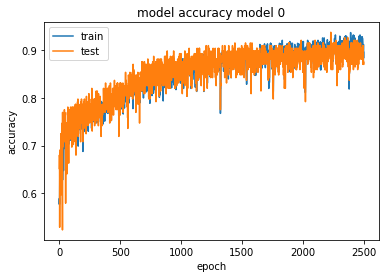

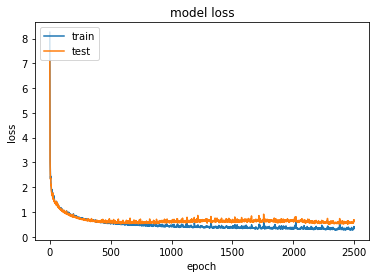

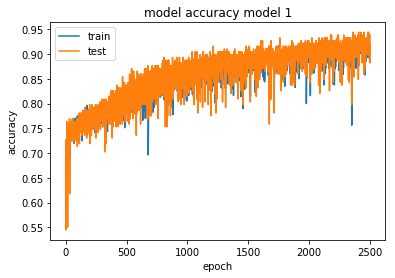

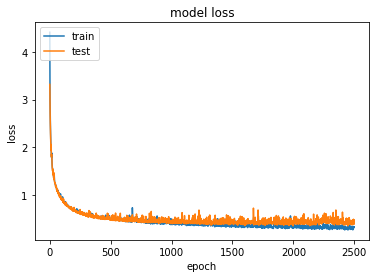

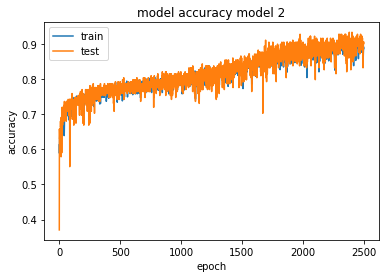

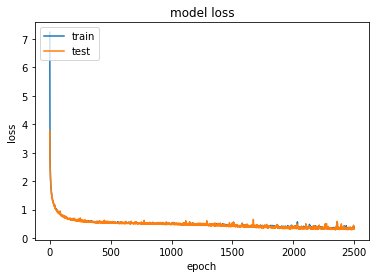

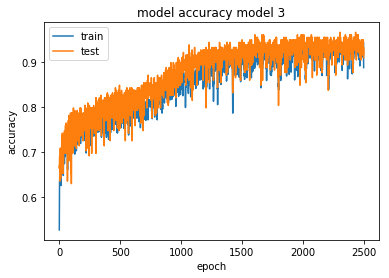

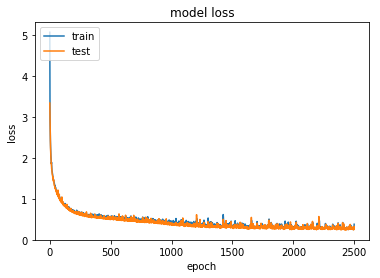

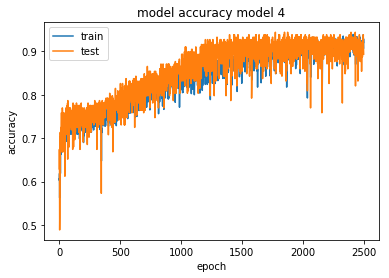

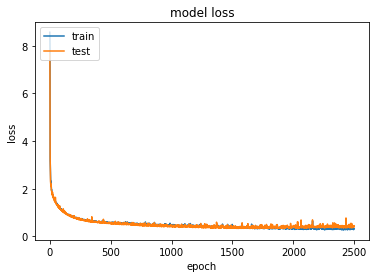

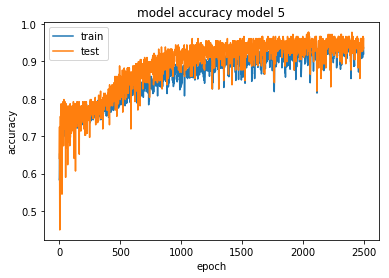

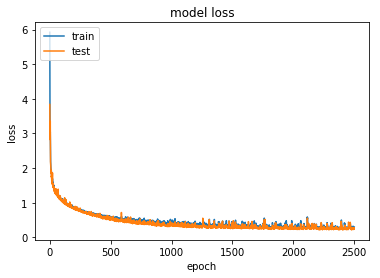

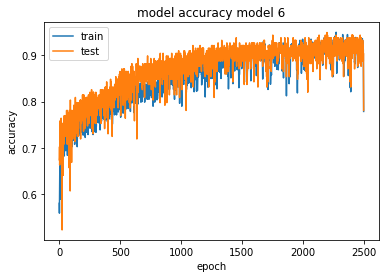

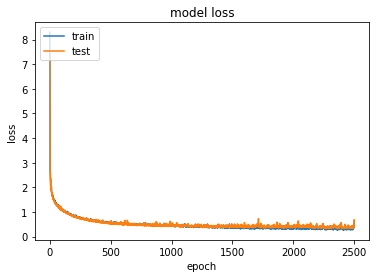

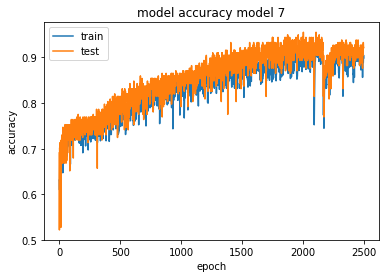

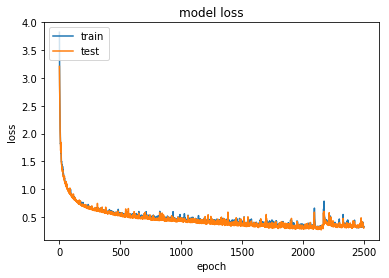

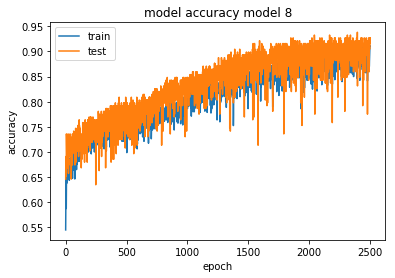

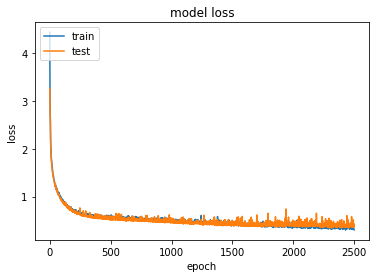

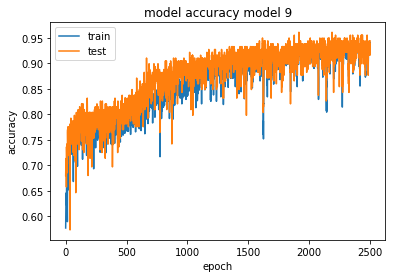

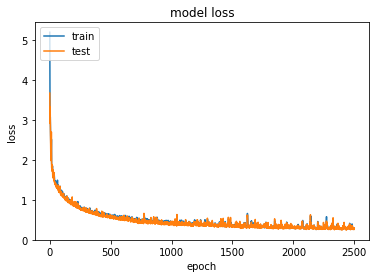

In [11]:
for i, history in enumerate(histories):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy model ' + str(i))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [14]:
from keras.models import load_model
scores= []
for i, model in enumerate(models):
    score = model.evaluate(X, y, batch_size = 64)
    print(model.metrics_names)
    print(score)
    scores.append(score)
    #model.save('my_model' + str(i) + '.h5')

889/889 [==============================] - 0s 28us/step
['loss', 'acc']
[0.5860565311796083, 0.8526434180975229]
889/889 [==============================] - 0s 33us/step
['loss', 'acc']
[0.4848683072155587, 0.8942632175671906]
889/889 [==============================] - 0s 28us/step
['loss', 'acc']
[0.38707292190552833, 0.881889762304497]
889/889 [==============================] - 0s 30us/step
['loss', 'acc']
[0.3546417418226214, 0.9111361065114711]
889/889 [==============================] - 0s 31us/step
['loss', 'acc']
[0.4085883527021977, 0.8841394839726632]
889/889 [==============================] - 0s 31us/step
['loss', 'acc']
[0.32580919500075795, 0.919010124673189]
889/889 [==============================] - 0s 31us/step
['loss', 'acc']
[0.62409456458081, 0.7716535427707119]
889/889 [==============================] - 0s 27us/step
['loss', 'acc']
[0.3974124133184602, 0.8897637804662148]
889/889 [==============================] - 0s 30us/step
['loss', 'acc']
[0.37928297659811744, 0.88